# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

```sh
pip install captcha numpy matplotlib torch torchvision tqdm
```

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, to_pil_image

from captcha.image import ImageCaptcha
from tqdm import tqdm
import random
import numpy as np
from collections import OrderedDict

import string
# -0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ
characters = '-' + string.digits + string.ascii_uppercase


width, height, n_len, n_classes = 192, 64, 4, len(characters)
n_input_length = 12
print(characters, width, height, n_len, n_classes)

-0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ 192 64 4 37


# 搭建数据集

In [2]:
class CaptchaDataset(Dataset):
    def __init__(self, characters, length, width, height, input_length, label_length):
        super(CaptchaDataset, self).__init__()
        self.characters = characters
        self.length = length
        self.width = width
        self.height = height
        self.input_length = input_length
        self.label_length = label_length
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        random_str = ''.join([random.choice(self.characters[1:]) for j in range(self.label_length)])
        print(random_str)
        image = to_tensor(self.generator.generate_image(random_str))
        target = torch.tensor([self.characters.find(x) for x in random_str], dtype=torch.long)
        input_length = torch.full(size=(1, ), fill_value=self.input_length, dtype=torch.long)
        target_length = torch.full(size=(1, ), fill_value=self.label_length, dtype=torch.long)
        return image, target, input_length, target_length

# 测试数据集

In [ ]:
dataset = CaptchaDataset(characters, 1, width, height, n_input_length, n_len)
image, target, input_length, label_length = dataset[0]
print(''.join([characters[x] for x in target]), input_length, label_length)
to_pil_image(image)

In [4]:
dataset

# 初始化数据集生成器

In [5]:
batch_size = 128
train_set = CaptchaDataset(characters, 1000 * batch_size, width, height, n_input_length, n_len)
valid_set = CaptchaDataset(characters, 100 * batch_size, width, height, n_input_length, n_len)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=12)
valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=12)

# 搭建模型

In [6]:
class Model(nn.Module):
    def __init__(self, n_classes, input_shape=(3, 64, 128)):
        super(Model, self).__init__()
        self.input_shape = input_shape
        channels = [32, 64, 128, 256, 256]
        layers = [2, 2, 2, 2, 2]
        kernels = [3, 3, 3, 3, 3]
        pools = [2, 2, 2, 2, (2, 1)]
        modules = OrderedDict()
        
        def cba(name, in_channels, out_channels, kernel_size):
            modules[f'conv{name}'] = nn.Conv2d(in_channels, out_channels, kernel_size,
                                               padding=(1, 1) if kernel_size == 3 else 0)
            modules[f'bn{name}'] = nn.BatchNorm2d(out_channels)
            modules[f'relu{name}'] = nn.ReLU(inplace=True)
        
        last_channel = 3
        for block, (n_channel, n_layer, n_kernel, k_pool) in enumerate(zip(channels, layers, kernels, pools)):
            for layer in range(1, n_layer + 1):
                cba(f'{block+1}{layer}', last_channel, n_channel, n_kernel)
                last_channel = n_channel
            modules[f'pool{block + 1}'] = nn.MaxPool2d(k_pool)
        modules[f'dropout'] = nn.Dropout(0.25, inplace=True)
        
        self.cnn = nn.Sequential(modules)
        self.lstm = nn.LSTM(input_size=self.infer_features(), hidden_size=128, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(in_features=256, out_features=n_classes)
    
    def infer_features(self):
        x = torch.zeros((1,)+self.input_shape)
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        return x.shape[1]

    def forward(self, x):
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        x = x.permute(2, 0, 1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

## 测试模型输出尺寸

In [7]:
model = Model(n_classes, input_shape=(3, height, width))
inputs = torch.zeros((32, 3, height, width))
outputs = model(inputs)
outputs.shape

/home/black/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([12, 32, 37])

## 初始化模型

In [8]:
model = Model(n_classes, input_shape=(3, height, width))
model = model.cpu()
model

Model(
  (cnn): Sequential(
    (conv11): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu11): ReLU(inplace=True)
    (conv12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu12): ReLU(inplace=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv21): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn21): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu21): ReLU(inplace=True)
    (conv22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn22): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu22): ReLU(inplace=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

# 解码函数和准确率计算函数

In [9]:
def decode(sequence):
    a = ''.join([characters[x] for x in sequence])
    s = ''.join([x for j, x in enumerate(a[:-1]) if x != characters[0] and x != a[j+1]])
    if len(s) == 0:
        return ''
    if a[-1] != characters[0] and s[-1] != a[-1]:
        s += a[-1]
    return s

def decode_target(sequence):
    return ''.join([characters[x] for x in sequence]).replace(' ', '')

def calc_acc(target, output):
    output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
    target = target.cpu().numpy()
    output_argmax = output_argmax.cpu().numpy()
    a = np.array([decode_target(true) == decode(pred) for true, pred in zip(target, output_argmax)])
    return a.mean()

# 训练模型

In [12]:
def train(model, optimizer, epoch, dataloader):
    model.train()
    loss_mean = 0
    acc_mean = 0
    with tqdm(dataloader) as pbar:
        for batch_index, (data, target, input_lengths, target_lengths) in enumerate(pbar):
            data, target = data.cpu(), target.cpu()
            
            optimizer.zero_grad()
            output = model(data)
            
            output_log_softmax = F.log_softmax(output, dim=-1)
            loss = F.ctc_loss(output_log_softmax, target, input_lengths, target_lengths)
            
            loss.backward()
            optimizer.step()

            loss = loss.item()
            acc = calc_acc(target, output)
            
            if batch_index == 0:
                loss_mean = loss
                acc_mean = acc
            
            loss_mean = 0.1 * loss + 0.9 * loss_mean
            acc_mean = 0.1 * acc + 0.9 * acc_mean
            
            pbar.set_description(f'Epoch: {epoch} Loss: {loss_mean:.4f} Acc: {acc_mean:.4f} ')

def valid(model, optimizer, epoch, dataloader):
    model.eval()
    with tqdm(dataloader) as pbar, torch.no_grad():
        loss_sum = 0
        acc_sum = 0
        for batch_index, (data, target, input_lengths, target_lengths) in enumerate(pbar):
            data, target = data.cpu(), target.cpu()
            
            output = model(data)
            output_log_softmax = F.log_softmax(output, dim=-1)
            loss = F.ctc_loss(output_log_softmax, target, input_lengths, target_lengths)
            
            loss = loss.item()
            acc = calc_acc(target, output)
            
            loss_sum += loss
            acc_sum += acc
            
            loss_mean = loss_sum / (batch_index + 1)
            acc_mean = acc_sum / (batch_index + 1)
            
            pbar.set_description(f'Test : {epoch} Loss: {loss_mean:.4f} Acc: {acc_mean:.4f} ')

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3, amsgrad=True)
epochs = 6
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader)
    valid(model, optimizer, epoch, valid_loader)

  0%|                                                                                                 | 0/1000 [00:00<?, ?it/s]

Q6RI
Y41A
GTV9QRZ7A9Z5
K63MLEKG


M8LGFI8N
1SZLWIET



OQ6G2US6Q868
RBHQ


2QNHTYE8BTK5
8LGS8RGD6J99
LL08



1G3E0O6NTZIR


8UGNQVM1


YZEOXOKNNKYN


E4KHQE0LLXSD
9H9L

R5AW16IV0UE2XLMW

L3M4EHPS


4M6Y

L26I
NIKR
SQVBZF9D
GPVOFO3TB63Z

LHPX


ITTK

PP35
MOL7OLONWVLW
NXHP

JYHJ3V7E1KUI
TPTD


U9NL8182
LQN82WC5
IEVJ

ABEX
WJJV4TSI

EQS4
WKHKA759
OB96
Z1FA6KYF

6XPM



UPBM
RQD269MI7SRB
QXX1YORYZWO3
85GN



X9K9B4HO
L837

DJKS

705N2501
7CS4I88G98FE

0RDM
NG72

PETB
N9MEGMV4624L4ZW8




HUBHHYUA4DYZLPCT



U674XXXSU7CW


7SU2DRANAGO7

JTB5AIKF
M85F

VF2SLWJ5

5AFZTITF
1R35

E56Z2JFA4NY3

Q89E

3SJNI2RY

ENXC
UDJL
HHYIK66T

XC90
4L1O91NH7F5RBO47
I8RH



PFS9DR5U
OSVZ
8D17JT8Z


M3P3
IFZFND8JG5ALDQ78



TKOI
4647BNM3
VLHB

8VP8
68WXEDFA
AFIC
2IXI
OBKBPZVA


K5YOBHRM
UZSK

3A6E
98YQ
FT8V
HKASOIN57I3QWZRW6P6J

VZME


9YBL


41V2NMBD
PEI6OUIV
ZHQ413JE3E7V
2YRGII85





4OXXQZWQA5HDKWXW4RZ8

JZ5F
CH8L
PC3Z

1O6U

6DEJ59SD
4MCM

VZ11PETSMSNN



7LLR
OCIKRVRVPBSH


Z41OD826

9YLRV2ANKC18

WHH81F

61Y7

QF6A


U358DNWBW0JDYH4DHKFO



OYV5HW4J
IJVJ
M5TU

KRQF
Q77RYSLV
OMDN
Z90V4OV2EG80

O717
I7WD5NK8H1D7


1LIX



5BGZ
GLFWGKH7OJTZ
RDHUHDZQ



OXVBZ1S6JN2U


JISHJEDO
14O1HGD8
KI3K
YJ7M

47NM90IH


7KAA
WBSPQFE2
N11EC5O1EX1OCYH5T6AP




YJABGJQA

2X6J03SE1J5EU905
LT1EIQIG



U3GW
KD5B


DT7BPDQ1UB7H

LZS5
V8U668KMHTON
J3UGDDE455MBBNIY
TL13




1JHIYU1T



HN3ZP1FRQT7VJYH94KYOPPNM
78HM


S2IT


KX9WH2FU
Y92D

MWEYE1X2ZH15I517


T7BM

6D07
U3YCM8O4
MFTDND4R

FTQ7S3K92E57

16RR
562S

N7NEPJQZ1QVA
V2X5


LPDF
47J05I2DFSZJ



VDZX8V3E
JHER


0ZWG6Y3QTA3D5WFK
67G6G1X0Z13D



WOHA6T65
Z89V
R9851C9D

A31V

32TU
D25SNED8M1MLWY78



VSTG95OWQKFP


4JAGERHH



9DXX

7OB7BTQ4IHSB
3MTSQWJ5VWS6AZJT

XW467YQ7

MWH1
HNPDCEEXG91ZP0DI





S83TWURER50H1LYL

ZVOV2OQB

BCQK

D19KNNN0YRV3

H7RG
529CFVPE

OMHD



QBM4

5FMYSHGPRSPQ18JOJ8DH



UG731EWWP6H7
3XE4
RP6WDCQLNLRGB1B5

3CP2


PT6A
RE7R
WY3M

73XP9LAQ



02S5
9AWIDECQ5POZ1UW7


2841M32A
H35Y
VBQDNBX8P6L4
14C84OTJ

ZPH7C4MD4BTK



JC2E

3QCK45BW

Epoch: 1 Loss: 8.4311 Acc: 0.0000 :   0%|                                                   | 1/1000 [00:11<3:18:05, 11.90s/it]

MZCF
AG6J
MZIR
AGT0
JVOA
QXZJ
8824
ELBI
866L
EETE
VCXP
FAOH
GRWD
6TBW
BES8
ZGZI
T7QJ
V24Z
YCJ1
ZZUQ
YFDK
RHXS
4NK7
NP32
KLY6
28L1
UOQ1
NM0N
RWYE
ZG3R
LVU5
GMBU
KBFL
X7CO
1ONL
AAKS
AX3G
0VH4
TBR0
M324
WU3A
8IQY
BTO7
IUKH
3CS0
A61F
5ERO
WV5Y
WOVI
BYOH
YAHG
TGO9
GJ63
POOC
06B6
CPEN
TY0Q
USGL
6UZH
BGGP
CL0G
CKQK
FPC9
PGN3
OMEI
6KP7
95XX
91PG
VVHS
HHE0
AM0O
Q1EG
G0FY
Q7G1
LCPB
03OU
XLJV
DXWN
66LM
E8X0
ZCBC
TSDZ
XQUU
SWTV
KR01
7H56
MKC4
E2AZ
RF69
RBSB
S0YW
DZ0H
EY7B
7E9D
H4UZ
WQEX
NMMV
PEGO
F03M
WNRB
F1NQ
YGHG
V4IC
JA7O
XCNI
2PER
Q7QP
7LOZ
6PA3
EBUZ
JQS7
SGXE
PZA3
EV8P
WY44
L1BJ
EAXB
FOEK
LXVD
XYSE
3IDZ
DODK
MG0O
JAEJ
7XHT
EQJE
MJP0
7M3R


Epoch: 1 Loss: 8.3253 Acc: 0.0000 :   0%|                                                   | 2/1000 [00:17<2:15:33,  8.15s/it]

PAL9
8MDU
HVXM
U100
UP4C
D50F
X8TT
O3MG
5Z3P
J9HG
T3ZI
XEQO
2J8Z
NWTE
XWXP
EI33
6H5J
TLPG
WKW0
PXPA
FUW1
F2OT
BQCY
CJ5Q
FW8L
AHSJ
BZEM
0TWJ
B1O2
CY2H
CH4O
I1VZ
NYQ7
OT5S
Q2C8
R4QM
4SI5
JH75
09YP
BGAY
VJ4H
2O0A
TV3D
972M
YZ4W
KYFC
A7X6
X7LH
6G14
MYMQ
40FN
35UU
TUBF
FUK4
OHQD
HF5N
GQVX
23UI
Y6FK
WRLK
J6AS
1UJJ
ZI35
9HGM
G0W7
XD3P
JUHK
YSW8
4WUP
VK1M
GWBW
WIVO
6U9L
45BE
4RKQ
6F0S
3O5W
BTAZ
54PF
S4AM
RXIQ
9EAG
GR1H
6Y4O
GMCL
6ERQ
HRMT
0SG1
9TAN
4T3T
OZ2P
C7TN
FNKQ
DD7Z
L6Q0
QXX1
FRY7
Z4IU
5GY2
1WCY
D8YX
X13W
SZRW
TLMD
AUU3
1KJA
1OP9
F7YY
30T9
INBA
8IGH
HDUW
NX2P
ADFS
S9QU
PA1W
NTI7
32R5
TUMI
F1KT
5S3T
MNPQ
VAS8
49KC
VFLR
C77T
I9GR
LTJC


Epoch: 1 Loss: 8.1102 Acc: 0.0000 :   0%|▏                                                  | 3/1000 [00:22<1:52:21,  6.76s/it]

FLN7
WA7J
AT8I
T789
1QZE
INCW
9W5N
3BX7
EXO6
Q20N
12CK
KUVZ
AGAD
H9BV
XVVV
W4D3
084H
M2I4
PGM5
XYSB
1ON9
WF77
XM8T
LUSZ
1PPN
U0YU
DPSM
Y5RP
24IW
R88T
HPF4
KMJT
1ZFT
9E2B
NZ9F
PK3L
N6PC
4IQ1
KMWM
SN0H
DOPU
S695
2KUJ
EYIY
LE1P
8KGX
MIAT
KUP6
O0BL
XKOY
AAXZ
J64H
CF7L
DVS5
S2Z0
81IB
1X2P
3MWQ
VKHW
FUWL
8OTT
ISL8
T399
HHT0
H0NZ
SLB8
Q0GF
7YZI
F7RE
6SN4
UM04
U9QK
E2AP
AKWZ
24BB
GWQ4
SKU7
1ILD
RU1N
CCXB
G2T7
Q6QS
MKOW
FMLV
U5SK
ADEB
6U6S
W6BZ
0MZ4
9Y8X
96DW
1PTU
PVGB
QO3H
8QZN
XH3M
ELE2
K5FM
QSS2
DG66
0NU3
AA08
G1ET
DG3T
V2I2
02MG
DHM7
RWUU
J1KU
SV38
4HHT
6E4X
I9JI
M49X
VJTX
5JD6
SOQ3
DGAH
1VMN
8OHS
4WH0
TG4Y
GPCP
G9HH
4E6Z
9RFY
W0GY
ALKC


Epoch: 1 Loss: 7.8008 Acc: 0.0000 :   0%|▏                                                  | 4/1000 [00:27<1:42:45,  6.19s/it]

UW99
HJDH
M2JP
JESY
J541
WYDH
Q97A
IUM3
UE71
4VFW
AACT
E3OV
9NI1
U4DP
SDQB
A304
XMDI
W80P
8ZI3
GC3R
F590
DJBX
Y50O
SCA5
35GD
HK5X
NTRH
7349
GQKD
DY4Y
2OG5
6YZ0
07LD
4WKF
DRZ5
GN89
KVKW
IZ2S
57TP
R1M3
YRWE
HPYN
SING
0D37
P7F0
MSU8
TRGA
RORP
2ION
UV4L
S0ZJ
ES1T
U55E
67IY
04OO
VOLD
XB6F
LLPN
P2MD
NTO8
X1IM
4EZS
37JI
63IL
EARR
69VB
1O9D
YG16
89M5
4H0S
AADK
U91U
1Z5G
CY3M
CF17
2MTU
OFN5
ZJ5I
1SMR
5HK5
NU8H
VCKV
0UG9
VH7Q
QS2K
U29G
J4TX
977O
7CGP
O910
NNCD
1CNA
4QZ8
FRE4
VX4R
8F7U
2FSF
BDMD
JRM8
FM9O
0GIF
VQFS
P6N8
RPDT
TJMN
LT55
0JOS
HLRB
BLHJ
NF4F
AAE1
ECFA
VTSF
AFWN
52WH
PJ61
BBXT
OQXL
X7AI
I7H3
0N0U
3V7N
709D
410C
YKFS
L1TN
MH15
NX2X


Epoch: 1 Loss: 7.4398 Acc: 0.0000 :   0%|▎                                                  | 5/1000 [00:33<1:36:27,  5.82s/it]

GNK9
VFTS
GGTL
GHXV
B01N
RB3O
JGWQ
3T1F
B4WB
71KU
RHGZ
ZSBQ
IGLP
HHX8
DHCO
0QHV
N8LT
JKL2
JLPA
JH5J
DCYH
G57Z
X3UO
TJPN
AIL9
MYF7
OTO8
N2IF
HND0
ZH13
9SSM
ELNE
8OLD
ZWYH
GXQA
EW1G
V3FK
8J3F
DPPR
XJ3W
8DFW
H41H
KR5X
UPLL
NJNV
WJI7
KGXZ
CMGX
RTCJ
5IQS
L26U
WDXJ
7CVK
HB38
E9T5
72BI
ZZ0J
TPOZ
KU2G
WZF9
B9N6
X6EV
8Y5Q
2Z8R
GMBD
UNBS
XXL0
6V7J
9E8J
CSKE
J751
1FL6
IE36
Z571
DX6X
YRO5
WQYE
UKUE
RCB5
O7VV
7BQ5
3GEZ
7GPT
966Q
NBU2
H1BF
NKVL
9WGR
BM2X
IOHK
W5BM
KTQV
7DP3
G8Y5
0TEN
RIFV
VMKU
SYWA
R4QX
5WZE
ETX1
8LXM
M2UO
1B6G
2Z16
X3BW
OWMG
1QVA
4NOD
7YSW
H3M2
8CTJ
21DN
7QLD
9IEC
4F4S
6WK6
DYY3
GVAF
QMUF
TXDU
WLJR
U8VV
9FJT
9FNK
A9XS
DMIU
8LEK


Epoch: 1 Loss: 7.0914 Acc: 0.0000 :   1%|▎                                                  | 6/1000 [00:38<1:33:30,  5.64s/it]

DJ25
D6QW
LMTL
0331
TCSZ
IGFX
NE0P
UDGD
XOC5
DP0F
T4PL
CLN5
1U8L
F1MA
AOZB
YOA0
SCVB
YMI4
V8JS
HCA4
V21D
6UJ7
9TWJ
0GY7
JQ21
0DDK
5LCQ
L5DR
71X5
7XMH
7O44
15GZ
XH3C
1MEE
B0N7
A199
2AQ5
45WA
N167
3KWT
IEYN
65R3
82O2
QHN9
2K7P
V0AU
OJ1Z
J6M3
84QA
FVW6
V14T
93LG
X0YE
NYL6
5040
JYQ3
LX72
VGEH
NT44
SIZL
MFOQ
A7PR
8V45
HDAA
YEB8
B3WX
LU5R
NTTV
0139
XMXN
CNB3
RKO8
LPQG
DMFU
NPKO
RNE0
1ZTM
S65C
IGZ8
LXHY
WX35
O2KO
GUSM
P9SK
P6CZ
HFL4
BLMZ
451P
RUIG
H6RW
3X5R
0HQ4
26RO
UBRK
NR7N
7N6U
TRZN
V0O8
52FB
XHEP
FSFF
FD7F
VA5O
VQQZ
2FU1
9OHW
I27A
6PUT
Z05K
1ZZO
MGQ4
IHS7
2S63
HO89
BOH5
D09M
H4TO
CE9D
99VY
360M
XMGW
MD3D
H12P
XQ1B
L85G
JJRM
ZXCB
BLPL


Epoch: 1 Loss: 6.7955 Acc: 0.0000 :   1%|▎                                                  | 7/1000 [00:43<1:31:13,  5.51s/it]

1AND
BJ2I
RCCP
VWIE
GIRZ
RCMW
45DI
78HE
1L5P
7U9I
IHLM
L0NQ
D5JP
LYA0
K2PM
PZSB
QBHF
Z2DE
9KES
PG13
PGOI
2VDB
XU7K
3N4J
E1Q8
HE84
3VAX
Y7R3
I2UW
W1VI
05GT
MJ90
K5ZP
U6EI
BEMR
39AX
KJQA
6KMY
X2L5
TK1Q
9WFV
T9YU
GENK
EW80
P3UQ
VWUD
SX0S
K2MJ
P6CQ
KCWM
ZD2Y
MK94
MCL3
XR3I
ZIKB
6I7J
JMSU
9F8P
XJ0N
L7QC
VISA
9E51
ZG2P
TJVG
TQSV
FGJF
H4ST
XDV3
36PT
C2QF
BXBB
4L6M
MZ9E
V0ZY
3OOF
XULR
3IYM
QSG9
7NRH
8SYE
3TPJ
X1F9
CLSB
PGCH
ULPO
2NRD
W12K
INTJ
JOXI
9DGM
7Z7T
S80T
2LSP
UZN3
5IEV
EXOT
79UZ
0OOX
C91T
2WC1
TR49
5CVY
G3JE
S5ZX
S8QJ
R30K
5UIE
HSI8
27L7
9DNL
T30X
U4HD
X0H2
27AW
KIT5
Q95E
HCQQ
RITS
O442
VN7A
K3VN
14UU
HAES
ODCK
8VVE
VGYA
5JMD
2H5S


Epoch: 1 Loss: 6.5446 Acc: 0.0000 :   1%|▍                                                  | 8/1000 [00:48<1:30:24,  5.47s/it]

H4DI
X9G2
XVSQ
J1S0
GGLZ
BSFI
Y535
5NKF
QSEF
FH27
NZT7
8Z1N
RQ30
MMKS
O9YI
YK5O
YYBA
9L2P
0068
XK1E
B840
U0IJ
60L7
F314
Q0CR
QM4K
Q23X
EBGP
T26M
DWN1
34IV
DM6W
FSBC
98Y0
YGG2
UT28
MB11
URJM
9Q8M
L5W9
9RU0
XNSK
GX8D
HZTD
Z9SU
Q4JO
YWLN
WBFO
Y8IA
UZU4
HQYU
G94J
7GYZ
3FJM
VQL5
FJU7
UIGN
FHI9
O9WD
57XV
Q174
J9RG
KKIM
52I5
SD8J
GCGK
9P4J
F1XO
MJ9T
DGSK
YLTP
5KS6
8BV4
ES2Y
K71C
GULF
WGBT
ZEBC
HCSX
8B24
2TU5
KPY8
2EWV
A6WH
9UBD
PW8Q
CU60
1YVZ
SQDN
V9O3
V4T8
43BB
IWKE
NRCW
FNLZ
H782
XQL7
B0FH
MTKS
LVBN
QD8F
J0LP
XY4Y
7VAM
BEGI
84Y0
7VS5
2QYA
NWAI
J8W4
RP33
XEO4
UDAE
HKLG
OV1L
6BP8
I5P3
DNHF
WY1D
NYGV
EDV8
WN8U
ZRI8
KZXX
XN5E
J3VX
Q6GY
V3QF


Epoch: 1 Loss: 6.3202 Acc: 0.0000 :   1%|▍                                                  | 9/1000 [00:54<1:30:57,  5.51s/it]

72T9
6AP8
F6Y0
OJGU
L5EW
SRW0
KITR
W88B
HU6U
1H11
OIKO
9QK9
1RM6
DV54
SYA1
0ZRD
OI3D
L1F5
M81G
Z0XJ
JVO0
HI14
SNVK
OCBH
99DF
TIN4
JTNQ
HP1C
QW5B
21IS
01RR
PPSW
55FI
VWQU
6UEW
17XE
94GL
W3SV
847M
KASJ
KFEC
0GR3
3JB3
QO8S
L5C6
YO80
KA53
X6RT
Z0W4
VANE
U94R
CMG7
0WL8
LHRN
BY2T
6UIO
68KF
J5RG
2K56
3FTB
AWZK
21CX
CL0I
LGWO
NL9Z
DM1E
HVX8
UZXD
8YUW
BPYN
G300
06LW
4ZOY
XTUE
96A3
VWBS
92MK
JWC9
JRYQ
GA9O
P9E7
U15S
EMBM
FHI0
VG35
0I6S
KEMT
YT2U
QX6N
0E8A
5P17
S5DO
0M0H
DXDS
L682
KYG1
HNOR
Y0E9
5KZW
55TC
FVQX
PLE3
N9ML
GNVM
CK89
YDZE
Q6KP
GY1G
G98G
58JA
CG6Y
MIIH
RIPF
Q5X0
LN07
NLPG
XHYC
DHO7
TTHF
0EQ8
3ZUS
QVJO
JONO
PVRM
0NDN
9FKP
105I
7RTP


Epoch: 1 Loss: 6.1110 Acc: 0.0000 :   1%|▌                                                 | 10/1000 [00:59<1:30:39,  5.49s/it]

MOYI
FJQE
L4F9
GPRZ
1V57
82IF
PR21
L6GE
CRZY
2YCP
S4X1
T3EN
E46X
4CQU
SWXG
C5RA
A5OM
TBS5
BIB8
EXWQ
VCNN
O89C
6KBE
39DE
PU8D
VMVL
517R
0R38
05JQ
CYZX
VAG3
HNUL
FKZT
P9C8
DYV0
ACE9
V5KE
H4XN
LVRR
J7O9
1N3C
LRPU
WIQO
TBLD
R2KM
F0WI
8NMB
KYCY
3Q5L
64WB
EUXY
GC3U
6VG4
57YR
2NV2
U70X
8MVR
MROA
13SC
6OKC
UZ3F
X786
DWUB
70KJ
8Q1P
MVDU
KZR3
HPDV
0DMG
53GI
YZDV
EB9R
L0C8
5AUB
YI95
N469
W4WS
O4QR
BXZ6
CIH0
4OMH
6KN5
YEW1
CTAS
1JWA
1QKE
EU8J
XR8D
NJTL
KWHW
210Z
VXOR
UZY4
NR7X
YAIX
UQQA
KQQY
R0BF
QCQZ
1GEI
Q74Z
MH5D
BXD3
B28Z
XSLB
ZRIV
AGR3
E9CT
2OSK
PHXD
BRN5
RL64
TLJP
PS8N
3YBQ
D0Q2
SW9V
2XVG
MIX3
BZY8
TIF6
2W1A
SMHA
H752
QURK
ITPE
OCOK
9U79


Epoch: 1 Loss: 5.9108 Acc: 0.0000 :   1%|▌                                                 | 11/1000 [01:05<1:28:16,  5.36s/it]

38GV
JZUR
AUUI
487H
L5SP
ZS6F
WH8M
R2N2
XG91
S49W
URVL
WBRS
77EE
7YJM
FBJR
RYPG
ET6U
U1HI
NKPN
HAAQ
VIPE
XZ7R
TCL8
VXJZ
F2HE
JQQ0
6GED
6H9P
R1JN
DLJC
K1QT
5NQ6
JGAR
UFDW
MQ1X
NGZM
P8DP
7E7D
USDE
PSNT
KNVD
4XI0
LNGT
CL9E
L03K
U8P0
XN5M
9VAP
ZYDX
B1QE
RPLT
NWCZ
HIJ3
BUXT
VWY3
LX9J
W65B
56SA
2475
FBX1
DV6U
Q37F
5WJ7
4AI7
C49P
SZ9R
NJ32
9MW7
S5IU
YGN9
V6Y5
NBTF
0DZC
RM4O
1LS2
6PVE
N66O
F6DI
D9N6
OJP2
XP5C
59QN
DXPF
THT0
SUW1
AEB8
B991
PR3E
DS3H
G2T4
ALPA
1AQ9
RFTJ
C143
TKXA
9QE8
N3AO
M9VC
W5X5
G0FP
FI0T
BZIN
TAKI
STWX
AD9C
OBCB
FJCS
1Z4B
XQUS
UYF9
EFDT
MK6Q
QOOE
UFRH
MWOD
MNIX
94GG
IZOY
BGCA
CRFX
1ERC
XKLB
P028
F4WD
UGB6
WBND
0C3W
1Z05


Epoch: 1 Loss: 5.7200 Acc: 0.0000 :   1%|▌                                                 | 12/1000 [01:10<1:29:12,  5.42s/it]

H0AO
7VQE
G7RV
O36K
DY9J
AURJ
3135
QR6S
A170
P939
XJX0
WAQL
SBTG
OLKN
G7C9
BY0M
8VQG
01O6
U7N6
YNCY
B3RK
5O37
D7Q8
6AT2
EKJ9
EP0L
90ZJ
9G0M
Q15B
QSFB
VW0K
Y4TA
DYBQ
V9CR
MGGL
36AZ
8OP6
4CLT
AX3S
N3DL
C2XB
5ZXS
P0Y3
MW5A
K3ER
QH3S
5TN6
2XCG
KXAT
3Z6F
HS1V
WE4W
ARIK
NLNC
SLLA
4D6O
6DF0
Y87W
SXQX
A60G
KG2Q
0N2Y
0BHG
Q2L1
J697
1NQR
L9GR
VVZ9
Y1F9
2TZF
79JO
M20Y
CA6J
XFGW
HNG5
ETRM
RE97
K23N
5RQ5
N582
W52T
SNPX
0FIQ
A0ZI
B4KI
SENQ
70G7
IF1J
VMP5
H1BI
D8T7
W30K
AIM1
CRQB
8T3U
WL8A
DNF0
JQLK
PBNG
FF3B
Q209
9FM0
4I39
JSTT
QPON
KRLN
DX5L
XO6Z
VPB4
SFWF
P64D
4YFG
UX0K
N7YY
LECF
7SJ2
YFXA
RNTJ
9NF5
NE8L
AQCE
ZCO2
HG8U
KHK8
LWIE
H92T
EMRY
S5S1


Epoch: 1 Loss: 5.5422 Acc: 0.0000 :   1%|▋                                                 | 13/1000 [01:16<1:29:41,  5.45s/it]

LDUH
B5BD
FSAY
BQHI
NMMN
J7BF
UCY9
OIDK
WTKR
XJG5
LWDO
I0AH
K0ER
R153
PW4K
XFQS
7IXK
MUFB
2M03
ASPU
X0M4
DIN8
2UZ7
OQPI
J1YU
04EK
J9RR
FR6W
5XZG
BMUH
3H10
MO4S
H8X4
NMTF
Z3Z9
JO3K
7V3D
S29Q
QLK0
1PXG
YYLP
J22T
A70B
6FOQ
R2A3
RB0F
EN6U
TGIA
AV4P
8TQP
JWOL
YQ0A
8TXQ
BHBG
8SMV
95SN
112X
6EG8
K9YS
XGRI
QK5M
0TW0
7KZZ
0AGA
YSMI
SRHS
13MB
00KY
0B0E
E0QW
PQ3E
G9K6
PBBS
G6NQ
A5Z9
1QQR
GU7G
VKXV
A6FX
XV5Y
MIGY
ZQL3
PFD4
8LEM
CB1P
3SUF
VTXY
WQU9
V6HG
0FRP
B6FH
FGC4
2OJ9
FEAY
GZ4X
MTGC
OCJJ
5LE1
3FLR
4BOR
HMN1
FK2S
8TSG
G4BS
1VPM
X3SK
O28Y
UGEC
HTMZ
UWP2
1FUB
BGC4
DJ00
QJ0Q
ESTV
H1S9
5JL8
8SK1
UPC0
ESGB
XJ83
REI3
U3VU
QDEL
8FFX
OHFT
OMWN
VAR4


Epoch: 1 Loss: 5.3827 Acc: 0.0000 :   1%|▋                                                 | 14/1000 [01:21<1:28:16,  5.37s/it]

U6PE
CUI3
O53V
MRSR
Y41N
EYSX
Z17Y
AN0M
PS83
RLGE
7PXT
TQU6
OTKN
SXBW
KDBD
HY42
QONZ
IN44
X54G
J6RE
321K
7K4C
GMUH
IZIN
79O2
JWZT
9DI0
GX3L
W341
ZWSB
HP49
CXBK
QHLL
4TC5
NF91
RMEZ
L4SS
TW1B
PKRN
YW72
7YC5
LQXV
YN5U
ZF6E
CHUI
4IWY
EMVI
PJP9
ZCQQ
8MFT
4V1F
L5CW
KHT8
05UE
TTHY
19AM
BRZA
9HET
O3VO
EUY3
FCNW
FFC1
BTEP
JW4I
N58A
TQ5V
ZASE
Y6T1
ZPOC
NVFK
N4S4
T758
3OOP
8FI2
L4O3
44X2
DVZ9
BQ7W
8F4N
CE0S
Y232
DN9X
BXBQ
U48T
U4OD
WS0D
1HXJ
Z6A1
EYTJ
OFYO
2OJL
CHTT
NEE6
WQ7Y
16OW
J2MA
W3XA
6S19
XLOS
QJ99
0MTN
RWAS
GEK8
DIIP
5F5G
V3N4
0BVY
9W3E
4VDG
9HTM
GY6V
GQ2Z
8FIG
WTGG
KMUK
S661
5EEW
F67F
JFM0
L51L
L3RA
KUT6
3JTM
DQDZ
TRSK
UAIR
ZCG0
IWAW


Epoch: 1 Loss: 5.2422 Acc: 0.0000 :   2%|▊                                                 | 15/1000 [01:26<1:28:07,  5.37s/it]

G9UM
GKDY
YHZL
RWFU
UPSS
Y4YW
3VJ0
GSYR
SEUD
H44O
X9ZW
IW2G
QEWX
0WDQ
C3G3
0RQD
F14Z
NXDS
AI4N
TJE0
A95P
C3RT
80J4
G53L
E2LV
UTHT
IH8L
LFQM
7QR3
5E03
VO4P
POCL
EGLI
9SYT
K4YO
RVVA
64E1
ANK7
2LXF
6UJM
B4BY
HNM5
ESWZ
DAOA
4H8C
FJCY
2CAW
2IHT
33V6
8D1N
0BCD
CD4M
7L0J
C3UG
D1GW
UT5K
RSW5
XLA5
NLL4
40I6
8SXT
I487
PYU6
MST0
ZZMU
NFJB
97FP
ICYW
5313
1Z1N
I7H6
I53X
VUFO
3EUK
3A0L
1BJK
084X
VCM9
8QIJ
HGVY
GIUR
0AJL
V945
ASMW
0V1J
8M5Z
1E6Y
4IJE
HPAK
WBZ7
5JOS
04QG
KUXH
4VNI
888M
XO7R
WAYM
QCDF
5X8T
SF40
94ED
YRH6
XV42
BMWX
BREK
OSTL
R0TM
ETE6
1K80
1XQ9
CXOY
18YH
C988
V3LT
SWNI
FWN5
FUY1
PHON
BAAH
R0M4
TGYX
JNWE
X7W8
L9OQ
94C3
EZWQ
T9VL
UHJR


Epoch: 1 Loss: 5.1184 Acc: 0.0000 :   2%|▊                                                 | 16/1000 [01:32<1:28:29,  5.40s/it]

CM1J
722X
E9VT
Z7OX
GG82
CSRF
O9XL
V7OE
LAFL
TEIW
8H77
QS4L
3NTJ
9BFH
1B5K
ZYLS
69SN
WGGN
QGP3
MG41
L6RT
63LB
YMHJ
DYUT
IU1W
OFUM
E67P
ANDF
G6C2
IVOS
Z2AK
2XR4
6YYY
BEY6
L7KJ
ARDT
UNL8
ZDRG
CBBQ
OC5J
N5Q0
7ACV
0EZM
78JC
9GKO
I9LP
RSJN
2RR3
1740
IQ05
QJYW
NAFI
LVEE
NX2Z
4Z1E
LDJR
BHPB
V5ZI
EM5R
RLB9
YRPV
RO86
F5PZ
ZV2Y
P4GH
CEMT
PTCR
SDW3
CCWI
R8SA
NUK0
MHRC
NMCK
HRK1
LGCT
7G5H
YMYH
QAFQ
RFSD
GIG8
KKYU
UQCF
FSFE
SCAF
CLF4
SK88
EVV9
F14S
7F6Z
VA4V
94HY
EFHD
V483
K6YW
2450
7AEE
1C0H
99GK
OJ6Y
7P4U
SHEA
DQ8T
740T
WTXM
MEKH
15SZ
KUT2
YM6N
75HE
I52G
6H28
66KJ
ADZ8
QZ1J
8N7Q
2KL3
CAYP
8FXA
HKBV
UMNV
I36B
CQWW
6PG1
R30G
ONSQ
IFRH
63SB
TR04


Epoch: 1 Loss: 5.0104 Acc: 0.0000 :   2%|▊                                                 | 17/1000 [01:37<1:28:28,  5.40s/it]

OZ6T
Z9QT
PYAB
1F27
0DJ8
7JKU
BU31
8QAI
KB5Y
1VAX
ZYKW
6L1M
JL7X
P467
V0WU
JAXZ
9KYN
1DF1
OHFX
PXT6
RNPG
2KCF
3ZUX
TXXK
CDVV
V6KI
42KO
Y1HY
P8PL
82BY
S1BW
ULOL
WHXC
AW1F
XU8A
AZNV
33X2
4CWL
NVA9
9JLO
HX4W
9HME
4XRE
FO6N
YLQ2
H7I7
W6G1
YYC4
S00W
P1KG
1383
L3QQ
MGJZ
R68J
QQF6
MSU2
JRL3
J3X6
R2HW
Y7QC
FGKS
84HW
T2TQ
AFQX
S4Q6
5OKW
GYVP
RLD8
H0PV
9VEO
H02R
IV0T
7LN1
IT3G
NM9U
MNGG
ZNHZ
DDL6
NR88
GEWX
2Q4M
BJHG
ZWZV
XT4C
I5GV
IP2S
PLYD
Z9G6
UQBM
ACNQ
66WI
XSSK
ONBR
V3S4
FNAO
YKAY
ZRPB
A3WH
AK8J
5A4Y
5WU3
NI31
XV6B
3F2K
1KPN
08U1
KHM8
1JJP
37DG
K5MM
VFBP
8XM8
Q7EI
T5XL
JSON
OQG5
RMUL
00Y7
SXPE
N28T
OVR0
9LP5
GAZK
CIOC
VHI9
FANZ
LM6S
WQM9


Epoch: 1 Loss: 4.9132 Acc: 0.0000 :   2%|▉                                                 | 18/1000 [01:43<1:29:30,  5.47s/it]

7U1B
GSO5
T3RW
YE3Y
AQ4R
T6OZ
GDQJ
ZGF6
I384
BGDH
8Q12
EX7P
228B
QK8R
2O42
MOGW
CR2I
KV3C
BTVU
0YGE
FG34
TI7O
C2RO
WDYP
DY69
LSWC
LYM1
V52C
20PM
PQ0Q
M8ZM
PCX8
BT22
M41O
MYN7
RIU6
KGRS
MBDZ
834U
XBXP
PHSE
FGEV
86F5
0FB2
AE78
GG6N
0D1M
NONM
F6BG
C3ZZ
CERG
ZWA8
7GF4
H4OZ
UWXJ
OZZD
LYB7
8JJ9
TU3O
ZPO6
GF8E
D4ME
EV9Q
DVPO
8U6T
QOED
E67P
OMDB
HHNK
WLIM
KFN1
0M4O
4ZVG
6QVM
5XH6
4LMU
WOLP
XPIE
M7YJ
E3ZL
NYBC
M859
5SZ9
OT3P
6KVF
ZINP
ALDU
HBRF
XAYM
16VO
A8H3
G0R9
KND1
T12N
T3X6
73LJ
7UD4
VEFX
JHFK
MKAZ
OJ7A
0AVC
6ZS2
TBUE
G1ZF
WZ01
O90L
RKKI
AB3K
B387
7112
F2Z3
R47X
L4I5
J97W
FKX3
RH5H
FOLD
07PM
OG5G
QH3F
86EM
SPV8
X7ZK
0CPU
LTVA
AGVT
EVBX


Epoch: 1 Loss: 4.8241 Acc: 0.0000 :   2%|▉                                                 | 19/1000 [01:48<1:29:35,  5.48s/it]

B2EM
N2L4
8C1E
WY0D
BXIR
817N
EOGD
RW2O
KA6C
JBV2
5AYL
PPGW
M6ZV
FB75
FRFH
FBYB
ELB9
D9ES
P4OK
IH5T
3U7R
OH2T
LEJI
UTCY
GMNG
3FVE
QZ5F
ZWQV
TIE3
76UM
VYRI
TL7X
4UNG
LELV
PPNT
0LCP
9UO0
S6FZ
5IFN
HZT1
QHY9
CEE3
SZT0
PCBW
R3CH
6MN7
T8XU
ZZQP
MXLC
20FD
AVKF
2OHD
0AVG
HUX4
ESPW
ZP2B
3UBD
6VFP
LTOP
ALSD
TYX5
V4LV
F80S
P4UL
XYZB
QBG0
QUY3
WD62
TEBG
O3A1
2QDS
CIZW
N8Q9
OIKT
CAYN
GLN0
5TO5
UZMR
3B8Z
RHJI
MO6X
STRT
LUXK
PPNZ
3RC6
AG4I
GA8Y
VGET
1O08
UFF8
M04G
E0RE
UBM8
6YD2
XPTK
VVBR
76FI
ABLB
P84H
QHSE
3XVZ
OLL1
K5FC
72Y4
S3SJ
DD8N
HR0R
25I7
2WC9
23RB
I5LW
W8Y6
ILP0
OFJL
NW8P
7VSV
5YHZ
91EA
Y7TH
A8MP
Z5W8
NVJS
17H1
F3KS
XWTT
98AI
OWZ5
6QOV


Epoch: 1 Loss: 4.7410 Acc: 0.0000 :   2%|█                                                 | 20/1000 [01:54<1:29:23,  5.47s/it]

IZAY
KDFM
59PM
D6FX
OPQN
VYWN
PH5O
FIQO
5BCF
HT27
OM0F
4RRU
NYUH
ZY72
IOMO
I2YJ
LJR5
9H4H
GBV3
ZB5D
4LZG
X70I
AF37
5S0D
GLLJ
V6BB
CPPM
HM08
I14P
A5V4
DEE2
PNH2
10BF
2UFW
J3TW
9N1Q
AFAP
E8E7
6FXG
Q6ME
6FBC
MDIF
BEK2
TR2E
8R44
EPAE
YQDZ
4D8H
JB9E
UQBP
0FGA
QX8W
20JQ
TBR0
6HE6
7LFS
WFIG
8JYN
E9ZO
1CYL
X8QK
69DN
JNZJ
AR5Z
BU63
3BEU
3H0S
GMDM
B8A6
3DPN
E5AV
B3SG
YOX8
MB8X
P5G3
MZ7D
30A3
4CVW
DR2U
B0D9
9MD5
04J8
8J3E
ZSHR
BR8E
P5J6
RSL6
YENV
YQ2I
MWID
9VG6
JBN9
UFGT
F0KV
CSMM
5ZYG
DO3O
VORS
Y13R
W14K
NGL0
HO40
8ELG
03VI
DL42
VOGZ
RR5C
D6YR
8EG2
DSEW
VYKZ
LFFN
74HU
Q7F3
NVZT
3N9F
4TT1
JFZZ
TRHX
L3X1
7QQX
YMF8
STDV
L1SJ
JXRN
XJT7
SKN9
MFQR


Epoch: 1 Loss: 4.6629 Acc: 0.0000 :   2%|█                                                 | 21/1000 [01:59<1:29:35,  5.49s/it]

YYYN
9OMS
22N0
CVCU
4G06
VDMZ
WDD4
O8DR
A2UU
XLA9
MTG4
I2M3
1TZ9
VCH2
VKTE
H0VR
4FZW
VMJF
CAWU
3NUJ
L6F5
7NIK
PIKU
JP4K
FZ12
9HOG
IWLX
3D82
GG7A
CLGZ
0PT2
3482
UV23
7QC4
5G4M
1TRK
BV08
GJTN
UHUG
GLJ2
LR0D
R3OU
B9XR
EV5L
81XN
E2KW
636U
MYBI
OZHQ
D68V
W2ET
TPWH
0UKW
OGUL
0HQB
WX42
55ER
UX9P
VFCJ
BIP3
115B
YAIY
LTFW
VYCQ
MXLT
1X3S
6XML
XMWE
ARS7
5EX2
C5LE
NBBR
LL9F
JOIY
RLA8
K7LN
2115
X9X8
RNV1
HFKQ
PHX9
06ZD
XK3D
9S91
BUWM
F7MD
8Y16
8400
P878
1DLR
7JYY
K3JA
37SR
EM2D
32FP
9ZTU
F45A
4LWH
BRAB
0FP8
1Z18
5DHA
YJIB
BBHU
HHO7
547M
R4L6
QUFM
M56V
ZQ5E
50LG
HJ60
D1WU
KBHY
FN8C
O7IB
CY52
INXI
1F4N
AGGZ
GUCR
PJGO
KKAU
R0D1
9O93
A8IV
KM3V
4QK9


Epoch: 1 Loss: 4.5907 Acc: 0.0000 :   2%|█                                                 | 22/1000 [02:05<1:29:29,  5.49s/it]

4MWV
58VV
TIM0
5550
WV24
GOOM
FBG9
XORL
8R4K
NHYT
JHPQ
I9BX
PKAT
0EY1
ZLYB
PH9D
VZZB
D1RD
H7OP
TAAU
ELNV
YIRE
T2TD
L1OH
66L3
XHM0
L4EJ
GBVW
NPD6
4GPP
69HF
TO7N
345N
5TWM
QP0Z
QQ7V
ID8F
BRHC
61QK
VPGI
XPQV
55CG
IEKN
494Q
YU5Y
EFJW
3UU7
EI27
Y8PZ
XBAI
EC30
8XBR
S6JY
OL1M
7OP5
F83G
GAMO
LKPE
71BB
AB74
2N6U
MNQF
U75M
STO9
CI88
WYG6
SQII
1D2I
PPVC
0ZL0
B6TZ
ZXFJ
PUN2
N60B
EQ7A
P2HO
0MA9
KNRS
PZI3
WOA0
R9Z5
9GY0
9FZA
LM5V
GFWE
737V
EU59
VIPC
A62W
5UF1
KQ19
NIMC
IO72
ZGG9
S3LB
QVGD
4FQ4
LXWF
TQBL
6ONN
N7QH
X56D
D5VM
TSS8
S65S
L6XS
66X1
BHDV
OUTV
EPG2
EUKY
JNX8
YE5K
7APO
QWYT
NBOQ
2G3X
9LWG
HBCH
B78Q
T0DA
NR9Q
OA12
WRES
OMXF
1O5O
TP4Z
2JXX


Epoch: 1 Loss: 4.5256 Acc: 0.0000 :   2%|█▏                                                | 23/1000 [02:10<1:27:51,  5.40s/it]

Y22W
UK9E
L6O3
I5KD
E6O5
YZBR
ONGQ
ESMN
GRMS
9Y6L
SAW1
29S5
15Y7
3B03
Z6EJ
HKJR
ZKT6
M9N7
QNEI
RKGF
B9O8
QYRN
H0PU
86IP
SG8N
MY1S
YN9T
Q5WS
A363
YUP0
LDF0
7LC7
Z3W5
BE4J
VWUX
IT24
3FHO
GQLR
CKD9
H1VB
55US
RAW8
D7IG
2I35
618H
TE80
9UCO
N3QY
UBNC
2Y6C
AF8T
US6T
ZTP2
H91C
G1CS
0K93
6V7Q
FZRG
66R1
K10B
3U4A
DULL
I0T8
32TO
PCJJ
XAX3
JEIW
PFE5
3P65
6BV4
27YY
RO5C
0X4N
HJBB
7I0I
KYWW
ALKK
4P2D
V08J
FNZQ
78SZ
RDWF
2ITE
3WBO
KIG0
D8RZ
7SWA
KLKD
UO3K
L4HT
SWYR
5RLP
XAXI
9WRC
JM71
29N8
61V7
ZHPP
060U
YWW0
OJZO
D47I
NUWI
RRDO
T1E7
7WEM
JP0N
73VC
WGHO
TQ0U
3I3Z
OS9E
K80T
QBIH
LG81
UHW5
XNYI
HBB1
HBW1
U644
OPLU
BSLJ
IAR8
BJ4X
I2CI
DO4G
QY8N
EOAC


Epoch: 1 Loss: 4.4678 Acc: 0.0000 :   2%|█▏                                                | 24/1000 [02:15<1:27:17,  5.37s/it]

Y8QS
068H
WRQG
XM5I
B8RV
9IES
5YGH
GEFV
KKWV
V5XL
PIH9
YIWJ
PRLT
QNIT
Z6S2
XJRY
AOLU
X6XL
74D5
IX0G
IQEG
QCT4
2N66
MFMO
ZZM3
DTQH
96X6
HL5B
S4VL
VEXS
3V9T
PMS7
JOO0
98TH
7I5S
IZ66
I6X8
9M04
PW0L
IUIL
SFK8
GV51
IZX8
5ISH
QXXY
3LZN
B2B1
NV1Q
OZ9G
MVCT
KT8K
JKA1
MJJJ
NZE8
I4MX
SW8D
4SZJ
DXSY
1OXI
0E9R
TKF0
PD5A
R9U2
ZGDJ
EY23
8WWN
JER7
YPQ2
77VL
RDKK
T75M
3DV9
3EL7
RS9B
5COF
08OP
MY9S
F85K
T7ST
FQFI
GLSJ
XPBI
4JNZ
4L7Y
2NZ5
MXS4
64KW
XNG9
KX86
2344
ZM1R
V1LH
ZBLS
1X7Q
UYTA
FIDE
UMTX
H0CU
ZQR4
YXHM
BXZP
S1CS
JYUX
22EO
266A
DWPG
XKA8
FXOT
MSDH
S9MS
YKPG
OOA2
1HS5
B6KM
BZRT
2MWM
NOLZ
IS8H
IS1Q
VSEY
5TI1
OFN2
RSBY
W13P
NIHG
TO73
8R8V
166K


Epoch: 1 Loss: 4.4165 Acc: 0.0000 :   2%|█▎                                                | 25/1000 [02:21<1:27:29,  5.38s/it]

W4S9
LLT3
XWST
E4I3
4PDB
1HPO
3A7Y
C5F7
DT9L
L4B5
2TOA
HM02
91V1
NZOF
29LE
BBSO
4HV4
3MZM
8YIC
LYWX
HK8A
OTRH
J0KD
W4PL
6MM6
7IIG
VPFF
WHTT
AFSQ
NIIX
C4XK
ID8C
89CH
MKRC
P0KJ
IONX
Y671
5UJ3
7QQA
1IDS
YBA1
2V9Z
L2PU
O5UI
ZDYH
ZTJ1
0DLX
6SRC
MDGL
1BZZ
26AY
X5W7
JQK2
OTVT
C1C1
E38M
N7NY
QADW
B1P4
XZVZ
0K2K
1USW
PKJI
TQ11
2DLU
VS0W
XMO1
4KXS
2TBU
LRPB
1H0C
33BB
TNRU
BVPN
1JDS
TX5H
WJ10
3GVS
R0HM
F0NN
YONL
F723
2UFS
G81K
MVZZ
XY2Q
4WRZ
NV5F
LER6
BKN1
1P0D
IDT1
5I46
8369
G0CD
85VF
SOUL
4U42
DOVM
YRFN
55LX
2BK7
JB52
2R2J
W1KT
JKCB
AXJK
P3Q4
364B
EVDG
V88L
SFUK
K125
RO5U
O8CK
7RLM
05DK
21ZC
JCBY
FTE8
IU4Z
261D
OYWY
KM3Q
LUI3
HO6C
Z9LP
IN2M


Epoch: 1 Loss: 4.3709 Acc: 0.0000 :   3%|█▎                                                | 26/1000 [02:26<1:26:56,  5.36s/it]

N9S2
WNA6
V5QP
YBKF
83YI
BW2W
AUOW
5UIJ
G5F8
FQCU
9Y6F
R4UF
YVXW
CTGO
RRAI
11CL
0YGH
IOSG
CJ4Y
9YZY
NHKG
87N0
26JL
TLGN
F72N
YOGJ
6XM7
RARF
FKNP
N6E2
I6F7
RQMB
60RZ
ROWF
Q12D
CBPJ
3JGY
DLGD
RRFP
L769
64GH
EUS8
DZYW
T18P
QZ2U
R5KR
Y2JX
HS1S
9FJB
67XW
DL8X
71G7
I4X4
ZDUB
4RU1
DYRN
M07H
M3YG
OGUV
80Y4
93QG
V46J
4A79
K9M6
MG9I
XLS5
KJ45
KO7B
9UE6
IXM8
BR3A
UMTU
FTW6
EROE
OHWH
HDF0
V70G
P7QA
JW6R
WUSM
9OUZ
RCWP
9WJ8
PVWT
WQP8
FPAD
NUEA
WTZL
G0HI
KOHX
64JK
K8Q9
YQUS
CA57
PXEH
BMSH
YX0J
RUWX
FAWO
26SA
BXPB
PR42
8GR5
HPFL
OQT0
LARA
VPTU
940G
PHRB
TO45
HBY6
J2V3
AT7H
KUBC
SS17
87YA
F7I5
GKFM
8OQ6
B4NG
MI38
26CS
GU9O
FILU
EBEA
FMCF
BIK0
FI0K


Epoch: 1 Loss: 4.3306 Acc: 0.0000 :   3%|█▎                                                | 27/1000 [02:31<1:26:34,  5.34s/it]

0XNL
0ID2
WIEU
3ZSB
MMMT
XS1V
4EE1
1IB4
EUTO
JX3Z
9RQE
5ZO1
AYE8
Y256
ZSM9
F2KW
HIZS
VLWR
D783
KXQG
0AXD
KGZ1
8FD9
C1B8
F5YV
L4VY
YE2H
MNQU
91O5
AYTJ
YU65
Q983
0YPL
IGIH
FNYJ
YB0G
09F3
TPE7
TPQ8
T42T
YU3C
T3WG
IF5O
DFGR
X8NT
I8YK
1JLZ
9336
W9NV
ASPU
GSZ7
M0RZ
D7YM
PRPU
FCON
OOQF
W231
ENWS
7WXC
0HKY
CH2N
XIDJ
1J9W
7WYP
UI9I
HBAZ
83VJ
RQFJ
59HP
DOQF
QOIC
GPTZ
0GXR
GCJM
TC5X
Y0X7
KK5F
BJXZ
5NM0
WWHL
8EIZ
OU95
NJS7
TU01
XEKW
PHY0
1IRX
AAR9
8M9B
AH7I
DFUC
REQW
FPMW
POFP
2Z3O
0XUG
X1O6
E9CI
AWNU
CUY5
ONKX
J1LY
NE9L
EG6V
E285
1GJ7
9E2G
CV5N
JBLN
NF9S
7YQX
NXZA
LG91
M7RT
Y4BS
LRCR
3CFB
9R04
8CMU
M5DN
NOB1
KT1D
TXJ9
YGIP
KKAT
EIPU
P5T5
7N6Q


Epoch: 1 Loss: 4.2953 Acc: 0.0000 :   3%|█▍                                                | 28/1000 [02:37<1:26:40,  5.35s/it]

PVYG
2W2K
RRV4
NSH7
2O12
ZUXB
QJQF
BW44
PW06
1TAS
TTYF
A4DZ
4BOP
QT2B
SMMI
XVSA
OOLV
30ID
1GPZ
7E95
D8V6
PTE4
HDNB
DEUU
ZSD7
XJNV
Y9V7
M00W
6L60
182E
QK2T
E3UA
REEJ
UPNK
R10L
V6SI
7Y31
JHKE
LBPV
HF8L
KPFR
UTUV
5FMV
G9LZ
J270
72RI
KTI9
VWRB
5QWA
SGLP
RXIF
RZ2T
Y2QX
GIX6
43US
5DT4
QCB6
KCY4
G06D
AXC0
XHZP
E8UD
Z0ET
9WLH
YTOK
RI88
5P4Q
M5Z2
O5GG
CZCL
E6WC
X4AX
1XS7
86HT
KTRF
Q80Q
64JV
RIYR
C46S
838E
FXN2
619V
T1VM
95VO
AEEN
I6D4
0KQU
9UWN
PIOJ
8HXA
EJ7X
XVLC
NM6X
5AYA
FQKY
DGZ5
MAWL
7V02
3NHT
22BC
VXEH
CJM0
KIIC
DNAO
N36G
SXFA
EMOG
UXYD
843P
8253
9A5L
JIUM
FSFK
5YFG
9UXW
X87X
FOX9
0VVT
3VBD
DIDX
CI3V
GWQN
TQJ0
CJF8
Q70R
LFYP
063G
QQZR


Epoch: 1 Loss: 4.2623 Acc: 0.0000 :   3%|█▍                                                | 29/1000 [02:42<1:26:34,  5.35s/it]

WDH1
8BPT
XYLV
OH6A
YYGI
OES5
7ASQ
ENA0
L0JS
ZNZC
NZ7F
YFN2
SQKN
4JMV
8210
FTLT
4UU7
28M9
BKP6
70SV
32NP
MOS5
VMAK
L5UA
BX5Y
R6NV
B0AZ
JBMU
JPSA
KKN7
F85Z
HLTW
K9NR
FKMF
SRDY
1ADU
RGQD
3F9S
WSCX
1WFP
CFJU
P57R
PRL1
T6WW
LKWA
5KRF
T8PF
MIW9
7HJI
QNZP
6DQO
5WF6
Q8Y6
IGDQ
XAQT
GIS2
792Y
R0II
T3D6
9JOO
QGEI
1M6G
PN7P
3XTE
PESG
CU34
NEN0
MUSG
1RVH
3DE5
DO4Y
S8QX
N5BG
I11I
B7N6
264Z
UA2B
K4WA
L02J
EPTA
32E6
CX7A
UET7
OE56
M0PT
HJGC
ER7M
3UNE
EKX6
94A6
BC5R
AQNE
BCO5
RY3S
04XU
HU4E
9483
BRUF
3GP9
Y8JR
FJ9J
F6WC
NZSH
N3G4
EVU8
ILGH
GZZD
HJ5S
6JHW
L1U3
MATZ
U2NT
O36I
GMIG
ALHW
EMS5
LZGQ
ECRW
9N2J
NMOF
RR1T
Y1EO
90IV
6C8D
MIOV
CHS8
YLZ8
3QQL


Epoch: 1 Loss: 4.2320 Acc: 0.0000 :   3%|█▌                                                | 30/1000 [02:48<1:28:49,  5.49s/it]

ZMVP
DOEM
B0E4
OU4W
016B
H0LH
BZ9V
JBPJ
OZB6
WLA5
2SJJ
Q2Z6
NZTJ
SGXL
L3VJ
X7BY
GPEK
0KXB
SC2W
YOXE
NRE9
WM2C
XWW4
42DW
BMK8
N6SO
JWBB
RWOO
LFQX
A46H
U0PT
919E
8GKT
N8XQ
WESF
4MBX
7ITO
7KU2
G1TK
CKM7
DCKI
U1OM
54Y4
2WNI
RE9V
3BKU
EFXF
W3XK
K6H9
C5YN
XH21
I1I9
3KH2
IJER
NLF2
75XK
CQWW
AUIP
WMI6
XP7E
790H
O0EN
3QMC
QM0Y
4P6X
UTFW
QB0E
RAU5
IRZ7
KGZW
S3KU
21ND
RFIW
EPB2
YVPW
9ZTF
F6F4
Q90R
RMS0
5MI7
1X0E
TKM9
XU6P
DFAZ
R6BG
7HGY
INQ1
8WG9
JC0R
KWP2
WUGF
KF4V
FJKK
A159
O1QG
DRKH
XY02
O1CA
8H9L
WYNC
A5K3
S4NU
KUNF
0YWL
NEQI
GDYZ
QDBA
OC47
FEPN
ZIIG
X63U
J7IC
YXNT
SQYQ
8V27
C3F5
2Z65
XNHC
CIH1
S3YD
M5FO
NC4Y
HUFN
RY16
TJU0
3DWW
MY8L
8AJA


Epoch: 1 Loss: 4.2036 Acc: 0.0000 :   3%|█▌                                                | 31/1000 [02:53<1:28:36,  5.49s/it]

901S
5E8O
33Z4
B8NE
LAG7
KD4Z
LEMA
KK9L
MTU6
XD8F
Y5MS
4OTF
XTFH
BM8A
XA1G
1Q4L
H5FT
Y7TH
B5PL
X6B9
3ART
X3FP
3RA9
2WZA
FRYE
SE52
LM7W
3YB0
J12X
J7DR
H956
2IUM
CKYA
OL5S
2RZT
9LJY
VNSI
WP1L
1WOS
W3D1
BN4C
T47T
FFXE
QJD2
1JUB
1M5B
BVH4
3SIM
83XS
SJ76
46HZ
2GWI
E412
DKEB
6ZHD
9IKX
FHO0
B0MZ
599J
GACB
CPSK
EH2M
RXGW
D0ZU
40NI
A4HQ
86RA
RGM8
IBJU
4EOK
22FV
6B0I
NG4H
ZMCZ
LKJ0
D16L
YGA4
U7OJ
C0G0
XSPB
B8QF
XNNB
F53N
9CEZ
233V
1356
TAAW
RCO8
W9H7
04EW
23MH
DSHG
W2B3
3HLY
VHCA
7MH4
A5KD
D5HW
QRB9
9G9T
NZIP
JZU1
4TFR
TD1H
I2JA
N7RV
4IKC
VFZ9
QPWL
AQ7V
SQXQ
B4HU
OG5N
0233
82ZA
8K88
1A3J
X6V2
CMIU
K1L6
SJV4
8UOC
5HIP
I829
16YW
BQ8D
K4GA
LF6E


Epoch: 1 Loss: 4.1778 Acc: 0.0000 :   3%|█▌                                                | 32/1000 [02:59<1:28:14,  5.47s/it]

FWW4
FZBC
4ILR
2B2T
MJOS
2Q0P
PD0R
F5OI
13FV
PYU8
MSRK
KTIW
6PNY
DJ2W
8WF1
JK0X
9TBI
7R34
UJIW
W9WM
LR0Q
QDEZ
TH1O
K4K9
Y6JR
0VYX
38YM
I834
8OS3
AAQZ
Q7LH
680H
53S6
UJ4T
9YVT
NY1G
CLU7
K3UM
ZHEX
DEIE
YSPB
D1K0
K9JC
Q27K
ITXZ
AZIW
6YO0
UEN1
CIDJ
KIDH
8KJT
PBKO
2NMS
0UG2
K8FN
XI81
V7ZN
FJHH
FXZJ
UK74
C7EF
994Z
ZN2D
HJQF
DAZJ
SYKD
A1WZ
QTTM
WDI3
L48T
EFGN
O7H2
RJKK
1WK8
Y6Y4
UQU6
382K
0H91
BUTW
QZDP
YN5E
9DGJ
6ZHO
5GJL
YSF3
TF5A
DW86
4F69
VZLB
7AOT
HZA0
JCNY
EW5A
18JN
OU26
OGBE
GCZ1
646C
UF09
CWKQ
523X
JT10
VWPL
BF9V
25MH
8N5S
M3O4
7OLS
MZEV
ZYVH
4NMK
UK0Y
6ERM
B110
C4QH
O1DA
P6S9
UP7O
O7BU
QXB5
TZ2C
5U29
NDH9
NVIF
ZUNL
6ULY
H6XQ
MY94


Epoch: 1 Loss: 4.1542 Acc: 0.0000 :   3%|█▋                                                | 33/1000 [03:04<1:29:25,  5.55s/it]

G1AB
F2YP
NS6L
OUXF
KCQI
UGR5
GP0G
A409
EPTM
POSY
LX4F
31Q5
W3BY
8Y1U
MTAV
HLIL
7JJI
BSE9
REC8
XERI
QEDW
3S97
JRCH
BBXT
OQDW
8M44
8LBU
PEMS
RJGX
FD5Y
LOL7
KY7Z
NDF9
WZBS
E2M3
2ORA
P1Z5
IFPJ
WUXG
VV80
2C1V
OFEC
INY0
183K
7W2D
N9CN
6L8X
DT8F
9GSF
9FGU
6PLL
QM7Z
48LF
GJ3K
W98D
DTYD
3VE1
QXOF
J2CC
S2H5
OZMR
25OZ
5S0J
Z272
9VYQ
JQ9S
BLZI
TJD2
UF94
2R5V
DFE1
NIJY
V7RJ
C52P
YF4F
IP9B
XVQ5
L1PB
1HHC
9Z39
V44H
E3DS
F1BT
4A54
5O4L
7LDF
EURG
Z2NZ
1AMM
DGQH
J0LR
QJV2
34AP
RULW
B7FN
0EO5
R3B4
1DR1
T472
QCZ1
424A
XDPC
7DHH
K29E
DEDT
9IHU
2HWM
0WMX
4WUG
9L35
CTXY
IDPG
I4I1
X664
Q54F
V7U2
NFO5
IO44
951J
5ORJ
Q8SG
QXR1
FW1F
XAJN
D8M3
QYJ3
12FK
WTGN


Epoch: 1 Loss: 4.1327 Acc: 0.0000 :   3%|█▋                                                | 34/1000 [03:10<1:29:49,  5.58s/it]

Q56U
XWF6
B2ZQ
4MX6
K4JK
3LZP
QETU
84MO
EE2G
4ZVR
MRXQ
77R4
ZGOJ
GR74
6IYH
2LKS
P217
8O4H
75PA
LUYX
QGGC
7TUC
2H64
KGDQ
R8YW
G9ZI
R6T8
0KXH
G6XA
300O
4Z4V
NX3P
EZGW
CPYQ
FBEV
LLKM
7459
D5VY
QRWW
B57Z
S1RY
F35W
GGFI
7I33
7ACB
E454
67PN
2XWX
00KN
CSD0
LDEY
JYUQ
ZIL9
EPRD
QX7W
PPO1
BCF9
7EE4
83PK
XWX1
NSJN
K4S6
C6UW
850J
ZECM
MUJM
V7IW
I6KU
8D4S
K5K6
D73M
A88S
SMVO
HA4K
0PFD
6U5R
MOS2
H1J7
ESWT
MQ25
N727
50HY
HNTR
CIYP
SHGW
Z4DF
TGCE
IHVV
JJZE
FQAH
SK7A
FZ8B
93TX
8QBX
FSZ8
3SX8
BUPM
RMD1
GC9F
JMAL
KNFU
466K
HV3T
7172
AWIX
OIBT
VTX2
0340
QT0N
FEBO
UCQF
4X3T
RDMC
T81S
V5VY
ZXJY
GRHX
RJ7Z
SY38
FH5G
W76R
7BH0
J4CT
84JV
Q3WX
E4TW
0LJB
C3P4


Epoch: 1 Loss: 4.1142 Acc: 0.0000 :   4%|█▊                                                | 35/1000 [03:15<1:28:29,  5.50s/it]

V7VL
MFYX
2L29
OE4X
792Q
TYKI
VVXA
3ZQW
8RL8
X9UA
JX5C
E544
ZQB2
S3R7
6HXO
BGPZ
8PZG
DNF9
OTFB
TNW8
BURM
QFIH
9249
YIM8
IPJE
9EUJ
30LC
IZZD
NIOZ
TLVC
T90C
DBDG
D2OT
NQW3
I1VS
O2NS
BC4Q
QHHZ
VIOF
8Q2C
AUTR
IR87
U3NF
MOA5
B5CU
3D2S
RB43
1QNS
6ISN
BJ8Q
BUF3
0BTT
MFCE
3E65
NWR4
E4R8
WTM6
XVA9
EI7Q
P9W1
INMJ
KBN3
Z68Q
02WM
0RJX
GY94
1O5F
NBET
TS7M
OIMB
BELE
LES2
FF2W
YIWZ
COH3
MUEW
3I2K
DSS5
RRWE
LPYI
SXZC
10GO
P4ZC
EH3A
WDDX
HZOP
VLFE
61Z5
67IE
MQ9P
C6JI
693M
PJZ1
3BL4
Q3KO
JGIM
GY2Q
NWPE
V1FS
WJ44
XDBT
BZL0
TLZV
8DTK
4ION
TGME
MIO3
QGXJ
RYZU
L6XJ
9UWD
0PM2
GSM1
4HRV
PWH0
IY1S
PSK3
FIYI
YCKM
X0RR
98XC
AEKF
Q9JN
41H8
43PG
W78M
4OPN
ERA0


Epoch: 1 Loss: 4.0973 Acc: 0.0000 :   4%|█▊                                                | 36/1000 [03:21<1:27:37,  5.45s/it]

GUTV
W9E3
TGHB
025Q
NEG7
2V1D
9HBX
WCV5
S86A
NU0U
DN9N
1DJQ
P1M4
EOZB
F91E
GKY3
WYRR
4D3T
WOPX
OYVK
CWI7
6P15
LX8F
VPPL
5O5H
O84D
QS2Q
MT17
AKT5
2OKJ
Y373
LQDC
MWZL
HXKW
FKGX
KO43
CF7Z
G0BE
ZHS2
N2I3
Z4D0
83ZT
T2H2
6DE6
W6XH
6LJA
XV1J
7MPG
XNH2
FHNF
LPWN
362M
2TY9
YBE7
BKWT
NWBQ
TJYY
9MZU
IVLV
ROX3
DJB7
J1X3
Z6HM
D8N3
SMDN
0B0T
5IXY
Z2NP
MNBN
LWTM
DEQ8
IXKP
6GA9
G5FD
XXEF
KNE4
W991
I1KZ
8J2Y
4SE6
R9KW
46P2
MSCZ
9ZM2
RX32
MIIF
O8WF
A3Y2
CXYV
HJSH
7ZLY
I360
5PVI
O2EO
M83R
NQD9
2ILA
2BN9
G34W
INGO
TC23
YMDM
9TIP
M08L
MSKC
CWMF
5D1F
UK1N
WOT1
3UXC
QUA2
783Q
W13X
4ADX
SL2F
C4YM
PMJI
BT06
0H2D
RRGF
MWI8
Y9M5
31W3
7JIP
5KWP
K702
PS32
VU4Y


Epoch: 1 Loss: 4.0815 Acc: 0.0000 :   4%|█▊                                                | 37/1000 [03:26<1:27:38,  5.46s/it]

43MR
31UT
4K8B
179M
ED4J
M49L
USFC
UKKJ
98R5
QBCK
WVJF
4YKG
QQ2D
Q74Y
0PG8
WXH6
LZWJ
QAOO
A6KA
OJ3K
TZ8R
NPGQ
ACNC
9Z17
4J1H
NIQ0
U7KG
HO09
GWZ8
18XT
XKA0
EAZ3
6NAR
IBRA
N3RZ
N0HD
9FA4
VQ9M
AP49
EIIQ
LUX1
AHQA
JWP4
ZIY7
RQZZ
NB2K
RG5W
FPQG
3X3K
U5HD
P9UK
51W0
AX0P
1YGX
S7FW
WISY
75OU
R336
5SZ8
UJ29
PB1B
HBVA
LEMU
FU0F
7ZLU
HECL
JWIL
WB2T
UPVE
EISO
1WVS
8BGH
LEBH
7WKP
4H42
5I7G
QRFW
OYGP
YGL8
LHR4
S4QP
DR6K
WW82
R3QW
4L8X
EB6C
2L6S
4GHC
VVQO
F38D
IXZW
WPE2
49NF
W5W5
GDH8
98NE
NOI4
IP5U
BVXO
G12M
T3EN
M4VR
1NZ0
XJKC
Z0TQ
SBS3
IOAE
FLY6
H9NZ
6A0B
9GKK
BB3C
12AB
O38G
BNDY
PKKQ
F9EK
DKFO
XCSZ
9Y5U
ASEJ
E9SI
D37E
Z247
H1WQ
7WLF
DG0Y
BE3P


Epoch: 1 Loss: 4.0677 Acc: 0.0000 :   4%|█▉                                                | 38/1000 [03:31<1:26:12,  5.38s/it]

2LQY
T8HJ
HZGT
81I5
FTFS
7HJE
PMPD
8VPM
3PTV
EKMF
8HUI
QBAT
QKX1
KSZM
M62I
SD66
C9NT
W75W
YWP8
KR4N
O86W
B6W8
FRMC
85JU
ZILF
OTKC
KEAP
0VI1
JIJ8
54GD
5029
8Q1O
2PYC
PAMI
O20P
7185
LP0I
NOV9
846C
KZHE
WHCR
FD6T
QRJM
VPXF
JKVG
K5CB
Z4EM
Y4ZX
CUR0
W8DO
249D
MVYM
JB4W
WL9G
R3I8
WHRF
92V0
KRG9
RMZ2
6WGB
A3XV
3CV7
1B9W
JAEI
ZS6Z
BN0W
0B61
2LW0
JFM8
LZL7
7DEO
6DQK
71FH
JBGF
D26M
M1CF
M8JT
Z17L
F6MV
S27H
POMX
Y4OB
N3EZ
BC5W
KT85
A5CX
J25N
88ZJ
QHZ3
W82G
5RF5
ZLA2
L7RJ
AJA9
R4J3
BL6H
1YGM
F62E
KEC2
3LEX
Y0WP
ICMN
XAM5
JXLC
Y7D8
FE6S
T5IM
VD7M
28X0
9HOI
VTDH
U33H
OL61
G9DS
FYPH
RDBJ
D7P1
ZP3Z
SL6D
UUQD
MLUA
BP6R
PTFT
C6Z3
I08D
9X4P
H01G
GTPK


Epoch: 1 Loss: 4.0556 Acc: 0.0000 :   4%|█▉                                                | 39/1000 [03:37<1:25:28,  5.34s/it]

1JIP
79BI
817R
TWH4
EMLD
7OBK
020Z
KDQQ
BP2E
P4KI
C6OB
BFV6
VVMR
7TGK
756G
BUTG
PZT2
V52S
FG1P
NCJ0
41UU
AK0L
MYFL
LTO3
KZ0P
0G6M
LZQ1
OERQ
7ATE
OBU5
WH03
OWHG
P12W
X8BJ
W3UT
P62E
OU0C
YJ60
K4W2
1FLC
WT2F
PED8
80QE
6EI1
CI2N
085W
CR1E
TQ7O
DVUC
FPEP
WC0M
CN0S
1J25
MQVE
4L02
QCCE
LWWN
84F7
HVHK
2SU9
0WC9
FUGN
YA8V
6UHI
VQ0Y
IICY
LHBD
ZBRQ
HJ7L
YSTT
KCKG
S69V
0GDM
D1N4
UYI9
Z87E
RC95
18SF
566E
0K75
D18H
DHTX
T0ZK
Z2T5
4HOI
V0J4
TA6S
YXVG
UNSK
XSTM
N541
IK18
RM9O
9B6M
1PBA
L1L3
DCL5
F6JO
Y03E
1C7E
H7U3
YWQY
R8WV
LNVV
9L0Q
BD87
16J8
7ZNJ
TEQN
EZOF
ZZKJ
P0B8
ZPSU
EUKQ
7GOX
SGTY
TYBK
Z41Y
THST
GEPJ
XHLK
6DRN
TEEY
X9S6
FXHA
ZZQS
67XC
QWCA


Epoch: 1 Loss: 4.0444 Acc: 0.0000 :   4%|██                                                | 40/1000 [03:42<1:24:45,  5.30s/it]

S5CQ
NTGO
2JCK
1YFJ
PNQY
VVCP
6DAM
0DYH
1A0C
133C
K3W6
R65A
O5EV
8KEK
CT62
UQ0B
VNFT
IJ76
WXMW
QO10
TD45
8F5L
9EVM
E8MS
IN3H
PXPM
Z9T7
PE16
9706
CMV9
7QTE
UTB0
S4O3
SWKB
AFXV
3MDR
STGJ
SG93
3ZGC
R0JS
6NQB
A2SP
2QTR
DWZ8
LIUY
SZR0
QKJ8
MI3Y
XYQ3
U4RM
4TQJ
6989
HHK8
1VHD
4QRM
3JWK
502W
B13I
QHC3
ES0Z
ZLAZ
S0HT
VX5D
0P25
26H5
3LK6
GQUA
L608
MURN
9Y9U
SD47
H6C6
TKQK
G65Q
MXZ8
A25Z
FWFA
36JU
ONV1
SM6H
LQV6
O698
26ZL
92M8
ITSN
Q2KW
KZYP
96PV
WQDZ
NMAR
RK5X
JEMG
UKU5
9R7G
UOKE
F7SJ
J7BV
8TJP
OI6O
WUX1
BE8N
YVYW
6JMM
QBFG
LB59
XHWT
EWO3
KW99
OU9L
P2FN
06VT
RU6X
D4WX
J7MK
C10Q
H7OI
1GQ8
KRJ4
U7Q8
0CN3
HXGJ
6SIV
X71I
DLMB
6M3W
N0GR
47Y2
88IG


Epoch: 1 Loss: 4.0352 Acc: 0.0000 :   4%|██                                                | 41/1000 [03:47<1:26:07,  5.39s/it]

330R
3G32
I43R
WI6T
POHL
JYPI
V22A
ORW5
OWW2
I5IU
T1QE
HZ2Y
0DO8
TBRB
7OC3
YGL7
FQ0D
MG1R
3EHC
F20B
MEYT
3HAD
6QAU
U3I7
C0MA
914H
JQPB
GYMR
WBVY
MZ0Q
PYZF
470N
7QST
XT78
CQ3G
OD0Y
0774
CUH3
CJKH
DLQ5
1EFM
2357
EZ06
CWGV
DC1H
6BI3
H9F4
5UPB
33RD
G22C
O3OY
U2FP
G0W9
U0CT
4IU1
O43A
P8QS
FF78
N773
5V9V
WJMP
33IC
CDVH
TDU8
7YLH
TOLP
X3OP
BN4G
RWK3
V4FM
TYM3
ZUTZ
V5GP
3SZ8
LTMK
N8VX
EZLO
0HPY
8FRQ
P7BQ
3Q5H
TWAY
9OBS
IKS6
C2TK
C0HH
DP9G
54WT
HJSO
MVHY
V8HD
6AL5
TITU
WYS0
YM2V
ABNW
LUEI
BRDN
87EN
VKN4
T23W
H3WP
WDAV
OD8X
8Z0F
JHQ6
X3QI
P4VX
R3E4
KIF4
GJ66
3QYU
MBLN
CYIV
OT1C
NQ3X
NHXE
HV0P
GRR8
HCWM
6OKH
9ASZ
WCZI
VY1H
QKY8
XJ2Q
EWRJ
5YAP


Epoch: 1 Loss: 4.0264 Acc: 0.0000 :   4%|██                                                | 42/1000 [03:53<1:27:52,  5.50s/it]

8J4Z
OOOO
PLZD
TXN1
0OM9
1PTI
ISJL
HGBT
Q4ZZ
UYKN
64YK
SXE1
I4U6
ZNAS
07KQ
320J
YRCJ
6ZKT
68WP
8H4M
NLCX
AKJD
FBFS
NGBM
5IS7
LVJ2
MAN2
9G8Z
OZ7W
1OX8
AUBU
6GBV
7BEA
Y6BI
FMKW
EJFC
JIV2
8B1G
UE05
L712
ZQSZ
KBXU
X3N6
J3QX
KJW1
SMN0
CZKE
KGNK
SJCM
SPFI
JKNQ
YDF5
J09X
DSHL
2FQ0
QVNS
DNSD
O40A
A4P1
FA3X
5F6S
XN37
4BMW
DQS6
2HE8
LIPG
GPC1
J7I0
LDW4
62AP
2RBH
JWBG
DCAN
KHCV
RMT2
LV7L
H0BJ
VKX0
2ZEA
FIQC
2JU4
S0O4
CRB3
SM5S
U4DS
PMM6
ERHF
VP46
LMXT
T6UR
2O9A
6BVK
W6Q2
0FRU
P5BY
7BHH
5ASS
1A0L
ANCL
F0NO
RLN8
4YUU
7XTS
9KXD
CMMC
GGI2
I4M9
KU0K
CZWK
BPM5
IAO1
PFJQ
VMWR
LH26
HIC8
7EW7
LNK9
W8AW
9C9Y
B31M
TDMJ
X3IW
IPPN
14K0
1BZ4
K0HS
2BRF
OJXQ


Epoch: 1 Loss: 4.0185 Acc: 0.0000 :   4%|██▏                                               | 43/1000 [03:58<1:26:46,  5.44s/it]

WVDC
4FUX
6ZB9
2C23
SH60
7FID
7HD6
G7RS
2CG0
WDRT
UXX2
HBY1
U68X
33R5
6ML8
GSB3
126R
CMCT
YG3K
SFXX
8DIF
DU8N
13C0
UF8L
M3DY
WMUO
QN9V
73BB
AYET
Z4I2
4HAR
4OO2
7KYS
XOYP
6HKW
IL1Z
ETLJ
742K
KYB7
O0YS
JLBY
OILX
F2FI
OCQ8
5Y0E
GKT5
O9B1
QKZF
7091
FTLS
Z231
0GLD
Y9NF
LOLI
6FMK
F72M
J6X9
6MGS
JMP6
1SW5
3QWZ
EVBD
TT77
IW4B
H8AY
R03Y
O6RE
90CC
KVK3
QOMI
0ASO
VV67
VD6M
M4CW
S8WG
K543
TL9N
V1WJ
0RVH
X54S
1UO2
LAIO
XCBU
VYEX
JHGM
5SGB
SKSZ
3NOU
KKHJ
8C3Y
MVD6
IQF4
JAT3
C4CF
Y1W5
9SDF
M7VE
3ASP
H6P6
CGFJ
JG6F
CUQB
5UFR
YU3T
0GER
IBN0
6GRI
EBV7
R2DL
AQE7
M4HM
JVCE
M0ZO
JEAZ
7H4J
XTXJ
QZ67
RQPM
E4I1
PTV9
4WI6
EH1B
R3FK
C89T
Y7F5
XG6O
PICE
3L9P


Epoch: 1 Loss: 4.0104 Acc: 0.0000 :   4%|██▏                                               | 44/1000 [04:04<1:25:33,  5.37s/it]

LZTL
D612
G42X
K147
LY2A
D8ZI
55PW
P8QD
BE5F
4SXN
96XO
B82S
RWP4
MFZE
LF0K
YVIH
EDU1
YNNH
7T9S
P00R
WJFN
3YE9
4KBU
Q4AR
SBLM
PMN6
2MJO
C23H
6U3T
60W4
8A98
9C7N
VF0M
B9GX
P5UE
9NHF
3OAE
MQ2Y
0K4I
QEW3
LEJP
SSYL
NS5C
TH4S
6ZB5
4S2B
FJUB
RAWD
JN2I
8A7J
L3AF
3GSI
AR25
YTVH
KVFO
JE4I
O3OL
STEM
RMXM
2MIV
FRV2
8FSS
H13A
62Q9
NCHR
UYZA
F9MG
AIBJ
FVHQ
XQBU
V29I
5M1H
963V
ZEJD
D9QL
KR8J
ENR7
85AO
5VZL
4BZ3
7CIA
BZ4T
C7DN
YAAV
7PUH
19NT
BO6K
ESDX
PJHX
R9X6
TL33
T886
DXKT
V9R7
3CIA
200F
HAP1
S6PX
6QXB
731G
8534
KH6A
WOYV
11DL
NV83
41RN
2B9A
79NW
0OW9
576C
RDN6
F2YB
VZOX
JI2Z
YCV3
1PNZ
8HTF
TFU7
O1QD
7QZ5
DU9Z
VDMQ
R5GG
QC1V
8BP1
M3R8
9VRE
PS1N


Epoch: 1 Loss: 4.0027 Acc: 0.0000 :   4%|██▎                                               | 45/1000 [04:09<1:23:40,  5.26s/it]

C8RY
ZIJC
GQVV
QJ7X
SPSB
TFYP
BD4E
UJ0U
CRPV
BTZ5
1OBV
8JY9
ZJ88
MDVD
PLIW
Y17I
7VP5
D68D
WIN6
GGI7
W3Y1
0HMK
GOJG
F5LK
92CH
0F4Z
BLK8
BFYE
7MO4
CRSL
C9R6
4I8V
E745
1AR4
4KSM
VI9X
R9XH
ARKC
DI4B
2U50
FOFE
7VLT
9Q45
LUL9
PR4L
2OCU
ZXWG
SS4K
YKUW
CAY1
CGZG
GPTW
JICF
JL13
591Q
7WI4
3DCA
AEYI
BTW3
W4G3
PKRR
R5K8
AD40
OKSF
8TEY
QY8R
KTGH
VF0L
ETZX
WO22
2BX3
URW3
P5SP
KU8R
FR4Q
63BV
6CI2
MTNU
XQZN
6ALT
FC3J
AMKZ
U29R
6GRV
7FPU
PJBV
CB37
GNR0
GKUS
FYM6
BH49
D7O9
BGOE
3H8Z
ENF5
9H0Y
22ZC
L46B
RCFH
XW8O
1328
0A8B
AODA
WXA7
8PYG
9N9D
SGTO
8VCQ
OGBR
S4PS
JD9S
7SA2
OOTT
PHDL
AFN5
6BCF
057G
UGNZ
91TC
8C3Q
GMJ9
Z2Z7
IPYB
HL9L
GAI7
QK3N
M2H1
528G


Epoch: 1 Loss: 3.9971 Acc: 0.0000 :   5%|██▎                                               | 46/1000 [04:13<1:21:28,  5.12s/it]

ZR70
SSU2
LQ6G
VR65
2QMC
XRU9
6CED
1FSG
C3HP
9AJ4
4QPH
QDNP
F5IS
ZUF6
K8K3
EONZ
1OV8
TIC3
LTKH
QM5B
N3ZR
PYOZ
LE7E
3MR6
LF2G
ZPY1
ZHBA
2JYG
QHKH
JOE1
R6JN
7DPV
9BM2
OW2U
YBDP
9292
RYR1
QA14
YTIZ
HN78
V6W2
UF3T
AIUD
ER8M
J8Z8
4ZGX
8LH6
CXHW
T5OJ
RN47
EJXL
P4W6
XYP9
0ISE
1L6K
2URC
RL4V
M7K4
IC4Q
3R69
QCID
PEFE
HC57
DC72
6JPT
TGFR
JA5S
M47R
QRFJ
K1AT
GPX7
RIJX
QBWV
MA08
QSVD
BRL5
2UQP
SMW7
OO29
X5D2
SD8O
NUFK
MYUY
63BT
2L7A
4KVX
A5ED
JXPN
RWER
NDSW
UB9Y
F9R0
6QOY
TRVS
0CJ5
4EON
315S
X1EB
UI4S
VNW7
W9HV
PXGF
GHS9
E2AR
IL8X
KKOB
VG10
GGQJ
LNK7
BJ1K
MOZ5
WCQV
M16A
Z5ER
C17K
MJD3
LU4G
8HHU
N9D0
EWT5
CFI3
HCS9
UH46
7WO7
DO7B
6K6A
AOSD
Z9NH


Epoch: 1 Loss: 3.9922 Acc: 0.0000 :   5%|██▎                                               | 47/1000 [04:19<1:21:56,  5.16s/it]

05J4
NZ1K
0HQY
2L48
0T70
SREZ
KBPX
3V5X
3HL4
KLLS
PTT3
AMM8
KWJ3
W8IH
NWXZ
9U54
AELZ
1G79
XRX6
WPVR
ILOM
NIKL
55EN
LPFN
80VU
0VED
4LYO
VRIE
19SR
GYC2
CVYE
NHXV
UHRR
3QVV
ZI5R
AE2F
8CIH
4BSR
06PU
KZOY
32L0
C72N
APDH
TZQP
O4I8
ID7O
KFDY
1STZ
WVZC
95L8
H1AJ
6SU5
BKEI
NWMR
1ODH
HULB
YJC2
0LSF
6U5Z
QYV4
5M3X
MT95
BJON
5J2V
D4B2
WG90
QCGR
YSNJ
XDFJ
XMOE
RT1M
D8RQ
Q329
I05U
GBBJ
AWBI
009N
7DN0
YXUK
EWXF
HFN7
O1U7
I43O
6JLR
YB6E
XP2K
RBHC
EQZV
ELHU
AI0J
GB1P
AE8J
LDE7
MQVH
0IJU
B2QR
B9CL
W8D7
NKEU
YUOU
80EP
YFTM
PAAB
T4RF
3VXJ
IC1D
KKTS
AZD0
QB3U
LV05
M7N1
MN92
5OV8
PLEG
DMM0
UXK8
9HJ6
AFQ1
74PA
0TPK
UUTW
VY7M
IEVJ
X3G4
AD9N
K3NX
1DPP
GAK9


Epoch: 1 Loss: 3.9879 Acc: 0.0000 :   5%|██▍                                               | 48/1000 [04:24<1:21:41,  5.15s/it]

5NS4
J62A
HLU8
HZPA
4LYS
9EQ4
ZIHH
MG54
ALAY
1SDV
UU28
UY5G
F9WY
T7QG
F26Y
16KD
WPVP
HZTV
6U0U
6E75
R4BS
1WV4
9SKP
NIHE
DHCW
Y9FZ
73HG
H82V
9296
V0RM
VRF9
583G
GCFV
8095
252V
L5YJ
ZZQG
KU5U
DC70
UOWH
KHQ8
GW26
K3ET
GXUG
3AFI
K8CK
SBGK
WMPS
R8YF
52LJ
ELYB
D7VB
9IBA
QPKF
C5YJ
RXSB
YB28
ZEI9
X9OD
GVNJ
N10T
QGTS
I50P
EDZI
XU6R
XUCS
PGPL
30O8
PJCP
30PM
53FO
8H1B
EYU4
WLMK
CXJE
XUQN
7FTO
M1ZO
HA48
KMQI
Z8H9
VNQ3
FAJS
9K8J
KN56
1XGY
CCF5
83LN
6S1E
ZODM
IQB4
2SNU
HL3F
KUFP
R24B
N15B
HAL2
SF8F
TZU0
IUH3
XDIP
KEWU
QFRF
954K
U6U6
BW69
L2GJ
QHV2
JO05
LJLS
861M
7RMX
773R
H13V
ARI5
ZQZ7
IA7W
Y70V
PAXL
AVRN
JZER
VW4V
DRN5
DII0
74NM
851B
AQYF
FRI9


Epoch: 1 Loss: 3.9840 Acc: 0.0000 :   5%|██▍                                               | 49/1000 [04:29<1:22:37,  5.21s/it]

137C
0D5B
YTHV
TP8X
VQSW
CTCB
1JN6
6SWR
DWHS
23L2
QEIB
VIE4
6ENS
7VYL
GJQF
LVX4
QP73
ALJD
BN41
41N5
BC2J
4LUW
LO59
790K
I9C1
4B17
W3JW
P8QZ
ZUZS
W9LJ
TSDQ
WB6F
73N7
2AE9
IHWB
AZRI
Y9I8
8JKD
PHIM
AW6T
336D
9OY9
L0V4
FVVJ
MBNU
HWQQ
831V
HI0O
Q6YJ
S8IC
3MM2
69OP
LDP7
3PBG
0YWQ
AO0Y
4O34
HEIL
5I9S
0R7D
JK0S
J3KN
KUJ4
2OPC
W5T1
LQD3
8QEX
7HJG
EQVC
K0FY
5GM9
2N1Q
83WB
C1DF
H82Q
500I
MW3Y
E888
QKZN
95U8
1REL
TXZ3
YIOF
5A6U
KL24
IJAT
0OA1
RURA
5BFD
ID04
7OWT
EIVG
4OWF
O5OW
I5GB
LFD9
OB7J
U912
463W
6R9A
POLM
4COA
3H7A
L0Y5
3IS4
1X5W
TYYJ
CA5W
MC5I
A68C
517A
G3WU
IVBI
ARJT
DBV7
NW6R
W7Y8
ZE0Z
SX91
TGER
9VZT
C3XW
FGGX
B8PV
6RBD
KJ4X
AYDB
E7BQ


Epoch: 1 Loss: 3.9806 Acc: 0.0000 :   5%|██▌                                               | 50/1000 [04:34<1:22:12,  5.19s/it]

IRX3
R91E
3BMH
3ZJO
ZANP
KKKT
KTI7
E2AN
RY43
GP3A
Q1DC
IWK4
4HQ0
HFJL
Z5RR
D7XN
B09W
MPC7
A44P
2FEB
ZX2U
NPHW
3Y7G
P0EU
D74J
ICYR
UEGS
SAAA
0S55
QHDD
14VX
H2DL
GXY2
Z2BT
3HWV
SG61
1G8M
LCKE
RDVC
TMK7
Q6KG
WHK6
MYMQ
84BT
IQX5
PN5K
YN59
WN7Z
ODF4
RS52
AWII
LUEM
VW1Q
4AGM
94CM
0LI0
5VXV
4W8E
XMXX
SZQS
5LIS
GT0P
JJAN
9M73
HMUJ
PMMO
ZQW4
WXXO
AGEH
C6LZ
19C6
2I9R
M48B
DBRP
UPUW
N93C
TY9P
NO1R
Y2JT
JHLM
LCUF
M63A
QJVV
BJX8
96T5
LK66
ZDYX
4EJ4
YMV0
HYY0
R93D
M0DF
6WNJ
YZBQ
5GOG
NO2K
214C
MRRG
QK62
8538
3DNL
AOQ0
O661
WKC5
FGRQ
129I
STY3
NM04
E5H0
43HD
SD0U
6DD0
S2HM
INVM
PRV1
DJYY
BJP3
GWD6
6A90
2567
ZVO7
2CFA
U7T0
3YVO
VI2M
NVP9
JE83
XRIN


Epoch: 1 Loss: 3.9757 Acc: 0.0000 :   5%|██▌                                               | 51/1000 [04:39<1:21:29,  5.15s/it]

3BRT
RDI6
XV96
EL2Y
9YUR
NUIS
T8CO
ZXFQ
IFCT
Z4GP
DSCV
H60C
4KXA
XZVH
00NE
CZCZ
EILM
QT3K
J1SG
YZFU
MWON
367W
6SNC
81OD
3A3F
BXJL
Q1E3
6QDL
SZXN
HR2K
92U4
O4UE
5D9C
V8T1
OVFR
YHCZ
MC96
OWQY
410F
GZV3
C3ZU
N3AD
VF48
U3OY
S5DL
ANVF
PHDN
C83K
IF97
57MP
UDVR
GV77
6EAS
55L3
HL54
TJQ0
HTZ3
1B05
B6ML
3WSR
R08O
3XM0
DQ4M
G6N1
YAFK
FGCT
YJLP
T6XO
SRS4
S9Z5
G465
XXBW
VI45
2BQK
8SF9
JFTE
TSMV
RFTT
4SX1
LH3P
G9HM
W005
XLJ7
1H3V
2HQZ
MOR5
B7H9
U73G
P4LZ
W1CX
QMCN
2ZDV
1RPC
JBM8
JJ87
6EKR
LV6Y
LSHS
86HN
5ZHN
OHO5
M3RQ
KJZG
JTLC
59YG
BELS
AKR0
HMQQ
H0QQ
WRX6
6P0Y
CYK9
KNC3
M5RI
IEEH
SLVB
XLP7
161S
P0AC
BCG2
FU59
Q3NW
JITP
6N9O
W0A0
BM1M
8MX0
VTOV


Epoch: 1 Loss: 3.9722 Acc: 0.0000 :   5%|██▌                                               | 52/1000 [04:45<1:22:08,  5.20s/it]

68KZ
ORB2
T9YE
43R8
GEAM
KL5D
L5TB
2UOE
Y6BD
7RBQ
37SS
TYF8
IQYZ
YCI5
SLTG
MIJ0
N0J5
D2ZB
JZVA
BOPH
C72F
CJB0
QNLJ
TCLC
6CJ6
2H9A
SEFN
BQCU
7RR0
87SC
S4V7
3OXR
IS95
HE4A
1XWU
2ICO
NVAD
CYRC
T9P5
ZY5K
GD3H
QOTL
IVNW
PFKK
RFT1
PTYE
Q7QE
GM70
MKQX
T895
I0G6
EIYG
41AR
4GZC
OIP7
ICMT
ID0M
GRGS
Z1IS
FFPE
CCIH
X1KR
O3H6
R5M6
KIT5
2ER2
40K5
93RC
KI36
NTPG
IE98
KPNY
GO9P
LR21
BZT9
G1HG
EOBO
LXBV
RFRY
4F3U
577T
OPUR
K4RP
015M
T6SW
B8M7
WYYK
VOPY
APV4
OF4Y
XTZN
VDG3
TQ6K
MUUD
M0WK
KUQY
AW60
29I0
VN29
ZI6V
KYOK
57A6
8P6T
QU1N
IFGP
TDPD
7TF5
KV5H
FG0W
USTX
ENHN
Q4DL
JJBI
P6S7
AJZ6
1EQH
MVJH
361Q
YQC2
VYNT
QYJU
WBEW
FQTS
4KW2
JBXZ
B503
THHO
132I


Epoch: 1 Loss: 3.9689 Acc: 0.0000 :   5%|██▋                                               | 53/1000 [04:50<1:23:33,  5.29s/it]

VW8F
0K90
28ED
22N4
LRLT
KSMK
Y48I
7GMV
9T4H
7LU6
W0M5
BJWR
8UG7
MZ8H
PUVK
G8NW
M3MV
3VUK
726O
VEU8
HA4F
PI56
OY74
XI1I
B7VV
D5F9
TP1L
O5GD
N9WZ
WVJL
32ZN
XI1E
7WJB
NI8W
HLTK
B6FG
6QY1
B0OV
U6PT
26UM
SGKB
SDN1
G0A4
VCDR
BUC1
ED6J
H0NX
8QI9
ITSL
BHY0
TB35
A2TS
KTGC
8IME
UPHF
DJZ2
53RM
L1ZH
E5CK
IJW7
MAME
T3WL
N49L
WDYB
LM7V
5CAS
CTXJ
HVC0
1YM5
JL0V
BPVK
MCUL
Q2VQ
UZQG
QEN3
02AZ
YNLR
ORQA
S0K3
83CN
FC97
XKHK
WCHV
ANB5
F601
QW99
P3GT
XH3H
N7VF
HWTT
DP9X
9R4T
YJBQ
8SAF
2N1Q
QO6F
2QK2
1YEU
OPVY
DJ76
Z8NI
7WTI
XMFU
Y7T3
VCDO
GOE0
3EV5
KCEG
MYWP
7BTJ
2OMJ
XNB7
0EJQ
2MFC
FPD2
WHM9
NQ3G
89KH
QWJ2
3WK1
XYNV
1HJC
FJ10
75NF
XYK8
MV9Y
3UJP
PUQ7


Epoch: 1 Loss: 3.9656 Acc: 0.0000 :   5%|██▋                                               | 54/1000 [04:56<1:23:46,  5.31s/it]

F2RB
CSWT
WQLI
FQGJ
76RY
7939
BMBO
RH8T
2O29
TSJV
IPI8
7IOH
K0S6
94AT
THZ3
0R4G
WBIG
3AIW
UIXA
2TV2
NO17
F7OZ
JVWU
W22H
9ZHT
IKD4
ICEL
DNWL
M69M
HN7I
UE5R
EC1G
PMN3
L6LO
R28I
1NXG
KOXT
1C9P
OZLE
7DJA
MUN3
GPI5
0PZI
LFNE
K5NX
9GPO
7NT8
6CFJ
WN8I
V7QH
NQ83
N8N3
O6TK
C9RR
ALZP
HIVH
4KWN
G815
1WIE
8M7Z
ZNPJ
Y3H7
1AY9
R58V
JJSJ
J3CE
L7NG
B30W
OE1I
BRJK
LX9R
U0GQ
6SCE
V4BY
OHCK
YP0N
R3RV
DD98
PDM5
JEZD
YP5X
1TFO
PUMC
MCJC
GDDS
3CP1
E6R5
SWSS
C6JQ
JP9M
OC9D
SK6Q
K1NR
2UCN
DJMK
HAGR
9F2J
N2SK
2RH3
W006
8B2H
MMF1
GJG1
BNGZ
9LLK
IGRO
96LU
Y4ZU
P8PN
2UF2
85C2
MM1B
O3OT
04MM
ZWWP
5JI5
KQRS
AC6V
HE1C
CAWO
3QFG
SB3C
VRAH
BY9Y
LC1G
7XNE
V7LI
TO94


Epoch: 1 Loss: 3.9627 Acc: 0.0000 :   6%|██▊                                               | 55/1000 [05:01<1:23:06,  5.28s/it]

KFIT
7NOT
SOJ5
GVP7
UOJZ
5HKK
ABR7
W47W
IIH1
0J53
ZJ0J
IS1F
74BE
U99J
Q3KG
50L1
3HT4
PGO6
FAOH
0S81
50H0
HWMD
CLK0
CU45
T5RL
RBC9
40YA
UTG4
V9QX
TM8X
ERZY
2RK9
TM70
C3UR
N6GK
1GKH
PIBO
3NU6
UQFP
5NE5
9INB
H5JI
644R
YSEW
8378
JBL1
OYCV
NBRN
TCJZ
UWR2
CY4D
RT2R
919L
2KH4
ZBQ4
G70Q
1GQS
E0FD
B156
CBCF
HQ0E
5W2R
JV1D
E4H7
32XZ
BHZ9
LJTL
G9G0
Z1P7
5R7W
9TZT
6FMO
VDP5
SHE7
E0YB
F52Q
GDZ1
42O8
ZBZ2
RSDQ
2L1D
UXMM
ZTO9
QNSP
6G54
TSMX
MU9W
SW1V
97SI
HK5O
UVWU
YJP4
9XQX
WPH5
UUPD
MX4V
HCET
1CBM
S3Q2
XDDO
RIQZ
7A7P
9LP7
N695
VUYZ
9OA8
BUIY
ZU8Q
Q2NY
4I3L
CFKR
LLF7
OE64
CIH1
RO10
BG28
H01T
7EKK
LQ0X
XKZK
U3CM
G5CF
H9F7
7JCI
75LE
UREK
BR23
NENC


Epoch: 1 Loss: 3.9607 Acc: 0.0000 :   6%|██▊                                               | 56/1000 [05:05<1:19:58,  5.08s/it]

64ZL
OFGV
NNVH
ZT0T
NQSF
320C
E67A
OZY1
FXW8
QQZO
Z7QO
UE5Z
23GL
U095
AXLK
5R8R
LPGY
I7XP
QRIS
Z1LR
HPAO
4J4E
N0PB
PW9Q
0I1K
0CV1
VOF3
FSMJ
X989
3Z63
J3EH
WJLT
A8ZE
96Z1
MXRN
11E0
AZAJ
CHX9
G7GU
9JGI
PYUO
E9L2
I98I
TIPU
YZKV
F2N8
AC0Y
J0ZX
H9MI
RF57
360T
BYEQ
OBLA
T02V
DKLK
YPHA
NE4D
3JMV
WUO2
TI9Q
9GQ7
D7YI
OU8C
CEM1
BR3N
JRJJ
A94A
BJE3
MOGJ
TB4Z
PGTH
L3PH
QZZM
Y6M3
5THL
6N14
I1T4
USGA
9O5L
8IY5
9NPE
PZ2I
CUKV
PJ8V
DLZO
NFCY
KEYO
3FQO
13YX
H5ZJ
RTB6
QPVI
TLAP
PGST
AV7S
2Z8M
4VBE
L7QO
4HXQ
UUKM
9TUJ
KKQ5
FLWW
EDFJ
26KL
XHHU
Z4UH
HRWM
D735
OGN1
9AC4
1JGG
XF9U
YEKP
D4KC
QEVY
HE6Y
14HK
S3Q9
HFUE
2N4G
9M03
NT50
5V35
YPQ7
91C4
RGAA
X9UO


Epoch: 1 Loss: 3.9584 Acc: 0.0000 :   6%|██▊                                               | 57/1000 [05:11<1:20:18,  5.11s/it]

0S8H
NJIS
UZTA
CWI4
2G31
A0N1
HM44
H2FN
8M0M
HLI3
NIZZ
OO9Y
QE0J
K11L
Q3BN
8CR5
E2C0
361J
11ZW
30FS
ZY5Z
A512
MM4S
B9OF
LTRZ
UHLD
ORP5
9MCY
GTNX
9L2F
JL31
KBY3
7HRW
08NR
WPCC
DN8W
DV6W
NW5U
09JW
47A4
3CNP
591B
6FEG
5YYE
XM1N
O9TN
FKDI
E7T9
U45O
LBSR
A5VD
4QGC
YGL6
SRVB
XM7V
IDNE
9TNH
YLGO
OXQD
LUDW
HXL7
Z9V6
F7KL
PW85
MHAY
YNJN
71EV
2JVD
BDGY
DTCH
3UTG
AD51
PY7W
71UA
6ZKW
XS2P
MEDS
1IH8
7XQT
2ZC7
VVQP
65FT
84GC
5PBT
OKG6
UGBC
O697
JLHC
BQO0
B6E9
R16Z
H8NH
LWL2
Y7QU
J2MW
QBML
4JAI
VVWH
Z1UX
6P2P
X27V
BSCO
NQY5
7UDC
977Z
7JPS
PQUL
BD0W
W7IH
FEPJ
D8UN
3IKA
DY2R
5XA4
G9G1
A9W5
JTFB
I6ES
P1PZ
BFHW
N2DB
K3N4
4YTK
60UN
9WI7
ZYWY
I8BS
4KH0


Epoch: 1 Loss: 3.9570 Acc: 0.0000 :   6%|██▉                                               | 58/1000 [05:15<1:19:18,  5.05s/it]

OTHH
J7AC
KZD9
AGH5
53YT
F20B
V1V6
H9T5
LIDJ
266T
0Z5V
J4R3
L40C
ZV6W
EYCC
N0FJ
JI2S
OQLZ
A8C0
I9HY
WB5A
YIG8
5O8J
C22E
JM8K
JSFC
6GVZ
DP8E
B3GJ
1VBL
S5YN
HQKL
Y0PG
J6DE
HLNX
ZY1S
EFFF
WSTY
ZTJB
YJNF
1WUV
58XQ
3X7X
MDAP
FH1X
A26A
DI91
YEBO
ND7K
WOIH
KORR
EGIK
D17I
FAKB
HGZJ
BJV1
VTL2
XFGG
S2ZN
J0CU
B96V
O2ZJ
8KON
61MS
2O1P
SI7V
MX1N
RP8S
MB6O
4TWG
LVYF
MCRX
MIGD
BFBD
M2ZB
HB6A
8FGT
7G0S
8XVT
7X10
A4XL
IQS3
2HKB
DOZP
FJ6H
RW31
AXKS
5K1B
4KIE
027X
ULX2
5E7H
Q60O
DA7Z
AC5A
VXU2
NPEL
ROIU
NM16
3UPE
YBH2
LP2G
7KN0
1HNM
87YE
E8YJ
Q5WD
S5N7
P84W
M4RU
AUEM
YNEF
OATC
V0JF
4VNE
GPCJ
URZO
U56I
XDUD
DC5W
56XI
RXHM
6G1S
15GH
M8EB
0HKB
BY48
P2O4


Epoch: 1 Loss: 3.9558 Acc: 0.0000 :   6%|██▉                                               | 59/1000 [05:21<1:20:41,  5.15s/it]

TQ34
YU0E
Q2PX
SLZ9
LPGO
L4VI
3KCG
HPU3
RVZJ
3BXF
7NLE
BBBC
HVSY
RQCV
E94I
1Q9V
MQCY
8FMW
IOVL
S6Y8
WQEL
TEFW
LKW1
NASJ
P45H
UOY0
OAYA
CG5Z
7ZFK
BML2
BC7S
9PYK
Z1O6
QG3N
3B5Z
VQZ4
00CE
4HRM
8NW8
WS1T
LZG2
G6K1
I6TH
BYN1
5RGU
HBYL
DFF5
IGTG
7WUD
375P
O9XJ
B0Z7
J8J6
O1LS
ZKI7
AI22
CE6N
GVC5
X8E4
7ILQ
2XSG
1JRC
P2V0
HMQY
4BWI
7CEE
DZF4
7G1I
LQ3G
ZPWY
X1C1
T99O
PA08
1ASC
W9ZS
C8XT
ITP3
MROL
VTRD
X1FE
BIJG
BXV1
2U2C
Y4MW
06HY
OCZ6
Y9Y3
LCWJ
H12W
UFS1
DW8Z
HRTP
FJ2S
0SXY
XYO2
IRAG
50XW
GFVK
NQZW
QM37
M3B4
V1SQ
RDXJ
W21I
0C8K
3A43
26MG
RTJO
G6JR
FLCS
L11Z
KZRG
HUVB
HKHQ
KPWT
YTBD
23KY
JE55
OUIV
BVNP
R9B7
Q1R5
0VUY
IZ55
Z5O4
7URN
ZKNA
C7EI


Epoch: 1 Loss: 3.9534 Acc: 0.0000 :   6%|███                                               | 60/1000 [05:26<1:22:15,  5.25s/it]

NRIP
4PFF
HG2K
TMK0
FRWW
B29D
6SJI
5BY8
KABQ
QM2L
YUCT
Z1HR
YI62
HRLL
4ANK
X94I
654B
QHNR
D3HL
IFV0
WE39
HIW5
GG8P
E8PB
8IRM
CKCM
MOG7
WU3K
4Y9V
X84O
VI62
8OGL
RO4B
PHAP
3O7O
WAXM
DL11
7PUX
C0RS
GNKC
7MAI
I1XT
SSZ7
IK4R
3VZL
STW8
TOVB
CBBM
PXPC
QGUG
HJYM
PY70
BJY0
0AGQ
B36P
085S
SKT6
0956
Y1FL
Z54W
97P9
AJ01
NE5Q
PJOR
SDLV
OEA2
SYTM
UVIY
BR2G
PIT5
BU05
X0AZ
WO3U
799M
0102
Z1K0
RPJ7
S2C5
ADBJ
BWDX
U1QI
TZWC
4LRC
BOQ2
LFIT
2OSP
TFNE
GFSZ
QA40
QBDJ
IPNY
XMPZ
MKB6
1PX9
1MZX
ZANV
PM30
4HH5
O786
0L88
UYKZ
EH89
H5CF
5ZBD
1DAI
BKYF
LBUX
3YWY
CSWJ
O89O
JCHO
W2XQ
AR5E
39E9
UJKC
3UU1
8XG0
ZFTC
K95X
UTTV
3078
K8G4
YAIR
TJ03
MH3H
JVJP
WH6L
6XI4


Epoch: 1 Loss: 3.9509 Acc: 0.0000 :   6%|███                                               | 61/1000 [05:32<1:23:11,  5.32s/it]

TTAV
93F3
NES0
2VTM
PR5E
EG79
GGZV
INHG
RDT0
PP4A
LX6O
MV8T
FSGM
EW4R
T9NY
RC0N
I5PS
4HVB
KYKS
SOC7
Y4HV
711T
6W4I
CHMV
UTI4
EWM6
KTYL
5CZD
QXM5
O6LQ
UNMM
MNNX
N4H6
SOC3
BJYT
7PLK
88WU
2O9F
M4B6
G8WJ
6BVY
YP24
E50I
1S88
KEH7
9QO4
CYLP
J6WM
TA8V
9XZB
PE9I
A66H
1DID
MX6Y
7QAF
EEIW
MWIU
PIZ9
5EPF
39Q4
QD8R
1ILW
4ZTU
9V4T
QJ68
Q7KS
J5SI
ILUA
UC00
5PW6
8DDC
1F7R
O42L
2UZ6
XOA2
TCN4
YD4A
0HC7
HXMJ
YX0G
QH05
AWIL
O2V5
AOMU
B3LB
AZ24
OJ4X
MZBM
MGS6
3II5
CLQG
4US9
NEG2
9RFP
LBID
I0PS
UG3G
168Q
CP4V
IUCS
M5XP
H3OR
GONK
K87H
AT6S
T8PI
QLT3
EDER
0FD7
KZ9X
UA5J
90OB
6H28
JX52
DANY
SYB3
W6ZI
0XIB
T1M3
9ABW
WNBI
XUXO
C778
756B
D5CD
HBCI
V7BS
QBIB


Epoch: 1 Loss: 3.9495 Acc: 0.0000 :   6%|███                                               | 62/1000 [05:37<1:22:30,  5.28s/it]

T3ZK
F23C
ATQ6
OOYS
NK69
B86R
YR3O
5ZFV
IFQH
V69W
R7S2
5T2S
86R1
NKEM
A6R0
CZAD
42WH
K13I
ZDNI
EUMO
58UL
ET16
WX03
NRBM
GRJ0
0SOF
XVR7
3YBE
4RF0
Z5D0
1J7M
SZ9O
L6Y2
LYH7
4XIP
1ZE3
8VUU
RZGK
73SP
FLTX
F603
3PVG
I19E
NWER
DD8L
JWL1
T0YV
HXSL
2PWN
GHRW
QA5Y
JBSP
BPHS
IHCT
EIA0
WRGM
C4PM
C41J
CAER
S1H9
58YU
0RYL
Y2DH
KISA
KPRJ
WO3K
YE56
6ER3
JMF4
06W8
HO1O
9QXU
8EOA
F81A
2HAC
C0OV
02DH
A3PY
MDZ0
XTYZ
0K4I
00QP
L6P5
GT94
HU4J
54HL
OUN8
JHHZ
A7F6
7MV7
BPB5
JUN1
M6TT
MLGD
CX6A
YR5V
V4Q5
V6SS
XNLW
D3P7
TUY6
XM9M
EEO9
AN2G
XA7T
YB5A
AXO6
3F27
VI7G
ACFY
KNRE
39KV
KIGH
SUYJ
J4RE
PYI8
WQC0
VH28
Q59O
MJDF
A51L
JFVH
J2KD
5FJS
TBJP
K6I0
CHKZ
PXZ7


Epoch: 1 Loss: 3.9474 Acc: 0.0000 :   6%|███▏                                              | 63/1000 [05:42<1:20:08,  5.13s/it]

63GK
E6HM
AAGC
27R7
Q48L
SCRS
NRVO
BJJE
0NP9
NOO6
IY06
1BN3
2DVF
PHIK
UTYR
40NT
R33B
2OH2
4YQK
FP1X
X1DD
YK5T
SY8O
N1F7
70AD
IZRO
ASAM
0XAS
5S8U
A9EQ
KTTB
D4JU
IE7S
F1S2
QLMU
ZJ34
X49T
3EZI
C5CE
VGRE
ZF80
UAP8
FEO8
X5H4
U9KN
XU4P
31BL
FXWO
72CY
VKZL
Q913
MZR1
MD20
CJ64
MVI4
4UDX
1OAH
1BQV
C1YS
QO2B
35JR
L1KN
03V7
COR1
PHBI
B0Y4
13CZ
K6J9
9R8I
SITC
AAM2
VVGM
HWWB
SGY9
5NF7
9NOM
GW4Y
SE3U
JSWP
8QYM
M3RZ
X7PT
UFPZ
K9TT
YCVE
BUTW
ID4L
KSC1
KP9M
7DYS
1TRT
8ZL4
Q9U8
MGJS
OVGK
CNS9
VWIN
RX5Q
EUHO
94C6
2IQJ
3HK3
LT9O
NIE9
7SYU
PBJB
4LOP
CF3Y
279D
EGNV
XBXW
AK84
EIVS
S7WN
6SLB
Q8P7
QA0C
DP8E
UWIZ
11US
B0GK
4W1F
343O
NKI3
3KVB
JBWL
7TYN
MA52


Epoch: 1 Loss: 3.9473 Acc: 0.0000 :   6%|███▏                                              | 64/1000 [05:47<1:19:18,  5.08s/it]

AMLN
LHYN
CMWY
HVSV
VHMM
BSHV
UGRD
6VY9
24JW
UG52
IIX7
CZ09
K4D6
DKSX
VNZR
7FR3
TBY4
EP5V
DS8V
JVQL
8JBJ
QMWK
EW2E
JMQU
H55P
V5MD
YRBC
YXR4
M2QI
WFC6
ETUQ
AHL8
ZU5T
5WSL
DUDO
5AIK
MGVF
MV20
YBAA
D6M7
DWE0
JVHW
AC5B
3JM9
AMT0
0BLX
5W8T
ZBOS
ZPID
V4WQ
RMGG
EQC1
ZM1J
WFCY
ZRPN
VSZX
YQ9Y
R4XM
3IPS
FRZJ
LB5G
04X3
AS6F
BWMS
3Q22
8ZMK
0H44
BIO5
ZI5C
HWLG
NLZZ
L9U1
1PUX
CSW3
T4DV
B8FJ
VIJI
OH3Z
J3LD
7X2J
AGK4
FLM4
X2HU
VPEJ
7B8X
JNCG
DFJZ
HN12
3WEE
9IYF
9TGF
3G8F
7TS4
5U5A
YBMU
HYE7
66HA
RZY2
6EOY
QR7Z
DY8T
JB66
CV59
6Y98
GVOQ
VVDN
3IBK
HPEV
T0MO
5FLX
191S
E413
N77O
98WA
L57M
F47X
2FSE
62TN
7CQ4
1XDN
NUBO
9KKD
3EVA
LV99
RB35
1ROC
904J
N16A


Epoch: 1 Loss: 3.9465 Acc: 0.0000 :   6%|███▎                                              | 65/1000 [05:52<1:20:00,  5.13s/it]

0G1C
UG0S
WQKS
18DY
1F64
Z7GM
RIA0
WRV0
4JBW
T2UX
U16R
DSFC
1OCX
S9XM
CJJ4
OJ80
N3IK
KDGV
YBME
ILKA
QZDG
AVRO
BL1F
JQIT
VGV8
HWW2
DUYA
VNI5
BADQ
GZ26
5BBM
U5VG
49BT
J4IE
F0B2
DH7U
OSI6
E7WO
H9SY
UCPD
J8DW
BUKN
YSCU
R8ZA
YBNA
ZWL0
IVT7
SW5X
O7KV
8MPE
A943
5WSN
SRMM
L5FL
TWVU
6YH5
B359
HQ33
PICO
3U2J
4E8E
3QI2
0WXM
MXB0
1ARC
5GHR
D7LJ
6K92
Z1AF
SSLC
I6SN
OI2C
RCX1
DC6H
T3T0
28G9
UY11
1A95
93OZ
44CW
UDM4
QQUX
6QUY
3ZU4
JZID
V0WT
P6ON
JNFA
0T7X
3TFL
2L17
YS3E
0V7A
NHEO
G5NA
0WV4
YKAC
2DSN
36ZX
79DA
53CS
78B4
DB2M
N6XS
4WGV
4CTS
UT71
MBX3
IWWF
9DDB
46F9
ZEQC
ZSFS
MGOJ
PF6U
ZBSY
DF57
ZJJG
HAXM
S35B
ZC95
246A
BLXO
0I03
805E
7784
TQG4
B6LW


Epoch: 1 Loss: 3.9461 Acc: 0.0000 :   7%|███▎                                              | 66/1000 [05:57<1:21:19,  5.22s/it]

URGJ
IINA
95LH
O4QD
6XJ5
EW3B
TF1V
A8AJ
PMER
XRXC
Z9XC
9895
1WKH
L0ER
E7LI
ZCLI
ZZ7Z
89GR
AUQR
YOMX
FER9
CNPN
VVH7
W45I
51MT
5VGW
926L
7RN5
DGIG
98YI
Z2ZD
91PU
RIV7
YXWZ
U0Z0
XN0E
BJ5D
8VTM
ZO1F
8ZA0
5VR1
NM0R
CIGM
CNAM
8HVD
1UN0
X1T0
N91O
T183
8GYO
45OQ
QDWF
8XKM
7YA7
LAOZ
GQKB
ESTD
LMGU
30RJ
9TV9
P5FP
93YN
TS17
S6NI
GY0V
2DED
OK6R
GYVA
FX5Y
BQR9
VJVT
HDE8
VDKX
ZWBD
PYG9
S293
SKWM
BAPC
A4UA
VHBQ
HKW2
7X3H
VHXU
HR0O
V83Q
92HM
9GAQ
18EC
ZQC4
IB6X
9B8N
FQUB
WCIO
HLO8
RZAI
MFV3
DLML
3CKH
KEJA
EYZQ
XAL5
IC5L
TTMZ
R8X8
0SMQ
O1N5
3ZQT
8HHN
J9UR
1ZF8
DB6X
KTF7
9D10
MCC5
8BV2
FX6U
49HS
TL4W
F1SH
VJYC
GZ35
X9Z0
S1S1
U6KV
Y5OD
9UMH
5U1A
C7SE


Epoch: 1 Loss: 3.9452 Acc: 0.0000 :   7%|███▎                                              | 67/1000 [06:03<1:20:40,  5.19s/it]

6T5W
R2YH
UGLE
YRE8
H4BQ
6BFR
LA5G
3GSN
8TYE
11T2
5CNO
SHAX
M2MG
35L8
5F5D
SJHW
BTKS
ECDL
I78X
CNWZ
ZARK
Z1DV
VQLK
CJYI
9R32
BS4Q
BOF8
S4Z5
ZFAD
UWIR
9D0X
T2I0
PGW7
NZCI
T74L
17QU
975O
XEMT
YZX0
C7DI
V9LH
ID4N
MY8F
IBU9
57VE
YOEL
XRG5
5UMJ
AD3W
V1OS
QULL
F55R
RHS8
HW3I
PDLA
YX7G
N67Q
Q6PW
HEUS
JVQX
M4PD
UCNB
A93B
4F3H
FKJ7
XH29
8Q4M
I26C
ZYCK
15DE
R5FS
871N
LYCB
OOFQ
CUP0
B4ZT
8531
KPY5
LZPF
CY4R
C0A2
1NA6
6V3D
MTTX
QZHO
VX44
2A3C
SD8W
7GYW
U44G
0Y1D
U7GE
WJVP
MOBR
ZV1E
N5CL
7CLS
G7AN
R9FO
P2AF
FFO6
FHNA
VH2A
S7W0
L5NF
M6ON
B4PH
KYWS
O8XD
G69M
7HP7
ZLS0
8N1I
Q1ET
B8CW
MRP3
BEX8
YO7O
1QVL
KVQB
1TLX
N88J
ET8Q
D2C5
UQ0I
Y9J5
9L97
F49G


Epoch: 1 Loss: 3.9446 Acc: 0.0000 :   7%|███▍                                              | 68/1000 [06:08<1:19:38,  5.13s/it]

JXIC
BR0G
Z8S1
OT5X
DC8B
OLVQ
B8L5
ZL5E
09Y1
2IGC
OJSN
TZ41
H7YJ
N6GV
X0IK
KEX0
NR2R
Q9F4
9D5T
C1HS
5K7W
0GIQ
6KF2
3UPI
FREX
BU72
XL74
6LU6
ATTU
B8ZO
VQY8
535S
OYLB
LN6Z
Y10F
NZWE
IFJ0
HSTI
LKRA
FNWR
W6UX
BT3Q
WNIW
AT2B
E5T1
SKWO
1X1N
NGU7
LDZ1
RNXR
XVH3
UDFE
OMUH
09RG
ITL0
BNOW
AZAJ
95JG
82BL
XUYZ
MNGF
01P0
84KB
GK1G
CZ62
CTES
YEH5
PMSH
QC1F
62JE
P486
DRRF
KR13
IH2R
R61L
6RQP
YVBK
6MRP
9TK3
HAEC
TZGN
WZY7
54T7
ZDBI
Q3XB
8BOK
7HS6
F1Q0
5J50
7BTZ
4UU0
3YVE
U97T
8L3T
H8O3
2N0W
CZBZ
UHHK
9FLF
K6KU
GEDD
9HXS
ZSCD
O8MG
0A99
9DG4
0RQQ
S83U
7PIF
8XFM
V72J
BGEK
LBQG
BA96
VH0K
E52V
R9E8
1KUT
5R3C
Q1GU
2BBO
K561
VD2G
1PDK
0MD9
JQ7P
KVF7
17U2


Epoch: 1 Loss: 3.9445 Acc: 0.0000 :   7%|███▍                                              | 69/1000 [06:12<1:17:16,  4.98s/it]

7FWV
SRZT
WEXI
NGZW
42QK
FN14
0617
CZFZ
1Y3A
N9X7
UJH4
APEZ
LNXT
IEX7
WER3
HDOW
0YSX
AMLC
IE5P
975Z
9L1W
SKES
ZNI5
XVTL
B16T
6SVS
9GZ9
P3EN
PGIV
8XKW
JR28
NG4E
XHFE
ZSBM
K0IO
I7HE
KOZ9
DAWN
LRXZ
Y3S4
CNCM
SFUF
10PL
FFAC
Z22X
IT87
1SHS
A8P4
Q851
M2W5
F8ID
89TD
82A0
R043
CUOP
YGUQ
8U6K
L40E
HBRP
KWA1
9YAE
AQMS
UD63
HUY3
9VQJ
Y9OT
MB7M
OR7W
34PE
93UZ
FBB7
QKEN
N6KB
2MS2
PZKQ
VLJS
BNOL
PW4J
DNNB
ZOJ5
X5D1
HCE1
IS22
FML5
8D23
WM8C
0ST6
D1M8
R8R2
QLDH
9O9S
NPIS
JN3E
XWIA
3KPH
RD66
RQ5G
LDT7
BGBZ
KC3X
XQZE
1DLC
2J5E
U6EM
RGN1
SW7O
FBUE
ET8Y
BW0Z
JTDX
39XX
J81K
BRF6
PSMI
6W3F
626V
ZU17
TEBC
DAXZ
1ETY
0LLP
MIGT
SZDT
RVJY
JCAF
3J57
OD6U
M8E4


Epoch: 1 Loss: 3.9449 Acc: 0.0000 :   7%|███▌                                              | 70/1000 [06:17<1:16:32,  4.94s/it]

SJKJ
CNZD
2NO4
FFVG
9R2Z
BYTE
OHD8
A8CW
3X0L
FGWP
864Q
NV96
0U6D
8AKB
BVZ4
6CW2
NL1V
W2K9
KSWX
WY8T
NKC5
E4L4
L6GC
BHXQ
BSIP
R20G
EYJK
9Z4J
H9VT
WTHF
4476
GK7I
9POX
EKII
GQX6
XKDM
BU00
ZMH4
L1FU
4L30
8104
LCNY
WXSJ
DTKA
RFQ8
HY5Y
13R2
YW2E
UP8F
O88J
SLGJ
2G0H
XFHB
642X
KU56
6SM4
ZPN7
L39Q
HYMO
IEB9
0I5I
N3JF
XX6A
FBA1
QWRQ
PEC8
3JRO
603D
HZRS
3NYO
BUGX
CDBE
82RV
KBND
H33F
0F0J
5DTG
LZMZ
HDPJ
VY7H
68SL
DJXM
62HE
OR85
SKXF
A5AW
0EK2
A0IL
1JGM
2T3N
7SXD
CJR0
KJJW
9L02
Y17D
I85O
JDIF
M49J
KQCA
FPH6
6JPW
PPRA
FCT7
SNOE
E1DW
MTNT
FC8X
IZQ6
5VAQ
5Q09
ZHV2
EQKU
E55U
UEHE
XVX2
SY73
X2PY
OW85
225Y
DP5Q
PY8U
9V58
2A1H
USXR
LK6T
AGGP
GH8G
TLPV


Epoch: 1 Loss: 3.9444 Acc: 0.0000 :   7%|███▌                                              | 71/1000 [06:22<1:16:47,  4.96s/it]

L8YN
WPH3
6QLO
PDFX
RWZZ
WILM
HAZG
GERI
ZRPD
P0GB
OLRH
CUL7
TW6N
EUFV
P5LJ
J7FH
GFIA
E6LJ
P56R
LHBK
V4PI
JX1K
A2S5
KA92
IN0J
GX8A
B1PL
Y7TI
HAII
DXGE
I1OQ
ILCP
1AKK
2ACV
STP9
1Y9A
YUOE
RB18
4Q7U
IP3K
JQH7
JNWD
CB4W
CAIS
8UF0
MCF2
0DCA
BXMU
8Q8B
YN1F
S03E
EQU4
Y9K3
72RB
97LC
GB3O
UDFR
91AG
59RS
YMZ4
5GHY
QGFP
19DB
BSMV
MKED
YJY9
4S1V
IE5M
3WPE
H0NY
6S9W
F103
6SDU
FLBI
IUZ6
EBH3
D86C
8SZB
VIH5
NFWO
L4PE
I83Z
88WH
1RWP
5WBS
MYHK
4P0R
JF50
XQHC
Q6FY
2HI3
W57K
N4HQ
NZLR
BZZ2
1Y0E
PAGU
C8A4
8GDP
KN4E
X519
0922
4D6T
IG17
TAYJ
LB91
MWC0
GLGK
4RXM
6H07
BGKN
5T7R
8NHD
8IHE
Z4L4
CL7L
936Z
CSUV
VCWX
CMMX
CA9T
VH9W
NAZ2
EFWM
SFJW
HKO8
3H4Q
XU4H


Epoch: 1 Loss: 3.9451 Acc: 0.0000 :   7%|███▌                                              | 72/1000 [06:27<1:17:01,  4.98s/it]

SZTP
SWMS
FCTR
E412
DEHD
74IL
UX1P
JGWL
ZTE6
6Z8F
QAXT
9OX2
XHV6
Q99U
WGL4
BOFO
7FK1
EFQB
41XQ
IBRW
RSU9
DLZS
4FLH
XMFI
PKQR
IO79
QOJ8
BASW
LMKK
E3P6
7CJP
RDG9
LZ1I
95WI
7JMJ
AOZI
B6I2
3QX4
NVWD
O8VS
BB78
X559
Y6GH
DFDX
M5DJ
WP0Z
VVB6
YEMN
I8E6
A0JH
470O
NJA9
PP7Q
631Q
SRN8
X84D
4T1B
KCST
Q8AS
FOUT
6ITL
E7S7
NC86
DBDH
G8CK
YIBP
40ZS
67U8
DSVG
JVE0
4UF1
3GVU
LMUR
3Z9X
QK7Z
9GRB
K5F2
5MK8
VQ9B
WDU4
SVAR
EK5O
98SE
CK0Y
2ZS3
9FV2
W89V
PUMC
7UTA
LG6M
UDGN
DE0L
DGCK
G8IL
44SO
Y118
M7RG
OTF6
T2XA
D2IA
XV5K
F0CE
J5SX
EJM3
JZ3C
N9WW
OYIA
0KZY
U25L
E2TP
AEFK
DOI1
HAO8
PNTO
UQP5
9BWH
OS5K
OLHA
FASN
TL3S
GD50
3HSO
4AD0
B5FF
3A4B
TPVJ
QU2R
AMNH


Epoch: 1 Loss: 3.9453 Acc: 0.0000 :   7%|███▋                                              | 73/1000 [06:32<1:17:23,  5.01s/it]

9UHB
UEDZ
U17X
1X32
ZZN3
NBGY
EWN7
RQCB
L3LA
L4FR
Y354
8OMJ
LCSL
R8S9
DOXP
HQZM
LSA6
DACV
8TJ7
15UJ
APUJ
DL4Z
W008
WMD0
ZQU7
85OJ
O8ST
ZRVD
P21K
NLXP
12E9
H0ZV
S9QN
YA82
FPEG
2D6T
F4JR
R77F
QVQK
UFC9
GZVG
4Z3J
25S4
TK4S
E1SC
F6Y1
MK68
XU2M
5JDC
B3HT
K8QI
JIH4
SNRM
4DEE
47WA
A8EY
7TBK
AR8A
SZ94
K87T
AXL6
QPU0
4VC3
T6H7
4XY3
5IOS
994F
BORI
J22N
36G9
JCOW
75AL
QFEF
L1MI
JJWI
YX53
NML0
TRAU
ECU8
GYYS
L17U
ZBLH
Y0N9
08WI
MD41
ZKZ5
3WLK
PSX4
Z1ZJ
AQ1W
1J45
RL1B
LRUZ
0XU3
0PGB
RTIO
9LRJ
369C
SEX2
TOWN
DPH7
UAMT
YT3I
II8L
EO88
L6K8
1D3C
GVZ2
5EAY
XH75
E493
YYIL
G64I
ZS60
R1RH
99NF
BGRM
TWIG
XCEO
GP8Z
7ZJH
JN2K
F05N
FU67
SKNL
DKPH
3CPL
7DWY


Epoch: 1 Loss: 3.9442 Acc: 0.0000 :   7%|███▋                                              | 74/1000 [06:37<1:17:56,  5.05s/it]

XHQS
XEBH
6SRY
FJNB
UARM
OO1G
R7AT
4LA2
HFPP
Q7R2
5FVV
B7UN
MQMG
WLKJ
A61B
4OT5
0CIN
H37L
IG78
JG43
KPQT
83R5
RL9O
1TS5
46GY
BXXS
I1CN
XUER
H9TB
0FO6
ZI5R
5Z2Q
B279
JE22
78OA
4NO1
FD6B
DBG4
EMM0
MN7S
DZTR
O5HF
B0QC
066R
P3V9
PWWT
1LKF
MA51
FO7H
U71N
BRDU
90PF
MB3Y
G2LG
7GUG
ZYVX
386U
9F3Y
C3I3
3MVE
LC3N
LN1S
OF1J
2OOY
XWXP
CQSE
33UR
5GC9
0HK2
TMLR
PSFA
8D0Q
H6QF
SZNF
XEVJ
91TE
JL10
MMO9
QY41
1H8U
48XD
KTUK
7OZH
RLIK
6JKB
KB3U
J51R
XCH3
GCP9
P1SD
LXGR
50G9
31EF
9SOQ
X94E
2XPP
V9D5
LZO3
OL57
6LD3
8T9D
PCKA
0EDQ
AOMI
61YQ
9XCE
ZW63
ZOCC
L1PG
X9WB
C4WL
CNW3
F2XO
ZW0W
TU5W
MBL1
IPLH
K5UF
X58G
ZPAP
VHJT
LC4V
AKAE
93TG
7M8N
TT4I
KS2C
LI14


Epoch: 1 Loss: 3.9439 Acc: 0.0000 :   8%|███▊                                              | 75/1000 [06:43<1:20:00,  5.19s/it]

28DR
59XG
6MD3
49TG
SJK1
XKJN
W2K8
ZK7T
IF2Z
Q2EF
HVU4
3GDF
L4F1
ZDZU
1ROA
SVNV
RHBO
RQDO
8G5Z
7IY1
NWXA
LQD3
4W6B
0TZY
FL2E
JJKG
D7MB
D7L4
1H4Y
GYD5
IFOX
DGMW
UBD7
LTK8
2MGT
3V0I
77ZD
QMQR
1PQK
Y2XY
02LI
6W68
W0K1
RUY5
MQ1V
3OGB
Z4PX
XWBN
OWXE
BRWP
YAPI
WM5I
XKBD
LVM2
8087
4FNU
AH8N
SX5T
KMAA
I9ZB
T7WZ
JWDU
KUOT
3L1R
M0WU
8HR0
IRHE
91IU
HXXB
146T
V9PH
1QYR
BTZT
L22A
GWQL
AOC2
LRK5
XGSS
PQW7
9PZW
2H6R
CS73
RY77
178P
I373
M6ZK
YSBK
DLJ5
WGER
5BLQ
59U4
HAMP
RBH5
N4HT
9CNY
Y1HB
EM18
ZG32
EL4D
LA7J
YFUH
VTJ9
SARJ
9CKN
K4F2
I91B
0Y5O
RGH5
QDEI
ZXFQ
XX8L
L1QS
BCBX
5X06
DKPX
2FUU
C3K9
PDSG
JPOR
KV0V
S732
7KSC
M4EF
4JEU
24LM
MJ8R
U8QW
1RU9


Epoch: 1 Loss: 3.9428 Acc: 0.0000 :   8%|███▊                                              | 76/1000 [06:48<1:20:45,  5.24s/it]

W8NQ
0QI2
XRD5
3ZP6
5Y34
WD9T
GXIH
3SWC
W1YU
TOVY
T9JA
5IIH
MN7L
Q7TT
XCPR
MUPQ
JA5X
HMBJ
976E
7DUB
5273
18EI
DK97
MD21
JMWZ
YMTJ
2A9Z
5LUB
EMU1
DV3J
DC68
YME4
DOHL
G8WC
ZSG4
3RXD
61AW
NDUQ
47FI
67P0
747M
48PR
BCIX
XUY6
AFPI
PXO3
4Y0C
HYHI
K5CY
6H8P
1U60
ZE8T
L4EV
G8R2
QH3D
00HQ
T863
76G6
VYK2
8NBW
7APT
PO0K
XC06
XF2B
4MC4
GHND
5AA0
NK20
AAOD
PLZN
P9A9
VOYV
4JF6
YF78
ZNO0
86BN
EW5F
WR63
UD2O
SP4M
YR2P
0ZKH
V8KL
YKMX
D7YV
23KP
7NDB
R5XD
XNUF
Z4XS
X96L
1BI8
QKG0
COML
KYUK
Y8GD
1R9P
GUR0
VA3T
KLGB
079G
630V
N21F
LGN6
10KZ
UEE6
TJ9U
96PC
ZWK7
G2C8
IACQ
6U2X
EKFB
6Y19
SH9L
7MBC
C9S0
WVQW
B26W
HZZN
3SP5
QX2T
Y68C
FCHC
FOZW
4UA6
3EOV
A1DC


Epoch: 1 Loss: 3.9422 Acc: 0.0000 :   8%|███▊                                              | 77/1000 [06:54<1:22:05,  5.34s/it]

5FM7
WEWT
Z9IQ
IP6S
7KS1
1I38
GTZA
NVR6
ID9E
JZN6
28A8
QLZ3
LVHL
FUXQ
K7NN
IMD3
YRVU
YFF6
XHU7
5PXE
MYLC
PL9D
APCV
6Z5K
O2VM
8DOC
N97N
1AUB
385F
M05G
2647
0X8G
Z11H
C90F
EGFN
WATT
R1MH
05SB
7GH1
JJD7
4MUG
D3XJ
HHNK
EIMM
SSOI
5HW6
57SB
274W
J1DN
KP80
175L
CRWP
WQBD
CXPB
N76U
14QD
FSXI
OCWI
KCUM
6PYF
LX9Z
8NOD
1QCZ
144S
JO2R
TE89
S1YN
LOLN
PCBI
24FV
ZE28
LTZ7
S5VE
1PMY
C7UN
RLTK
6B40
EC7T
684U
6PPB
MRCF
UWJP
TE17
BK2N
9KDG
I0UI
62YY
QBYM
YL6G
TSMR
SVUV
L712
M170
BYTQ
SSGM
N7YT
9OVQ
UFL9
3ACF
ZG3A
1JFH
MS4J
YGV5
0L3T
JJ9V
KT05
W8Z1
UVPQ
IDSI
XAYK
0S48
121Y
Y5JY
SZYT
1CK6
T7DC
RTKQ
5OK7
0KPN
7BHX
GNZX
629T
2IYA
SD17
VPXV
KBQK
FE73
F699


Epoch: 1 Loss: 3.9406 Acc: 0.0000 :   8%|███▉                                              | 78/1000 [06:59<1:22:30,  5.37s/it]

SF4O
09AK
MD8M
QZA7
SICK
F7M7
4P02
BEWU
2LYV
ADHR
G2J1
E2YI
3MDG
DG29
Y67J
MP2N
1W5F
1360
IBTJ
K6LI
5BFX
M23V
4GPJ
MPXC
VJQH
XAQ9
7NLJ
ACIZ
3EUS
2TM2
U2YQ
6UK6
KGSA
CEYL
O7KC
KXGL
76EK
Z3NB
70ML
EZ0J
JN5B
U2KJ
V25K
XKIJ
EHCJ
BIHY
O5CX
NASH
SYXK
NY5B
LYIV
03CC
2XRE
VWKX
N9PN
F78P
RYBC
BAJB
QZ3N
ASSB
CRRO
23KD
RLAN
292O
OUWV
1VCH
SVKZ
7PNI
BKYA
2J2O
5ED0
Q3DL
O4ND
6QOC
EGJX
UI38
I56G
UN5F
QYLL
CSX5
9B4H
1NZU
EVH1
W9C0
HH50
GWI5
0SQI
PC3G
NEAA
TVXY
KWZI
HGVV
EV80
DPNO
ZU0M
NH6N
VGPB
4UER
YP0P
HC38
BAEO
38RW
RZFN
4TNH
RIGV
WQ01
E1I7
QNLX
YSL8
7K7G
D7TA
BS8C
8MTQ
MCDH
70WZ
KY9T
UH3P
V4VO
MSZD
J94S
W5MB
KNIP
VZFN
N7KL
6Q00
AUAF
Q1ZV
MKCS


Epoch: 1 Loss: 3.9396 Acc: 0.0000 :   8%|███▉                                              | 79/1000 [07:04<1:21:41,  5.32s/it]

MLGW
GF6W
H4NY
9FBD
T4U8
R1X4
UKBZ
W2SM
XJYI
5UDS
BPC4
USBB
MPEI
3952
VG78
OAQY
VWTJ
OOZG
ECXD
EZHB
5V8W
8MRO
DJXK
6J5C
MX23
D29H
33F6
EV9B
E7OK
4W3Y
HOGO
XG27
MTZB
YNBH
F7UQ
5AVJ
WPIA
QTYP
4FLT
ETIU
D7HJ
8J7H
TOQ2
VUPX
YRNV
19T6
GFMD
YK8H
971R
ZH6O
HDD6
TL66
J3H8
WGFO
5QW5
GH09
IKGX
F6QG
G9QM
20HY
48S0
2FCR
6RLX
2FTK
YXI7
Z7IQ
8AJW
XN4F
423Y
FPWU
HST7
9HY2
FS17
K963
OVEY
92WL
V1Z5
JNOI
9C53
FEGB
SV1Z
4E0D
QKPZ
5O7Y
A48B
2PS7
5LY0
OFRX
SGU4
8GV9
4BVH
CCYV
F94S
NEHB
CYO9
OD38
1AIJ
OXIO
CLIU
MAQ1
9IMJ
RFY8
U54J
HBJ4
M19P
KM23
XRZ3
0B2O
KTX7
S2WZ
SYM5
01Y4
ZRRU
ARZ3
GHN8
45N0
WE22
DLKN
8ABL
93RR
FR4W
3EEH
ZF0F
1UAZ
A8HR
MHZU
8B0D
ZMNZ


Epoch: 1 Loss: 3.9390 Acc: 0.0000 :   8%|████                                              | 80/1000 [07:10<1:22:29,  5.38s/it]

ZP85
8IRV
LB8Z
U76E
OG0M
9SBK
RTBQ
Y1HM
S2KJ
HUAE
ZWQR
3J4O
SIDT
ZNTN
7USR
RFPH
QNR2
GJY9
AJJ5
K6PB
6GKB
XK8T
ZWM5
64UO
6L22
2KHA
UNNJ
XO0V
VCQQ
BAP4
OBSD
Q048
65D1
X3YM
2BRS
E0B9
SNEE
J57B
5U6V
8N29
KJEG
G5F1
KMVZ
WA44
2YET
GEGC
NDFZ
2M9A
4SM9
BJ44
OP0A
I2WJ
YIZO
3EJG
ZKHA
WWGD
YEXQ
O899
1KS2
VMZY
4UTZ
SUX8
GRI4
SL0M
SMOP
18RU
5DR7
35O5
JQ81
GT4E
HBZ0
BUJ7
39I9
67C5
F7P8
CW2Q
LQDN
WGS3
S78F
M7DY
SH7A
V2V3
2DKE
ZPH5
PYN7
RGCL
48L3
PGDE
KTKQ
YX9M
2HIA
Q3IP
785B
PNLF
JS46
WRKG
975X
MGUS
3IZV
10B7
AK63
SQD5
HMVS
UPM7
AR1P
EHNC
9KI9
WD30
0D58
O1IE
STZY
93HV
3422
AGNB
JHOH
VBIS
RYBZ
B0ST
ZDX0
XV0Y
LMEL
P0JR
PQPC
AC7L
0LUK
FYVC
YRV8
BVKN


Epoch: 1 Loss: 3.9390 Acc: 0.0000 :   8%|████                                              | 81/1000 [07:15<1:23:17,  5.44s/it]

BHEL
WQ6A
N5TG
O0HH
4QFT
1G0R
DYFF
L77R
O7AK
1KK1
JEQH
B388
H0D5
JMUI
SSRI
E3BH
WW0I
4Q9E
60G3
39JV
FUCV
IYPV
ERL3
GRRX
LVLI
HAZF
SDC8
5Y9Y
KRFP
8ZTC
O6TR
42SR
X7TW
610A
0FY8
FIZM
08X5
WJFW
XSW4
75FF
TVLP
YAIR
T5I3
Y2K6
FGK5
VXIX
BHEY
QB5E
FKIA
7XK2
3UVQ
DVEF
4GRR
AFVE
3TLZ
APKG
7U2Q
QE2D
8N10
YZDB
KC77
EY4H
CVOR
E0XM
Z75L
UWO5
RMTF
WCEE
5TXR
R2DO
SXN2
GGOD
ZN7L
MATG
GN7D
OI5N
NAWF
GX40
DD49
T8T5
X4NY
3UDE
THGG
2JDH
T748
9HXT
793C
HHUQ
XY8E
KWUV
M6NY
DCSG
4F2M
PV15
6JRZ
XNGY
E3RM
V1KS
U4ME
S4G1
IRCV
XZFD
FE0S
H8JE
2QM7
KYLI
A1C2
99LH
U4G1
GYS7
5QBP
0YYX
4RDH
09C6
HY1L
U6JH
KAC5
MNY1
VTBR
4PDO
OP7W
7AE8
XJK0
TRJ7
JNZ8
UF4U
9Q8J
P0YO


Epoch: 1 Loss: 3.9389 Acc: 0.0000 :   8%|████                                              | 82/1000 [07:21<1:23:20,  5.45s/it]

1F20
0S3P
HTHC
EQ14
SQSS
QVP4
Q3O9
CF19
1LPS
BMJA
J4VT
FFT4
EFEM
IZ1U
DRLE
V1LZ
GH69
SIJY
B53N
ISY5
824P
H3ZO
DFQR
F2ZM
A6IS
E0OD
HOMW
NGPO
3ZCT
YV7S
FMHT
4BE3
FXSA
QV83
L369
8TRN
OT3I
ATV1
OICA
86YT
YF4N
B3OB
M5G0
51M7
8D7M
M8OP
B7FN
6HRQ
OJQC
HRWB
H5ZW
RZG0
4ZLD
LQ9P
4190
QKWY
B211
KT7K
ZEWK
CG94
RSE6
S2DV
61S0
W3JL
UFIZ
LC6E
5QUE
WMC0
QMOT
0UTD
8Y66
95P8
2YF9
BPDD
KALW
BL4F
H9AX
BI79
KUR1
PUKH
XQM2
KR2A
7RHN
S929
BPGE
FG11
ILH4
BUDC
RQ4W
T0E1
IZGW
LBPK
8LU1
H5GH
3DU4
NGI1
5QGF
CANQ
Z7WV
GK2Q
HVGK
ZQY7
KAIL
3U6Y
WZ2D
45NZ
J8ME
YX4D
4RXW
QKSY
YI1H
L08Z
WHQR
5LIP
GHT6
SW5K
92V4
4SVV
HPAT
1QJ5
DVYT
A5UR
E3KO
1VI8
JOQL
HREQ
IM0Z
I3Z6


Epoch: 1 Loss: 3.9393 Acc: 0.0000 :   8%|████▏                                             | 83/1000 [07:26<1:23:11,  5.44s/it]

WX6Z
WYBG
595D
HFDK
WNNN
14NI
K6SC
4JQT
XNSH
5QZJ
VH4D
67C3
80E3
FE7G
BT62
E7UM
H250
UMOJ
EO50
GNZA
RX6K
5N0X
9FBM
63J4
33F7
NY0Y
ID39
868H
8D0V
AVE9
T4KF
0QUT
TXJ0
LNGF
5A5E
RYIA
4UJ1
RMRQ
M8WE
8ZQ3
WI54
0FBY
F3WW
13U5
VL8C
91AR
YLDG
H53J
TAW9
8MJG
WKTI
Z4LZ
EAJJ
WM3A
NYF1
DEW3
N3OS
70B8
F94E
VK91
A7HS
H4AB
EYIR
5VKB
EX1V
KM9E
8JU3
TSYR
HC2P
J0OX
GK5A
39RR
1CET
K8SL
QQNJ
ISYK
SZ0W
FWNI
XQLV
0030
G2WK
7SM0
WN7S
RJBZ
WNTK
FKXB
ACT7
1TUW
LTUO
T791
HN7K
NPWF
5V8U
CYIF
D9IR
RBV9
LIM5
MJWN
UGBB
K1MD
HZ07
XEF0
M3P3
HT2H
YB6L
7WAF
QEY1
J7ZH
C6GK
TZMC
HOVO
E344
PIP5
IZCV
QGRN
CDCN
EBDG
Y2OC
GJMR
1PTB
RVK5
F64M
UZLE
S29Q
6UOA
RQAC
4HRT
9RSD


Epoch: 1 Loss: 3.9386 Acc: 0.0000 :   8%|████▏                                             | 84/1000 [07:31<1:21:48,  5.36s/it]

XXXK
STXH
4WF9
GL18
DMCY
CPS9
IYDQ
IA7B
99JC
5KSV
AO2U
TU26
CZNG
N32U
F78D
R448
OB3I
CZ74
K717
3B38
DONK
H8C0
HPL7
HZD8
M5Y6
WU30
BUBO
GHMQ
6V9O
FNUC
2H58
I0Q7
6GEY
MVKT
LD9Z
NKT0
E0CN
80OA
SBGE
OJ15
Y8LO
OGWU
0VFJ
ETCD
AET8
KDAV
VP7S
0NTE
0INQ
TOSI
NBEB
A0HV
WK3K
MFFQ
DZ3R
EPM1
VDCF
66GM
BY4L
23FN
HF94
Z5GA
0XN9
0WZV
GED7
L0SC
MCON
Z4UL
6372
FFWC
3Q27
TNGK
BSVZ
JR1K
97ZZ
UT27
4QNA
32H5
S7Z4
MC7O
2RLP
OH3Y
ZSON
93TT
6ZIW
T53S
MRWT
UWC9
0AZC
W1C1
1HVV
O5BY
HBNY
9J9P
Z5PH
521L
52GO
BYVL
H0ZX
9PPJ
K8LE
ARHH
4IDT
SNE1
RED1
1G6L
YNLV
O9NL
A2SK
8ZHN
IX3R
5YL4
BQ4G
WRFR
R8RG
PGG1
Z9QU
L13B
5TJE
IZIB
ZV8Y
I4QJ
5XIK
24B1
LFGW
HUJ8
AOKI
HHVY


Epoch: 1 Loss: 3.9387 Acc: 0.0000 :   8%|████▎                                             | 85/1000 [07:37<1:22:12,  5.39s/it]

2BA3
Y5YJ
CCW9
AUUL
Z0UO
8R5K
O2WS
GUMO
0T4W
K6UA
WAV1
LY6S
ZPQF
Q5YV
6NGK
OZFE
4S99
3ZNZ
8LRA
1FH3
GZS1
08ND
IE1Z
7Q1Q
LXU3
BDRN
KL8B
0SBW
KW7L
IKFX
UHST
ZFFN
SMOH
UND8
TIWQ
TM4Z
RHZ5
Q1VH
0HU4
NEZ8
CUCZ
Y8JF
E2LJ
OSKI
AS95
ERVQ
EMQ0
MIU6
PQRB
49LL
69KY
211U
6NHG
G4N5
MYDB
1T74
895X
W5VY
5653
1PCX
WNDO
M1FT
13TI
7V3N
84LS
KSJ8
3HKA
PRO5
6ULJ
Q5LC
FGMF
U7OT
URBM
YXPH
4HDB
AA3I
GCCG
6CNE
K8HG
Y3XA
0QHK
HVRN
UWZT
N3GW
9DIE
BBHL
Q2DB
QEZK
J9R0
IQJL
8K1A
0HJ5
S0F9
HGW1
0L89
YVFG
3ATF
V08F
OYAM
21W1
M07P
DMAK
Y9TQ
AF4Y
VJ6U
PZ26
TSDF
JXZN
V5YF
TE3Q
HDZZ
Z9SM
2S3Y
QTCG
K235
6PRB
PLEE
G4YM
CB92
YQL5
2ER1
NULX
DTOR
ZCUT
T8TR
0AKR
D106
AXTY


Epoch: 1 Loss: 3.9394 Acc: 0.0000 :   9%|████▎                                             | 86/1000 [07:42<1:20:43,  5.30s/it]

DI03
D9NE
RJBR
LQRJ
8CUQ
GKAK
9T13
BEN0
EAA0
7F1Q
M6B2
4QKE
ZGSQ
NLJJ
K965
RGSV
1TBP
IYGQ
KHXO
AK44
WUEB
T5FL
Z4VR
T4PW
GOKG
8WCV
OCPL
X6XP
C8JO
SOG6
4G0J
7CLG
CHUL
2VS9
4ENN
J9WC
QFHZ
BJCG
Q77O
SNFM
YUT9
YPXM
UTX6
2I2D
ETZ0
LA4A
RQQA
27R2
TLSY
LW8Y
3KTB
RU0Y
JHY4
ELJZ
QXYW
3BBD
APU9
N7S4
85EO
RPPS
9L0G
EIK4
SU7V
TZSR
9V5T
T1YA
599U
N9LG
MEBV
HR2C
7M7D
OLTY
NNCO
3PFA
NXQJ
I2LO
U8MN
U65E
ED0V
P7F2
BR8P
PVKE
0D6R
4D3D
NYT3
VJHH
IGIB
CDQD
07X2
Z4HA
SYIC
NW3D
R51A
04Q6
Y8FW
4JC3
Y2CI
LTBE
OKV0
81VH
MAH5
3FO6
DS55
7LQU
XVY5
BSMS
UM11
66IO
781G
NZAK
YEHK
1W3A
QBDG
FTI7
2TYV
4BOX
RDOU
A60K
ZMUF
20JH
ALB1
729H
IECL
N9OX
CX6G
DNR3
BNOB
EWAC


Epoch: 1 Loss: 3.9391 Acc: 0.0000 :   9%|████▎                                             | 87/1000 [07:47<1:20:46,  5.31s/it]

51NN
FHQG
R4M5
MBHV
1A0P
FROF
PAIK
6CH2
ACEQ
CH6T
KUTH
802R
VR37
G5D1
OG3X
4PZQ
OG0W
CDPZ
YX2N
BRPY
WOJK
LD9Q
A6AQ
RHCW
4RK6
A2LY
8ZEM
0X2C
A4G2
4TJE
2IM8
2FQZ
9CGX
SYOF
NSDQ
5WPP
90ZR
LQK2
1KR9
7BW5
S5PS
PD45
JV3G
G32B
30L5
3ULC
IKLW
3YHI
G0GR
4PQJ
EML8
4A2D
UWO6
CUBV
UKHB
4AA3
XIC4
FB6F
2XVW
LD4S
I7OV
ETVT
UYKO
RSLJ
LAN1
SAVM
M5UD
2FNS
Z9GK
0TO2
AIXE
2WZC
NJKG
LKLI
9JX7
OPO4
CZKL
RJQ4
UQ0D
WV6Y
1OP5
70PG
RJ8B
PPY3
8EB4
LHOE
GUHF
G6P4
A9QU
FS74
FD66
82UI
CFJJ
2PDC
7BAS
UIFW
B24M
6KX1
QE9C
03CS
BY6K
UPN8
88BM
RJFX
JMTA
BYY0
V4W9
ITQ5
LOIU
00K0
OQ5W
3G54
VBTE
OHS9
6VG8
PIC6
FPH0
0TZ6
VBFP
E2SH
U7T4
CHQR
5U8J
0AB7
YOQP
C441
YJ0D
QPMK


Epoch: 1 Loss: 3.9391 Acc: 0.0000 :   9%|████▍                                             | 88/1000 [07:53<1:19:55,  5.26s/it]

NHT9
BYV1
436Y
AF03
69AF
0VRY
0RQR
TBRO
IJQQ
BRTA
6Q1C
644M
S6XC
RBER
VWZ0
F7WI
BFEM
4RU2
2GYY
VT52
ZH5H
O1JE
RVTA
9ZK2
CV8B
4YMK
RTQZ
HYIS
A9A9
4RRW
6TJH
55FU
X3KA
Z6HX
VBHC
U3RP
5J43
O5Z6
ZXX5
HTD2
HP54
X8DI
7HNW
UBBF
X8TF
MKPF
XEPS
UWPD
DSXC
UZE9
8I2J
K1A6
UZZZ
XWB0
KFDD
FYPU
LYBM
EOKU
YUTX
OX4Z
X2QJ
XOCT
9I0J
BEFJ
JXNY
VHMV
3TW8
AWSL
DMT1
LNMO
NWZ1
26M9
BDKX
G80E
VG8K
SGMI
HK2H
K72Z
5L79
2UZA
2O9B
18SL
GXRF
R7L9
3YBK
N7WD
URER
8G5Q
U5RV
4HXY
J4PL
GFJ9
XH56
RGO1
HOPY
VO7D
S4QC
YZSG
IRD9
4T0U
CGG9
90PE
19TL
GVTB
MSAL
UC1K
N46X
NTQF
4KQ1
83VH
CVPP
B93F
58VU
Z4JN
QS0Z
M760
BG6K
9WZF
5F3C
FSGJ
LL9W
OJAD
G7R5
2QJR
OKJ7
WEYL
K6NN
A9DG


Epoch: 1 Loss: 3.9392 Acc: 0.0000 :   9%|████▍                                             | 89/1000 [07:58<1:21:40,  5.38s/it]

ESFZ
DWDL
WJDL
3TTJ
AUTF
MDHG
RMP7
UKWY
RZ74
Z8J3
S1TG
VEAO
QVQ2
MEZH
A42M
MPJV
K7S8
J41Z
63YC
HXUC
PCB0
HG0L
UTIX
OGDN
86PH
VGGN
SBC6
H2XX
4LR5
7PLU
W6L1
DHF0
LV5Z
884Q
SBZ6
8E4P
L79I
39HQ
4P8I
D68Y
5CUB
DSHZ
0CX6
YGGA
KDRX
2UWD
R51N
YSD7
N3L9
29GE
OJE3
2K59
1CF9
KKZR
6PRQ
9OMJ
M569
78J5
78B1
MYJU
F6X7
PVI3
74SK
CIEZ
KONN
66FK
P54V
WE5J
4HF5
EVFH
NOQ5
RY17
3EVU
I1R5
2BU4
G9IC
5HMM
NXAJ
BXIX
VEXZ
EFYU
KMI9
V2XI
QJWD
WCNS
5VFE
SWXB
N0U6
6OAA
1WUU
8DCA
MDZA
ON8L
AQQ3
HZCN
MBR2
GA7T
CXQI
8ZVV
Y42R
8M1N
UHTK
6DUC
INZ2
WL67
Z2RX
49ND
DPR4
NUDY
5W0T
I8DT
VYK3
GQ2N
9H5X
N4GX
23ZJ
UAXG
NBIB
HE8M
S3RP
S8FC
9AAR
082B
NWTM
9R36
42FI
S1F2
N56M


Epoch: 1 Loss: 3.9399 Acc: 0.0000 :   9%|████▌                                             | 90/1000 [08:04<1:22:10,  5.42s/it]

APMH
YO7R
8E0U
M6ZI
70G9
RVAB
7OYU
W7TW
EXF3
I16K
XRJD
H71O
RAAS
Y7ZK
0MNH
ZZPE
TXSR
65Y2
3DO9
XCDR
3MPA
48R4
8K9I
QY7E
5AW8
JI5B
ZDBZ
2W35
9CEF
84C1
ZELA
NVCL
95VC
QPT7
FNFC
F6VF
59I8
6DOO
IDSR
SVJT
XLCQ
GW9C
3KVQ
SLB0
HZ8F
ILBC
T1WF
LIF8
KVMV
I5X5
0KLD
2YD3
PERA
W0QP
7PFA
9D9V
BDC0
UUN4
042K
GHIJ
Z926
5GBN
W8RJ
823R
GIJ3
CAM6
6L50
3JT9
81YN
GJ07
FE6D
OW7D
S2F6
U1GJ
DSVS
XN9U
6UTB
7W4G
VEY1
JXC8
Q8KY
W4HE
UV4R
BL91
FRUA
JFBP
DIWX
WCV4
HCVA
SI9B
L1IR
PXS6
EWQW
CQXU
74KR
U3GR
BE37
W494
HP6J
QGOD
CFOP
CE6B
U5SH
8Q7W
99B8
IJJP
0JQS
LEML
CR3Q
IN3F
DOZB
OTQS
H2QW
KN8U
PKF5
7STA
Z9LT
FSXE
XKUG
057H
LEEU
1286
7KCJ
B07P
ORKG
3O0M
OFM1
K2K2


Epoch: 1 Loss: 3.9388 Acc: 0.0000 :   9%|████▌                                             | 91/1000 [08:09<1:22:02,  5.42s/it]

ZFE6
0FH0
0YDT
MTE4
F9WX
Q5IH
EW5M
WDJD
K205
929D
N469
Q0ZN
CLP5
XJOT
QBAM
8347
UTA1
31H3
9Y0O
62AF
V2SR
HMLD
PK0J
11A5
ZOY2
VBR2
PHXJ
QP5S
6U7H
MFCO
ZWH3
3IMJ
KUCQ
UVBD
1OO7
30HG
FEGI
TSVB
ZPZS
ZAVF
Q6NJ
BJ3K
WC61
GMKH
EB64
W9DW
4KV8
GX9I
IP5N
BIYN
QDEN
AD8V
N1GJ
BPZD
9S15
KD3E
HNS3
GDP0
P8FJ
PY4P
TKV5
8VUT
MQCC
5FJL
9RU3
P8T2
75LX
CO2R
55CC
AEY8
QRIB
AYZ8
BFVJ
ULW9
JD6L
2417
33UY
4ICT
45WK
GU5Q
ORGE
VKL8
HRW5
NIRC
2DPM
3B17
6422
1VXK
YRZE
2BYN
3IMM
CSJI
DVMS
8VFE
HNJN
S0UZ
PIKU
D1PN
CZDJ
4RJP
KHJO
6P7L
WB3D
ITH3
PHD5
LWSG
LM20
E95F
XON9
MSSX
H1R3
YDPN
G0GF
6AW8
RUNE
MU31
EKP2
452D
C83D
ETW9
A2UG
HNMU
S16M
4LMH
GFYE
PDAR
JTD7
OKKD


Epoch: 1 Loss: 3.9383 Acc: 0.0000 :   9%|████▌                                             | 92/1000 [08:15<1:22:24,  5.45s/it]

XCEI
5U9H
DNYR
L1NV
BAHD
LWL0
T6LM
A92O
JNYQ
E0O8
MVFS
KMIT
MJS4
1Q1N
T41L
ZZXY
3P1A
EYUA
A8V7
SPXR
EZB8
A9MP
TFLP
2BB7
8FXY
RQ4D
F1WK
LO1Y
LFQO
9UG9
2MDI
0SR4
3GZ8
V9RQ
JAL1
TOJS
ECE6
E958
ME3E
WUK0
OPJ9
NJKZ
BJ0M
CSMT
4PDS
MR7E
102O
32DD
O1Z5
BVO0
6YW5
HCL4
0VSI
92WE
JJ8N
HZAX
0CR8
1VBI
F8J5
G67M
QJHY
RCRK
HV2V
C69Z
SYBG
GDK1
9A77
9ZYH
RXWJ
NB01
QC5F
ZP4L
XM7J
UKUP
5M83
NLBA
0NS0
QMMW
IFKH
F6FR
W70U
9300
XHTL
3RK8
SGKX
BBRV
6R23
YD5J
WEHA
DSHC
FVIS
OYYE
HKUB
22IT
BOTW
TKK9
GTIJ
7II2
XD1E
SQZC
US47
OH85
VLBW
WJGI
AEC6
76YS
57M8
UAR6
R8Y4
0N7T
0V6Z
B0S9
4ZDG
WG2U
6NCO
8GF2
3XL9
HL10
KVM9
8KNK
PKVA
D3TY
NJ5B
XLGI
OLHO
K99D
V4YI
DGSQ


Epoch: 1 Loss: 3.9379 Acc: 0.0000 :   9%|████▋                                             | 93/1000 [08:20<1:23:59,  5.56s/it]

H6QF
M8NK
Q5IT
XJYS
QM5P
TO6L
R1T0
UOIB
BYNG
Q3T3
7J8X
JEO9
V2RU
OW8N
7N3K
DKOB
VALO
HNCD
SIJA
FH28
SOIB
Y50F
TYB8
C35X
G5GG
X5BM
XCQ7
Z528
4XMW
JT8B
S3FX
FE0W
MXGD
MTO6
HCP5
GGVP
2ZDU
PIKF
VY5H
1UDM
D79B
SGOE
8CCL
GU16
ZC9N
ZSHD
AMTD
MDV1
HE2R
6U7Q
TTDH
N15Q
L5UP
M4RP
7867
V8B7
MOKV
XUP2
S5R7
WLL6
3IY8
M6RI
6850
38G9
2J7U
IOMK
1LJE
OA9W
VQ19
Y19O
02QZ
V60T
O3UQ
90Q8
DPFV
BVYW
N2UP
RHE1
CJ15
A0JH
G7QD
TEQH
5N43
1AAT
C9YN
U4FT
PRCS
V1GI
M8DL
JWLP
CK7A
R937
XPVL
7KM8
EUB2
4025
OT3X
C4DW
VVEP
3J3F
LQ30
I04M
TYP0
96TF
R9YU
M3O6
NTZ6
WVF0
ANNG
3XY4
WRLT
G97Z
FPKL
RCPW
2BGM
F02Q
4U8V
T6IU
E2J5
AYBB
CDCM
IL9F
7HO2
EJP4
V3C7
7TZ3
A160
CHNS


Epoch: 1 Loss: 3.9376 Acc: 0.0000 :   9%|████▋                                             | 94/1000 [08:26<1:24:02,  5.57s/it]

0237
1088
5FSR
36RA
OY17
WVR9
DM4G
6EC6
ZI0F
0ND8
HXFJ
HFX1
TA40
50WZ
J0UY
UPOO
NESI
AA1P
KMHL
68GQ
K25J
S1VY
UJPB
5EZJ
CQNU
J61J
QKSJ
DXKK
QVR3
HGVK
912H
5GPP
ETL9
CQ0R
XWOK
TE11
D1L6
KSBK
4BES
QOSY
LL30
CTEA
BDK7
X4OV
5G9N
JKME
OFNE
YGD7
CAXQ
3EPO
ZF02
SS29
LZWU
0265
5K5B
LBJU
8EHH
HD8X
JJ3F
20IH
0GO7
RXSE
8IM9
JWYO
4RMK
AOLJ
XW8Q
TORJ
EWDB
5K4O
WX60
EMIX
Y8AH
7JFT
6YTK
9TH5
JYVC
2SN8
XXKX
4090
65W4
OFFX
2O7L
K86L
3DXC
DXOM
DP3N
9QSA
DHNF
D2KR
6LBF
EHYP
D0LS
7MIW
HM96
LAXI
T8X9
Q2JM
C4QN
2ZEI
6YHZ
5DP4
GDZI
T560
N48C
P7KF
L91Z
NU1V
34DZ
AYW1
D0E4
T99I
0RR4
Z9SE
ARFE
IF3R
EF71
QAYS
88EY
YP6H
9FR0
0SYE
Q0TX
T5QI
JRLW
OC3R
T8Y9
6Y3Z


Epoch: 1 Loss: 3.9384 Acc: 0.0000 :  10%|████▊                                             | 95/1000 [08:31<1:21:11,  5.38s/it]

C08Z
FT8Q
B7CM
CVAJ
B52N
PKQZ
GNSP
ZG73
1VYM
SRDF
LRTS
1AHF
DPWP
T1XO
FHGJ
S5P4
WV0G
WPWX
9SB4
JX41
UX2Y
MYZG
4I97
AF7S
24X7
IY1W
X4HQ
UJ3Z
ZTNM
JU2P
ODNS
V711
I74L
JWTV
GLH1
7PZN
L7DA
T3NB
U7C5
GMJR
3OUV
6FT0
TJIQ
M7V7
51HH
CPRZ
2GWK
7ZN6
KFAH
BPE6
A3RW
SBV3
SBDG
FB4O
EFC8
F4FG
V17Z
L736
H0TI
LLH2
UUPK
OXJB
WC27
4JE7
XTEM
4HO6
2ZG3
UNUF
Y23N
FMZ0
CR90
YDWK
9PT0
993O
6R0O
KL4K
I7EI
6LLS
KMXH
6TJL
H970
VQID
YDAZ
NC98
FGGT
6BR3
I4GF
LQIF
NYVX
SBE4
2SZI
BHJR
TYT4
FJAZ
2053
WSU0
3NPX
AEMA
HRRJ
LE2L
0XEN
8AIX
2F32
Y7LR
GRLD
D0XL
3L7U
1Z69
DKWL
ZZ8J
APTF
MVPH
F3II
OY9B
SV61
HC98
H4RN
091K
T6ZL
PFKZ
0QF3
Q72C
E4NC
1HQE
LF40
TETO
ZRMG
VB1M


Epoch: 1 Loss: 3.9374 Acc: 0.0000 :  10%|████▊                                             | 96/1000 [08:36<1:20:19,  5.33s/it]

A36U
4XTU
9HUU
K6QI
HXFQ
KDRL
CI7B
7FAO
ITDJ
AUE9
DXKR
579M
085I
363B
IKL1
N7S6
33EB
PGOZ
G2GY
6GVQ
3QCZ
UP08
0U93
SWP1
1C73
X4JW
756Z
61ZZ
IEZC
BSEU
X1SW
J8SR
HXVP
VBUA
ZX51
AUSY
C8N2
DBM8
LZTL
2G8R
0DEZ
ETDR
JNBO
L828
DM81
02HE
0QBH
L8PJ
GLZF
TEVF
RIEP
DOUV
20VZ
54QU
6EZD
EZJR
M926
51GP
LEHT
7T2Q
HPAI
DRV1
16AT
WO7N
JQXO
VO0A
FIMC
TYEB
VA8K
GHST
GR2P
DZAX
XGNL
2RJH
318X
L4XS
P95W
5PDT
N5T9
L1QK
JFA0
CYFF
BE93
KV41
554K
97IB
3NC5
0OG9
V4KH
RZS7
TT6U
CVG8
3WI2
MP9Q
410V
HAQ3
SLGX
MQG8
G7SD
FAEV
TMKU
VUQG
1VA3
LBKX
PHCJ
M67K
3PAX
BJ0N
2Z4T
F0UQ
EXS8
B004
N2UR
G525
R3GQ
SKML
U1DK
Y6X0
60WU
DUPU
RQPX
UME5
UB59
IQ86
3DZD
TTPV
VLHV
5MDY


Epoch: 1 Loss: 3.9370 Acc: 0.0000 :  10%|████▊                                             | 97/1000 [08:41<1:20:10,  5.33s/it]

1K6W
EKUT
HVU0
0WPJ
UW2Q
N6NG
BCTR
KXPD
ZY5M
AW5U
A3AA
2EKV
CZOI
E9OJ
T3RR
YDVX
EQ9A
5DYF
V4SY
6W27
OLY3
IAKQ
GAGY
3CLH
ZPQD
TH42
YVR5
J5K6
MP5X
CDI3
3Y3X
XQ3G
VBRV
8MI7
B80G
38X5
MRYB
VX5S
94S0
OSXH
076W
FQVT
OJAJ
JSVO
9U7S
M40L
ZGTP
P4YY
UPNL
NDB2
IFDE
RXYR
LVFH
YZI6
D3DR
T806
QGBB
NXA8
M91E
KK10
SFVF
GIXA
9MVZ
QA7F
7XLP
VNHK
WBN2
8SIV
X6C1
KCUL
KH87
2C71
KOLD
C0Z8
8UE0
XNE0
4BCE
SAD5
7FNT
OICV
8F8C
Y5GG
2AF5
3OVM
2VBH
JBSZ
DF2G
5YIO
7N25
AFM6
6HCN
6DS3
B584
ZDX9
QGFV
00MS
8ZCO
KPZJ
KE09
551A
HFVT
WLSB
NFBX
ZU2E
OQFT
GMV6
7G73
G3LQ
YBED
3U90
HTFO
V6L2
034B
O4ID
IX6P
NVOG
TLF2
7DOX
I84W
D8RZ
788K
0DXW
AIUI
72D7
LZOW
I92K
ONXS
EYU6


Epoch: 1 Loss: 3.9365 Acc: 0.0000 :  10%|████▉                                             | 98/1000 [08:47<1:20:21,  5.35s/it]

BM21
ZVQQ
7H3E
TAI8
QMI2
VWDG
R427
LGN1
5OVS
CYUQ
2A7T
HW63
XR37
Q5R2
ZCLB
8MV4
GKW3
NJ3X
3KVK
NE33
G70E
HPGS
5MIG
SWNC
1JCE
T1VC
M6K6
1VXP
VN8F
CXAA
YJN9
WA1M
2RO0
4AXP
41XL
1WXQ
CUQM
NFIO
3R8N
6CO4
6R3D
X433
Z65M
LPRF
KKZA
LSEV
AJ9V
JJW4
I3Z0
ELZX
4VM5
35H2
EZRJ
I97F
INW6
3VLV
0P21
KOGK
KLBR
79XK
R2P9
A6VY
2591
LB5A
IBEO
DSS7
R7AG
77WC
PU70
4DGL
IWAT
HFOM
9J1V
QQA8
CZXV
5AMP
OP78
COBL
ZZ0P
I93W
1QZG
40XM
KLYX
1AHI
R2XH
W0Y4
25HF
LD63
81O1
7DDB
GUMI
DOFA
KZEJ
DGZ2
VM6A
BGU2
AA8A
IMFI
4V9Y
2L0B
FIDW
BCVT
YPKC
45LO
QVK0
PNA6
8YZT
D3TS
15GR
DGFO
VGKK
RIFJ
8SW2
RFFG
LCPT
F28A
J4NP
ZFY6
XB7C
P6VU
S3FJ
BIIR
P239
WWR7
6TUN
JP7M
GGXS
J0VT


Epoch: 1 Loss: 3.9369 Acc: 0.0000 :  10%|████▉                                             | 99/1000 [08:52<1:20:10,  5.34s/it]

V7T4
2FDC
037L
PV14
A777
0H9T
EAC4
GA8U
2QX2
149Y
P1FE
QQKP
DXES
TAGP
CL91
6OK8
IAKT
1I6Y
BKW0
QZ6P
1MKZ
MAXM
WUUP
Z099
3FP8
D00M
F95P
4W8K
9D74
2R29
2ZZ5
TGLU
TCVR
J8XJ
K1H3
VC5R
NXS2
JJCX
5U0I
5PCG
MOTU
CDVC
OXKI
TBV1
170B
OU2N
Y7S6
J0WH
CZN8
V757
KYBE
9FS9
UHZT
8H96
49EB
8LOH
PNCF
ERFU
0JIL
0AR4
6OI4
QE4P
QQLA
IX24
TZHX
RIAF
HKNY
QOUZ
0R45
0YTK
1XPF
YMVM
DKHG
K8S6
M1Z9
5Q61
R4J2
8LL7
5Y8I
8JC4
EH05
B4R7
ZFVY
ZZV4
OX7Z
DOZS
SWSF
P2SL
017F
TYJI
EZKE
47U2
CLYJ
50O8
W3MO
APDV
KIKX
SOHQ
VABR
JCLD
8L4E
EBC0
G7A2
4QZH
RYYS
CC3D
XVA3
YE5N
1HE6
K0YJ
ZCW6
Y909
TXK1
GD0Q
WH6Q
IQ1N
HYF1
BHHG
ZPHM
LNVC
6N6X
TI8W
ER7O
3FX0
R04L
XA2L
TU26
PITU


Epoch: 1 Loss: 3.9361 Acc: 0.0000 :  10%|████▉                                            | 100/1000 [08:57<1:19:28,  5.30s/it]

OAMW
H172
5R5S
H0A2
UK0D
NQO5
LAJG
I8N4
SI1R
79HT
75G4
BDT9
KDX4
YE4Y
HZU7
WX89
FIPK
G1GW
Z9I9
ZTPD
3ISD
JYDJ
XR8O
1759
SKCL
UHII
ZNUR
USC5
OBD4
F7IL
J91L
J05X
WJPS
ISEK
MCU2
LKO5
YLD4
TJG8
IT6Z
48BA
H6U5
V4E1
P76X
OZMV
BFMA
7Z9Z
G9OJ
Y9VZ
39ZA
AB4O
11TQ
WYGZ
QETF
5XH5
DRHS
7K2W
I0HX
2HLK
LMLO
RNTF
XYGJ
GCVA
H1JS
M1A0
JBQC
OMCD
DZS8
K615
ABKI
VA3Y
K1UT
IP1C
G3JZ
26LN
WUGN
SHCV
MOII
SJ2E
BNB7
48WY
VYBF
T2FU
JRUZ
7D17
G1I5
8FBT
7K4Q
FC2H
0VCW
YNNQ
AR98
0GUG
KVVK
J7J5
I4JJ
0K1V
C0UT
76P7
2SGN
JRY0
HPK3
YHS2
6GIW
2PGH
PNXJ
MQ2U
2VW0
XMKA
V7LD
9VXW
E14E
Q9LV
721J
3EI9
3KY2
HLOM
LBCZ
R3R1
41UF
41P4
BE9O
1UX2
OT5U
425B
SGK7
RDW3
9AAJ
PFH6


Epoch: 1 Loss: 3.9362 Acc: 0.0000 :  10%|████▉                                            | 101/1000 [09:03<1:19:21,  5.30s/it]

QK3E
8WVQ
OP03
4NIL
RUPA
0LD4
BQME
9UN9
HPHU
YYMS
Q2RV
9F7W
0V92
IMY4
SQ94
4LV0
V7LX
C3JC
ADUA
41ZM
3JKF
Z2VK
GQUS
M7CA
SN8I
T3TY
HCPB
DFUI
YIRK
UULU
MKMP
AUAJ
5VQP
LY0D
5T4I
Z7HF
KJYB
IGYZ
LA5C
4JNK
O8T9
MQUL
3I89
NJ7T
EPYV
3VLN
716G
WSIS
T0NY
FUH1
WY6E
DSM0
XQXL
CU9O
6E1Z
JV5W
45F7
QD96
QOWH
Y64D
VART
MG1K
WOYP
3ZP5
EHM7
4X8C
2W5U
TQ04
BGUT
NW15
GLUY
OTQF
Z3TF
085U
ZIQX
SL2K
3UNV
KTG9
HLQE
GZ9Z
VOIL
3Z2K
KWIK
AX7Q
HJRI
50E6
V3WA
LLH4
CPYH
WPEW
LZ9J
98CE
G2Y8
GKYI
8D7B
WRP3
HO2D
5A62
XO5H
TQK0
D09I
Y34B
CQJM
N1P0
D3SO
RGKT
T9DC
SSCK
NOLR
Y8KA
2B7N
EN2P
Z7ZK
MYWS
T5ZT
HZSP
PZM0
ED3H
53KF
0JL9
J3IT
7XZJ
QFJW
LPI4
M70Y
MHHB
1FD8
OLAF


Epoch: 1 Loss: 3.9364 Acc: 0.0000 :  10%|████▉                                            | 102/1000 [09:08<1:19:50,  5.33s/it]

7IHL
L43X
4NX3
2T51
6SEA
J6U7
PU0W
ALN4
UX87
2KY1
PV30
5HA6
TCRC
O554
LDND
LSXZ
8PPH
V95S
0P8S
NEVA
8JPJ
GKR1
F1TJ
TF07
ZUFL
CAEJ
CM0G
AFTQ
TDUS
ST8B
7GFC
EXWC
SPEQ
3UQA
PRSG
PMS3
BUDZ
SFR2
5JL2
VK8J
1NAD
6G6X
08WB
1SWH
R2IB
NOJY
JITJ
3FIC
AVVG
4WEA
DSQC
ZSXE
TT74
6VR1
OLQI
OK7F
79JU
28YU
V69M
8DT7
TO10
5MOV
GGQU
3P9R
83DG
KP23
KZWT
0QGU
P2ZJ
93Q2
249X
MSUW
YAED
L1OR
WZ7T
9T1O
WU9M
R5T1
RTBB
KGGW
19GI
14ND
KNLQ
GFEH
0ZLS
O57J
NIGN
WI05
RQLV
ZU5S
MKOH
94FS
837J
01VK
33HZ
SPLP
ZOIZ
EITT
WIA9
AQI6
YJ3Z
U7LY
6U6B
02TU
XNX9
2CCN
XS93
YZ26
CDWL
S44F
OF6N
UG6A
VG5R
ODHG
1USQ
PG5D
QOD4
DM96
88IN
ZR3G
C65X
KGON
WLUZ
BPYE
7OMR
YJCS
I2LY
B43O


Epoch: 1 Loss: 3.9375 Acc: 0.0000 :  10%|█████                                            | 103/1000 [09:13<1:19:20,  5.31s/it]

DYFK
IJYB
1MKL
SSJG
LFWB
OYOJ
9OOK
ZXZ2
DD8P
GSC6
4I7S
C12A
F53T
CCNA
MWHI
O79W
HJWE
B8AL
P2VV
32EV
X6MA
L1BD
17F2
RS2F
WW00
CQP8
06R1
ZHNV
OR8W
RHMG
D2OJ
DJKA
XG47
NJNF
8048
0MYR
0W1Q
AFSF
5Z3Z
0G5T
2FPY
DJRJ
EHAS
RR4D
NYB5
C5B2
IWDI
1IT4
4ACW
WZZC
UOV9
J1ZH
EDVE
5FR5
W3Y7
AKVT
6KSR
PN3T
4JBR
FJX1
TWPO
1L6M
2V1S
NF1I
ITWQ
HQAE
XTO1
QR27
PJGO
4JYQ
NUQ3
DGTI
J6WV
JNJV
51ER
1V7T
2QLE
TDNY
L3S1
LLCF
9NU6
4LI6
JRCZ
TUYD
5HE3
QZHW
0JC0
1L9S
32XR
M7FK
O3SF
E24T
VF6M
D4NV
5TTI
N8GA
1FZ9
N5Q4
GMCG
6LWA
VPWF
4RD6
PUC7
7SJN
8RZP
3LTM
A5JG
D3VV
RTVC
IS18
1YVN
WA7J
SVZ8
76Q3
W0MP
2IAX
DZ63
ILA6
WRA0
L8M5
CURI
D0F6
08OG
2LKR
6S94
UISC
DQEU
EVSU


Epoch: 1 Loss: 3.9375 Acc: 0.0000 :  10%|█████                                            | 104/1000 [09:19<1:19:50,  5.35s/it]

WXBO
YE1F
G7HS
B76J
JL7D
9U0E
5Y6D
JWOI
EOR9
9MFP
FYZQ
1JFZ
24ZT
PLS6
HA57
8WKL
9WAW
YRZW
AXKR
UP6Z
6YNC
4CZI
05AR
1QYG
3O53
N69J
Q2YB
AFDN
H3PQ
XWJ0
RQ77
ZLQD
S30P
H1L6
NHAV
D1S8
QK3F
YC0R
S0CX
7N8N
02V4
1Z14
QJJ6
W190
5SFA
7DLA
F6XA
4832
JCDX
VQE3
H4BU
AXDE
MYCP
981P
6XQT
QDW8
3BGL
ASKV
SHAC
X7RK
ZV6X
1XXZ
2AJS
MP13
3Q2X
HHPN
KVN7
TK9K
CX9E
803W
MWA4
KW62
4L3J
T6A9
O8AJ
QZEG
Y0N6
372S
4URW
EVAJ
6OJ1
27ZC
E2PX
ZFMM
SPJT
H72M
SQ65
28VC
LNKW
PFT1
23BM
OWO8
BA9E
2RSO
0NY5
1N4D
WJG0
U29V
EPTE
MA92
AIQM
AXXH
DL0Q
Z1AH
4I82
PILD
55BS
6MHH
NG24
584M
3DVZ
OYYY
QJQK
8FBG
N5YL
SA02
5K7N
EDF0
MWZR
ZU9W
PG77
OQXA
JDLJ
TX6B
BIIU
6OXM
FSF8
NHY4


Epoch: 1 Loss: 3.9375 Acc: 0.0000 :  10%|█████▏                                           | 105/1000 [09:24<1:18:54,  5.29s/it]

GYO9
NIE0
LB3R
Q6Q5
QKNC
1SVG
B0BP
QO0P
HDCX
MW9L
0EUU
T34L
8PR3
BA34
GYJX
5HN4
ASCP
M1ZT
5R36
LDCZ
QWLB
7D6J
8ZNP
UQRK
AA88
C6NT
91K0
E5C5
9EHU
83F2
NTND
3RAE
2NXV
K59P
QNTT
AF15
JX7D
K674
AK4V
FQMP
QXE7
MZ86
IORM
U67J
RA8Q
90V7
JTRO
2BSM
UY7L
E6X2
IEIN
D296
XAAU
B716
DHFX
NKKT
28XY
QVBJ
6XKK
PH6D
NY4J
CTVR
7PRG
TJA6
GOI7
0LMU
Z65Q
5ESK
CYGB
M8E6
TBH7
PGQ0
4MGV
QY8E
PZAW
XDXF
EPG6
T7V4
F82Z
1H2H
QS41
REMT
YWKB
APXH
YXM6
4FV7
8VJB
PRVR
QNLZ
GGXP
R5XP
K858
RTLA
PNOU
C2OC
S997
WV9B
6KTK
GO0V
4PRE
K764
FHK4
I0FH
WIFW
SPP6
YBJA
VORU
19YR
TUY7
F02G
6DN7
YJYN
0P84
HZ5A
G1HH
VOYG
BE2I
AYBG
BYCB
0T8X
1Q9D
BKS0
R0S2
M5PO
E4N9
TLIJ
H8I0
4CWZ


Epoch: 1 Loss: 3.9377 Acc: 0.0000 :  11%|█████▏                                           | 106/1000 [09:29<1:17:06,  5.18s/it]

ORH3
OKJR
IJX8
WL17
EZTZ
P8RH
RKXX
RZMF
5H2Y
HMFS
DG1L
L45I
P0IS
VVLV
8LCG
EJ75
B0KK
DU46
JDP6
8VI4
ADRV
9071
70FK
HVPA
ZHRH
NTBM
1WHI
1X1K
8YYH
3R89
4TA7
QHAD
VINN
QJHN
LY3P
BTCS
9IEG
9JSD
PUFT
IK2U
IVAU
HXY1
9BQY
F5H1
XRQ4
KMJZ
KXFQ
XSFO
PUTS
S2OK
6BOV
43QY
CQHZ
7BMD
G1E5
VVT2
HPKF
GDLY
2TF5
9TZR
VXID
LPKT
VHD2
7F1I
CUHO
GT9X
Y49Y
2XIV
4L6Q
NMZ7
3XME
C5A1
WB4T
6P87
P4LO
CRYF
PJYC
M1SB
Y50Q
PB08
NKRC
IGL1
PCJP
4FZS
7ZEV
A6X0
GIHK
9AGJ
XTGO
Q5WJ
OLGB
53NO
JHSJ
99MD
CBDL
8JWR
I28R
OBKF
TV84
6I9V
17ST
HAHQ
8JP9
AJX3
10TJ
O1VF
W84K
3IKW
D1BL
BQWR
QA9C
CH0Z
4JHU
IZ0Q
JWNZ
QQU7
EU1L
FCOM
O8F3
A9KO
R0PA
7X46
205Z
KBJZ
UVU1
4JUI
1YAQ
38EL


Epoch: 1 Loss: 3.9372 Acc: 0.0000 :  11%|█████▏                                           | 107/1000 [09:34<1:16:46,  5.16s/it]

JS7V
T6E3
SC32
EKNQ
ORBT
YAK0
Q2IG
4TNX
NDJS
X2GD
0GED
6CBW
G46Z
LPJT
EIBW
HDE2
04W9
L1BL
AYU1
AIH6
9WZ9
AL3D
4HHA
5ZIV
ERSS
1AJ3
1NKR
9P9P
KHGO
7HVH
SG1E
WAYR
TBNZ
67TZ
ZD8C
EEKM
3126
DSI4
3W7J
RAIR
SEGK
R9XF
TQMY
C1NS
55S2
NLH1
OJJT
HICZ
LUQS
ASV7
B4WV
YMY2
24CR
SAJ4
3N5B
CX8C
3LF0
HLMW
QQIF
GB1X
B6RN
JBTH
YYYH
BTO4
5E51
JT5L
HKWW
V7XI
8PVY
JN6H
9KBN
RMUP
V8XY
QBE0
7O7S
XBY8
BTKO
Z9ZC
PUD5
P11C
9SS1
AA8T
LES8
J1PT
MPAG
AZSA
YYK5
HVDK
PJ4A
98S0
5MXP
5VD0
X2TN
9O91
BC6Y
U4G4
CM3E
APNA
WWB7
4BZS
BTQL
IWE0
5C40
7BAA
J8IX
EBNR
0STN
7R4H
DR7C
5WLM
XVGB
SA37
UNP4
4W38
CBGI
AIMQ
1RWK
I9SR
1QTG
0Z1S
QZC8
6NZE
2TZ9
NZ4O
AZQL
XYWU
JUX4
1QNQ


Epoch: 1 Loss: 3.9375 Acc: 0.0000 :  11%|█████▎                                           | 108/1000 [09:39<1:16:31,  5.15s/it]

OVCB
5U2L
NKMH
8JGK
RG6I
NG4P
O0CI
L7WW
QBIC
TBGS
JYH0
Y39V
OUQQ
3R8M
VF2D
S4UX
7Q81
8FQ7
5CL9
D4XC
BI8B
RFHU
YDYM
USNW
59AH
CSN4
5P3B
LPL6
9X4T
9GNM
SV5U
O8E6
3HXY
3R14
Z59I
CBES
HIHD
5ZZ1
K50S
KFSN
IAJ8
CMWM
W937
477I
RQZ8
46RE
2DFU
YK7Q
SDG8
LZXX
ETUW
EDA0
FU0R
ZW38
UJHB
07WL
29VB
YDBC
G7N4
RNYR
7YP5
LBM4
PS4X
PS0C
H423
NG5H
IHHX
5PIN
C8CC
BI1S
ZAF8
VXKI
9FVM
ELSV
8V67
1OPJ
BO9U
OH33
Z2Y3
V0BY
OXAD
3BQQ
GL57
E9UI
WBW0
QMXA
II2K
N1TR
2YFY
CTRQ
XOZV
SLIX
D96L
EN2N
D83H
VGSS
QQPV
A4GO
5FPB
1UKG
CD6R
NAQJ
6GOM
EAEH
2V0F
EQA7
F839
H1Q3
33WG
3J8B
AEXT
7U6X
RREH
WOOW
DF3C
JVT2
4NYP
88KG
2EOW
KVKF
RW5E
7S0Z
O7KT
CL5P
1748
X32Y
37MZ
V11S


Epoch: 1 Loss: 3.9374 Acc: 0.0000 :  11%|█████▎                                           | 109/1000 [09:45<1:17:49,  5.24s/it]

XV11
B39U
1LOU
DCQ7
UBWP
2EXJ
9ANF
1FF3
A7E6
NHCI
128R
1UCG
0ZZ5
VQRR
MUI0
VJN1
FQOC
NWZ4
OI68
V2OX
S401
X2I7
6IAP
YRMD
OPZG
L0TR
O3S2
Y4LT
RN2C
2QYA
I60U
LMKR
DR6P
F9D4
ND2Z
2243
Q4VQ
ULFQ
CZFY
16TQ
B2RO
QMAU
FKPE
8OXF
10ZU
04NE
V4OI
54UW
K7KT
010V
D218
KANH
0VWA
Z6X8
JQ44
OHHM
ALXX
NCN8
351G
JWPN
7V57
FFG2
GLPJ
NOXI
B33W
87S0
QK54
0FR2
MQ3D
HRAR
DU0Z
PMQR
76FE
N8GH
XLLA
22A5
874X
9LIZ
L78U
PIE1
E7B7
C9OK
VMTE
MKHX
4LGL
T9GL
0NMH
WRYW
M50H
3434
HGUT
8FRA
OWKB
JFY1
MSQ0
A3LS
13RH
W8Q9
639T
N5FP
2IW3
DE36
H75U
9YWI
7BKK
V5U3
DWNH
EBOF
QZHR
GHC9
9FXV
ES60
94DR
Y9RF
QH9W
R4I4
G529
BRG8
9W1G
2F4V
XWB8
75UU
0ZPN
5NRI
B97W
UIHQ
BQ0N
LF2T


Epoch: 1 Loss: 3.9366 Acc: 0.0000 :  11%|█████▍                                           | 110/1000 [09:50<1:18:18,  5.28s/it]

58UB
A0UI
JRS7
5A5B
AIZ8
ZDAS
KIHO
GEID
FNIP
YMUC
D36Y
Q8FQ
P1LM
DZMQ
EWVS
URWR
ROOW
7MXR
RSUO
CL3Z
ZQ9W
A43P
I8YP
US56
X7VV
YH14
XO04
OM73
515F
UJFI
E63R
DJ9N
YE8V
DGFE
VIGI
26OK
ZEKR
2TW4
8LBI
FK69
CM34
S5NN
D19G
AV2L
IRBL
HP8V
CVDI
C9YZ
MARA
I0ZP
I7J5
KRIZ
C2VX
H5G9
46PE
IIGJ
V7UW
TB7U
J0C2
4GA5
20QA
FRCT
GJI0
6AO0
IPNN
CHD0
7NWQ
8X2A
35QN
HSOM
Y6VX
AF7I
88MY
1H18
7BIA
XZI6
FG8B
KQJL
6UNT
3IJG
QXQV
62VI
2R1Z
UYWX
02CD
FY76
STJO
QQG9
695Y
JKOL
3A7O
JLB3
CTGX
84JZ
IA2O
IHGW
FPN8
833R
1HX6
1NYG
78W4
7I9K
KJ6L
KKWZ
332S
4PRE
6U4H
25JX
LTA0
WGUM
2QXP
W291
ABIQ
IM2V
D1VD
4HW9
LOSI
HOKF
2ML7
YLZR
82X0
9E2V
91DD
8ZLB
XQ1L
XY5M
TLDG
TEX2


Epoch: 1 Loss: 3.9367 Acc: 0.0000 :  11%|█████▍                                           | 111/1000 [09:55<1:18:02,  5.27s/it]

N87S
3S8Z
ID8D
H9LB
FE5W
IXCQ
II8J
HU9C
0YMG
KQWL
NP1D
PELF
CUHG
EYK3
7L86
PVMW
5CYG
YTI1
8VMT
PPJO
DPTY
RA8O
ZK51
22TN
5O3M
ZUHH
V58N
677B
2MJ2
LPXT
7SAY
KI6D
6LLU
TKXJ
UX2X
FW34
9ZTR
R1AI
GIMM
5B67
3O9D
YHGD
W39I
FHSZ
CANU
66KA
0QKZ
XA2S
NE7A
APQF
N7P0
Y65F
F58F
994A
RRFS
BABU
TKO0
JB7H
NE97
EEBT
U2TE
X2T4
MRSG
PT5T
UXLI
093P
WWVE
WTTX
N40S
M4TL
VN2T
QOU5
8NK0
EKE4
SE7A
UUHW
PBNY
LB7G
N4LM
53QB
6Y0R
A2B7
MP6N
RBPC
J59D
57CN
SQHN
VWK5
E5D0
PRG3
CNLG
DMMP
WGMC
EAHW
1JED
2C68
IUUO
1GZO
C83G
MS6A
M1TB
OIML
FTZQ
0RQZ
AKPL
2A7E
ODFE
5BBS
0LPH
10Q7
SAE1
BR6U
SO5P
N74M
SOEN
59HB
0VI5
M917
KQ31
MEBE
JOU5
RU7S
GUO7
BM64
YKCI
BPAC
VA3Q
T1BE


Epoch: 1 Loss: 3.9362 Acc: 0.0000 :  11%|█████▍                                           | 112/1000 [10:01<1:18:34,  5.31s/it]

XD8D
8YG4
IVGR
4UUC
TEAQ
I2QF
43IS
UM2S
JKQ8
HFRN
02CB
EZCN
SLQ7
IC6J
LG7B
63WP
HMUP
CCFR
0H41
PY7Y
BK5F
X0ZU
WKPL
WXUL
UXMP
FK8G
YCOS
39J2
JW4I
HXAO
32XH
09UX
J2WX
1FI1
7O6Z
M5Y7
ATFN
CT8P
YDDW
UW9Q
XD1P
TMWE
LO7L
ZRKY
WHAS
CSDK
MAAH
9Y7V
U59J
OSOC
JAWO
MO7C
N40T
KBCF
TRV8
5ELS
H2SF
0U70
HRTD
XPWP
0AIX
MDOY
DDNN
7HVJ
D4S1
QNH0
IHRX
159P
N3HY
YSIO
70ZD
44UD
NDWH
DPTT
DC62
4RM6
IRTP
6HNS
SGHO
LCPL
A24O
O650
ZAKS
YMHU
4A60
369P
M9H9
YA29
PWOO
RFKC
CS06
KCFH
UW2L
667Y
O6HI
CQ99
I53U
T9DL
U1YT
GDTZ
84OH
U157
E4OW
7WRN
A63L
ZFIY
J2KC
6MIL
N4MP
ZTWR
RWGT
T7M1
LLQT
4P4J
YNSC
NGJX
AGVW
E6A4
YE7M
0JHG
2UP5
XQ93
QTB5
JJF3
5CWS
OTD1
FGNU
WNKC


Epoch: 1 Loss: 3.9358 Acc: 0.0000 :  11%|█████▌                                           | 113/1000 [10:06<1:19:06,  5.35s/it]

21YS
K5CD
ONT4
LJGB
G4VR
YDES
EAJ5
F3U6
DV3Q
793Q
5VSA
LK7U
WULJ
EIH7
8HZH
EQLQ
DUG2
0AJO
D1OE
0DKA
0JF7
AWVO
IOVL
IOA1
TNMN
2NN5
7JS3
ML3O
UMA4
L5OX
3H2S
FN7P
YZKS
11C5
I6W4
1ZA0
6XYF
R5YU
RMC1
QO3P
K0HN
267Z
GOQ8
X38X
D6OS
YBUU
LG0P
E5TF
QB5G
ON6Y
29I1
B8AZ
BH81
RH1A
G7BP
DM1N
92AS
6E3V
TBUS
YLM0
7XWP
J24R
PZQY
8BQQ
OHQF
SBWS
67XJ
OOIJ
OHTW
UEOJ
531N
N8I7
6RPI
IIH9
9STS
0E0W
Z1GQ
RDD2
GVAK
72IX
C4HX
3EFP
XIQI
6HPL
JACM
CV18
GPBX
H0N9
5LWM
7XKY
6EJJ
KSMS
IS49
HU7N
4KNB
CGVL
45EN
784P
U8RX
SG3X
Q3VT
4INY
9MDJ
RZR0
8PLC
NM4B
924P
Z2BU
CJ4T
C568
ZK3P
3O2I
6VZ0
GTIJ
96AU
CDU8
HHNN
TA8I
F48Z
GVJ3
T0LU
VWLY
9R5M
MD3A
YBWT
BWU3
SRKY
LYPB


Epoch: 1 Loss: 3.9358 Acc: 0.0000 :  11%|█████▌                                           | 114/1000 [10:11<1:18:24,  5.31s/it]

D59W
XMKA
OMFV
ZAPL
SUVR
E5CM
139G
GJMJ
ZJM0
8FFR
0NK1
PALK
UZJ2
MU9Y
LG7P
OAEJ
ZB95
K00Q
4SPL
NDOV
1LCX
VP0X
LNXB
7FFY
DYR3
VDE1
BMLY
VA8K
R070
X6X3
PL3V
PYRU
W5FC
HTOK
FAWS
X898
YK60
HGUX
HZ4N
C1D2
2NJ8
YTSS
4IQ5
DW03
F9M7
EI6V
HZL6
L8PO
BJKE
93HT
4AZ2
ZG2Q
63V9
3BKK
A0VS
9Y9P
MBOO
651U
NLF4
QJFU
ATU7
FXRH
PQQY
U0MK
SMK4
R61X
VLTA
OS1L
2O9K
ZZ6J
I489
SWGV
RFFO
9X6Z
E2IK
2UZQ
VHVM
11UO
R9MB
IC1B
85N9
4UEL
ARCU
PBFE
M93Q
98F0
EU6J
9MJ8
JCLR
G3Z4
8CZN
PFUN
CHEL
4AIE
52IA
W7KT
GVY8
P656
819R
QY13
HMOW
VWQO
NVF0
LBQA
YZS3
84W9
P2EL
XK9F
N90E
87FW
7EK7
TUNG
DQ4D
37CY
GIJ3
663G
9AZA
I8TE
5NCO
284M
T17O
MY5R
RJPF
HN5Q
NYW5
OTBP
XMXT
YXOY


Epoch: 1 Loss: 3.9357 Acc: 0.0000 :  12%|█████▋                                           | 115/1000 [10:17<1:19:35,  5.40s/it]

Q8ZD
HPME
D9Y9
NA4Q
Q3XL
8ZK4
G9NW
YGOQ
NU7L
KQDH
PILJ
EEO3
13S0
3FA6
VZKK
3Y83
1R29
8UGK
RVQ8
8TQQ
LY3Q
EQ79
ERKW
30XE
ELI6
H5P8
WR9N
R9S1
FU33
SI0J
9P95
3WQ8
24OD
F483
ET87
5VHD
E27J
BWCY
FQHF
CS5Q
YU2B
NZYG
FZEV
I35K
RDBT
EA8Z
4OXO
5EGD
S3TG
52YW
71K3
I4L7
36XR
R16V
1ZWI
TS81
EPCM
LZA0
RV8B
7CY0
DJ78
SSEW
EWRL
W8BR
PR1J
E67J
1BPY
FIOV
N69P
4E9M
4GUU
5LNV
RQQQ
BXY2
FU6P
8G7N
CYUV
5RS1
WULL
MQIW
S7LD
S6P1
EKV8
VJWP
JKG0
F3PG
BRKI
E2HE
Z4EK
66X1
87H8
C14I
ON3G
MJWD
GJ0Q
HYC7
TS7J
Q83F
3WMW
YKPY
H2H4
E2JK
DF5E
XFJ0
JYGW
JIBY
YVFZ
JWEW
RZ6O
D2QT
W4U7
BK05
OG88
UK07
X20W
FK25
A1AK
E2AU
9WHW
QVTY
YSI5
WNWK
2GQJ
GCFW
JGWU
B699
7H64
Y4SI


Epoch: 1 Loss: 3.9344 Acc: 0.0000 :  12%|█████▋                                           | 116/1000 [10:23<1:21:02,  5.50s/it]

BYPU
F8JA
EO01
QI93
E1GS
9DFI
U2UI
TK2I
R3RV
T9GY
YC5V
OLXK
3Q7E
2KCQ
7BJ1
7VUN
T52Q
OR2E
4VBG
YB1N
JPLS
OBTV
SJR3
U391
BWLB
8LCF
MBCV
Q92I
HRUO
RZCS
FR8X
5OL4
DXAQ
6OIK
9UGB
Q8H6
KKGS
IOQL
BFHX
3CBL
3W2C
VLLW
YZM9
584T
U9FS
E722
LM2E
9IJN
RE2F
2MU6
TN4L
Q0WJ
XKY8
OMOC
GORQ
SVKJ
MEUL
1H74
VQ7Y
FOQ4
P101
TEKT
C8XQ
PARM
ZA66
VA0G
0JAJ
INVJ
HMZB
IUIG
4DZJ
LIAE
KR97
T80T
XAML
PT8G
VILS
D4US
V57M
DVG8
KMZH
GX7R
2IJV
T36J
T7MK
E30H
00OA
RQM2
U19S
6IE6
H4D5
57RT
QJ41
FJRX
4D1G
IM49
J0K5
CZ24
MKL0
FWH9
Y3O1
V945
A784
KI5I
1PBD
ROXN
DOAN
1TLE
556J
OMXI
5CSP
TQOX
PBPM
ALSW
63PO
4IC7
0TGR
GYMP
3L26
S89F
IOJH
YWPX
MZNE
QZY3
HGTR
2ZLQ
EKXG
8R4J


Epoch: 1 Loss: 3.9339 Acc: 0.0000 :  12%|█████▋                                           | 117/1000 [10:28<1:20:55,  5.50s/it]

CSPO
TYN7
11OR
1OH4
5M5E
0GBR
WZTW
49NN
SESU
LKY2
CLSR
EBLA
JIEX
V7KB
CWC1
XOCV
A9C2
PGCX
XQ93
I85D
4VGP
TBID
Z64K
5E5P
U498
GICV
GVIX
4W8E
D6YC
4KEU
GDF3
HUFE
ZC7P
9C6X
411I
05QE
8KMA
AQH4
D1YX
UT3K
9Z26
WYWG
KZO2
NSFQ
JOEN
459G
IT0N
HLCJ
E5NV
NCKP
JR8M
7F57
IN9J
0BMA
Y1BY
8YH1
I1MO
9MBR
80GF
KEMW
K3V1
8OLV
MYAS
1HZP
JQ7U
HJO7
KZ49
1H4U
2NSG
RM8S
FAMK
MK9M
MNGF
1NZP
89JZ
PXJL
5ICU
7IVE
S76T
ID4O
TMV1
B9YF
NPRY
LEEF
G8D1
JZYK
H429
2SRE
X8PJ
T0AG
R790
5355
1BIW
F0TQ
1IAO
03OU
AGD8
Z0UO
I2X7
YSXP
8XK2
98BL
UE2I
0YMF
1ZFD
EQV5
5XIJ
YWCV
HQJK
HJI3
P2UZ
EYFW
23HJ
PYE2
7JSO
VLBE
WAU8
47A7
TIW4
3UDQ
P5IG
13DM
99OP
UI38
30EE
B6P8
GBHV
GV9H


Epoch: 1 Loss: 3.9335 Acc: 0.0000 :  12%|█████▊                                           | 118/1000 [10:33<1:18:16,  5.32s/it]

SO7T
4N55
XUGX
GKR9
PJUC
DWRZ
ZGZY
I429
HOI3
0PGO
MW0R
YN05
DFXL
9B2E
C8HQ
49Y2
U4LR
TQEW
JMJM
2I7W
IV6Y
Q349
OJK5
RT7V
6ST6
RMKF
D7YM
HC3M
WW9I
3K53
YHPO
063W
5DZI
5MAP
GE3N
SUO5
BEMP
72ZC
JN1M
T7EE
N8QT
DFUJ
8BBX
P8Y4
6DEN
K556
RGGO
7P5K
0OV8
31MT
C9YW
TXP8
7GXU
8RC5
7NDJ
H22M
1QW9
SJGN
MI0A
F538
V9TC
AOR8
O5QZ
AKHC
N03T
U8OP
SZA4
C8AH
DBGU
WZ05
RMBB
A9IV
0WRS
LDGK
BXYC
81B7
2GA4
3XMP
C7JD
6G95
WXHJ
C8U0
I4G0
HG9I
IXEL
V0QK
X5I9
5MO6
S7QZ
SVTN
059N
2LL5
C1RF
S74V
57TJ
5HN9
EAKI
LLRQ
7EMA
0YW5
FJRB
AC6M
SXL4
CI7N
O8NM
F5GD
VNYC
7TYH
SURJ
XF0Z
0VDL
PAS7
4N81
W4BV
YOF2
PNY2
C2M7
XXZ2
J8B8
TK6K
SVX7
GK3G
2M7J
KOAK
05IU
202X
934M
I9QH


Epoch: 1 Loss: 3.9338 Acc: 0.0000 :  12%|█████▊                                           | 119/1000 [10:38<1:16:59,  5.24s/it]

EGE9
9HMC
K80S
RB82
M1NX
P8ND
9XCW
EHV0
ONHK
2KEQ
GT30
CGAK
I5YI
RZQR
S5M8
CBSB
O5WK
GKGL
JYMN
JTWI
51TL
TUQ9
16AB
JK4S
KQP4
CXXW
V9AY
9UWP
QXYN
OROP
T98Y
MAJ8
PIQN
V9FV
RL6Q
I1E0
PS3Y
DK9U
Z7AE
UXYK
9ES6
F1TB
8BFU
65Y5
D4I7
ZQSD
G1PU
777P
RPUB
G9KO
R57K
X3E1
JH7O
8S25
TCPC
TAEF
SEWA
7Z70
1E6O
696Q
T9S0
GRWP
KTD8
J1AN
4KO9
VUHN
PIZC
SMR8
8WF3
ALQV
HYI5
BE1A
D81Z
UDLC
UR8K
U2U5
CH6L
LUY4
326T
M8JU
E0J5
CA5M
EFJG
GFKK
4B0K
YUJG
6G5I
GGX4
DUY9
QS0I
IXGA
MISU
31KO
C149
GLXN
5VS6
TN14
HVGZ
48U8
9PC3
XNPV
SY7J
YIAB
WJ6M
0J5X
8FP3
JYWX
OENL
3UKB
Q0UU
63GQ
E5PX
GPM9
OAB5
73UN
75TX
4G6S
MZTL
9NP7
M1YH
FIZW
ID5I
716I
BW9N
IYXG
GUPC
1X57
R8OQ


Epoch: 1 Loss: 3.9334 Acc: 0.0000 :  12%|█████▉                                           | 120/1000 [10:44<1:17:47,  5.30s/it]

J9V0
YFEF
N5O7
1I1E
SFYY
D7A6
B1XX
YYBE
OFY7
3S87
LMMM
FOXU
A5RV
FKFZ
PWTU
411T
S5MO
D6FX
DMUD
F6N0
28RL
G0JU
FZG9
M8YZ
0DVC
98JE
8LLU
IVP6
68S1
1QSA
L3E0
O81U
PDE2
HAXO
3RT7
5YG3
VHE9
E9IW
PVOP
1PU4
9CYM
ITH2
76MV
1K0L
J830
7B7F
8YTC
XRNO
0A8Y
GSMY
ZKMK
KT37
OQS4
9U5G
9O0J
JZNY
O4VZ
4T1G
F5DC
FKCV
VQ9J
J5KO
RTHY
HRT4
72KG
DIVP
EV7A
L7XI
3Y2U
8536
4Y6J
UHC8
C0VX
C2MH
ZMTK
HNMP
AP7B
UJYJ
VJ8G
Q5XA
HN8Z
Z8IA
MGI8
RH7O
3CIH
3OKG
EP9G
X45B
BF4H
P1MT
7VK4
9NDE
8BMS
S4PC
J5Y3
961I
APN9
VAZQ
NE6O
D1NY
OFC4
YFEN
BP5N
VJLP
8ET1
Y1AE
IST7
79W6
TR7L
1O3U
CBC2
B5Q6
0NBA
W1HY
95KN
GYF9
MI3J
BOT9
ZVLQ
EO9M
FUCW
JCM8
ZZX6
OSJK
4OSU
52PI
S2WP
DV94


Epoch: 1 Loss: 3.9329 Acc: 0.0000 :  12%|█████▉                                           | 121/1000 [10:49<1:18:10,  5.34s/it]

D0FW
MVZM
QVOP
QZ40
XK4E
JGMW
WXT3
S90N
YMLD
TLKE
FRDD
XVT1
48HN
GPXH
5DM9
M0RO
YZG3
NRB4
3UUP
MVBK
0AYH
364U
QSVN
MGJT
ALS0
ZZDB
E5C3
IBA6
SNUW
9RZB
SDSC
5XZS
NN8I
7RIG
L81B
URMT
SWOP
J7EX
6TMR
2W4L
VCHZ
4AMT
GIAF
R6CW
43MR
WPU8
9TY5
VYTK
A4OX
P7A3
C2WG
PJKY
S70N
KCBB
XE0C
6XV5
FA53
CH52
4MX7
GFA6
2W7Y
57TM
5SU6
7VCM
D33Q
E5OV
5IQJ
ZEPK
96FB
LJU2
0C2J
D0P0
OGZN
1VIA
MUUT
M9JZ
XH0T
5J27
4FI7
PDNY
1DYE
H8DR
5PQ4
ZJDN
C3SM
JN2V
5XMD
0HCE
K7G2
UUZE
HP98
FDIW
9L5Q
KSWQ
93EQ
K27H
YNSG
PDA4
ZMSD
MBS6
69H4
4R3A
ZABI
28P5
T7BI
5E6O
2DQV
NJ4M
RTU8
R0O4
TEEF
ST9P
M3EX
9JNZ
5QOX
H43V
4G9I
1W4Q
TYEJ
W2ZX
I83T
S94L
ZKLV
MM15
Q6QL
DBBN
HMSQ
5TXH


Epoch: 1 Loss: 3.9325 Acc: 0.0000 :  12%|█████▉                                           | 122/1000 [10:54<1:18:07,  5.34s/it]

O95E
LOMR
PXN0
DKAV
UKBY
HG6O
X5VP
SVYL
8CE7
SNQL
3Y4Q
RQTF
7V3R
PX6Q
LFIZ
D147
47H6
TAYB
G79E
GF3Y
NKHY
FCNG
71BQ
SJRP
GZPN
Q16Q
60PI
JBOR
54MX
GR8X
YUY1
LR5V
89U6
5WEM
XNUP
56RH
L0BM
DSOH
2LM4
K5XP
1HMD
LBON
22TC
WNP0
I9G4
GSBU
74TX
4402
E1KQ
OKFR
W7D5
247K
I13C
UYGU
9BVP
N2N7
P4LR
1OM1
8HH5
31PE
FVYR
81BC
G5GG
80SS
G8SE
6QYK
J72L
MSH8
B78F
G1CP
N8L9
AG03
4822
8S22
X9VX
VL7U
4C5W
80OS
QAB1
O8E8
BTQ9
I5WG
CG0F
JH63
2AQ7
6XS5
NN99
B9I7
4OUM
C467
VABP
C0NM
ZFPR
0VHA
AHLX
KI87
UQ19
1I5V
0VM7
OKD3
BNX0
SX4Q
R9XA
CFWL
H2CE
0WIC
8TSS
YQO0
6RTE
MOH6
TLHH
M2AQ
LDWY
ISBB
CA03
YWWW
8SSW
Q615
F62P
2RR2
TBF2
S701
9CCL
IRS2
MVAQ
C5C3
7JZX
R6FP


Epoch: 1 Loss: 3.9326 Acc: 0.0000 :  12%|██████                                           | 123/1000 [10:59<1:17:34,  5.31s/it]

979G
IEIC
Z5AY
AHW9
M1ON
QUEN
U3Z8
SJ2J
H33J
4KOA
FJQ6
8RQJ
930Y
891M
4UF9
XWI8
9OWW
4DXV
W98N
EMCA
GIO4
QMD6
82LM
JVOE
KMHZ
WE22
XZWY
BPW9
GM34
59GZ
1A3Z
08FG
08YB
1TKT
5336
N6NW
J6OW
O9T4
QR0I
DISU
QJG1
LRSR
HXMJ
T8NK
IIYL
IJAX
K4O0
X7OK
O4NU
YS7X
ENKB
4VPR
84AQ
5ZA7
WKMO
22FU
Z9EN
QCQI
N9NO
ZO0V
7X6P
2XU8
C8B0
KLSG
7ZO6
55I7
1FLT
S7OM
S1NL
MWWG
HFT1
JZVF
WJUJ
O6YJ
GJB5
PRCU
1HYA
DG82
RLHZ
OFQI
MJ79
UP9G
0A9T
ZDML
DA0I
SFAD
4UEW
2AAL
K1C5
5AIL
Z9DF
5FIU
SVAJ
G3W3
SU1I
L6HJ
K5OD
WPTM
JAQ7
MIMQ
2RV3
LZKR
XEKC
1MH1
70CF
IAHT
A4O0
WG3P
ZAJ0
177G
ORMY
1CH6
1GRD
4ZG1
3AXL
8ULY
X6YD
YJH0
HNGI
NPVN
QN8D
DB60
DR31
8BCH
W0P5
70HU
8CS5
FCA6


Epoch: 1 Loss: 3.9324 Acc: 0.0000 :  12%|██████                                           | 124/1000 [11:05<1:19:48,  5.47s/it]

XDOX
1BE0
1OA8
TSUT
AAX7
FZUZ
JLMJ
4RQT
D9BZ
3XK1
N13I
QNRW
RRFT
GYDC
SDPS
5FFE
4XOE
HB45
MII1
BX09
TQIG
RDOH
RGLN
S9XE
FMB0
MCIW
NHYA
WUZM
S8K1
8BRF
32XW
8X15
VDCR
WV6K
X2N2
EJDV
15OG
9TON
O18Z
YNWQ
WY1J
YUV8
OJU8
C4UR
0L53
MPUK
CLE1
7YSO
9VY4
6BJ7
CP5P
NHBV
PPHS
3LH1
00YA
KH5F
UQGT
T584
A9EY
ZIMX
Y0DR
OKT4
YYUS
2TQD
PO4Q
CQRO
N82O
1SUW
CHVW
94ML
AU19
HUFX
3LD6
7WK1
W0PP
TL5O
R4TL
BIW3
UMFB
LPJ5
15H9
4LBY
M6XI
JTFA
2DRB
FA92
2EGY
YJQC
K8B8
NAEJ
M71B
JQ0N
LMTC
IBAF
KT84
J16D
VMY7
TFF1
XWRG
7EA5
4A2Y
61XS
MOBN
X2GK
40V3
8XXL
W5ZX
X25Q
C4DO
CMXD
RK6W
EOQ0
4BZ8
CUY5
KOM8
H95X
POPP
TPLL
GPV8
EN5X
7Q5G
TL9O
T3R1
ELJG
XJ2T
HMRV
X6OE
PI2B


Epoch: 1 Loss: 3.9312 Acc: 0.0000 :  12%|██████▏                                          | 125/1000 [11:11<1:21:00,  5.55s/it]

5NRH
9BKA
0YO6
WY7P
JLO3
S4JE
XGPV
MYQW
YFMK
RCHV
KYQ8
MLTL
X8SC
NMR3
0KIT
H97E
XTGD
AAX8
X5W5
U2BI
YVDB
D2NJ
EPZX
YSGR
6ABK
4BL7
AO17
5OJ9
JFDC
JG8O
IGFD
PU0T
MMA9
JXAD
QCQX
9YDB
V3TD
9OCZ
MNB0
8AK0
XAK3
9QE6
J563
0M36
DEGE
977K
UOJ2
LNQO
F933
LLCB
CTU6
M0XT
3HFK
W1PD
TE4Y
Y4YY
2WLY
OIXG
H370
QE8Z
VIRM
795R
TD9E
83LJ
3N8L
BVP0
786Y
AHXK
Z234
TFWD
DSST
YSOI
ZQCQ
V2MO
EI9F
C31M
T95I
WT8N
JPTM
R6N9
6J3S
IFR9
7OY6
SH3A
1EJW
PHEE
TDWR
7NKK
U24L
WX2R
G0MG
BP92
55IJ
0CUW
017I
E0QX
95DG
X68L
ZE8R
ZXY0
LO3K
GRVR
VPJO
DMS7
VUU8
3WJ1
V9GJ
APHV
1T80
PY56
INRR
N61V
6J74
5NL6
N462
K8XG
14WT
P2F2
XUL5
LNFA
Y3F3
34PS
DCEI
A2MJ
QW7Y
DBB2
BSDT
D127


Epoch: 1 Loss: 3.9294 Acc: 0.0000 :  13%|██████▏                                          | 126/1000 [11:16<1:19:41,  5.47s/it]

BMX3
I82I
UTOD
S8U9
I009
5JWA
01HZ
U4RO
0NAY
OT1F
8P7E
27H9
BO8C
FJH5
PYMQ
UAGT
L2P2
74G3
VF1M
BXL4
OT31
BQSI
BBGG
K7IB
U5R0
U2YD
DZZ0
9G85
P3D2
OTST
B6X0
S57Y
VFJH
YPOR
OAA4
W70Z
62ZW
IBBE
JEB2
C842
1Y9T
VJ5N
VZ0A
5WUY
MEOK
ALLE
1V2R
SU28
ISF1
CPOR
JIV5
A1OR
ADMG
9MCC
MFX5
TIVW
UZF9
JI92
AONH
481I
GZYS
ELHA
VHU3
DTGC
L1AS
2XB9
GVT0
2WY8
LNZK
I1D1
WENB
ED1J
E9S0
G5IX
QOKM
635L
8XE9
5FCZ
6CKU
8BRL
1KF0
82I7
DOBY
7KCD
U097
13DP
RCXN
X6KG
G89P
LG3S
AXBZ
8IKO
TQ38
HI1X
JSZK
5HTC
S1XH
MAH4
5DYQ
WVKD
LP69
N23G
GWOP
XFLN
1275
6HEF
QSP2
JJHY
22WJ
KQT9
0S39
Y9E6
OKOM
JUPB
EWV2
PQLZ
B7DS
DBPW
1CRH
432L
JCAE
ITQ9
URAO
0MLV
1PO4
BD43
KMGG
GTOB


Epoch: 1 Loss: 3.9288 Acc: 0.0000 :  13%|██████▏                                          | 127/1000 [11:22<1:19:39,  5.47s/it]

PA8T
6LVA
YTDI
2D52
69X5
QV2F
QVM7
YWOS
78WC
O8IX
TWGN
DFM5
S1O8
LXB9
XFIH
P401
74WR
TQDF
HOTV
VG9J
WIIP
5EF8
3LZ1
V4T6
YCVW
YCIM
IZ8B
6D67
TVJO
BK9Y
0G0N
FXA6
D57G
0N27
YNMW
FYW7
G9AL
K581
YDWN
9W5L
9RS9
7D1A
KP4U
BO2U
1B5A
LOUJ
RCGU
VQYV
4IFJ
VXKR
T1KW
2WUR
PQU4
FCBQ
NSAJ
Q05H
DW6P
YRR1
2YJN
CZZ4
I336
ZGRC
J5EP
QD55
XA6W
35YJ
0GJD
WZDL
THP7
2915
SN75
W25B
N0UV
ZSBM
8PHA
M297
N3Y2
UQQ6
NDR0
IUX1
WD3Y
P4DO
6873
OE52
IVLB
XZJH
B29N
RW4Q
IDSJ
NRW6
HRVO
OLKL
GTD3
Z7KE
UGGX
Q9B9
4FIA
RZVI
251V
S0QF
XM76
SQ39
JAQ2
LSVW
8PXK
RB54
UMZW
WB6B
CH2Z
6FPM
VW2N
C2HM
T43A
D24P
WJT9
KF1T
86CL
9TLI
G0PW
GD4R
Z0UL
ZQH7
UMRW
DKED
CPHE
DWQR
QYOZ
RWLT


Epoch: 1 Loss: 3.9276 Acc: 0.0000 :  13%|██████▎                                          | 128/1000 [11:27<1:18:18,  5.39s/it]

JZ55
6N4S
BOBX
ACRD
UAZR
26L4
8NYT
CS0C
2OX2
JRJE
1ULX
8W4W
T2BC
2EIL
AJ8F
E4OO
N7CM
QLYC
P7ES
WA69
V5DC
FF9U
JYOR
ZO5P
PK2X
DXEK
XW48
VFXI
SPPW
BMKQ
IV96
VPNA
45DS
6Z9C
BWBM
OJ8R
KW00
R3A9
7FWR
5AJM
3BD7
I9X5
535F
OAND
3B86
Y6HQ
YHWR
6K4N
NHZD
EPDG
1PZJ
XWHI
OWZV
CFJY
9EQO
F4DI
C3V4
4JXS
MX6N
BM31
9RZT
41AM
U59V
TMNA
9YBU
I6KH
119M
RVXT
ZAEU
6Z2J
ZU1F
8SXC
66SB
78VT
2UV1
Q2DD
D00W
SD6H
MNQ5
36Z0
EX6O
UQ9M
W5BF
VJSA
IGTB
OPY5
NY5P
Y8CR
ZDGL
3JC0
WBYX
46LV
6ABX
G4O6
W2Q7
GP3L
DYZ5
0TDW
CI1O
6RVP
J4JK
Z4ML
EH9C
7X70
WTPO
RO4C
49H2
3U02
0LHI
1NVT
3X0X
51FR
K0KA
QUND
F2LO
J2IS
KVO0
B06A
JS6X
U4P0
489H
YRN2
5RXN
PANO
36IP
7H1E
4PGY
HZH3


Epoch: 1 Loss: 3.9278 Acc: 0.0000 :  13%|██████▎                                          | 129/1000 [11:32<1:17:04,  5.31s/it]

AZVV
E5OL
R5SS
ZKVI
9WZH
QT4U
Z9Y0
6J8R
C6A7
RO8Y
YLDM
0GP0
CS4R
VCA9
G5QC
QZU2
PAXY
LAWS
IO6E
LNIU
IHFV
NRRM
HHYM
UI4J
Y3GI
OA43
PNM4
4MJF
HKNK
JWJL
0C9N
7FCO
P39N
LKHX
RC3X
VQZ0
8RX8
SA8N
B4FB
4O6F
DUG6
BCPV
FUZE
YWPZ
LEUR
VLXB
RD71
M1EW
CEW3
23J1
1C70
S1CJ
BOB6
BNIF
BV3E
PK6C
UWOQ
ISY8
CSYP
E868
1UO6
CGYN
ZDXN
AGAR
K944
V8QH
MZMH
831J
2BER
IKZF
4P6L
J7YW
9SOM
DZ8W
UKQN
8M7F
FZ00
MXOD
R1HM
CRGU
3QDQ
D8AL
MAPB
3W5Y
2A6J
UKLC
VJ4C
DJR0
4H2M
U898
T68M
2M2D
96SV
L6YD
65L5
V49C
PDFP
AN99
PNTR
X06W
X8Y3
FBOW
0FYL
R58K
DNBC
ZQVG
YDVL
S55Z
55FY
NMT9
LCQM
2ZAA
A0PT
OSPB
YSFK
0WZC
393T
Y7Z9
3WED
J7BE
3CXZ
781B
P3F5
X4J3
BET7
4A4G
48SF
AX58


Epoch: 1 Loss: 3.9277 Acc: 0.0000 :  13%|██████▎                                          | 130/1000 [11:38<1:17:23,  5.34s/it]

HYMY
T0BD
LKUU
P4YI
SKD8
EPCH
X7NO
10XU
JJH3
ON1F
98ZT
QWAK
B6D0
VKFZ
L9B0
PKWQ
68R2
QJH1
AJ4L
YZ40
4R15
K08Y
E17O
MHM2
UVTE
X1JS
X3A9
5ULM
27F4
QSL9
8IB0
GKWG
JC6P
LZB6
G1F3
G9RU
91H8
DBJ0
TEX1
JXP3
9GL5
A3LE
MS28
GX06
IYEY
XYWG
8UZV
QEZW
TCK4
80D2
JLEQ
TCQL
9CYN
8OEI
AKWR
DROK
LGZR
0ALD
F984
VW38
S34P
MJFU
VSCP
EKQ1
BRXT
1SJN
0YRC
LSMX
H5JB
J4K4
LXX9
3JZC
2LEF
DDI9
WZ91
JB11
XZDG
1PQX
B6X7
4VYP
CWIF
YEBH
ZN37
KMXD
8C7P
Q4R6
RHCS
03CG
TO0H
1T4W
7SF6
R74R
K9PF
EU8O
4TO9
3OP3
3AI5
86VF
5Q6N
7R0W
JRXG
58QS
NX4K
DZ3B
VMFK
EVPZ
PWLG
MZHV
GW9N
CH11
2XUU
9B6A
N2BA
FIVZ
UV29
UXH7
FDFG
C15S
GJWG
0YUC
QAOW
VNO4
TZRW
RNUO
OH7C
OCTA
Q329
YQPL


Epoch: 1 Loss: 3.9257 Acc: 0.0000 :  13%|██████▍                                          | 131/1000 [11:43<1:17:03,  5.32s/it]

5031
8Z9N
MVCT
VJH6
700Z
Q21V
E45M
HVHZ
FXOM
BREH
GK82
WFUK
8CZL
1OFC
9CKL
QFE6
XMLF
3EO5
EM5V
3960
S96P
QV7N
E2H1
WK2S
JE23
Y5FD
3KQI
Q1QN
98J9
0JF1
S6QM
UZOV
SWQD
9CNN
18GC
UDN1
35CU
EUJO
GASS
IYFC
9UUP
U7YK
LJAT
L7NT
WQWO
LS1O
M91X
A61C
RC8N
S0MR
ITV0
W847
PDXM
7D2J
7NCK
4504
2EJB
2LXT
Q0K5
HWNY
M7VS
QH0G
S3KQ
RDT9
WVCY
5V5K
BIUN
63LH
NH9F
SZAL
YLXO
NBY7
YDEN
ZB63
TGJL
1ZHI
7CRQ
VDL5
6WPM
GF44
JRR2
KI1X
Q9R2
RJ3F
E4RU
NW0V
ZDN8
S7FT
3YNL
BNLW
5Z0Q
37T3
74IM
I6S3
R3NY
194Y
WLIH
266H
TSHT
0IJO
QAHE
U5RY
024L
6SZZ
RTNJ
K8KH
3G0P
HAHC
ASMB
DPEO
2YA5
ZDIA
9FRW
MEM4
7DUQ
FNEL
X98J
TORR
YLD0
EN0C
SCNJ
SO20
1SP9
PH3V
24X4
H8OM
2AAK
TGWM


Epoch: 1 Loss: 3.9257 Acc: 0.0000 :  13%|██████▍                                          | 132/1000 [11:48<1:17:43,  5.37s/it]

I0T1
PBDO
66D6
MDS1
U9W8
T5I3
T8SN
020X
BMVT
9D5B
52UI
YXWF
GACR
SUTP
OJT3
1J32
2UKK
AHWQ
YR7C
6BZK
ECZ8
4DZA
6526
3FUW
VQC6
ZP8D
1AZQ
ZQBO
O34P
VFLA
3QZY
36QT
DL4C
D4A6
3NL6
OH22
PH8J
PH44
OK23
VWS4
ZSEF
39HT
JFAR
PK3S
SS61
9DYL
2Z9E
C8X0
925K
F07T
S4OP
FDP7
RFP2
C07P
HWBT
XCIA
ZK4S
OZFT
1K7V
FO88
ZX8G
XK78
83PH
NZ9U
ZI69
BGT5
JYCX
M22Q
RCIN
QSUA
PCZK
WGV9
6O5Q
GQIU
TF8L
DSV1
COTF
N7CZ
FPKH
YYKN
G0HV
HPIJ
EZ9D
OL2I
PI0G
1CT7
64US
Z129
E3RX
B2N0
UHU5
6OAT
QQKY
0J7I
0HPL
W2YE
QP7D
RVOH
Y8PS
PHET
LTYY
L3KF
RXYR
AKZK
D9QZ
0RU6
DZIB
04VG
57HP
6902
O3DX
0QBO
U1X0
Q90N
V469
9IHC
18JF
CLJR
8P5T
TE1H
KQI9
2J1W
VWVW
HSEC
MC9J
CT09
HUH3
NI1Q


Epoch: 1 Loss: 3.9267 Acc: 0.0000 :  13%|██████▌                                          | 133/1000 [11:54<1:17:51,  5.39s/it]

GHTK
JLNJ
P1OA
Y0G8
V1WZ
58ZF
RLZG
VITQ
ZO6E
GTY7
7APW
R26K
YE8Y
AJIA
LM6R
S1VA
ODMD
Z2CM
X53I
WH0H
2DTM
S7OO
YJB2
RIGT
75A1
VWHP
BCPL
EEZI
YRB2
J69W
2FTJ
PU6Y
DN13
2I3B
91PA
RF60
V68L
KUK5
QY6L
GV38
16P8
FT9A
DRJW
MNVT
207Y
F7YD
I093
MDL3
PLBF
N6V8
YA6K
N75M
XBC4
6UW6
K8II
V65A
Q82N
J64V
E6TP
TJ04
0U8D
BR3L
YKST
KFJI
CEPW
MKAE
WU8P
PUHJ
CKFT
ZZ5A
M9MA
RUT9
598J
I0AU
G4J4
PG3I
2WTL
KICZ
3HP6
8JBE
S45Q
GYBB
WMSG
6PF6
FLR9
7LTE
0DSG
FSKC
25V2
T1U6
VGWG
JCR7
S0UY
9A3N
17L9
DI6E
B1VQ
KOAR
093A
1AL6
6299
0MOG
9HHL
PJ6Y
C9N5
2B9S
UU1L
OJK9
HPXV
HLTK
06WM
LO44
9A9U
PIX3
I59V
NQ9V
CLJJ
OSR7
ZYIX
AHAK
RX8N
4BS3
IQQR
CUJG
4KF3
P667
EPRZ
NFBE


Epoch: 1 Loss: 3.9266 Acc: 0.0000 :  13%|██████▌                                          | 134/1000 [11:59<1:17:15,  5.35s/it]

H44N
66ZN
LYB5
J3NF
KG4L
7T0O
W21Z
QF95
RD6M
C86L
QYNE
25KU
22YU
KH3T
NEGA
W4CO
TV9A
YMUF
G6BB
JEK3
T5T7
DW9W
KUYK
F3VM
71QK
OMHZ
6TC4
6ZDQ
GGEY
LKDB
QDI1
MYPV
P4GH
CD4G
3THA
D7SQ
ACZ6
6M0K
WSY5
4GQL
881X
C78Q
6VO9
VGJD
P3ED
XLP1
JXLP
XU87
OA20
QWEV
U5DJ
BMIH
JPD5
UQ2L
2NS0
4XJ8
Y8U7
RMML
594C
47T0
0MZB
KHT5
HLMB
INRM
N9H8
KA7L
2LSZ
202I
6LHN
PFMY
U42Y
JD67
9PBE
SH74
R6X7
1IMH
8ST6
EHGP
DG0U
MGNV
WX8C
VVCX
NNDU
WI79
3ZPH
HJP7
ENUG
Z2VL
5MNO
4N5P
IN1R
TU72
V9PM
RE9P
16XF
CJ14
CNKR
MPJY
3RAR
E2MY
Z0OJ
YESK
JCSW
BOSV
0RQX
RW83
UDID
GVFZ
4HDF
W27Q
4KP4
NJZ8
8SUW
5UPX
08W0
IJ0H
VP6B
UYV8
WHKF
2ZXL
HTLU
RD0G
KYPO
5VP4
JRTU
83LH
KJTA
8GTN


Epoch: 1 Loss: 3.9248 Acc: 0.0000 :  14%|██████▌                                          | 135/1000 [12:05<1:17:57,  5.41s/it]

J5JK
UZAS
4XTD
8B96
X9P2
I1M2
X0CM
YGE3
5J7W
TEFV
MY6R
PVJD
WEC7
3KR9
6H22
PKLO
R0L2
MG7U
06A9
1DA8
72EU
GFEM
CREZ
RH8E
EJSS
BDGL
UI2F
LMD5
YYW4
J8BL
6ZE6
ZTV5
4NVT
S0MG
F75H
5YRM
GZ53
MR30
LVFJ
MLBB
X5MZ
V353
AGA8
U7Y0
QN74
WIDU
53RV
BZDO
HCHE
1I45
RA3C
YY6F
OW5U
GZVA
71PT
7RDI
B4A9
1A22
UOX9
32WG
8GW0
FP04
5CBL
V8W3
2PWW
9BQ8
MHV5
SEFV
1GXU
DJ70
PZL5
1WD0
R1VY
OCGP
6A04
28WH
N3C8
4HTH
8O9J
QMFR
9AW0
PAE6
KIPA
0IEY
NQNQ
QZST
ATK9
5TPF
QFLK
RYX6
XL83
YN2V
8DA6
TZVQ
SJF3
E7A6
EFB4
AJKE
QXYD
6GFI
2Z0M
SQ8T
7UWC
CHG4
Z1W4
NWXB
JFQD
HZXC
3UMA
5QSJ
RBUT
L30N
EIHT
IBCE
HARV
0PDK
BNM4
0M7I
7N48
WP1L
Q1R9
20YI
JPSL
UFHR
NJQ5
4W4R
P5TF
WDUG


Epoch: 1 Loss: 3.9241 Acc: 0.0000 :  14%|██████▋                                          | 136/1000 [12:10<1:17:42,  5.40s/it]

UAWU
VKK7
GEE9
28DX
FHMW
6L18
ONN9
G8UI
W9X3
BKJG
C0RB
P0WT
YI7M
DPCK
OJM0
F6P3
8IK1
ELWE
CZXL
E186
L6SL
OS6K
RJ9Y
2A44
NGQB
TJ1J
X6UU
WRES
72GJ
NTAG
7K6B
6QD1
E5E7
INDP
ZIJX
YWRA
ERPJ
1XP8
7QZN
CXPP
E36U
J6I6
RX23
1OTX
RG03
5XZU
QR0O
CQ7J
LM73
MSZ2
NOLX
DLUT
BIUH
7O3F
035Q
CV2V
45YL
O87Q
X48V
GDGS
8KHK
PFEP
9D7H
E6YT
U0ZW
5ZL1
E8OM
4A5Y
IZPC
VT03
XPF1
NS0H
S5GX
IZYD
KY4D
Z44C
MKYO
YZF7
AMAQ
CO44
YMMY
W4PV
Z1SA
RWLM
M17T
QOIW
7ZI2
CKX8
RT65
KU78
I3XL
9DCO
R1EX
VLA3
8L2D
5Y39
VABF
8VAP
AM9E
UI3O
TA6P
1BC5
DPPR
HD46
60FK
BF3D
4EPV
RLNU
5ONY
8EI8
IZBO
DO6E
VJWC
YRLT
5FAG
ESN8
4WCF
IXYC
QRJB
8A4U
HN9X
Y535
UAUT
IK04
MLO8
V174
6OSP
GP9G


Epoch: 1 Loss: 3.9233 Acc: 0.0000 :  14%|██████▋                                          | 137/1000 [12:15<1:17:24,  5.38s/it]

2SCS
PWSO
OB8D
RZ1T
2ZU9
NV9A
ZXYZ
O2GI
BTHL
OU6E
UKNX
DX3N
M5M2
11P0
K7KC
N0H1
2XQ6
MII5
6Y14
LU0Q
TC3G
BA5L
C24O
5WFB
HNM7
FEQA
YPUN
N6NT
VR8B
7PKB
YOR7
N6FM
PKOB
Q13N
ZYYD
J5FQ
TELN
D0P6
GQ35
1E8F
A72F
K2BN
WQPW
FMY7
KKWI
BSFA
MO7Q
G28S
LZ0D
JZKI
5JAE
972U
O2IW
0385
HST2
7POH
MF7T
0BSM
OP9Y
W47G
UH5L
NPYW
9AWW
CWOL
C6GF
0Y0A
KA2A
HUTT
WOB8
VW0U
UJJQ
TWRM
YZXO
MB2K
C021
I2NV
2YFB
NVYE
ITKJ
KQ31
NLE1
VHGQ
P6SJ
0WEK
P7SA
AEM3
PHG4
S5GH
Y4YT
TEMS
R0YR
XSXE
5CKI
I0DK
J2MK
8O5E
VA6G
HTJG
22X8
UZLS
3Y4H
FMXA
ACTM
M5Y5
8IZR
YJ67
HHUF
8894
M21N
5U2N
RWA2
NZ4P
NXU6
CJZP
JYEW
GFFY
ZZOS
3MWI
BVOC
QILV
JD30
8CV7
94OY
EA0E
XNIV
TZZ6
NCRB
AXV3


Epoch: 1 Loss: 3.9216 Acc: 0.0000 :  14%|██████▊                                          | 138/1000 [12:20<1:16:22,  5.32s/it]

83JK
7A68
IUVQ
X8XO
H52A
I35D
VAXW
HVUP
FS4F
MNG4
D45Y
3OI9
4J4Q
CITI
AAFZ
7DUY
4DSP
Q256
AS42
UV5S
04XJ
MF8E
NS0J
TKPQ
1MPR
JZL5
ICCX
8KDP
R1TA
PI2I
Y1VC
T85Y
BNEV
0TVA
RLW2
SRIR
WLR0
PAOZ
5P11
1BR6
J4UU
ZX0Q
VFWE
Z5C1
B3CY
2BXF
SM31
7RNM
LCSC
7NU8
W7FA
NA0V
NDLN
NOVA
TWUJ
2V3J
PQB6
CGXL
1I2H
6A11
WFND
YU37
VZD5
AUZ0
13I8
7NO8
QY8R
NE9G
WWAS
3GO7
WKDY
57X8
6DQ6
FV43
YXLV
AX5N
CX4G
WRKV
J6RQ
0WXY
WO78
G3Q0
TCM3
ID8B
3VM2
JE7D
2L7Y
QUMB
XKY1
V9NX
W52O
QKDM
MC0I
ZF1A
06QA
QTKW
RMXK
9I03
NYYK
AKN9
XNWA
0DC4
CY0S
0WDI
KF50
ZYA9
XL5J
LLM6
H185
7UL7
5V2Q
QT5O
7V5U
Q9WI
UAIO
0POT
10U4
Q75L
WW1U
39KK
J2FA
4FNA
3VDS
C1PB
485X
X2U5
ME7A
182V


Epoch: 1 Loss: 3.9201 Acc: 0.0000 :  14%|██████▊                                          | 139/1000 [12:26<1:17:02,  5.37s/it]

IRYB
H4ZV
TN9J
WNMX
R6ZT
P3A3
1H5P
4G1T
3AGJ
864S
UOGR
W5RO
AU24
1P4F
QYO7
VBTM
B0XN
N4W7
G9MJ
ZCBQ
AATO
NV4V
MHQO
ZP0R
BQVS
HYTL
911U
SZCS
GK8H
VBQ7
JX8V
JC6M
V7M8
MX34
NVAP
FF5A
0UJS
5RQZ
Q43W
IVAJ
HVJE
L6TN
WHBS
N2QA
OXES
RCBZ
M49E
48FH
F3FT
3QQY
1762
K2O4
WXTE
4RRE
DIHA
3Y3Y
VC07
POD7
R7CD
0B3G
5946
87QQ
1995
A301
DI0S
O01V
1UFK
VCYE
SY68
70FM
PKC7
PALZ
T20Z
O9NT
NEHZ
YUDR
VB45
J8SV
COAJ
MPWA
ATYW
M13F
8ZQY
NGFK
UXJ6
1A36
PTSK
1OWZ
M0HG
UKFN
5YGC
5WQT
98R3
HNRU
DWG8
FIEU
YBD0
VVNR
PE1K
P3Q4
7XYV
I2RY
K302
6P5U
2KB5
TVB8
9WOA
F9S5
SNAM
WHD6
9MHX
7SUF
PM3M
780S
FA2J
WYVW
9TUU
QCVT
LQJY
VPLV
KQ41
H1RY
1WK4
IR91
YT98
TTRX
D3CH
7YKG


Epoch: 1 Loss: 3.9201 Acc: 0.0000 :  14%|██████▊                                          | 140/1000 [12:31<1:17:19,  5.39s/it]

0RJW
VPU2
BDSK
DD2C
P8FJ
SKGK
64H1
ZXIJ
GWZO
CDM0
M7TT
4EIQ
U5JF
UJ4G
T3TI
0G5W
2OJZ
4MMV
MCVS
7U1B
POT4
UQVA
Q4ZH
BLSC
DBF0
SXHG
U03V
99B9
ALB7
E68I
CRS9
YH78
G0N8
NC70
Y6H3
4QEJ
CM5K
9V3V
PNK0
G71P
QS8H
N5QO
5YQ5
S94G
68FD
TQ9Q
WWW2
13CY
CR2O
81HQ
3YK4
42EP
FBB0
NULO
ZH1S
W4C6
NF89
V374
WAOV
IP0Y
3LB6
S28S
L6CG
2HS5
0RFP
KINN
N6ME
70L1
M6C8
ARDW
N7XN
J1JX
38P4
6398
5Y39
4WWG
PAJ9
G6UI
9YB1
CNZK
2H32
4Q31
160F
VA9A
40TM
JVXK
XTPQ
LKJM
61A8
9RRS
HGNY
TLS4
GNLI
MGKD
KBMS
3RKX
2LHR
RDRC
CWR9
DATW
4OE4
P6LH
NYV5
2ZUR
EVPB
XRFJ
IAUT
GPLK
U2VC
IHI9
9LFF
IZ79
DRM1
5HMX
D565
OO53
BRPE
4A55
36XH
IKXX
16SS
DSDF
LXQ8
LMBY
Z4CT
UDZL
2U0K
QMHM


Epoch: 1 Loss: 3.9172 Acc: 0.0000 :  14%|██████▉                                          | 141/1000 [12:37<1:16:34,  5.35s/it]

YMYL
JA5N
R7YR
3PY6
UCBA
MTAF
T9J3
ORTS
4RDG
O7X4
IQP1
ZLZ5
VC09
4OO2
LNAQ
H8FZ
SHED
6L9F
QKPZ
QZUW
O7GI
W7X2
0YT4
73KQ
7QTC
7YIB
1SDF
I8XR
ZKJ7
ZYQZ
6ITH
8KS3
0HTK
RDO5
9RY0
5K2G
E8XS
E683
M833
MW6V
9C6G
EO7Z
211W
K8TM
TEW6
S08N
VU05
XJA8
ACUH
YOXC
SQZE
WOJR
G41B
5UMG
8H9K
K5CJ
71GP
48XP
TT7K
1B6C
5HN5
ZIH1
PPPY
DQKU
I1O5
M96Z
RBB6
C825
KDA7
WJ43
GSI0
YF6Q
5WYR
PJWT
MUYY
94R4
RD31
RAQX
9TXB
TV77
JP6M
E69U
25W6
T3MX
RAXV
7OLV
DKCF
DH3R
JW44
3FVQ
95B8
9DXC
LBYI
ROHU
MOFV
FEDA
R72Y
1TN8
AHW3
Z3MC
N9KY
1N3V
38SD
GAXZ
7KBL
X7O5
13U9
NWZW
80SK
PJHM
IWNC
XYXQ
AWI1
K0ZX
AH0C
JO9D
294W
FUHI
WV7F
ENEJ
F9MA
4GQC
UTP9
OBHG
TE1D
F7P7
6EFX
6DBR


Epoch: 1 Loss: 3.9150 Acc: 0.0000 :  14%|██████▉                                          | 142/1000 [12:42<1:15:53,  5.31s/it]

IYKT
MZPH
OE2Z
FUBW
LHB7
OJ4X
KYHY
1AK0
TE09
1TP9
6PMX
SYVL
3HZZ
QQ8A
5VI4
RMOM
RLBQ
VXYD
CSWG
1MK6
HW94
Y9WD
HFNN
DGFE
ZIEC
KRGO
9O6S
O7TI
3RU0
R2LD
EKPC
2BGR
2CYY
KZ69
OJMV
4VWQ
VTCL
PXE8
PT87
TIL8
8RPD
WXRA
1FIJ
R81K
T8IG
D1B6
0VC5
65H4
8N29
VO5P
BHAA
XY4E
W43L
L6H9
TW4T
U4JT
LIVU
B72O
5MTS
GZ16
1GX7
ZY98
33DN
Y568
2KHR
8ILV
UF1R
9DB4
AY51
P7IO
X2AJ
N6P2
8JJB
5PR1
UJVF
01HX
3CKT
HEVB
6VDX
XHNU
G74T
N1PL
EXTR
JF6D
QIEU
H92Y
6QDX
OWY9
EZ4B
RWMQ
F4V6
A58Y
PN0E
ILQQ
2EJA
XFV5
4E5A
76EV
ZT14
R2OV
513Z
P35L
ZPWC
BJ0J
MJX1
7M3S
JR9U
0NPX
X1C4
9IFY
XJTP
4T57
4HE2
LG4M
RUWQ
O44I
JNDY
4UIM
D11W
8AYY
CP1K
WO27
F3R3
9YMS
1298
2XJS
EX7R
PFL0


Epoch: 1 Loss: 3.9130 Acc: 0.0000 :  14%|███████                                          | 143/1000 [12:48<1:17:58,  5.46s/it]

5V3X
FNJR
0D9H
9KA5
PY2P
Z5EU
UVVH
R7G5
FYTL
1RF8
HTZG
RBG8
Q7IV
VF5D
OY1B
7PM3
EHLW
5IGP
QZLU
6GIB
LAHI
5BZY
UE4R
H22M
OLP2
CRG7
UI4A
QY7U
W8W5
TU24
U1KC
X3K0
I88O
360F
PTLL
LGWN
31PB
K0D8
3MCZ
OYRH
26K8
3T2D
I7O9
H6YG
6WO5
VAZM
CJZL
SL4M
X477
D6AG
U1RP
YJGX
A6BF
BCT5
MLZQ
9LDI
M2QZ
SYUI
O7AU
94Z6
T5KU
RDLG
6LIS
P8O2
1FXR
54TR
7VWI
GCIF
YOIN
KR46
7H61
8MZ6
QIYO
6JM5
42JQ
HVKR
KXBL
SK9R
FIC6
O5XP
SDNQ
FIG2
4QYD
T16Q
HPDT
XUKS
CY7D
LV23
9F1M
SM4J
UDBN
OWBC
91B5
BH3P
D9K2
4TMY
V6VI
5FKR
J3A9
BFIS
9BIX
O7GN
BSYL
YG77
VQNL
B4R4
OQXL
U55T
NA2H
RQAC
NF19
RML5
JQPP
8G8W
XEPQ
0M25
WP38
3516
JXBX
4HSY
CP2V
CT0C
MIAI
Z1VB
041V
WYHX
GPDU
90Q2


Epoch: 1 Loss: 3.9095 Acc: 0.0000 :  14%|███████                                          | 144/1000 [12:53<1:18:46,  5.52s/it]

0NFP
N6NI
QBP1
IU5W
QR4R
7MW1
3H0N
7XQG
97UV
RO90
KLLV
L0BF
9YKB
ZWN3
481B
3PL7
3FY9
5XE8
9F04
FDWY
37PU
GGCB
N8MH
46SN
IAK3
5V8O
AYBE
CK6G
9S8Q
VFEJ
7FQK
RJTS
4KJV
3RJ5
3DH8
HZ45
SKT0
SZYW
0AKG
IDB7
3EHL
WER3
U52A
BYS7
V9X3
0TPH
I2C2
5DY9
24UY
H0KQ
VWMP
W33J
MZKX
O9EQ
ZNBT
QAS9
H5F1
Q0CX
NB3C
9TMK
COLD
M5QI
V44A
TSH0
Q8KZ
D6JY
HXOC
QW36
M1MT
HQYZ
HWYW
4MLE
GSJI
3V0W
8F22
TKMJ
M284
G6CW
ZPGL
6SO6
IW1E
9T8S
R0PC
059J
9B9Y
IFOF
F3PD
7WKB
2T16
EIW9
TY4L
MVDK
9H16
9E08
UEE5
9AL9
SDC8
SQS4
8E7H
4WN4
5J3B
0LJJ
3RBT
4IE4
BWYH
4AVQ
6SSM
O63H
7XNP
8SO6
VWTM
SH0C
E6AC
X0M3
PSBT
I28P
678R
TH7J
Z2D6
QFV1
TKVX
9XQD
YN85
L4S5
ART3
LL92
ZPAC
N0DA


Epoch: 1 Loss: 3.9067 Acc: 0.0000 :  14%|███████                                          | 145/1000 [12:59<1:19:07,  5.55s/it]

CUEL
00LV
ZJSO
OU06
HDEK
UJN9
HQ2B
6JPH
SL9R
JFF4
UEKM
SEE9
T8OY
M19K
BTTE
X03E
0O6I
9JA8
ECKD
M6QW
E9PF
VH0Y
H96N
AWBV
EAW8
I5UO
0VOD
T2K0
LMFV
U052
RY9J
863Y
9T3X
HIC2
QNMX
YLR1
PWTZ
KD06
S3JM
G1K6
BY0L
5KGU
W4QE
6UIJ
XHLF
PP11
7MO4
JBMT
XDPP
WS4Q
8A2T
R1AS
0UKX
V87N
BJ4J
WCTS
92NG
QTUU
T6N3
JRHQ
HV70
DGVU
BEKD
908C
76JZ
L7N0
TK47
PQMX
QE0U
FK7R
AMNA
KMZG
IJYK
ZJ8D
HDBP
BVYI
ADVL
ENJC
C8CU
6T6E
XASW
S764
D234
PNJ3
6R8B
2DKR
MKU3
TWQ2
20WN
PYWZ
JLH0
FIVH
91TU
TUSN
M9EF
JEMZ
R12H
INY0
N3XV
B3FI
PK16
V9GP
QL31
ISP3
Q84M
ULZQ
U40E
Y2WH
YIM0
Y469
OAW7
4Q52
4UDZ
A934
TE7P
LD0O
G61G
LZ4G
B1N4
GXDL
XEIP
LPJM
78O1
LTEN
EMQH
Z19U
F3AC
CIL1


Epoch: 1 Loss: 3.9047 Acc: 0.0000 :  15%|███████▏                                         | 146/1000 [13:04<1:17:29,  5.44s/it]

T950
BYXE
UQ7O
5JS7
BN92
VM7Q
94D6
BV3V
KL1R
VN9I
MDKS
LV0J
LD0Y
0QKA
CZSE
PMSL
JJ8S
4E8A
02Q4
UBXW
598A
3K13
O637
KDUY
GGO8
N774
C8UK
55XM
KHWY
VQ31
5U2C
AOEJ
30VX
R551
A20J
P1ER
2YDW
2AQ5
XOEM
2QG9
OQNV
F5O7
7YGA
ERNA
P6OQ
XVIA
MSLT
45YY
8N27
9DGY
1VY6
V5EO
NVVP
OLY2
04HE
01XM
JS79
D6A3
65L5
70MV
0P76
T95P
T2XR
AD7L
M28J
G772
MDKL
0XOO
31IL
EJNA
FXHV
KYUL
O29A
1S33
2WB6
EI27
8Y8O
QZDA
V5AT
WG7Q
OIWQ
X1DU
DZJ3
3SG7
EC4Y
7BPH
1SAN
BZLH
2JH0
Y44N
3LFA
8IJZ
MZMP
A8HG
74FC
1XM3
OAA4
L4ZH
F114
437O
TXUE
DVW6
PUHX
4C5J
JDK1
1YPS
6580
JD9O
PZ41
YQ8M
K96G
6LJZ
GDES
ZDJX
Q6J2
6PD0
ZE37
3SR0
PJTL
K5ZP
1KN6
JA2J
WDVM
O7TA
03YG
PZRF
W4OG
FCRI


Epoch: 1 Loss: 3.9052 Acc: 0.0000 :  15%|███████▏                                         | 147/1000 [13:10<1:18:20,  5.51s/it]

KLVM
V604
6WY6
1BIS
A8EZ
OJNA
BCFJ
F2F7
BX7J
HW7F
IAYP
LKVY
1USH
KQ6Y
3L4C
D832
Z9YO
OPJ4
9MYX
HPGY
SB5K
2S7F
NDWT
SABV
YMCB
NPTI
SRS1
9026
T2K7
BF6P
DFM7
JX9Q
H44V
W4HQ
3ELR
8AG1
QYRB
4FOV
KB1D
4869
RYWE
KUMH
BY5C
5SZK
HW4N
PI0C
3MHM
HTN4
R3O7
IEF7
5RLE
IDWI
ENZX
4KD9
BIXZ
5ZMA
PFJL
A1CM
SFQH
8ANO
3OEJ
ETL0
Q98F
DMIT
3M6G
00Q2
V9Z3
ELYI
1ZUE
BTYL
PJH7
48GK
GVT8
MS1F
BT7F
DTCI
SP5X
RNTP
Y14M
SLJW
N0EM
UNP6
8CP1
WIHR
XFE5
JQL0
9R8B
56RL
XGUJ
E484
M2BL
D9O5
IYJ5
J8ON
2ZT1
IRPR
NWYE
Z4FF
QHMJ
8446
XFD8
ACMA
HO7M
88JO
6EVB
8U34
ODAS
5EX5
AQC3
8C7E
0IPX
V5NR
88Y0
5BFH
36M5
8L5N
V8CV
RVCM
75IW
98TI
VUXV
AWTT
8EO5
O82P
PTHX
A2SH
CTSD
U21O


Epoch: 1 Loss: 3.9020 Acc: 0.0000 :  15%|███████▎                                         | 148/1000 [13:15<1:18:37,  5.54s/it]

S68J
DY2U
PP8G
ZP17
CUH4
5I5S
G85E
Z8WR
ZYDC
4DXM
1T7L
TWWQ
F1JD
D0H2
HAJZ
JCNU
D07W
VXX4
SV03
3SAA
P54Y
XGG8
S7QK
YTA6
QSXO
581T
C0Z1
M033
DLPF
LL1P
SURQ
GLFN
R9JC
QF2Y
PULS
SJJ1
LX3G
QL70
5RY6
0UZ0
OKI7
AQ2Q
OCMB
TYKA
9QRO
PCP1
CXP6
A1IQ
YZR4
4KUJ
UI1T
HHPH
XQKQ
1GEQ
6ATQ
CJ7T
F2Y9
124T
GY26
HFIG
PN7F
4IGG
6Q6I
AT9O
MG5C
T9IB
34DY
KDPC
GTHM
77SC
F63B
CAG7
N1U8
NBSB
KSDN
L5JN
VPRJ
IC5H
U0IS
3MDR
ARSZ
JM5N
MQNH
JGNY
AHIR
FG9Q
VRII
UWYK
UAC7
E13Q
CLXF
5T5P
B713
TY2P
MBEK
0PP8
H0UB
M5BU
MDJV
YFPY
0WOE
JMT6
0Q05
YBL7
XRCX
Z2PE
XS21
YFVA
QSPV
61PD
D88S
N77S
IVDK
C4MR
7VJF
M6VS
FDBN
QFOQ
JTHV
15B9
VKO5
WTRG
TCFQ
OORL
PCAR
EZ7T
1R0D
6GP6


Epoch: 1 Loss: 3.9002 Acc: 0.0000 :  15%|███████▎                                         | 149/1000 [13:21<1:19:45,  5.62s/it]

WTM5
HHFW
V82G
V7YI
D98K
V1GC
YUWT
6D0D
TD9I
99LW
XMFH
5MIY
283P
GHSA
NR87
V7GW
U206
62OS
8Q8M
0FH6
GW93
87J3
ZM9D
VM1N
TZQ2
E4OD
JZ7Q
OCHD
1984
HX4D
CXHM
4GSV
E76U
AG7D
R8SG
S1EY
7797
N546
XD5C
41NP
H8HW
XIR6
8RNX
95VK
9JF3
LQA1
Z21K
FCEW
TPMU
W089
BO4M
38EP
1A0Z
S7TL
HYBF
962T
KS3L
2AQN
2YVB
J12X
A8GF
6MV3
9UN8
F1K3
LFLM
ZPZM
8IL0
3CHO
Q5G6
N45X
MXJ3
GIMP
OOYI
IGQ1
JSTD
BS4H
MITL
YHJX
MDOD
GQDN
5QD8
34SS
X1CD
MW9Y
NFBS
QIWW
X7PW
RNR0
TYF9
6KK2
BJ02
8OZX
21N2
CS3F
NUAC
BEWS
SCAX
OTVK
1OLN
8DGX
V4VK
KW8G
ITQR
ZPLJ
N7CC
Z983
0A7Y
GL0U
QJ5Y
8IIW
MGMU
CGU5
KCKU
04TH
NBYI
C8SZ
UWV5
MORY
M2US
P0UG
LP07
80BC
V7CQ
IILI
9UKS
WHQ8
7RMY
55PT


Epoch: 1 Loss: 3.8993 Acc: 0.0000 :  15%|███████▎                                         | 150/1000 [13:27<1:18:56,  5.57s/it]

78EZ
9XNO
P09Y
49XY
HEW2
00H8
TKTW
H54E
1KG2
50CK
GHEO
X6G1
HFSZ
UA0W
D8RI
5KSN
JO17
3HHB
OZ7N
59B8
RGED
WNJH
OE3S
KAYJ
ZBH4
GRUZ
P6QU
LQV2
I978
INXL
OCQ3
ZTS2
PUG2
DJPR
T7VM
R2SW
1MJ8
82MQ
Z29D
XFA9
Q88R
WNYG
2QUN
AYYK
QV48
HIHD
P3OF
KRJB
JIM6
J906
NCTQ
CAXS
GOEE
N4WS
Z8JU
JRU5
CB5W
S4A4
ZDVQ
QH1P
RYYT
F6KK
NRUV
VFOG
1SRD
HOEN
C5F4
HXJU
FGKL
WDVL
NCER
JML2
WZOT
LR3J
76BX
6LXW
QRB9
65G0
7JYF
3VE9
7MBG
FY1W
P0TS
VCBX
OKP6
LHU0
SDAB
Q98G
CJ0G
VF1F
AKDZ
HAEO
GZD0
BVW5
GOA7
K65R
O0E1
6N56
6UOB
ZBR9
J5YX
ZZV5
Y90J
EUS1
VT0D
QKZI
5BFI
VX4Q
G75E
V3P2
KFPF
SN91
XNZP
7N8L
G4IJ
V92P
AHVL
YZNQ
MV61
VBLJ
1THZ
ZPE7
XTL7
ILGV
DBOU
SRFH
FENX
RZR2


Epoch: 1 Loss: 3.8972 Acc: 0.0000 :  15%|███████▍                                         | 151/1000 [13:32<1:16:58,  5.44s/it]

839H
YZSQ
865V
35MI
TJUH
1CPZ
HV50
HOTP
ZLYV
6SLN
GRXB
NMYB
PV8O
J8Q2
57T7
O53Y
T6XD
MGZA
OVAQ
DQWF
TFV6
F5F1
3AQC
PGE5
PM42
Q0K1
NCX4
TYFS
KIHR
ZXLT
D6ZC
I627
YCTD
ETUF
HABT
WCFH
GGC9
X5QF
25T9
ROVF
8VBM
3C9H
AGBY
3GEV
1MDX
KV1F
VKRA
UGFL
P9WX
HXR0
0ME2
KLZV
0N29
4SD9
9N1T
W3XB
EQN7
TLO7
7KO3
8KV1
V8JJ
0FKW
39NO
GT28
CHNE
1C2G
1BZP
DHVM
YTDO
GEL7
SQ4G
BSS5
T81V
6QJC
M2NA
4UWP
Z6S5
DJN1
N5DZ
XUBE
J8V4
T47L
5PSU
8B2H
OIPT
7HB4
30BY
RTIP
7GHD
RD7J
6LY3
0QV5
5AJZ
WGWX
KM2I
IWYV
LEB4
HDHD
GPC1
STOL
7R1I
4GWZ
EI73
UZ06
L9ZR
B20P
WX0W
SFYH
KU0O
UR0D
G1YW
TTEQ
0WSU
8CNA
9PHT
SQ5H
TGNU
MOMJ
UUF9
X4L6
ABXY
LHYL
BIJ3
W24T
64I7
FHGQ
7FEA
Q36F


Epoch: 1 Loss: 3.8948 Acc: 0.0000 :  15%|███████▍                                         | 152/1000 [13:37<1:14:26,  5.27s/it]

ROPC
4EWH
NFNS
5TNJ
7UTM
NBVJ
SA5V
LI26
7SVY
5H3I
1ZC1
MOKS
ENBE
J5PD
ZJBB
GLJM
OBH3
FFR6
15SF
OI31
WLRW
T5T9
LXGK
ZLK0
8CY3
ULCW
KY6Z
M74V
FLI1
VYGL
78CS
MJXW
U7LK
R9OW
F3TE
QW4C
T9BK
N2BW
S9DN
S5RT
OR93
5CEW
PBGN
YJSR
G1T3
NSCJ
1SZX
RMEL
J6T3
GK3J
ISQN
PPQR
V3VW
DY9C
CCEX
FLM1
5ZJA
6CJF
JX12
C70Z
KUF8
37R1
MOCO
PXKW
THHG
OY25
5XRW
C5BN
BTSR
JIS0
K49E
HDS7
Q357
TXL0
5C2Y
1C2B
QZJH
94Z1
7TL0
DRL5
IN6T
U6F0
MQ8T
1781
V83Z
77VV
3NG4
606L
FW5H
UXES
GJWU
2X08
SYK5
U79F
IHVZ
CSQY
LAOX
Z8M2
JTXM
DSFA
6Y5G
20B2
0K4V
825B
4Q4Y
Z9QH
Y8O9
C4KS
WOHD
0C7W
1U8A
N0WR
DQX7
4CIK
KDFC
Y4YA
B7BE
USL5
CBA1
82R9
6AY2
D09O
B4JY
D0J3
XGQ6
G8ZF
MN09
L88I


Epoch: 1 Loss: 3.8919 Acc: 0.0000 :  15%|███████▍                                         | 153/1000 [13:42<1:13:03,  5.18s/it]

EL0L
O7IF
U6TQ
J9MG
6NBO
6DC0
UDX2
AKN6
1NCZ
579L
KP9V
D2AN
TWOT
5N6R
MS04
5I31
STEB
LX2Q
LX9K
078F
K2AT
SOWA
BVT5
RUIM
6THN
TUTR
1DAA
81QH
LI6S
H0Y8
H7Y1
MN10
BRB7
J92M
BV1E
P41M
741E
6XDE
ST9E
P2AQ
1ZYW
V4OK
UW0M
4ZTW
BU0F
HWC2
X6DQ
5EZJ
6XYF
VXMY
XQR2
NTKX
51UG
Y2WO
RVIT
0JZG
WHHJ
UGBY
DAFG
1IN7
VXD1
L2F0
T5XS
YIHK
CC0I
FBTM
0JIX
TP9V
4TDP
248D
5HSB
Q9BA
S88N
YDJI
YZGK
TZSS
810F
2E1T
RB6Y
V163
CQXI
7NNE
1JHR
G8JG
OALP
QV43
GJBW
T79M
OXKB
3CN1
Y9PJ
9MA6
OKRI
3M1C
NNRG
GOPI
YMNX
V757
6AWP
H4KI
ASIP
XUDC
K21Z
CGLZ
LB7D
RQKC
8FQK
OR0D
3PJI
CTS3
Y1HC
79Z7
PFCQ
GPFV
HNF8
AJ4W
5OJZ
BC55
5MR3
SF53
A21Y
NFBX
KWX3
RYU7
WIAB
U7JY
XI7S
KR1Q


Epoch: 1 Loss: 3.8897 Acc: 0.0000 :  15%|███████▌                                         | 154/1000 [13:47<1:13:56,  5.24s/it]

TM5D
N2X6
FZPN
5BVZ
4OVU
UGEB
6JFN
UWCP
C1RB
M04F
82VN
56KB
T2TD
LQ4S
PG1F
V33D
M0R3
XKG8
ATTS
63WR
QNIX
P9OM
IU2L
L7J8
C7HS
3A7M
PJCV
OB3A
KKJ7
SW4O
Z8RS
1Z0C
UDIG
FH1U
2EY0
W3KH
LYVS
6LOZ
JHXO
W72L
FGHD
II5P
6BP9
SSHM
E5OM
QBSZ
RV38
NKJS
46ZB
NRG0
W8DQ
IOH6
YNU5
7762
SO7R
4UQB
F7ZY
N05V
RE3B
STMX
WDS1
92K6
XVJM
R403
2GU8
JCN5
BK79
ZWW9
47V2
2YS0
SH10
T9UU
EDL8
VG4Z
DWPC
BBCV
21U3
2UUZ
G71N
2XNL
NX5U
J8HP
DKQ5
L5MI
R9UR
667J
08MS
W59Q
KYCF
DOIJ
QF5N
84A2
PBOM
VBLU
86HX
8964
EY3A
S6YN
7273
BQQ4
QDDA
YJFT
36FG
E91M
BK1P
YFCX
UPNN
3AE5
RT56
SAIT
6PQI
KE1N
85AM
M90F
97GL
TXED
7DY2
EV0G
9DPU
38D3
KMX7
4UYZ
OUCX
EYNK
360T
ONEC
LADX
0LMO


Epoch: 1 Loss: 3.8856 Acc: 0.0000 :  16%|███████▌                                         | 155/1000 [13:52<1:14:04,  5.26s/it]

60D2
M7JL
72LV
QFBU
2C3H
WL7W
IZ41
QCE9
NY7O
CH75
QGA4
219U
X46U
IC3Y
IZ1P
FTWY
8EAP
1WMT
EBJQ
03B5
BBD6
JQ87
I336
DYVQ
XMHN
YNKX
HY4K
YCN1
LO16
ET73
XLS4
5FCP
CBCG
J2HR
T1E0
YT3H
JPDS
PFVK
ECWZ
0OF9
Y37L
S9V9
VF3S
TDK0
63XU
ZC9I
TSXE
LYDT
KQM6
MYNR
RSAU
SW34
RLUQ
L5HM
3Q39
B3UQ
BL1V
SIC4
0OYV
7O1E
ORQJ
ZDMO
S66B
U4JR
6T0J
VOAL
5W2N
K7H2
1XLE
9NCQ
E2BI
AXS0
LI8A
MSTQ
9CP8
52Q6
EZPY
CP3G
CVB9
VOYT
KOB6
1I87
7E0A
DUG1
ZG9W
9LXP
6USJ
YH3Q
A8VJ
WZVK
VH4L
IA5E
D0VM
UADA
3Z6S
XOC7
LXGV
JBQ3
B16R
QZH9
VSO1
EIR9
D4J3
77IG
QBZJ
A9V7
WOVW
7XZM
I5FG
8HLW
48EE
M8WB
X5HR
WA14
KYZ8
ZMUH
0QME
NUZR
58AF
Y2R7
AOL4
L0OK
OCDH
SYX9
4FK2
KVDW
3KB3
C19U


Epoch: 1 Loss: 3.8859 Acc: 0.0000 :  16%|███████▋                                         | 156/1000 [13:58<1:14:39,  5.31s/it]

UXP7
KUNC
PMYJ
PMBW
NQ40
TAWN
CCTN
NZ0V
WT8A
YRBV
62IH
WLDQ
KJR7
DHNA
JR7H
WM9X
LKFT
2W36
GOBX
YK85
X7PC
V61X
NYDL
FCM6
7JPE
2KQ5
S214
KCLK
27YL
5JSU
WX88
YMKR
L72T
MWYF
X4EZ
SRKC
4MVZ
3N8I
RDGB
4H4G
1630
KQN7
DKSW
AE75
ZLAU
NIT6
5FGQ
CI9K
W4PV
D92U
J8VW
T4GI
KKAC
LIWW
XAHT
1LPS
S30Q
SV5D
Q1B3
U8II
6CC3
GRJY
1LCB
1XZY
YBNZ
R62K
VVBC
P7KG
0AJ4
Z8QV
SAC7
JVHA
DCCE
QQL6
ORQH
0RYM
HOVO
HWAI
25CM
QHL1
SFYR
NHQL
6T4T
55PM
Q6H8
Q2VS
3HIO
72PW
WMF3
1FI3
RDCS
TMZG
6X0N
AIQ2
17W6
ZA9X
EHIJ
4N68
B269
01VZ
Y1J0
QX9H
78OO
JQP5
LATN
8E6O
2GGC
ZXAJ
RA82
WBOV
1A87
DXNT
WF06
OA4B
RWTY
5A3R
N8DY
5QVR
82D6
IFE5
8E9S
NHBP
NCQ4
8T8Q
TUXB
IZQ1
K17I
0J44


Epoch: 1 Loss: 3.8900 Acc: 0.0000 :  16%|███████▋                                         | 157/1000 [14:03<1:14:05,  5.27s/it]

DHOL
6DBE
T3P4
SXZ7
LHNE
61GI
UC0F
YQIZ
DEE2
P4I7
289X
38JA
K24H
233Q
JDX1
6VM7
43RO
JV2Q
LPIQ
Z1JU
Z01Z
WJET
X4OK
1PEC
51IW
C67H
WN1I
NEQW
XG2C
JRD0
D0W4
CY7P
LDVZ
3YS4
HX0D
3HH1
JMVZ
K61V
LPET
G27K
CL3T
L43T
HD6T
WUT0
YRKJ
HVR9
L17O
CRKQ
NFN9
PYSW
JI4U
8A16
DCY1
R79K
C9O1
XVAZ
QT12
B8F0
ZIY2
CREA
0GIP
PCCK
9PYR
PRMT
LPD3
E5HL
KZEW
R6HJ
P2ML
CIOP
DMO4
9MKK
RBXT
EGH4
60UV
XRXR
XZCJ
SCGS
S3P8
VE2E
YMSW
JQ9W
P7I0
UMQ9
YU0Q
6HOT
9B6U
0HT3
Y285
NFV5
YMK3
IN8D
2F1B
SJXZ
PEG1
EN8Q
9OIR
BYOG
HRTN
PG6B
BHY5
181Q
QRXB
LY46
OYUR
R56G
GXU2
6RWM
J5SZ
XLC6
3VCN
LUWQ
2YC6
8H14
KCVH
43CB
Q2WQ
HS7F
M5GK
L6A5
3EE2
A37O
EOFE
48W7
TWUR
WR1S
27WV
3PWS


Epoch: 1 Loss: 3.8890 Acc: 0.0000 :  16%|███████▋                                         | 158/1000 [14:08<1:14:42,  5.32s/it]

1YRG
S90E
D1WZ
DCFW
7UPA
X6DK
M573
L30Z
L2TW
637H
7I3I
P1LU
TKHW
1EY6
GHF8
N5R6
JO50
ZN08
285L
WSB2
43TA
QSOU
BND1
6S05
VZDD
92UX
V1ND
YN1G
7TXH
WLME
H1E8
9UP8
2DRT
31BX
DBJ2
2GPQ
LY9F
3Y7T
U5U0
QYYW
AQUF
5S8O
KXI9
ZRM3
L0GO
FUCX
7UYC
0NWB
K76K
66BR
1U2Y
9KIN
ZNTW
Q3S0
E9A5
QSEW
6CAK
EZKX
5AQB
M3GQ
HJJ5
58R9
UXYM
QCKQ
CTNU
DVWI
SAQD
WWWK
4DST
FXE7
USCS
HBAI
0MB3
YF2Z
DX0E
NICS
JLP1
SRVV
9F75
Y7FB
6GH4
X05O
KE7H
HLBP
2KGD
41LZ
CIAA
H6PZ
MQUB
DH2W
U59V
G5YS
15FB
872B
DJJB
X79C
I1UR
U2I4
AYGI
R451
QS8D
KQ87
MNPJ
HRKZ
X11O
353H
FY1A
SSJS
4COC
ZHS5
0CK3
SAWV
3N8I
NPPX
L5VL
U0RP
960C
B6AY
TQ1X
MWIP
8U3A
DAG2
WFUB
6EUT
DYHI
LWKP
F62O
2KRY


Epoch: 1 Loss: 3.8813 Acc: 0.0000 :  16%|███████▊                                         | 159/1000 [14:13<1:13:23,  5.24s/it]

6L3L
GMSQ
EUKD
TXSS
XV3U
UJ8C
8PZM
MSZ2
6NXP
0HWW
QWOC
QWXZ
G44S
4XWN
YGOV
ZVEP
3IOQ
ST0J
QC3N
X45F
3EV1
EHRV
4C0W
MYCO
FHZV
MEYK
BAAV
8CO9
1FV3
XPXJ
3XIR
VS2I
3BB3
JWS8
DZC9
CKM7
LFYT
HEK4
0EBS
3OJC
Q902
KKW1
I205
UPHC
RWZ3
0FE2
KEIW
B08G
D21W
BWFB
46U0
XIBF
BBNE
YL9X
WX7I
VFOE
3DW6
GALD
Z3S6
TPMP
AUYN
H150
0RDU
0HAB
OB8Z
O56E
O2YQ
KTHN
KE4Q
VJ42
I77Q
T2OA
ZH33
4EUC
BK5G
A4VN
XWOW
0NYX
BEW1
V2IG
Z6AZ
0M05
2961
0LUI
ZAAI
B36W
YH09
WXBK
PPP6
DGR3
ZYD0
WBL0
JQMV
S5YY
8O8J
3157
9R6K
IO2M
J8DG
AOGS
THZN
WLLM
QTT2
EE9B
JVEQ
CN7C
3Q28
GTUH
SFSC
06YB
OMJR
95GE
GYC4
1HKK
BATH
3GL7
4ZTD
KLIK
DBP6
PB2G
75HF
IKLL
C0ES
SX02
LS97
583T
IYIP
VWAS


Epoch: 1 Loss: 3.8766 Acc: 0.0000 :  16%|███████▊                                         | 160/1000 [14:19<1:13:37,  5.26s/it]

9PN7
1P6K
VNMP
K8NJ
OCXO
GZE1
JOX2
E94X
0Q2Z
IMJX
0XSC
WGYU
YYPP
5Y5U
VEGX
V8WR
YAM5
TNYO
NQ0S
A6GV
JRNR
D72M
DEU3
8QSX
CVR7
JOCP
BA0P
9N9J
PR0V
0OQR
CUQF
07KS
BG6V
G36U
BCD3
6QY0
GWIZ
7X7Q
X00G
32JN
BVKE
A44N
Q6HY
MY9L
L6MB
62KS
FN8W
429N
UIAM
T7KG
RVB4
60ZX
EFD3
IEPB
BORU
V1KC
8IYU
5X0V
U6GB
ABS5
13A9
HZXB
KRZ6
HHMJ
O29X
UX7H
6I4R
LL1L
JT2B
GCVX
ZKH0
N3WJ
LGIX
05PW
YHAB
V6X7
0QPN
4JAX
R5DH
SEWL
QXFS
T86V
6TBZ
8HYW
S9UK
UOOK
TKG9
NIWM
YIZP
55EA
47TF
HQWR
WQNL
JTJ3
Q7S8
IUIG
MM04
PZR7
ZHB3
OZO9
TC46
ZS50
HKO9
LNCU
WUEX
IWOK
8UQN
CLZK
O5OY
M0VF
0598
0EDA
IJLQ
QSZ6
D7X4
S75N
UMA1
H84P
H6BN
MNX8
9N9P
48F4
F7EW
MZWC
7C4I
X3BK
OIUQ
1YKP


Epoch: 1 Loss: 3.8727 Acc: 0.0000 :  16%|███████▉                                         | 161/1000 [14:24<1:13:51,  5.28s/it]

93JV
KU0D
0HRI
7XSB
PHPF
AJ46
P43N
K5UZ
NA2J
YHBT
HDPK
XILB
M6NK
NOSW
7LTK
73N1
7P2M
VQN4
25FK
3PIN
95LG
H4N4
ZYCZ
DJRM
OWJ7
X830
5XL5
0G1U
08ZC
JMXJ
GVU9
KR0L
EOZE
UGWZ
CNHB
C1T0
FKVK
ZPR1
KJ8Q
OGLV
HC0O
O6YG
Z26D
6PUH
VCG8
SXEZ
VGG6
21J1
4R8U
I178
RLTG
7FE5
WQGZ
8CZG
RC3Z
K1MZ
QK82
ZL1D
JZ95
44DF
ZZZF
8RRZ
LT94
0U7N
FUON
HKBJ
YCX4
758V
6RZ3
DEV6
SN1X
YGAL
CHYC
MUYT
TZM2
APVN
K16C
EH5J
FE32
HOTY
UFEX
LJ8Y
XQZ7
I2GU
EEFP
MPSR
220V
19FB
610J
Z7C5
EIH2
0UQZ
FS4D
O08R
4ZUE
Y40G
QUGE
ZVKX
PP6L
U9HD
IUB3
1QUY
JSHI
0JCH
MR3R
3H7W
A2XV
U3RG
JFGF
4XBW
VPIB
G9UR
8U0E
B0T0
FYO8
4LOX
QHHA
JAGI
XD2C
2CEH
MQ5L
7CYG
DZO5
7RCV
38BX
71ZW
27QA
NVA2


Epoch: 1 Loss: 3.8692 Acc: 0.0000 :  16%|███████▉                                         | 162/1000 [14:30<1:15:44,  5.42s/it]

1KG4
J9A0
EDNO
I4TT
DYRL
B68O
6D11
PGED
E2QJ
99N5
VFW7
DVKQ
R9X5
J3FC
NI4S
BONQ
KX3C
5RTO
U367
0YS2
W94P
VS20
1DV5
W3M8
PGJO
6M0F
D91F
X2W8
86PT
6AKT
Z6BQ
R8SL
7KLL
DBRQ
PG37
4KF9
69T2
HULL
TOAZ
RWOZ
7FBF
86VQ
HXGV
U4LW
YD3Z
ZY8O
2HFW
Y57A
WUGU
VSRD
1PEJ
WRFL
ZGEV
3C5B
7VXN
IY8I
682C
RL9Q
23MZ
1DZF
MESJ
6RBR
RODS
Y9FA
ANSC
E0UX
RNB6
AUGK
3GMT
2XNB
C6AA
4W5W
YKCW
4JV2
L42A
NYY8
IGZU
244Z
I6JU
SK6D
6FVK
0D04
17XD
ORWH
0ITM
1KKL
55BD
JUIW
L9SD
YQQF
Y3RX
SS0X
XD47
GQSX
50IQ
XF3U
Y7YJ
QPNM
FMUT
9W4A
OP62
U86D
OV7Z
Q4QJ
X4ID
926T
MYOE
YPIC
53Z6
NUXQ
C9NZ
MGME
QHUT
V9NH
1LR9
YKWM
HCI8
4KFT
6VMU
A8TP
6FVL
4PJ5
4MFO
M27Z
PFN0
ETNP
G6BX
21XL


Epoch: 1 Loss: 3.8645 Acc: 0.0000 :  16%|███████▉                                         | 163/1000 [14:35<1:15:55,  5.44s/it]

EECJ
K5SJ
MYNX
Q6OM
CHWH
SZUH
5HL3
DGHP
XHDE
YXUH
AW9Y
FP3A
AWB6
KYX6
W1SF
91HS
0YS0
6189
15ZF
3ES5
BZ2Q
Z0E3
UZPL
RZJ3
33P7
38G4
WAZ3
0VDZ
E2JX
6CDS
84UY
FWTU
US95
KP2P
14KK
T9Y1
VZZ8
RCXM
X7CT
DEYX
JH7C
M663
33TJ
9UCE
U3MQ
43FI
IXLV
ASDH
OUI4
WR27
G9YE
V237
ZYTG
L7T4
YEC1
YXJZ
7EGB
RGF1
KZ0M
36GB
FU9C
5AI0
MAFW
J828
QJ9G
1P8O
O9BP
KQIC
JD49
OBNQ
7VFP
GKD9
F84C
WIRR
7372
LZXC
RBUG
8K3F
QFPO
CUZR
VBT9
JEAJ
40Q7
6MSH
RRA2
D0Y1
YHRT
NS3R
B0H0
RBBC
ZNT6
NFK5
WRI7
N3GA
GVXU
WBTJ
IT8V
4JVE
476O
2IC4
SEAD
JWS9
0GY0
B65O
X9ID
PFKY
W5B8
ETG7
YZKL
D9IC
DDBP
CH91
P7VQ
4NVS
QXZH
CDDO
3X9U
QQDL
KS8A
TQGK
PV4P
KO6G
FYCI
ZM24
V0SR
W74N
PR8Q
NUX1


Epoch: 1 Loss: 3.8587 Acc: 0.0000 :  16%|████████                                         | 164/1000 [14:41<1:15:27,  5.42s/it]

N84I
ME8Q
FPPI
2VEQ
JEBB
BBBB
8FVH
AOTF
57DM
RFZ5
3H02
BKT5
WK5X
OXX5
C1T4
242L
9LM4
UDBL
N1EV
D9Q1
MEKZ
SKN0
P6V1
X2MB
VO0W
SFD6
P2FH
XOB8
87IF
06BA
AU1L
NXZ7
GOED
UMFB
QR16
1DOA
MXCX
BKZ8
K8SG
HY3O
Y3PA
68X7
TD68
RGKI
QOEM
ANOR
76S6
DNF5
ADHG
IIRD
XZ82
IN9M
Y0AP
5CTE
I7YL
5D7P
Z4JD
NV5Z
CJYB
3PCR
N92K
KLSL
WI4R
CVY0
JGIG
Y26T
121B
7OXF
TOWX
T6MT
VGWZ
4RU5
VL2T
1LCC
44KD
EZFE
A49Z
HXEH
P49U
VPUI
99TQ
CJ4T
B6YP
X060
E58W
JS2R
OXGW
CK3P
4HS7
8KIT
WU5P
2TAO
VUK9
EVCL
42QU
5FIV
E34N
XYJL
4TAZ
4APB
P968
A133
P2EY
OIIU
9P3S
U6SL
DSVT
AZIC
GE8K
5CNS
W0GH
TG8B
PKJC
U9SV
5YM1
JTWM
M20C
0IS2
9V0H
60P3
AE4G
N1M4
TJCN
YX1N
D6KE
5GM5
0QLM
1OYB


Epoch: 1 Loss: 3.8567 Acc: 0.0000 :  16%|████████                                         | 165/1000 [14:46<1:14:53,  5.38s/it]

X16K
CNLX
9UJI
N8G5
NBE0
RKZW
7PPY
WEVH
LP06
H7YP
J0QN
SJBL
Z2F1
T00N
HWIA
D6Z2
KTTN
8YCX
11XK
NWKB
O3N6
C2FQ
W0KA
MUWR
OAZT
IRMA
QPZT
RNOJ
9HBB
SFSV
5B8N
9CVZ
N1BP
PR9A
93NL
FJ1L
A52N
BRW4
HUBA
8CIN
V9P3
3D13
SWM5
N11C
PFMY
3MMB
O1KH
NAUF
HXRR
7CXV
KZM4
2Y26
E09B
OIO9
ABGG
5WW9
F4PJ
EIBY
Y5ZP
4WU5
Y42M
55DV
D0UP
5BAU
NVPI
7QWV
Z67T
H9ZF
1GF5
Z25C
EDQ6
P5SK
6EOH
X2J0
0OZG
FAS6
T3RJ
9D23
9T1A
M0MF
IQV6
XEO0
48WQ
9N59
JAL6
Y6HF
XNAW
CHXC
N955
IURF
DGUC
LF8Z
3614
XXYR
PCHB
N3BF
VXRB
7OE3
B4I9
8VIM
HGHH
TL12
DEPH
U4MX
XZ7C
SCG9
H8CN
OUQP
KFDX
1GN0
EZDR
ZTL6
L2DE
JY78
W3JF
T9OZ
GL7B
9P5F
HMG1
YZ6T
OXIT
589V
W70R
WQ14
ZTLB
ND74
H8JK
1PXE


Epoch: 1 Loss: 3.8508 Acc: 0.0000 :  17%|████████▏                                        | 166/1000 [14:51<1:15:01,  5.40s/it]

TN7Z
IRYR
B5G7
UDN6
O6H3
TIWJ
980Z
13GB
HJB9
JZM9
32QQ
PWSX
QU27
KXWH
Q2B2
QU4Z
BVYH
BIIW
0YLH
Q7XT
ZHNH
7115
KHL4
I110
M17U
UADS
9UDY
LQ6F
Z044
21Q4
15EB
FL9F
LTMB
DMO1
GOBG
FSFC
TVGW
6X2H
3QHL
K17O
3Z67
UXW1
348U
QJDR
VRDB
AZ5A
XF1Y
Q8JZ
Q2NN
KXUG
LCW9
FZB1
C3VK
MEOY
PA8X
8FP6
8JDG
OGHV
2I51
X2DR
N9J6
MW83
E8WN
RTK9
WRQZ
AOKS
DYPE
P7P6
E5C8
Q5N3
ZYNH
EGDI
YLTI
8318
5A0X
T5ZU
53VV
34KW
DHSD
HG1Q
UOPP
1R3L
DQ33
7I29
YH66
8PQO
42YT
UE1Z
0LB9
5OOJ
S675
MY3Z
0Z17
MP31
DYHQ
IH34
BJKB
I3YH
AD6G
D4D0
CEIF
I1Q9
XYJ4
KS3S
PMDE
J2WR
JO30
5QXO
JSKC
6RFE
ZRRG
URUP
XZVC
A7AZ
GXIQ
GNGT
S471
AEJC
QVSM
S0JC
1BQF
ZPXA
X9IC
VM1I
NYCL
S8KR
FHDI
40WR


Epoch: 1 Loss: 3.8462 Acc: 0.0000 :  17%|████████▏                                        | 167/1000 [14:57<1:14:54,  5.40s/it]

725A
6W63
A6IA
I4S8
4OR5
5ZJD
EEUI
MIQ4
1FT8
4PY7
NTW7
L9JT
LEGZ
J3O9
BZ2S
ZD8H
K6FH
9HZC
AORY
95L6
HFIY
FRZE
SI8R
VR9E
LEN7
2NV2
Z9K4
Z4U5
AS0C
Q30O
OPE6
GQ09
SNVH
2GZW
ERRJ
DK7C
3XFD
PS93
FR95
29JL
SGZJ
YKF8
275Y
03U5
CVS5
W480
OVH0
8633
K6YO
4WWK
VZFN
JSOD
99EF
A7TQ
GJL1
D6RK
YPYB
NTRJ
965Y
RNV4
E7Y3
3BXG
QD7R
BZ80
T8VE
30PF
SD2W
KBWH
D9GW
WKGT
7Z0V
S9FA
ZZYR
3KAV
CPQ9
H76W
LNLJ
MNHY
LXAX
ZOVW
05R6
0JEW
C2SA
JQQM
BBRV
4U3T
7AT6
7O5I
XSMK
5K09
UZIF
8WW8
6KA7
OD98
EXBM
LWVT
6GMA
S90V
F8PM
J1OC
MSNF
PPEM
FQ50
B58I
MES3
CU0I
GTDB
2DD1
KGHM
PQXX
KRFU
5E6P
40F1
YBAF
R290
VLFZ
8K3A
OTF3
W6XB
EQXB
WMRL
UP7V
K52Y
M2A8
U0TY
08G5
7GBU
DUXX


Epoch: 1 Loss: 3.8401 Acc: 0.0000 :  17%|████████▏                                        | 168/1000 [15:02<1:14:15,  5.36s/it]

QSQF
CLTN
JD1X
JQZZ
KSHW
9ZR2
RAQ5
ZG95
VVO8
0M9R
8RYZ
CFGA
ZG1H
J53Y
DI3R
9TEF
5HC2
QM2F
235T
R45W
MML1
HENS
1CFP
1JW9
LOFF
8VJN
MRAY
7TYJ
Q668
3RWV
TLON
571G
C16X
8453
KG6P
IWXT
2YDF
ST7D
OJ54
K3JR
KDHI
TGEX
ENHY
LI0G
5EX8
DTAZ
89AQ
DHD8
3KC8
F2JR
1QBE
ASV1
KGGF
UQID
4ZEW
J0AD
ZWBT
5290
2AVN
Z7HF
MP7H
AU2P
24O8
SZHK
1AEE
GI2J
Q2JD
0J32
Y1TF
IKMT
TJK8
3UI2
JE7A
KG4H
C55Q
7VW2
6IPD
H3HX
OS4Y
PUDP
M78E
NHB4
H3RH
RMJQ
ICFW
SUJH
32P4
OQ9J
MPTD
HXDI
4U80
7KWA
IMVU
K1PV
9P9Y
B8ZR
27CX
YSVM
DT70
CXVI
JDWQ
GFLP
PH02
H1FG
P0DP
LZLM
NVIH
PNHH
WQF7
7PYZ
5CF0
L7MQ
LUMQ
BYMB
RD6M
GM58
BS3U
Y31N
ES05
AUS5
5GYH
Z30A
PW2T
INJM
U3EX
A6ZZ
1E71
ZQRK


Epoch: 1 Loss: 3.8341 Acc: 0.0000 :  17%|████████▎                                        | 169/1000 [15:07<1:14:02,  5.35s/it]

SXUO
MRBX
N1CI
GZLC
SF4Q
08IR
XI1G
2LFO
6PD9
YYU9
L0RW
CHFK
Y454
2N9I
J1RQ
W1H3
455L
J85S
96UR
4VUS
EYTJ
UE3Z
EKM5
8BZ2
BKU2
M7K3
VO8J
LPQZ
6QL3
OA4G
IH5A
966L
NZ2Y
4VBH
I3EO
B4SX
LU8U
Q1D4
0YUM
N4HJ
UTTU
MWF8
VE4I
0Y45
B2GY
0VO5
RO95
6GMV
WGFG
A2JN
RF9D
QSB4
FRFG
L8AI
VSFZ
9QFK
TK3F
3Z7F
Q87J
A7J8
TQV5
QCAO
CI1D
EWS6
2XSP
G3QV
1VFJ
52JT
087R
4XEC
FCQ1
UBQ1
PUQX
G5A9
2LL0
4OMZ
3TPO
94C7
DK0I
LK22
9GT7
4DOY
6NT2
V443
4W60
G63Z
ZD6C
56QP
OW4B
5SZX
RGIJ
PKBU
S6GB
8Y3M
Y8FI
XHMJ
14PG
7LGI
PNYB
MTHM
NBP0
82TJ
TE7W
DUY6
2FCB
7ZFC
YN5G
FC92
VU6L
8V88
8JEP
O8VS
K5F1
ZG6B
OBVN
AQM6
K5IU
P6FO
G94Z
S6PB
4LEQ
N9BG
8TY5
PFKH
JSJ4
HO2J
ZIGJ
GWUC


Epoch: 1 Loss: 3.8269 Acc: 0.0000 :  17%|████████▎                                        | 170/1000 [15:13<1:13:43,  5.33s/it]

AGV4
O5N6
TUZU
1JY1
LSXR
3962
W2G8
M0RM
7ICW
8YXT
2ILJ
QDQK
CJ1U
V8K5
MMLG
RKCT
LZEF
LAB5
BNSA
GOMX
WRRV
8WX4
ZSY0
DRI5
0NDX
B81W
SX9K
1SI7
ZXV5
6AM9
0FSZ
Y4VY
VQX5
OL3M
S6RZ
1TBJ
SUMI
USLF
MNR4
NSHA
Y3SS
FTXW
7EHO
WA8I
D8PT
QDJ0
S8NK
U9VX
YZPG
OB52
VMYD
J25F
VD5I
D8BZ
SJ4S
IZJJ
V9DN
ESX9
INY2
F8MI
FN3I
TKK0
0XCG
5ZR6
FOGI
CI1C
PGJP
YILS
J64F
M3NR
LC2T
6LB7
6BNB
Z4KJ
KLBS
5X4Z
MP3F
XRNF
Y7KI
LCBD
OJT0
A5F7
04MV
J0X1
QW4T
VIN0
86IE
4DJ7
EO5A
Z981
5MW0
RUDY
63BC
NN0Y
02LJ
AQBO
19FR
0CH7
VWJX
HTVF
6P27
BKE1
O0ZJ
FMXC
GZVG
JVK8
AQ0R
WMA5
I145
8VIQ
00DN
FS9S
4MN7
0RWE
HXFP
3CHR
OEYU
D5DR
FGV7
1X8O
4V2G
LGUR
NLAN
AUJT
TEMQ
NSW6
40PO
XDLQ


Epoch: 1 Loss: 3.8238 Acc: 0.0000 :  17%|████████▍                                        | 171/1000 [15:18<1:13:30,  5.32s/it]

4JM5
12N2
P1Z8
VV1Z
A59G
4TLV
CAOO
HHOP
PXX1
294H
4P9Y
ULRG
PMZN
X9UD
JVQ3
L33V
SJPI
NA7H
MXWR
Y6G6
I90W
I4I1
VZSL
NGT0
MFRT
QSUX
TGJK
OJXF
NJSG
WIJ1
O937
DDHE
OU61
SFF0
8T5O
AGST
NEXJ
EV8V
281K
HNYY
2L5D
VQ56
UWY9
HMCF
KYGA
U675
S44Z
IU1W
LCRF
IG6C
UU08
ZLL0
B3VF
BIHB
UCNP
FOA7
CXQV
RNWS
PAPS
I3O6
4AJJ
2U67
YRHA
9STH
05TW
7IUD
V7DU
SEFT
QKQR
PCEE
VP70
FFS3
54A0
F0VI
D1KL
5BKD
J94D
ZDTQ
SNM9
9UO2
7VXL
6PYP
P3GH
WR2J
V94E
N0C0
8PFL
XBZV
T3XF
ORGV
0HXJ
SMDO
GLQJ
BCG0
XW6U
QA9C
OJRW
ZI76
BFRP
MY0K
MGD1
7991
L12A
3LXQ
XOBU
SZFV
LHR2
W2NU
ZJ2V
NDRC
90T7
0YPJ
ZNGY
UW4U
EJU5
BL3Q
VBCY
CIRC
SLW8
RWYQ
RG4C
OY23
NQPE
KDTN
H97W
K9PR
DTST
ECJH


Epoch: 1 Loss: 3.8156 Acc: 0.0000 :  17%|████████▍                                        | 172/1000 [15:23<1:13:14,  5.31s/it]

MSOP
OEY0
44RA
J16K
6JYE
1HUM
MNJB
BRUB
NVAQ
1SFD
QSRR
OWL8
G4OA
YCOI
ERK9
UZAR
UMO2
NLAJ
W5WP
JT1H
CCCK
QN1S
F194
K0RS
CV09
9ZX8
5CME
VDEU
CBT0
IZ3U
RF1V
Y802
JCCJ
IZT3
0V9A
E3WX
CK0R
FAVH
0C1K
XEOQ
5VD8
CZCJ
W08L
W5LH
X5VP
01YD
GOES
KYE1
I2VS
XNMG
BVL2
JIIA
NOVB
I82H
8IAH
N7MW
V3HB
7BRA
YE5Q
HOQX
NNSR
IGIY
YEU4
F5UF
KKOJ
DOY2
4IG1
54MG
Y5T0
SBNT
N8XU
DDZA
QISD
8OUW
O6ND
I41S
D7FE
87PR
4S01
BWTQ
RYVL
UU9U
IXT2
942R
GL97
SQTX
P624
MHEP
5IZB
FCF7
M9XC
FEVE
P5QT
RE8U
X3R2
0HKZ
GC9Z
D2G5
DKXC
UVM9
HZAV
4DEN
H7CW
5TI8
SXZW
I69R
RXEU
2T18
IQAM
LCCL
AX55
V0NW
7585
0CA5
BNHR
292K
RKXZ
RW41
8J39
AJ5I
K4NJ
XKTT
NAK3
GKYC
SZ6Y
YZ91
3YO0
PVX2


Epoch: 1 Loss: 3.8156 Acc: 0.0000 :  17%|████████▍                                        | 173/1000 [15:28<1:11:24,  5.18s/it]

WCG5
IF3U
QOBI
KZTT
OMUO
7WY2
6T6B
BBQP
OZBR
VOSS
5457
6UHC
9V7R
8IRF
5XAY
AAQ0
RDY1
P4VI
H8QZ
33Q7
HCRI
G1II
L7JK
3Y2Z
U5GJ
BX0Z
18RD
7KD1
NJ69
SMTT
VIII
JN1O
7QHY
FTFJ
ECKP
83J5
LC4Z
WDQS
05UM
BJDQ
J0Q0
1EHM
W9SC
DTIY
KS6A
DWRI
JCIK
980K
IVA6
7PBS
X7LN
MKT5
KRX5
CDWL
S47J
4P26
X8B1
QF2S
XKRG
THFK
VIWX
BKZM
QWL4
JI1N
SJFK
UTWW
QEP8
V59W
P9SF
AX3I
I51Y
FQ1P
7PSM
SLGZ
VLZC
8M2D
Y7EX
YYC1
ATZB
G2KJ
XIY1
Z6OL
HHZF
CNIH
ST63
87R3
3801
ERW4
ALZF
YVXA
WWFI
UT3J
JHA0
PCUD
NGI4
27WM
QBRH
2P4G
MEGE
MYFD
PKR2
27L8
46R5
FRAX
ZBYZ
9A23
II10
Y6MC
ZH56
MT5W
LHOG
TPMC
SKHL
CRZS
LO9F
L3ET
0AF3
SLV9
7VGZ
BD6I
7QBR
RXRY
4N8W
RLBS
D49H
J0H8
WKUQ
5ND9


Epoch: 1 Loss: 3.8109 Acc: 0.0000 :  17%|████████▌                                        | 174/1000 [15:33<1:11:44,  5.21s/it]

7YWK
UQ4Z
B656
W4U0
GL0G
32QU
D0DF
KN8O
8KJH
MIRT
HRDA
H1IF
AYWK
D1FF
LUPN
JOV9
OVV1
PJ2R
2UEP
1K2R
AGHC
SNGB
KQHF
LDZP
P5KT
FX9S
CBKD
AU1E
XKLH
LS6O
ZGDQ
OML4
X80K
37NW
S0CR
0YDP
AZ8N
ISHY
9XEM
ANVK
A60M
2B9F
SHW4
ZFZ8
FMEE
0XFY
ZCQS
NQC7
27KO
A4D8
DZYG
Y9NY
7A2G
5C96
ODE7
FDJB
4HN6
VSIQ
XLXO
147N
865L
XM1A
15UW
FPXB
JM67
LI86
QMCZ
R4SK
HHWN
VSDF
4EE3
BQTS
9R5K
OHR4
60AL
YNXL
VWCN
15FQ
0B3D
JFOI
TUR6
GPRZ
G95N
F3CI
SQ43
HS1N
4S52
98LD
V8SS
Z0MN
0NJP
1YYX
KGKP
FDQP
4987
DZF8
TBUQ
1U6M
7CUQ
4OCH
TKLX
6QRD
TBGS
RGBF
QW51
5E23
BQQR
1E5T
DZPQ
38D4
GI73
30DS
Z7GK
ZEX6
UJW9
J7R1
O0YV
SQ4U
WERG
5VIP
4RFS
I3O1
9XNP
RCEU
RU6G
CZJS
P0T7
X1KF


Epoch: 1 Loss: 3.8052 Acc: 0.0000 :  18%|████████▌                                        | 175/1000 [15:39<1:12:29,  5.27s/it]

O2WP
LZIF
HBDQ
MVEE
YUW9
W330
76EK
FBAA
PJW7
JRJL
BKKX
6UC2
MXK0
UBXV
KK6A
2Y5L
IMAW
QJZX
JNO6
4B3T
OJRH
FZQN
SLVT
QJ3D
FHT9
20XV
ISL4
U4T7
KAT9
ISTC
OX7B
KIDD
7XQS
F5YV
9E6Z
L46Y
CTQP
377O
3BP6
1VGH
EEBD
IX55
PI11
JXSJ
656I
R5LZ
LO1B
8QVU
Z49W
8EZI
T97O
4B6E
2X7R
9CCS
ILOT
7WW4
ROAT
OPK1
2UOJ
3M9H
ZI2U
CUXY
FM1I
2WSO
K3AT
MMDP
VA18
E5UY
UGWO
RV6D
0K8L
G0GU
EJAR
YHI6
QX5E
AZWW
JPXW
5AH9
2KLD
TPGF
HU12
FS3Z
OBGC
RM8S
8BPJ
MYGM
P6FP
E7B9
XP3A
6KU7
NDAM
F29F
T38S
BW5K
E3OQ
BOFN
GM2T
IK4P
XBBU
EZSO
DHJI
3KF7
TX0X
VLCU
M10L
QVJO
DN4X
2LJ4
JJ5D
30JG
6YNA
PLZ6
C56Z
SBHK
GN4M
VOA3
J9RL
7RXX
P8K1
XGRE
LZL7
R0CL
CXUI
SHBA
0BW2
3LCB
7FCQ
Q19W


Epoch: 1 Loss: 3.7960 Acc: 0.0000 :  18%|████████▌                                        | 176/1000 [15:44<1:11:39,  5.22s/it]

U5AY
73YZ
9HBR
41WA
LW26
1SI9
IP9P
Y1QR
ZXLN
OFX8
3Q0Q
0TPY
2TR7
2OR7
DLVO
7FS7
PXKB
5N66
KT2O
KVDV
FON5
CHSK
6L8P
9JW7
JRXQ
B2JF
MFOM
FZ76
UPGF
4SDG
BTCV
2G82
PFEK
03KD
PU3S
BRCH
5ZJK
6SP5
K7WB
XTVX
GNE1
USEH
SY9Z
MQ2F
QUQ9
JRLJ
Q45C
Q71L
MHO5
S65N
64XC
NZC9
IO3O
0YJ2
9YRJ
YU99
1VK3
O59K
X4GD
YT7O
RH65
4BLS
FU5R
R9C3
AAPL
DTGY
DPG0
76L2
3B9W
FC1H
GDNU
WNYF
CAHU
ZVO5
X8VL
KIA7
HZUC
C8LL
L1B3
FSWK
9QW9
12QS
AWH3
X1SY
YSJV
23KU
MJN2
52UB
8NUP
JH9L
0ESH
0Z8A
VIDR
5UYX
UB85
G3JY
KH9H
BBY9
JJFY
YFTD
USME
3DUR
M0XM
WRXF
VL5V
IYEA
HI8P
ATIY
SE1K
20JA
PRPD
8BPM
CEOE
E3KL
FEU7
CKOW
PRTY
CLMT
P1HP
CVNO
VIOB
FT41
3W0Z
R40O
FE0R
7JVS
BI6Y
UD9L


Epoch: 1 Loss: 3.7896 Acc: 0.0000 :  18%|████████▋                                        | 177/1000 [15:49<1:11:41,  5.23s/it]

KXMR
O455
ZG0K
XHXE
W8HP
OJM6
AVAS
27U6
KWTT
DY1Q
5W9I
MEII
0BKF
0XQQ
9FYH
K18U
K5Z1
QVD6
9KBR
YLCO
5W1M
9DXY
13HJ
RW7N
11QA
N3L7
4A22
S5KE
JITS
62JX
30E1
0PMM
HJ3Z
MKK6
6WFV
N4GE
45R0
LA1P
7IP1
4D3O
204T
2Z36
47Z8
K9A2
AAGX
UD8C
6OVV
OF98
Z21J
G95L
OPN7
D77T
I04F
85LR
20SZ
V7PO
BIG2
JQ9C
6CT5
8WZ7
PNX4
RMBL
L6LC
T9KV
HTXE
0CD9
WXG6
GXV3
XGVV
1CJ8
ZYS1
ZCWI
1WIA
D45H
RK79
AOBC
PZLI
AIWO
3FMO
0HLV
QO3C
7Z7F
H0HP
DPS7
QECE
LUHA
UF7W
WB9J
OYD0
XVKE
LB97
PXOM
SFGR
0XV6
ZV1H
R5TF
4T9V
5O7W
FII0
QAKK
QKRB
Q0EZ
4ZOI
IYZ2
081B
1H6A
G044
V0NQ
3J0S
5JDZ
YKG2
7GWL
0183
X4J9
ETJM
MUOY
BH5F
HGQ7
L0JA
6MBB
NS20
3USQ
BUU9
QDNE
RCVN
UKOB
DLWA
QXS1


Epoch: 1 Loss: 3.7846 Acc: 0.0000 :  18%|████████▋                                        | 178/1000 [15:54<1:09:59,  5.11s/it]

DYXP
02IS
GOS1
QLCU
9L7R
TX7C
PJ5E
5ITQ
5FG7
VD0X
KOO1
3UGA
H1GS
CT6M
LJY2
8QNO
JSD2
XI1P
DOFN
FDM2
1DGQ
RLOW
BHQD
NJVY
HQ41
OWF4
URR8
GQX3
928H
NXKA
MXE5
X7TP
1WCR
UK58
U3EP
6R9Y
J0FB
I1EV
WEIW
BZJ9
VMO3
CFZI
95LJ
BJ2Z
QP2Y
MP0G
J9CC
MQ4S
D85B
IJOH
OPVZ
P3KD
K7OW
2OBB
OYPX
90MU
WEHJ
86JV
0ITI
17CC
0SR3
CFG6
YOLI
OXC1
17V1
BS71
MUV7
6A3N
34NC
GIQ0
4N5I
KAJL
45L0
4SCD
32XT
2VRR
TQC8
FN1W
0BB3
CVZD
Z5I6
CMMP
SY7I
7L5Q
TOBS
794J
4K9S
LXKV
D93I
EO0X
AL71
B1FH
3TCR
DD3Z
3PJJ
04HJ
XLC2
51ID
145P
6EXD
T0N2
DALN
CTP0
DDCS
9UE5
0V2T
U7RD
PFDD
ZB3A
P9E9
421G
PLOS
TTV8
SWGQ
OVOS
C1ON
TT9H
JMHZ
JUPL
GHN0
WAQB
UW8H
BIAY
7JQR
UFFQ
V452
R2WK
I7OW


Epoch: 1 Loss: 3.7846 Acc: 0.0000 :  18%|████████▊                                        | 179/1000 [15:59<1:10:59,  5.19s/it]

W4A3
GW8D
L7DH
C1L9
CNOE
6KK5
VLNM
6W78
PLAU
V8Y2
V2WM
ERAU
YVZC
1Z6H
XSRJ
731L
868G
3B1U
1UWZ
OFGK
TIVA
TYVF
XBV6
R7TK
C8CQ
Z809
V81H
MBBO
OMDY
COBG
XLWA
BWHP
R5T9
ST7L
7E6J
51A2
Q7YD
JNIH
LUG7
XZZ9
KJ9X
8ZO1
0X9I
R6ZR
40GM
YG3A
SJXE
KJNM
PMJ2
P2OQ
N0SN
SQWA
VER1
U0QJ
1AYA
14LF
LK3Q
TD4K
1963
DM8B
3FEH
4HLC
559I
8I7R
JGSG
HFNG
95V6
DGCB
6MFO
P0OL
WL32
049D
I5GL
O4MA
57EG
R4GS
7VXS
LLJX
11IL
IT3N
VLM9
G5DU
ZBXW
ZWOX
R0QE
8KU6
G8P9
RC4W
NPL5
28WB
00XM
E851
LI68
KX0Z
88TC
OT7O
NIEV
WBGA
C3QS
VN6U
JXKX
V0HE
9M2E
WTXM
P4LQ
QUAX
LXD8
KE93
IUMI
32N2
OF6F
KS83
CFP1
D6WP
UCW4
SZEA
JLSN
97TQ
XY25
CUM4
KHLO
XTOW
1TBN
V4A1
2WJL
KA4Q
8PED
SJCD


Epoch: 1 Loss: 3.7763 Acc: 0.0000 :  18%|████████▊                                        | 180/1000 [16:04<1:09:27,  5.08s/it]

HP7B
SG57
7WVM
N90S
VG4J
Y2Y4
6AH1
YFLS
HNM9
DAAL
I8KF
UGZS
HM39
B4QU
R99N
HTWI
I85R
E5RN
4J8S
XD3L
I8F4
ANYA
KUOS
N4ZP
TEMM
00SJ
CZOF
MR4B
ZQGV
IVZR
LNZX
QEAQ
24KU
QZJB
SPFP
G7NZ
42WE
J21O
5BPJ
JUKZ
GVLX
EF9T
R0B9
LEOY
TY7Z
OYTP
ZEV7
5WRW
D1CT
H8CZ
N13I
L3LR
9S53
RPXL
3LYT
CI9P
3BM5
7UFT
VJE8
J2QS
N7OH
UASX
DALM
NY1S
IU8C
CTN3
74EF
6XT6
JQM1
9FWV
EEJV
9JSY
9XZM
I4K1
R8KE
EQ99
YM4M
7GGI
EWB7
CX0W
RLXZ
5CNR
1QPC
7RDT
02SE
946S
PGXM
2EQI
EMIJ
DYC5
LU54
QUVI
8E3U
TZDE
S86G
0OL9
TZYV
KRAS
LLH9
H597
O9YK
U9H1
I0G8
355B
R1Z0
OK5Z
IF5O
9SFL
U5UN
9K5F
99BZ
76ZP
WZTI
UNWD
0X6O
D43K
83ED
E6BX
VET0
6ADB
7LZ5
4U2A
BWAV
6SGI
IG7A
46LJ
FAFT
LZNR


Epoch: 1 Loss: 3.7756 Acc: 0.0000 :  18%|████████▊                                        | 181/1000 [16:10<1:10:42,  5.18s/it]

POO3
VNQQ
DS9L
R8B5
VPQO
GOZI
0L5J
BQZN
Y4WJ
SP3H
JNGG
NJ1W
UB0R
56KF
212J
6T8N
SPCW
Q4VJ
335G
S83H
TMB7
3Q36
AAIY
2UPI
Y04R
1L8E
Y6PA
XIE8
3CQD
4VA6
G3VL
3Y1I
2U0A
O7TR
0NXX
SEOV
PB0N
VUTI
50TP
LHH4
HT1R
1Z3W
C2Q0
G8RC
MIZT
K5OI
VXXF
8F6J
2FUJ
G2GJ
8BIZ
YYYM
LPGE
SPN9
U148
TSX2
YKDT
BAUT
BV43
W7IJ
KZGU
PK2W
J5S1
XJSH
2CQH
EL7M
RN6G
MZLI
0ICT
PS1O
R1AC
8K8X
Y796
IXPV
87TG
WSMQ
WBEL
8TDN
C2SB
3QQL
YBNK
O6VD
A1K3
PEGB
24KH
I6WN
WA3V
7A92
APR7
ZNEF
J0G8
Q1J8
D7VX
1USE
9QEN
5YQ9
UB24
KYT4
BNV2
N1KY
5B0P
72VN
NYE1
TGFO
7VYP
FEY3
91N2
NO3C
DPW6
XZHR
QA01
GKN5
GNH3
AFQ9
NVBR
ME8U
U6LR
5IKV
K9KU
2HDW
O83Q
V0M8
FIWI
CJDC
XDO6
W19I
V09L
F0NT


Epoch: 1 Loss: 3.7696 Acc: 0.0000 :  18%|████████▉                                        | 182/1000 [16:15<1:10:18,  5.16s/it]

6001
N6PL
73DV
MEMA
HF33
ZNZG
L9T8
3WQH
4INI
Z5W4
1PEO
155U
DL7I
UJA4
FLZR
P7OQ
VJSI
T9EF
LQYD
2C69
DXKD
PJXX
G8BT
6T3P
2LY2
WG5B
KESL
0XSG
B4XA
DCNR
UZ9I
9ED3
T32B
7S3Q
S7B1
7QOM
MNZA
UX5Q
Y0I6
SOK7
VGNJ
O3OW
I18P
ECB4
68BI
MTSZ
8HB0
2CW0
L328
JR7X
84QH
TPOU
0IPW
4L17
V3H9
TGSK
VDWA
IH9D
8836
RCCB
8U7E
ZMJ8
7QJV
HWEH
DKH3
40MB
XH4X
6ZYD
5AV8
INZ6
PJHM
2JPJ
3BDQ
68JC
NX0M
AU1K
NBWU
RKQT
K3RW
O1HD
SY7W
J5HQ
C9EB
SBKD
N2QO
CR11
222T
DKGC
BOGF
TGO0
E5CT
HEYP
ETCR
YBRC
HEXY
LR6A
2WTX
4TS9
9WTX
1DN9
POTC
SOC4
DOXK
DWCX
REZ5
5NVQ
6RGV
X9A8
C217
QSK0
5A7V
TPUN
8WV0
313A
KY2K
KM5T
1DR9
E1CB
3G0H
SQMI
7XYD
7SH3
17CZ
I4KV
TFZ6
PB1N
NZM9
BU61


Epoch: 1 Loss: 3.7686 Acc: 0.0000 :  18%|████████▉                                        | 183/1000 [16:20<1:11:07,  5.22s/it]

BB6K
M1L1
3FIH
Q084
W2YK
GVRZ
2XB8
CHVT
ZLCC
PFIC
U2OY
4L0S
TSI4
AAN4
KCYG
0VU6
2OMK
2CV8
Q1C8
UQZO
PBPZ
55QC
RDXU
KOS4
I8JA
1SYG
35WY
W9LB
KLWE
C5YK
OJPI
2AI7
HDG2
X49W
B0L8
63RQ
JI8E
A0VF
98UF
E6GD
BAY3
1UJ9
PS9Y
TCZ6
HUKP
2N6A
B9J6
LJ9J
EKXF
IIGO
DDNZ
UUNL
6MT9
JDY4
0133
8MKP
S7HC
S7BG
E364
6KY4
ZWV2
0Z6T
Y8NP
I4DG
KL7R
5E1F
QICX
PZZE
FEF7
QBZR
SO1D
9E0H
AB7X
9029
4FSF
OBNY
16Z5
8UWB
PZ6Z
YZFV
KVLC
5VU8
8TMO
E4RL
OEE5
9RVK
Q5KC
X9M4
HLGM
LU7U
JD0E
G0A8
LOOJ
POK0
UO4F
98HC
ID63
50VC
I95W
XIIC
GUFN
L28L
5A3V
8URW
LBVP
DRF5
C639
0HID
VJDE
CUEN
U7ME
5CQE
YMH6
8C3S
6ZK3
JS4G
T5JL
3GOQ
D14Z
QRVU
QFEH
39CS
GBED
VDFK
45OD
SKYN
RUOC
AH61


Epoch: 1 Loss: 3.7749 Acc: 0.0000 :  18%|█████████                                        | 184/1000 [16:26<1:12:22,  5.32s/it]

NR4E
COWP
U3EW
XLJ4
5M4P
CO62
5XOU
V1GX
5M0V
C00X
TJK0
F1M1
7OA9
1T6L
7B3U
B1Y3
YIAL
LNIM
R351
LDGN
3I1N
6ZS5
CPBB
9QPA
ITZ6
LE6S
R60O
CNQJ
0S4J
XJ3U
L0XJ
B5R3
LJ6R
1S8A
QNNF
02WX
DF4K
Q7XO
XLE9
3D6I
9L3K
CWO3
GON1
96IV
3WW0
CGGT
JQ20
KGLM
Y11O
AYXV
T97Q
7Q3D
B614
9PMT
QCRU
BBMO
EQIP
E3MJ
JOG2
JADN
JQAY
YEQC
K36N
LHXI
Y0VK
7CZS
Q6O8
7ZQW
NAXI
4WZS
JSJ6
TO28
UZU5
FBJT
FTUL
HV54
FUKO
LUHY
ZCBC
CND0
FMR1
68M4
5IYI
WPYU
DCCI
EHC3
YBYS
XU57
NU68
DBLU
CBIY
FXCH
N2XY
FE02
H77X
VZ31
T29K
ES95
0D4V
09LQ
M39X
AT1O
H4MJ
FT2C
XGA3
J3X8
OK93
Y8ET
DGM4
ZHOX
DGS9
70US
LG78
AZOO
XGW0
LG8M
NP10
WF5S
Q0OQ
E6WT
9JL9
DZXE
U51V
N0P1
I7SH
ULAP
T56N
2U1N


Epoch: 1 Loss: 3.7698 Acc: 0.0000 :  18%|█████████                                        | 185/1000 [16:31<1:13:20,  5.40s/it]

6T6Z
L2DH
7KFG
9SNZ
HVMQ
1ZLV
YDUW
CY2K
MS9E
KZP8
VOP6
T35Z
8V8M
OAMY
L81S
UJ0H
J46B
N06D
1Z7I
6DTB
PHHJ
U59Z
EA9T
FLQL
B57E
9XTR
LS1L
B1QB
FINW
7W65
3JKM
W8A6
1JEK
BRRK
GM2X
T0SK
82Y3
USK2
JW8T
QZLD
FLD0
C5RC
TSYL
XFXT
NHG7
MC4O
B0Z5
67WH
9LGH
AOMH
1DVY
Z24S
LD23
RQX9
3TWO
GIDQ
190R
AU1N
7KGE
XL9C
97MT
A3Z0
ID76
A240
31QC
GU3O
3BUO
CAO9
R1OO
BAVE
FY8H
4SZO
CCMU
6GEM
9SYB
0N27
NSMG
8IUT
WVVB
SE1K
IINU
619T
JS5H
JFMO
YABA
ZXG3
D9YE
Q39Q
C7EY
5N5L
WAZA
GG01
YMFC
2EFB
S4YP
R6IJ
9JG2
T4TU
B31B
YQKM
UPGM
PEG4
695D
FMS3
6OEN
9MQ7
YBA5
TJBR
LH97
IP7Y
P3RY
AK35
IB5O
N26M
B3ED
XQGN
JTZO
Q436
MRZT
AKW0
XZCM
38E7
HJYE
UVXM
OPJ6
1CDE
E1EB
VHSY


Epoch: 1 Loss: 3.7653 Acc: 0.0000 :  19%|█████████                                        | 186/1000 [16:37<1:13:10,  5.39s/it]

7594
SUCN
GDIF
TD5Q
L89D
WVYH
L2MB
MS22
ACTF
0PRN
7XX1
CI72
VK4J
S4DU
RIFO
8YQB
TDVI
DP7E
3BV0
0DS5
P1BR
SHXP
R5E0
CZ96
OCYN
XU87
SAR5
U0AO
RDFZ
9A9G
JBSD
DXWB
WQ4H
QA1C
DYD9
CSPP
T50L
X8YP
P4RZ
7DAB
YG5T
5UCG
CKKL
J0XQ
5UIG
GVDD
50EC
PG7I
G4GY
LQ2Q
37SP
7LI6
67A1
9Q0Z
G5TW
E3GA
71PP
PNP4
XZQP
54TI
JI2B
AV7K
U8II
RGHL
IELH
2PQ2
KM9S
PG6Y
7EXK
FIF7
5XII
U4QQ
LMQI
SRRV
RHYO
IHLU
XYEN
FMLO
P4MG
ZJNG
MV5D
XT1E
6T9C
GXOE
XU1Z
6EBM
1DSE
AN5S
4KZA
5C0Y
OBGR
5310
WKJN
10LO
VU32
RGBM
H8VC
KOQQ
6ED6
ZBAN
OEGF
6SND
8HS6
DX5P
RD4Z
3QJ5
KFJC
6VLS
PG8M
B7V0
O81R
MRVL
I5SE
QREE
8CPT
NN0Y
AGUG
MNGE
R1C1
9CUY
F9IR
J45V
59L9
TY1J
09OV
GJQW
LDCH
P5P4


Epoch: 1 Loss: 3.7657 Acc: 0.0000 :  19%|█████████▏                                       | 187/1000 [16:42<1:13:11,  5.40s/it]

SG36
RLKX
DYYX
PKUU
8092
BT2T
AEDJ
BTTG
2PZM
63XA
UCYR
XEFO
6ZI5
P95C
RG26
GSVN
GVWR
GAN2
V9H9
MHYD
U7GX
XZ9O
G8U4
6VLA
6AGK
1KZK
QGIT
WLR5
4XDD
1R0T
K61O
4DIN
07PC
UVKO
VY4E
C259
YRWD
52K5
YCM6
XWAF
366N
7EZS
0P22
SHFN
P4FP
FTYP
2LLN
DVUY
2EJ6
FSPC
0D9X
7CM7
37UQ
3COQ
GPDT
Z3T0
56FD
4DFU
SYSB
NOH5
ZDWW
P615
V0C5
57EC
V7YX
J8UD
JD4N
9FID
N73E
94YD
ZON0
OH26
G5BI
6J9P
EC54
TY62
OTEG
8P9S
NB16
7L50
75RO
06V5
8J53
0JJ8
22HT
0ZTY
M067
K5SC
6DHB
O9TZ
7QQB
RVSW
KR79
EG6D
EZWT
NN3I
S02N
MSI2
VRCS
7DTI
0PB0
FWNJ
5EDP
NSPV
K70Q
FPNC
5WT7
H8PF
ZTO8
SRRP
YT8V
1CXB
XAAM
SP5J
R4M5
Z2MK
KY9W
QRH9
ZP7H
LRTN
HFC0
JYA4
VMBD
DAMD
0RLJ
UMNJ
QAZV
XXXF


Epoch: 1 Loss: 3.7646 Acc: 0.0000 :  19%|█████████▏                                       | 188/1000 [16:47<1:12:24,  5.35s/it]

EQ37
IZSS
Z0WO
799H
1F7L
LO2X
FM4C
Z3YE
VPQ0
TTP9
IHCC
G5ZR
UO0N
PN5Y
TEZI
7NNX
1BGH
AN6J
NE3P
PCDY
G5KC
1IQG
NIOZ
LHQX
D3M5
VKQL
EC8Y
JUTG
KX62
T031
MHYK
8XRP
O160
EIO6
JAL0
O8B4
MWLQ
ZG5E
YIS7
VKVH
6W05
U2DR
ZVDO
UP53
C374
KW6U
QME0
7NOH
K6GZ
23VQ
2HM1
MC1J
N2F1
RG16
OBDG
JLYL
LRCL
WTO6
13NJ
A1GS
RW9U
B5OL
BLIK
DFJN
M2P7
1ERQ
AZT0
EC9Q
3CE8
HAFD
ELWM
SV3G
1IZX
CGYF
H2PX
HEAD
C1RT
L6ZL
1YWJ
JTM3
7AVZ
CVDP
7E33
TQX3
702G
3G5T
9EKQ
0S1P
OTWA
4EW1
OQV0
9ASY
WAUH
GVRG
ABIS
4YFG
E9B1
IWIX
DSGZ
G14M
EEEX
5PH4
YETU
XSD8
J7J1
3R3C
PCGR
HTXA
SZ4R
G3OD
1C8C
ELQS
PNIE
5TZ6
EPRW
SXFC
ESXR
N90V
I9GZ
0GS2
JMXF
VDTS
7K5E
Y90J
MFMD
S8NH
0QTO
SLUU


Epoch: 1 Loss: 3.7640 Acc: 0.0000 :  19%|█████████▎                                       | 189/1000 [16:52<1:10:54,  5.25s/it]

BONU
PYDV
C82Q
0TLF
KOC2
RNNF
H5N5
NP4W
63DH
W3ID
NGQ2
4GLP
CD3L
L0O7
0V5L
JNTA
U7OH
76HJ
B3H8
81C2
P0SL
I0U3
4JZW
PGO0
A0EP
LKOA
YQP8
GNNX
IR1Y
MFMT
B8YH
BKE4
X59Q
TGFR
W0KT
KPQD
05ZB
VEZR
CV7Z
RCQF
8LNX
05U5
INZ8
GFQR
G02J
0UWQ
8MB8
R42A
Q0T5
7LFE
CJ0W
W1LY
WPDJ
O37T
QEI5
LY72
OI1Y
GEXS
Y3YO
85ZW
ZS8C
F9UU
7QUJ
X5LR
35TF
FH9E
5ECO
BTVV
PH7L
PLB8
G7SN
P3HN
D4AQ
ISU7
3MIC
NCNR
YHIW
DUOI
6R5N
KDPM
0OB9
5EUP
C983
YGT6
9DES
QT71
DFLS
M28A
OAMO
14PA
UUDV
C017
LKXC
RC7C
0DTP
NFD0
2TU3
W4ZM
BRWT
UNBW
F288
KH9Z
HVBN
OP8C
QJ6S
5J4V
2PWA
QQCH
YAYD
6X64
VCPG
15U1
8WEA
0B07
60D8
2QHD
Q1BG
NNU6
PVHK
DJQH
LLFZ
6MX0
MWX1
GLBP
L2D5
0EIV
U7NS
4FY4


Epoch: 1 Loss: 3.7665 Acc: 0.0000 :  19%|█████████▎                                       | 190/1000 [16:58<1:11:11,  5.27s/it]

116F
EIN6
8F7K
6YOB
23KC
ZRPN
J84G
HRU4
9VCO
1AU3
HA6G
JWHU
PPIG
RQ36
L16G
83UF
NZEL
ZA7H
2KWP
QZ6B
QS6D
HY6P
6S8F
E7AR
Z2ED
DYN0
0OLR
F2CI
L92K
1HVO
V2RK
WRXX
AYPP
03L0
81XC
Y1FN
4SVX
UZNW
GG9N
430T
W55Y
PH4O
2TZA
BN1D
UMQQ
RANV
6IP4
N636
2EFX
5U6U
8MRH
1WA1
TRS1
0JYQ
2SPQ
NELW
OVWE
7SO9
SDI4
34IQ
J77K
HT0N
NDAA
9P45
E664
MCVD
QWF2
GTIQ
FOFE
3B0C
RE2F
2MLQ
EC5W
WPKU
9G6V
GG4M
SU50
0TGY
44LK
9FW3
VYHG
RM1W
9IMJ
V0TM
C3JJ
J7M4
MAMV
SYON
XAR3
WRQ7
YNT3
AUSA
L87W
ZHK4
8VT6
K3YK
R5TI
RCZ3
393Z
F8W3
49V0
29GU
Q6W8
AB3X
1XKD
99ES
KJ4Y
Y7DT
TD1Q
BZLB
KK5G
H7EI
KNBW
JFHP
GS56
6M62
2JNQ
UUBO
VF3M
7T04
2QY6
D2EZ
RDSJ
M1FA
SUB3
KPWK
DY15
4BKV


Epoch: 1 Loss: 3.7670 Acc: 0.0000 :  19%|█████████▎                                       | 191/1000 [17:03<1:11:25,  5.30s/it]

Y4OV
U5JU
PA5R
5BZZ
7QGY
AQ24
JE9S
O9TT
KTJI
CMZ4
HIK1
LI80
UA3H
5E6O
YR98
LTFX
YGE5
9ASD
EDFO
67B4
42GZ
X11U
S6D8
7Z7G
9G54
4GKJ
5F3N
YNST
PWK3
90I9
92B4
9HZW
QYBL
Y5KL
N0O9
AWAD
1QRD
9LDB
OS4V
TA4L
QMY8
HGU2
NOWB
AKXZ
VZKR
4DGY
QZI4
E4EC
WSBE
2Y5Q
96SU
707V
Z39H
3TAE
6AHE
VDEB
XF88
P7GG
QNX4
5YC3
1FFQ
KYW8
RIZN
079C
ZHRM
W7QX
ZYKE
KAIF
F9QL
JDNM
4USK
YZNE
QW4O
2JZT
3RXD
O9C4
JZXN
407O
81N0
5COL
VWBQ
VNSL
5VY8
ITSB
M1NM
HM36
LZAV
W3KA
6MUZ
AIUT
BFSG
LZCF
NOOL
7IVP
V15S
CQHB
GHQF
AX6E
EVE1
Q51T
T1IT
DZHO
TV0K
38DK
P097
FZDD
AATP
5FDE
2N28
ZUPD
QW7Z
2EQX
YSV7
G1P3
LWX8
PGO4
KB0V
M1TU
4WC1
GV0Z
E4UU
QV3R
ZJSH
O1YL
ZQ3X
18ZR
W05K
LXML


Epoch: 1 Loss: 3.7679 Acc: 0.0000 :  19%|█████████▍                                       | 192/1000 [17:09<1:12:33,  5.39s/it]

WXYZ
J65A
AJR0
F28Q
6WD5
TUYY
71S7
AT2G
YQHB
1WX5
IU2E
3NMF
0K2L
URLY
R7JN
73O0
DC07
VP37
IIV4
D6F9
ZOA6
WYSG
01UY
E0J3
X88B
J8IP
W7D6
3IA5
B1FP
R4C7
IWH9
ZJ42
0A2A
URMR
RQAC
4U3J
4MUH
MMN8
6YGC
R0NF
DQ1V
7M5A
HUIY
43SE
VDAK
ZU0G
S338
5W4H
NEDT
3WPV
NEZF
FFAO
G8CV
WWYP
032Y
Q8VA
3NR0
SWJ8
50AE
N57F
N8Y4
PTZS
CCC6
EZLZ
TTSU
2UNM
F378
7SDM
VXJP
CY5B
CDX8
EXSV
WKAG
V7IY
A2YW
YJ16
S04U
JEVU
OJNU
VUW6
4QVZ
EKTA
WOP5
EFJS
E53E
9QYO
SRSQ
2VPT
Z8E5
Z3GF
FIN0
QLKJ
P1XY
BGCO
VE8U
0DXQ
S06N
A4BA
78ZU
MB7L
96NR
Q75E
5URU
75KZ
KVWG
FL8Y
7DOA
07DT
86JX
AGG5
WSYP
SMJY
N2JO
WWYM
YGTQ
GQVR
I765
AUPY
XN37
XG15
XY68
E5HW
XY31
M16S
0ZIS
TUSL
04G3
Q2DT


Epoch: 1 Loss: 3.7659 Acc: 0.0000 :  19%|█████████▍                                       | 193/1000 [17:14<1:12:41,  5.40s/it]

G0CN
C9SE
117D
3BK5
44RK
UQPA
JFZL
K70Q
M1HX
W26J
44WK
AUKX
IU2V
GM40
2H2K
UCXW
ZMEV
TKG2
LFLL
3926
BDK6
J15X
1QQN
Q76Y
CPOC
67PI
KMFB
IH6A
85EI
FXV4
6HSZ
BK9D
ZIRP
X4WG
OP8Q
6UFV
RJFC
8C46
9LNR
2WVZ
EAQS
T1I4
TJXA
XVKM
TFQ9
1MNM
7MGT
7LVO
A0G0
06HK
SMMH
I42Y
HCYU
82SV
TS3L
4C1K
53N7
1Y3X
VXQ4
GO6E
A8PV
YTKK
ELF5
869Z
HC4T
ZSZ6
9Q1A
FVK3
XDFR
6L9Z
CO37
CKWC
WD1R
SMTY
G4QK
JPTU
336K
ZJKM
V0S4
MS68
ASS1
7PW2
9PF4
TR26
CQAC
AA8C
DQ06
ZTC1
E935
N9LO
YL95
MJQY
IM8K
GZ3V
2VPU
8GOT
9HJ9
2KJF
84VQ
AQ7B
VPNT
HB9B
XVCN
PIGY
CL1J
AF1U
E7KR
ZLIB
5MPU
8SAR
FY35
34G3
KBO6
5Y1Z
WPBT
BY9P
VBR0
O2XB
HLA3
3K6A
6DM3
E96X
QATM
1E7A
RVJ3
PFW2
WICZ
OQRI


Epoch: 1 Loss: 3.7618 Acc: 0.0000 :  19%|█████████▌                                       | 194/1000 [17:19<1:11:46,  5.34s/it]

HNUU
Y2NU
VKPN
KWC8
XFV7
CN84
EA7D
U00J
UQVE
SCBC
Z2Q2
RRFX
FPHT
E7YH
GDFG
RA4F
1XFI
OI4E
BSQ6
EA53
J1TJ
206U
0JA3
HHCS
0Y2X
ODZV
BIOI
U1AK
2BF6
ZUZF
Z5QX
OCOD
EF23
EETW
KMYZ
2Q4G
4OCD
XCLM
B5XU
PW2M
LOOS
FQ4F
PXUD
V362
ZM1O
QXTO
WH8V
X7U2
VBS0
U066
8OX4
LISU
B6X7
TEW5
RJVH
RYB0
W8ZE
4ZRF
AQLE
KKAX
UHD1
ZX1D
NX40
M1IR
ADR2
TA3A
74WH
4HXQ
L8JJ
4Q78
WXD4
BPM4
PIUE
JMMP
I2WR
CD41
RAU8
1ULX
53SQ
U3U7
8KG3
LR0S
KH3O
SS8K
D3Z3
TUUY
4GA6
FAQB
DCYR
W9HM
119O
2C95
VF7U
WU80
FQB4
5HB7
PXUR
BBRD
T9CS
P9SR
5J0D
BWIE
VGJJ
UGZ3
ZI7T
X7EH
IOY1
RB63
9B4V
JW9S
4SE3
O4U5
GTVS
VHLK
ATF0
KTMD
1M49
QNEF
BNU7
41G1
A0J0
V4AY
9CYZ
CQW1
P3FB
APMX
CWLA
Q18G


Epoch: 1 Loss: 3.7565 Acc: 0.0000 :  20%|█████████▌                                       | 195/1000 [17:24<1:11:17,  5.31s/it]

6PCW
FVYK
UE62
NZQT
6R3C
AX9L
OMSS
93NP
S7DG
BUMY
N9YO
EFFA
58LG
IKRO
TE1S
T6K9
SC55
MW28
P5X9
RJOG
8AE2
0MSE
Q8MN
LNJI
UNPC
OASO
LF2Q
109V
NWC9
IE11
JX5A
513D
QLA5
K75C
X4PZ
75RS
G0RF
4SA5
EEA1
620C
2VPX
OBZT
1CB0
5MJ3
1N19
8Y5J
C60S
YEWQ
L2JB
TF7C
3C9G
CQM6
NAES
36JF
P8O9
ZK28
VMZ2
ZFFK
XE7E
DBX2
5ELJ
R9AE
1BH5
B6DK
ABYV
P7MS
ETMD
2S8Y
0GKY
AP07
R84V
F2C5
TH55
G3X5
FAYM
0U8Q
U7X3
97K2
I23X
FLCM
3J2U
B4C9
FRA8
GJYF
77OE
RR46
UFJ5
VE8K
KA73
ES02
X432
MSAC
DT51
A026
C1QG
YD3N
HQSZ
03N6
2FX6
0WCY
W82V
GNZ6
6AFO
BGN3
E1J1
BCC0
603Z
PDEN
WGHN
4NFK
1MQF
EAOC
A9M2
20U9
H20T
R85P
IAHZ
6NPE
USM2
K9WK
PI8A
QLPV
54B8
1IYC
R0AQ
RG3J
RHCI
7Y83


Epoch: 1 Loss: 3.7604 Acc: 0.0000 :  20%|█████████▌                                       | 196/1000 [17:30<1:11:21,  5.33s/it]

WBZ5
FUKN
84QA
JI52
KMQ9
GNDF
QDHP
7XCB
R65C
YVNE
INU5
0LMG
CIMQ
1ZJJ
PXE1
PWQN
9JG7
4C9K
36R3
4G34
VTHP
LN4W
00A9
BH07
DOSL
U245
XFSB
QX8M
QA0K
Y7P9
RVWY
48GI
PWC1
6H99
V9DQ
36UZ
1EM5
G80H
BYSI
WE9P
4WMO
WJ2N
9TAR
4MXC
9DSU
DADH
R6U9
I8AB
F5NL
AOB1
OQN6
9IHO
I3N8
U5IE
DCCI
E916
8AKD
Q1GP
AYFB
8UDW
EPYB
XXED
A4IB
C0AP
SZTV
92N3
P8KS
NE3K
0KRO
UHKA
XHAM
VGI8
73UV
POAL
DWNM
UH96
NL1M
5LK1
SSM8
ZNWV
KHON
SQHP
2RP3
R7E1
NZFF
KX0L
IJ2R
GC3D
TER4
IS36
PLKG
4QCL
PT2K
KYTK
G4D0
GE1G
SBS6
XT0U
41YD
D0J8
G607
D18I
VARU
8HQR
MOUA
6TWP
6KJN
VKKE
DAO9
RAFA
R8TP
D0P6
2CMY
389B
6EN2
UG7H
4FXO
ZONH
70IN
QWQV
8GNI
ON43
CNPJ
LCSN
XSHY
TAJY
WWOK
HIOD


Epoch: 1 Loss: 3.7603 Acc: 0.0000 :  20%|█████████▋                                       | 197/1000 [17:35<1:09:01,  5.16s/it]

9E51
HJ4O
7FQT
BQBJ
IS9O
MUNG
2WX1
1A77
KZV6
3C8S
JF6P
2OPR
BRV3
NMGB
Q66W
2FQE
3FQX
JCN3
0SDZ
MLCQ
EAUD
3SPN
32AP
4OFV
1C7U
JDII
F8L2
H0BW
QMJ0
6W4N
8FD3
KXQF
BXF5
4VH3
Z85H
FRXQ
Y4K4
7PPB
7TMW
MYQA
0FOH
SVJY
HM00
TYSE
0S3W
DRCO
RVDM
VUUC
F64T
I4X0
ZO56
JIIH
DPU0
LIUH
ZUMO
DQ75
29Y6
IG8M
I78M
NS0K
6UFT
6A9C
I3MM
0KPM
7SRX
2RP6
4JL2
Z79B
QVDB
X5PD
ZX4E
WBLQ
M3QI
TGTI
3JYB
GLD9
LDFZ
5TFO
UTE2
VFKE
GCNX
7TKJ
YDA6
BQ17
C0JB
40DN
J7DU
WRH3
BB5W
PUAX
9YS9
YDIH
5ET9
3YOP
H7G6
VYPC
GED8
XSSY
U8KG
EYWS
2941
81WN
U9O5
B3JS
AZ3I
RD8R
K1ZQ
LMCD
DL0S
L12F
IPUE
Q167
DQ77
13VG
KYCI
5A6F
9O6C
1GJR
1G2V
2UBS
WWX3
EHLF
8D1B
76NG
7GSS
YBAT
YDLZ
LK5C


Epoch: 1 Loss: 3.7623 Acc: 0.0000 :  20%|█████████▋                                       | 198/1000 [17:40<1:08:44,  5.14s/it]

J0BE
UURQ
RZSE
190H
RN25
638Z
P34Q
RORX
WKHH
4Y6G
QZWK
MWGK
BTVI
SIA0
U2RS
GV8A
JDHW
GYMS
JB7K
R8KN
R6Z4
SHJF
RMJZ
16R8
QGMV
I95Z
I4BV
QIZA
YW44
EXWA
G73N
0HKN
WV4W
AZNC
H1VA
91FG
UM7Y
IPGX
42RC
B4SZ
RCMG
EZZ9
4Y8M
7I68
00I9
V8AY
1N3E
K511
9L0C
W1RU
QCIR
KC52
BNLB
Z3KL
9OY3
UX5I
W5G5
6GR9
75PJ
892N
UP6P
BHIN
2Y96
XJKQ
E5UW
3BH0
164L
E18M
U2KQ
PKGF
VZ5R
0GFG
VF4M
RNIB
0FP2
R97G
5W7U
4UYS
OR6K
EKAW
C0SE
KG17
M7DE
BUV0
3ECP
76X5
F0C9
3O3Q
86BF
TS2X
0NKT
3OTL
LQDQ
OKJR
RNWH
39PR
QCJ1
OIH5
2H38
ZT4T
XEY5
TUEH
0A0R
Q4IN
SBU9
BDN4
IOPB
PWLZ
XFFL
A0X6
GJ76
2FEU
88LO
49N8
MFOH
XRIR
DY0C
2SU6
KSKK
CBCT
9TK8
VWCS
RAEK
YI0B
F4MQ
MILS
68XU
7EWL


Epoch: 1 Loss: 3.7579 Acc: 0.0000 :  20%|█████████▊                                       | 199/1000 [17:44<1:07:16,  5.04s/it]

MVKG
X9S7
F80B
2AF7
320U
W25Y
6S9O
S291
8H32
FR46
3KUV
VSOY
4L8D
K5RU
LEDX
QT6S
ST08
QI4D
LP6W
JSKD
R2SS
LIXV
468Y
8DQ3
QIC0
PW5O
3I6F
BHM3
ZTXK
AUJV
090Q
0OVJ
8A6X
3OOQ
3LRB
K8UH
1C9V
GIHA
YOPJ
0XKQ
SMB6
JMVJ
IMYT
LLZO
AJOR
BU7W
2QNQ
QFAA
ZPU0
95FT
GQQG
BTTR
CQ72
QUHL
GM8M
AQPW
DQG6
F0EA
48FU
BHQG
6WCN
H2OS
6G4G
NENT
Y7EL
RKK0
KLWH
34O4
EZ29
MAZ7
B3TZ
Y6KR
I7AB
4SQK
J0VC
J8SH
R6KH
KK7V
5M55
4RXH
7FP0
1HCK
IDS4
RVLM
27V3
4NMG
2GMZ
DAOH
P7ED
ZJLO
OKU4
QVJG
XG3N
JZ29
APU0
54T1
VHV3
M3WK
37Y4
C9RS
ROHG
LZQJ
QU32
X65Y
FEQE
BZ50
XL14
V1BV
55HJ
5CGG
VBU1
Z9OK
1G1D
IZ2W
5JA7
C9JP
LMG0
0NS7
TIKA
JHJ0
JFAJ
AI97
2YCB
0UAO
F0PW
8NO8
Y0L5
JAQM


Epoch: 1 Loss: 3.7645 Acc: 0.0000 :  20%|█████████▊                                       | 200/1000 [17:50<1:08:11,  5.11s/it]

DKXX
UTBY
UWDM
AUK6
F23J
N3G0
GN4L
IMV0
J1P3
IT70
2230
L61C
03T3
3G8U
77QP
7CQ8
WRR9
5R9Q
7YK1
HHJB
1K44
NOT8
DN7K
VEG1
FP3U
8G81
2HN1
A03A
O7Y5
YICQ
LQSF
PJQ6
3FQO
Q6DS
NB5L
I7LM
K8G2
1CJ6
64P0
2KBZ
004F
QQ84
E5KN
8I97
JXIM
9JQB
312C
431R
QK6E
TKX9
0796
5OTK
9EAG
XDWZ
F9BQ
XXJ0
05MG
7BT7
X0T3
JVLI
9PTS
UKLV
QHNY
OTS6
ULR7
Q43P
C94G
SQLF
E1SA
VBM2
GG42
PWBY
FYA9
BO5P
Z1CO
6S1A
4KSR
TEN3
WP4Z
XXYQ
NH1T
GJ2F
QTCS
TLJL
RW0B
3DGW
WCFX
936X
LO7S
0KHN
MXM6
X96L
L1QC
GC0L
G9HP
41ZI
RLQP
QIM7
NEXF
KQFK
VG92
N4AB
KQM6
N9W2
P0RD
E97R
2LSU
RYRK
MYVH
J5KG
0I3G
U2ZU
TB2F
CN75
C136
QJWJ
XXGB
29MM
Q72J
2VMN
81VF
LPEX
WKQD
1Z4A
7A9Q
K098
5N56
HQNA


Epoch: 1 Loss: 3.7576 Acc: 0.0000 :  20%|█████████▊                                       | 201/1000 [17:55<1:08:54,  5.17s/it]

E294
52AV
QWQU
8GWJ
1065
CQS3
MTNP
4EMN
0M44
THS8
J78I
K6MO
G1XJ
VOQ1
ZO3Z
DR3X
139U
WFOU
JW0G
QI0Z
IQDF
HKPO
FJX0
J2IP
CTGA
PO8S
BBOK
2R75
7POP
59K4
0O50
8ZWH
7UHL
NRA2
HSUR
5B1F
SQDQ
ZMGO
MTQL
52BY
57LC
JJLX
UO2K
CBRH
SPI7
J2ST
AKAX
KLL3
KAYD
L56V
HI5Z
AYTH
XHRZ
EFYX
6PJG
DQZB
OBQ0
SSSK
Y30T
3MN0
WJAU
K4KS
6EOS
WRH1
D6JS
21Q9
0WEA
P3FB
QUD7
4H9H
LSC4
RR49
QA67
ZVRI
BVSJ
A83Y
5SIV
JK6D
YPUW
0LGC
BR46
ISEL
AAFU
FBLZ
WOL1
HNF7
NB95
JW1W
KCEV
E9RA
7SXT
6LRZ
GIIB
RASX
7AY5
M2PT
UYRL
015Y
F5YJ
KMA2
NQAL
R3MF
M3R4
AX50
GPQ9
B1DO
1TIZ
FE01
IBHS
IYPR
EI9R
6DUY
TECY
YVTD
PWAH
G83A
N0ZG
UVYQ
A6HX
C0KA
IGI5
016L
FFUS
60SR
6BH5
RA64
1ZVQ
DLNT


Epoch: 1 Loss: 3.7644 Acc: 0.0000 :  20%|█████████▉                                       | 202/1000 [18:00<1:09:41,  5.24s/it]

ABE4
91AS
KIOL
W0EK
QEAX
IC0N
2H7Z
IUHB
U1JL
NLYM
BNIT
93I6
NXT5
7KG8
KLPZ
F28G
MNNU
2AP5
RBMZ
WR6U
VQ3D
7J6S
7OXB
8HQD
KZ0G
RUNP
G733
4BC4
YYMT
X0V4
SNC1
AHGW
94N5
2DGL
0COT
DCJS
1OFZ
HFSH
GZWW
WSOP
4QH0
MPTS
854R
PMWX
69RJ
LSD2
BRO8
0ACB
XIK8
H9WY
EBSC
WH86
UHJT
627I
4THY
DGPX
HTB9
SHMZ
PN1W
BH58
3V4U
3WQU
DT92
HAN4
1CUU
P4HD
FK4P
NOI2
5DOS
1HAJ
SHD3
WM0L
I53B
B953
KQQ8
I9QS
VA68
CWTD
RQDZ
PN40
441Q
AGUM
16ED
A34L
I2SR
E0MI
P6GZ
74RF
TLTJ
D5CK
AQF0
MJUD
VC1U
T9RF
JCPI
T25Q
1QTS
9WDN
1Q6W
1UVT
4B74
O7DO
E5Y4
5DED
WI36
DYMM
4Q1C
EDD0
E27S
124X
PMB0
Q6HR
DFGJ
J4U9
W7IR
Q2R8
8IZ4
WO62
SVDZ
Z7PZ
0363
KTQ5
C56X
BEVJ
AE68
52M5
MEQ7
96V0


Epoch: 1 Loss: 3.7674 Acc: 0.0000 :  20%|█████████▉                                       | 203/1000 [18:06<1:10:21,  5.30s/it]

S8Q9
DORR
R995
HKAL
SVKA
DZ63
VVNE
EA0N
VS00
N6GO
X3GA
K5FO
SF7U
LO02
IPHL
001P
KIUR
WJG6
CB8A
78E2
JBNO
5W5G
XO89
E2QQ
3RQ0
AV80
GPWE
EK19
25MH
8736
UXKL
12HN
MFNU
SPKQ
R8L0
E6MO
IC4X
1RBP
Q010
5Z36
7H7E
F9IO
DSHQ
WXWZ
G4PK
MVDT
XWNB
IGXF
SSIM
VR6Y
W931
H6FG
9CFM
M7VV
G614
DH16
PQY3
9HS2
LK7S
9WIK
6NAB
MYC7
YH5Z
JIPE
0I3Z
2HA5
YOJ5
BH0K
8Y5U
W69I
KTEN
6QW3
095K
AQ7K
YRMX
RFF9
4K7D
60ER
PB98
LSIL
R7TS
OHIK
T6W5
DO4I
4FP4
T6I9
KX3O
UPWW
3R4R
IRHA
EL6H
0M8A
8ZT8
JD6T
6FIS
66YB
4VKY
0BQ1
JJL8
VQTN
35WM
NQIN
FKRJ
UWQO
DTSI
IFIQ
KK7K
57C1
CAU4
NMMV
71O6
4YM8
GG8B
2K4L
AD0H
HSA0
85AI
3CZD
VQWZ
9D9B
DHV5
TGSE
B7YK
P59L
FU1N
GJGK
8GDF
TJZJ


Epoch: 1 Loss: 3.7621 Acc: 0.0000 :  20%|█████████▉                                       | 204/1000 [18:11<1:10:18,  5.30s/it]

3KKU
5CA0
AMJH
83EF
AITO
FOAS
1CLW
3JDZ
34T5
EPK0
77O9
ZE3Z
A5UI
2IIH
EDQE
ZFEG
NXSS
S134
8C7F
3G3Q
6Q77
1LTX
ZXVA
CEU9
MKX8
P75D
C3RN
30FU
LWVY
J9JQ
UZE7
Z5L2
BSUC
T185
KN51
MCAZ
4XDJ
M93C
CIDK
MVPQ
V043
CP97
XMHC
AUJV
XCDA
I7DQ
N773
E101
JAU3
F00A
DKNG
DN9S
7B7O
F7UG
2TBY
T37L
K3BX
U26Y
RGBB
AC15
MPCU
00VU
LTO1
KO1K
L9SB
XLUD
VDZU
PPJE
UOYX
4QNI
1VGC
0LX4
QBLR
SMUT
WSA4
XRXY
1CDY
UX6X
E7CU
4RDQ
87GV
37G6
CEEI
D7QF
PE41
YIGB
ZY4S
FEH2
77UZ
NGDO
1LP5
AJ5C
46AV
KH99
7MZ2
5NKU
62XB
RYOU
YDQ0
PWRC
29L7
GM8C
PNMQ
KMD5
RFZN
YC95
21JU
ETI8
2UD8
7C08
EYJV
0MBE
9YMO
YFLD
IL6J
MTRE
M9YT
A0FZ
U97T
EP9W
9RPU
JPKB
USFI
PTWL
GWFB
TOAA
SGZA
76BC


Epoch: 1 Loss: 3.7595 Acc: 0.0000 :  20%|██████████                                       | 205/1000 [18:16<1:09:27,  5.24s/it]

XFYG
8MUE
LRO0
L5B3
7WHT
P7GS
5EBQ
ZBJE
MCJ1
AZ0Z
K7DA
52IN
5SAU
64NS
J6EE
L563
ZWSD
5NCI
FVOJ
ILEE
NXM4
9SRU
CQM3
QOTK
6ECH
BKHF
X5AR
DG3S
09RH
ZHXB
5SFA
0A63
EJZ8
WI9S
DWJ6
6OKT
3WEO
ZOPM
P365
SPP8
YNTD
SPP7
32FR
0E1D
DC41
71AV
MDUK
CLEQ
68O4
EX4O
TGM4
50MI
BA4I
D1AY
EB2M
RNG9
WL90
QMG8
I9Y2
RQH4
1L7O
34T7
AA0J
O98G
BQBZ
YP98
PPVI
3U6Z
5MDO
4RZF
5L3N
07JF
AZ0C
S2T1
R54K
TSLU
FM7L
TE1R
HFP5
3SK2
W7SU
YVY6
BNLS
YL9C
UIA3
5SD1
U7FV
QKCS
M9UV
Y3BS
N8NP
RZST
3953
Z272
0IIV
191F
4RCO
7749
H7IX
SOYD
AG4H
EM5X
FEE4
Y6E7
9TGA
JS5S
8C23
NWNS
9E0V
O3SU
HY5Q
OU1R
G3J4
UOBC
O21I
RZLY
K7M9
OQF8
3878
JA2Y
RRIH
4SQX
X4CZ
A8GG
3OM4
5WC0
Y3VI
844N


Epoch: 1 Loss: 3.7579 Acc: 0.0000 :  21%|██████████                                       | 206/1000 [18:21<1:08:25,  5.17s/it]

9CIH
ZQH0
YA7O
LY01
XOZW
TW2P
PW45
QUT8
VSZX
660N
6PPB
2XVC
C7R8
VTDZ
QUH4
TC2C
R5LA
LLZH
UOLJ
FGLS
5KU7
C0HD
5UG1
8TOK
FVUJ
OG5K
889F
PI80
FB8O
V3U4
L5CE
S5KX
QS1A
A6XE
3W94
EDS4
5JT9
6X8N
R037
AZXN
A2RH
RWVO
5OBG
MWJS
YKEP
KQ2H
K3J8
M2SF
0MLK
H05G
QHUV
791D
RX6H
Z9NJ
ACMJ
WAB7
25NB
0S4Q
93LO
AVPL
JAML
21G1
STX8
AVSF
BW1G
WYV9
ZHBS
AXO4
8LQK
1RG6
8KVQ
ZGIU
IZ44
QUDK
24O4
WH6S
HMMK
49LM
KOQS
TKG9
IZAB
NJEQ
ANAI
Y1FX
ADOT
DUA5
6LS1
K9X1
1KTB
HVIC
HKC8
EIR7
NBFT
P269
5KGX
TO9A
87C9
RYUJ
FCVY
NGL3
3CBT
JD0X
XC7P
2I64
14FF
HPU6
AZDS
3O7C
7VRG
TD9J
I97H
9QX7
AI0X
DPVD
6D7J
DFWQ
VRUE
MAAV
HN55
12JC
20EF
ZTYW
393Q
UI86
4Y70
917M
4U0U
DO22


Epoch: 1 Loss: 3.7543 Acc: 0.0000 :  21%|██████████▏                                      | 207/1000 [18:27<1:08:30,  5.18s/it]

EBHE
7NMN
GLX9
3GMK
BI1B
UO5O
JE74
IQBG
233U
F6CK
05QF
2K1R
KVN8
11ZQ
MA4Q
PWIW
XO16
7DP4
PJ43
9S4U
WR6A
KL4O
UCF5
USG6
08LF
TCR2
AU9Q
GMQT
Q2BO
OOW0
2KR8
ECPQ
H67B
1I0I
MI1A
1TAM
1C2W
6TQP
F5PU
3TRB
CTCB
RGQA
RTLH
UGYW
N0JB
JRF7
1WK3
84LV
DOLJ
UPD0
79KN
D7Y2
GDI9
MEGG
7BFV
PS7A
VBRA
ITPA
4KTJ
10CI
CUT2
UJ6V
ZTH7
RY65
MQ77
ORGE
QTO1
ZZ2A
TSY3
9DEE
HM85
GUEF
DULR
QOYF
1HLI
9Z2H
YCGA
TEHW
G5JZ
ZY2H
X2NA
XDC9
RMGP
MGXN
E5Y3
ZP25
98QV
PIRE
MZA3
J45W
4P2S
1HEC
QUTW
KFHY
ZSJT
25LI
OLD2
MP3J
S9KU
YWUY
2HPW
DTAR
V90L
WKQE
GZDS
FNRZ
XIFQ
2AHD
Z10J
FIZ0
RCHP
GL4K
MEGQ
P222
QFWE
H4JM
FW31
S9OD
5VEX
D6B2
UQ9T
YEVJ
31NF
O54J
W3PB
HVBZ
N0W1
HS8H


Epoch: 1 Loss: 3.7546 Acc: 0.0000 :  21%|██████████▏                                      | 208/1000 [18:32<1:08:38,  5.20s/it]

IRQJ
RF6X
Q3NJ
6O1J
BG5C
EVRJ
AQ7V
87V5
NUZA
1DNE
PUEB
ZHXT
XC5O
CVD9
GV3D
V5OT
ZHZT
P06L
EISN
ZAJW
C558
RWWM
9NDB
NZ0K
LJEJ
OWOV
GOI4
REIV
AJGJ
KXR3
MYOS
KTTC
1M43
ELPT
71Q5
JLIM
G0GK
6L8S
2OUG
0VZQ
4AFI
8S6O
S1H4
AFRY
PT2S
MVAW
CAGG
KOA4
EZFH
ONID
QMW2
UF72
42F3
DSRA
N1BY
OQFH
SWLB
GXTG
SN9L
484W
LKZG
DKIA
2SUH
KSZQ
SWQ6
1HRN
MNOD
6JCK
B3CF
PB3S
9HKB
9FO7
N302
CGYF
9K84
BHU4
A8DR
YJR1
6Z35
BL5P
HC3V
Z9IA
5HUU
LOYQ
09OY
93KR
WLP5
8NCP
R0VQ
6V76
YQ3X
6Y5C
991M
0K0L
YAKY
QD83
Q7AT
BO54
D21D
5NH0
9Q5Q
HQ25
1W2S
55PN
WNVN
JFOC
I9C1
124G
VAJN
5FA4
JQ4J
JIW9
OLRB
37EE
619J
VQR2
4F68
051A
CYPQ
60IT
3X9Z
OQ7Z
ZWA9
QW0A
DCSX
JCE6
N8IR
RHL5


Epoch: 1 Loss: 3.7533 Acc: 0.0000 :  21%|██████████▏                                      | 209/1000 [18:37<1:08:35,  5.20s/it]

DU43
WEFF
B1SW
7XIY
18JI
0Q4W
J5LN
0DAE
1ESK
QN5T
EVZO
3SAL
RIVE
XVF8
S81G
PILQ
UK75
M2VL
XDKJ
BXLK
GJ92
5HYI
UCD8
FO5V
DSH5
Q62N
JCLD
XXTQ
G4B5
G1TU
OUSR
ZM98
DDDF
8TV5
WR3Q
2LKA
2MAV
EC8P
IBYP
DSZZ
IIXM
RNEY
9J2V
FCF8
50Q5
M9OU
TO1R
33Q7
IQ6V
ALU0
8KZX
P1PK
HUBZ
9D6O
ZWGS
7RMV
9R22
P5ZQ
BXPC
2EVI
CKXM
ZAV8
ZTLU
5TRG
XKQT
1165
OZ7Q
NJQC
NQR0
WWCO
GAYA
OJYQ
B6AV
JNT0
18FY
KK1O
2I1B
FSSA
IMJ9
YUMT
5YWB
6T9S
32JM
XK9P
W9WN
S1H6
B2I9
GVSK
UNXJ
FM3Z
C5TM
DMYF
369B
MECW
BQLG
7WR5
9VN4
2A2U
4I3K
C1IM
ESSF
CQ32
UKSS
HKSJ
OPI9
6JST
P7VZ
FSGO
5HC4
LHAH
ANEK
R8HD
O1RT
MA4B
Y541
F7EH
C7VI
NYDC
R2EG
F1TZ
4I53
K83I
CSSH
44Z9
58SX
QFJT
WIJ4
N3XH


Epoch: 1 Loss: 3.7492 Acc: 0.0000 :  21%|██████████▎                                      | 210/1000 [18:42<1:07:45,  5.15s/it]

K09C
PKMZ
G56P
OZDA
JTBK
2MQX
5EWY
FQJG
RNMF
394K
XP0D
RE7O
MCCH
AP66
HSWM
YONE
662W
CX6G
Z2AN
S5AK
9FP5
5RM3
W0R1
MVPG
URCG
HG5C
06EM
B6S7
TAP0
4OJY
2OIU
1TMS
P40Y
2B4N
UV5C
MPMZ
AP40
GVE2
GLBX
3XKZ
6YHT
7CUJ
ANWC
Y5SE
2VUJ
YGWD
OOKF
TMUS
984P
G1PW
C9NC
SJ0J
QPDX
EHB9
G549
CA7G
IH5J
QG1M
V6AJ
3F51
E58D
V3HL
JG8R
3Y41
MWJ8
LC7Q
OIYU
HYRA
YQDT
RHTA
6B1O
HYBQ
ACQ5
2C57
UF2W
M5HV
98CO
7RTC
4GP1
T5T6
TACI
9TQC
LLMT
V9Q7
14L7
8EIK
Z900
YB3J
3R5F
M63A
HTLV
AITN
W37L
3D2Y
7J9L
FR0C
OWK3
IM7E
NJK8
KCE1
SE9B
0OQD
6C83
XSVW
63E2
Q4E8
JXD1
7SAF
BT0V
ATM8
9OUR
IQI3
UAUJ
JXUZ
ZXW9
11E5
AJCS
TRHH
KSWI
L5UV
45X0
JLCX
QVJM
ZV8M
N1O0
HP6Z
Z8Y4
NQC1


Epoch: 1 Loss: 3.7517 Acc: 0.0000 :  21%|██████████▎                                      | 211/1000 [18:47<1:07:20,  5.12s/it]

5BY4
6IKO
O355
4D13
GCO4
HBQO
21WN
VFS7
PW6O
2PFM
4ZZS
76DS
2T0B
54IP
JG4W
JGCQ
T8ZW
Z3BV
9E15
3ZA9
5K0Q
38TF
653N
I6OI
UK0G
GAEH
A7UI
B4CI
N8Z9
LQGB
T3ID
LD0O
0DW3
0WG2
4Y5D
DIGJ
GW7N
HEX2
D0RN
ZRZ0
S6KT
P8L9
2W7T
34W3
QJ8P
5SQJ
IFOH
SVFA
AVBX
HMRR
H7HF
8OOQ
VM2G
UNRD
MBB8
VEV9
TEZI
HLA1
V751
19LE
FCJL
8YL6
VCV6
9W72
FRFV
ENGA
YRA8
7CS7
GCFB
QAG4
HS04
O8YO
6I31
PKA2
871U
5BMP
IPRT
TEUJ
KFJ2
YZOX
OEH0
0AW1
QOEQ
8AWH
E4WB
9ZGC
GBC3
EHWR
QUI0
GTJK
KY3S
0FBD
5Z7F
8151
6PZD
O1YF
M15E
Z87C
QROA
QXMG
8V72
SIRB
IZO8
NKZN
S7KX
4SDI
O12H
DEGY
S888
DZ0W
ZZAJ
QGAH
TQ7T
SS40
GBXR
QT64
JRCB
CHW4
FBSB
YZKS
L83M
G7SV
B8Y2
1KIT
TW8O
HXMS
M7GS
8W2O


Epoch: 1 Loss: 3.7568 Acc: 0.0000 :  21%|██████████▍                                      | 212/1000 [18:52<1:06:55,  5.10s/it]

SHF8
32OW
GAK8
ARQI
JBKV
8MB4
KFCB
9WZF
G61H
1Z1V
LSAF
Q9C8
NIFL
OD2Q
6CLR
5F38
67XI
688F
JGUC
828R
KYT0
3IPH
B3F6
CK4A
E2G3
Q7AJ
4U9S
7AW8
YUAO
UK8B
R82O
9HHM
MFEA
VV7C
6ZX7
KUPP
AQAC
IGCR
6TYO
RTY8
T37M
OBML
WRSV
O3LK
YJET
DE2N
TGXJ
KZK7
TVD3
46K4
OXX9
Z24S
A9AH
X8CN
CMCG
ZN58
0UZQ
9A2R
TD2T
LCYP
NM94
3J5A
ADGB
1VI4
WDY9
NCT7
ESCA
JBTV
3WIB
IXIL
OPCL
5D9G
N9GO
5ZTK
3N9Y
2C6Z
PYX4
5F77
O2D1
6859
GXPS
VAWY
KI39
RWXW
4LV0
BXSW
SJX4
AA41
5IKH
K7ME
9Z1G
XACP
8CV4
YJ9Q
7QAR
GZOM
H7LA
GV8X
CNTH
GW24
T01X
OEX9
AD3L
25UJ
H30U
GIG0
OLW5
ZEOX
QGGN
R1S6
7JWT
YQO3
XTOM
J8D1
MLDP
ZJA6
O627
WRF4
TFLV
AF29
8NP5
T2Q9
ZFX0
IHB7
V1VF
5M4A
ER12
QYE7


Epoch: 1 Loss: 3.7531 Acc: 0.0000 :  21%|██████████▍                                      | 213/1000 [18:57<1:06:30,  5.07s/it]

YAU2
PYD7
TT1C
EFRE
WA6Z
A20L
90J1
RU3Z
SQX0
Q7VH
MNJX
BKPI
DKG3
H0QF
YQNG
02E8
9DOB
VGXO
684B
DN74
4878
AWIX
K24K
HV2F
9BIN
5FX3
6JZ2
0TLW
M0S9
7AME
Z63J
J8HD
G0Q6
JOR2
EA97
J5Q8
DMC6
BF4T
6J4C
YFO6
06ZB
4Z4D
HT4M
6VZ3
HTSA
30KR
L7XC
IU1N
37UN
ONFH
NXQL
19G9
0OSJ
CPYM
046U
KPJ6
GW96
70NV
YHQB
6TL7
56PN
5B0R
MG3A
FXLU
O0HN
DUME
KJRR
W8UO
NN0A
U1LO
37SO
B78L
FD6V
MLMK
LQQK
9974
18XS
Q0QJ
LIQ3
OAKH
DD8S
URPK
YHY8
Y6BL
3RSB
CDYT
VBU2
SCN0
W46W
BCRU
SPDY
WLUM
37BC
Q866
H6D5
UR39
PUQA
JQ5U
QPVV
2E7W
ETYK
LD3P
B01C
IASS
BHK4
ULYP
IXRE
WC0P
JT7Z
SUUT
805Z
YB48
9DIX
A1OM
RTBX
TQCU
4AWC
00KB
4LGW
5KUR
U5I8
Y2S4
3W95
OG44
K78X
3NPZ
33Z1
PKAN


Epoch: 1 Loss: 3.7505 Acc: 0.0000 :  21%|██████████▍                                      | 214/1000 [19:02<1:06:01,  5.04s/it]

7QR0
VXIC
LGWU
VXA2
XGC2
ISS2
XJ71
QG75
EVSY
JJGC
S7HW
RU6S
56O4
VIZY
I1D8
PVHV
PGLS
KLLJ
3EPF
J8Z5
70R4
EA8I
F1B0
OLVT
RLSW
P8AN
0Y3I
MHXS
O093
0BB1
228X
W7ZT
0ZQ3
82GF
9U66
HSDH
0JN7
CCNJ
DUFJ
UU9J
EAB2
2LBC
C2AY
T2P9
AJWX
86Y5
XN5C
TYPC
NMKG
AH7P
1K38
35PK
LJJ1
Z6NI
6YP3
QLYM
QO9Z
JE1Y
M5MZ
AXH1
W0S5
YD6I
E1N3
P9IV
O1B1
MOOU
R7A1
1B0S
R58C
X3MI
7AQW
VNZ4
WPUU
J1W2
SIE6
FKSU
PJN2
5GB2
HHE5
7YYH
USVW
Y6NO
5FKY
5GAG
7P84
EEQV
P7H2
9GZ6
KA8W
6146
82C7
JVVT
JQDQ
TPSE
JM9P
VAHY
JWWM
F1WG
6V05
7UP9
67MA
Q3AU
6QEF
9N9C
OBQO
U0IF
SHFC
8TDK
5HBE
NXNQ
ACTH
A1EJ
QZD1
6LGX
COE4
A7UF
6GTR
YUYD
MQ2N
VMYS
2FX9
1KHC
WC2B
V9X6
I2DX
A2HX
2LSI
9Z2R


Epoch: 1 Loss: 3.7559 Acc: 0.0000 :  22%|██████████▌                                      | 215/1000 [19:07<1:05:02,  4.97s/it]

5A3D
D13W
P1EJ
O4MP
C7LX
QJ3K
RZFU
F4D3
I1AC
EQZJ
66OM
TALI
K8U5
88WB
AYF8
G9OH
P56B
C5QJ
9LHL
R3W1
Y53E
AVV9
KKVC
PMHB
HY26
HON2
UWK4
IG33
1N6T
59B9
5VOZ
5WHG
26CK
V6JM
WJ0K
2H89
YNZX
QS64
8XZA
HGNC
7ISM
WTKT
5JG3
IALX
1A7D
DGIR
DQNI
JSLG
3GP9
5V4K
Y5KC
2KYZ
KBO6
42ZR
YYTG
EC52
DXH7
G7GM
066P
JIWU
JXYQ
AKWG
185M
688S
3RWK
Z0RD
ESSC
FI8A
478W
YDHJ
138V
517O
6MEJ
TWLC
QTU0
IEO2
E6H4
S6X6
H56P
74T2
AM8Y
A3W2
MT43
E2L6
TY7B
H3N8
19YX
D2E5
HJQN
CJ2F
HIMH
Z854
SMG3
PCSY
5EAX
7CEO
ZSSL
8PCP
02BS
E478
5DY5
VBOR
FCJF
W4YX
MJI4
F72V
0B8V
KQEJ
F8RD
1XK7
R7Q4
ROHY
ULR4
KOCN
XPE8
TG2M
S1IV
ACYO
RINZ
UIPO
5MWU
O0D1
KON4
J7L2
AIKS
S871
69XU
2NDN


Epoch: 1 Loss: 3.7549 Acc: 0.0000 :  22%|██████████▌                                      | 216/1000 [19:12<1:06:13,  5.07s/it]

2USU
QL52
CQ4L
BWLP
3AL2
E9SX
OFBA
ERYC
ZYSX
FTTM
NFE6
SA34
9IPJ
KLCH
BQQ5
UFBE
W6PO
EIJW
LY4P
C6XL
7LEH
QEC7
7SQL
9TCN
4PGG
JMGU
21CL
YUKC
GSTF
0T3I
BHRA
MANP
JU7V
HF42
KJZ2
53FB
9SRX
4LYO
Z2YD
JZMW
X3GK
SQEZ
MPQ7
1GCB
H1S8
PBIP
0I2U
8M8A
7WLB
IJJA
DRAR
THU1
OL71
0B2G
CVDJ
7W1S
I04I
0PTD
COGG
QBB7
2IEW
LQV2
1LTU
MVBB
0I52
55NZ
LMMW
BW34
1E6W
KY4D
K2S5
A4GW
E80G
580O
4AIH
1EY2
JOZU
VMQU
UZ0G
OEL1
OD13
A2NA
6MV2
ZTHF
9H5W
CT3U
8A93
V8VU
146S
20AV
7PM4
87VB
5ZNP
KMK6
SZ6I
KAWR
HDTG
KHFI
4MDE
PKWP
ZX0N
GA01
KK0E
M3D0
PHX9
AFFJ
IRL6
K4SN
BOS9
D3EC
L5FI
L5V7
0AW8
WRKU
HMF4
WTDL
UKTG
LK42
YO0Y
641Q
56M6
R6PO
SONM
PKGJ
CX3A
ZY1C
ZXTW
Z6SO


Epoch: 1 Loss: 3.7545 Acc: 0.0000 :  22%|██████████▋                                      | 217/1000 [19:17<1:04:55,  4.98s/it]

9MVJ
EXIO
Q553
14M2
X3CO
BE71
WC1K
N2XG
H5NX
01VS
ZJG1
4OG1
679T
RKFX
ZZGP
7ZZ0
IJ8M
CBU2
KY9O
CRGP
ZNL9
1REQ
SMZD
BAU2
J4OI
V1II
ZDLM
PI51
IS8I
BTZ8
OCJV
RH2E
16M6
F7BA
SOJ3
MJED
1QP4
ELSN
PIXO
1U1N
ZVIH
PULN
2PXU
297Y
H4LA
9U2S
3FP7
BQ3Z
GI1Z
2G6B
RW79
KGGO
2I7M
CAL2
Z14S
UQ7K
ANPI
13GN
2UIU
2O4U
VG44
LW2K
B6GC
9UYK
RXCK
3WMR
N46J
B4W6
T7DV
LPEN
IHJ4
V4WV
DKQ4
QT02
0F3V
Y3NL
89OH
ODZI
AOYO
YB0J
R1VO
ZW2T
767Q
B8QT
TEL4
WU7S
DFF6
3C0L
WVJG
G3C5
PMRA
O0PF
OJ84
2T47
XPOO
LU0G
XS3S
NSSZ
268G
MFS7
ZR49
QN6N
0D0F
JQOP
89GU
NX77
1Q4N
C6TJ
Y3XV
2QYZ
R11J
2UD1
HFO9
7405
3GPN
Y3QE
ZTX0
AFGT
4V93
L4LD
ZZAJ
KCUP
38NA
3BFB
XU5X
N6PS
4KYC
G82D


Epoch: 1 Loss: 3.7532 Acc: 0.0000 :  22%|██████████▋                                      | 218/1000 [19:22<1:06:08,  5.07s/it]

IHGD
4JP6
BK08
8OEO
FT2W
04RP
NI8E
FWBU
OF91
7ITV
YDAE
7IBN
MF70
KCV4
G6X2
0JN3
4IBI
73SF
LH7F
Y4JQ
BFPS
9V25
JFWY
7IO5
KBQ8
7OG5
P1Q1
3J3X
TZIA
YYGP
QDDV
9DDN
FHTX
26WC
OHKA
F72Y
T3PF
LKKN
C3C0
AUR3
UM84
8GU3
OTU0
1BPT
BJRI
9XAX
Y9AZ
T0JZ
CHNN
A9XJ
B6I7
NGUK
KY5B
VUMA
M4YU
OJIM
C9B4
KSHF
3NBA
8QKX
27PB
HF7A
S45A
CP6Z
UE4G
BJCW
T3PA
4N4Y
3LLS
WNIP
HJJI
WLBP
PH10
SYJ0
OKQI
OX5D
NA4F
YESK
2TM9
VRPC
5D7I
3051
VKLL
NOMT
5FQU
Z6C3
0PLU
CHUU
JYMV
H711
RG5Q
FLYE
CD8E
UAK9
KKS0
W0Y0
CM7K
15HW
M1UR
D541
C43L
ZWEI
59N0
FE4S
YIDK
SJ1R
49OO
S3BQ
A0E8
N5NM
YUG6
6CD0
R3J6
AFKK
AY6V
2KQO
0K1P
ARNJ
V1WY
3SPI
J54K
BBDD
B57B
PHNI
N1KT
N9EI
TVJ9
Y9I0


Epoch: 1 Loss: 3.7570 Acc: 0.0000 :  22%|██████████▋                                      | 219/1000 [19:28<1:06:48,  5.13s/it]

BTZT
VFQQ
BCWX
E7QW
DVG4
SDOX
6S50
UB79
YQSR
HYNV
WEUD
KI00
GJXZ
CMKD
FAXJ
BD8F
2DXY
EB34
DJ1N
DG4U
BVEJ
KV62
LNQ3
Q6ZN
CX86
TNIH
1JZ9
GH6M
ABG1
4QP5
L8XB
AZBM
RIH4
W5RP
9A5F
8PUF
XE9Z
VXST
OBDH
KUS8
RFP0
VN89
X9VM
K83X
HDKN
16A1
4BDQ
CGV9
QEE4
VUW0
3PV8
VBGE
52EY
78MZ
9601
VSS6
HD75
1RB5
RZ4T
4F8Q
DRAB
W8I2
VWRR
O83O
TDUN
XUB3
K3OW
WS0A
21WY
P2GY
YRRD
DLQU
9E3M
P8KH
MHE7
Q1PK
02YS
51QF
2N0C
OW1A
2UCT
H1C3
3S8T
9CMP
CHHT
HT95
XP30
MS22
RUCO
S0Y0
97AS
OJC0
ZGKU
A87T
QFXM
3I4D
WR1E
S6JD
Y22A
Y0LV
Q6FV
AXJN
0F7U
CBXY
KZB6
SA0C
I22S
MYUM
2ZD2
HJ47
YK5E
46T2
8QLV
5NWR
0ZK9
FQRQ
NJZC
XJ65
H70M
JYL8
2YRR
OXSC
4QJZ
QLEM
BV6M
BK1E
AMIW
XHWJ


Epoch: 1 Loss: 3.7552 Acc: 0.0000 :  22%|██████████▊                                      | 220/1000 [19:33<1:06:38,  5.13s/it]

90EG
P91T
F0H8
A9MI
WPCO
K00R
8C5G
LCZU
BG5I
1SQ7
VWX6
O2OJ
2YO0
FM4B
7SQR
5GCK
ZE5Z
NQI5
7MLA
PZ9X
V87U
5U9R
1QL3
W2C1
44Z1
IC0X
2QB5
SQDE
73QT
RM4E
LA8O
83Y9
5KYJ
X3FY
OM4F
VDH8
YTP8
RB7M
SAIH
OO79
B7K8
UMZT
0H81
S6UD
SPB7
C5OV
EFMF
LAIA
FRWI
TV1M
IV4I
Y6J7
J0YK
LB3F
XC38
R3HB
7T18
A0I0
JGIR
LGK7
AB0B
AIUX
0R9P
T2J0
UJI7
CFII
4MVF
URC3
Y9CX
G9DN
HV4B
YTH9
LRFI
DHMD
63HZ
DK0I
XCGK
A7IM
WHRB
FIC9
QRWR
FJ74
7XPR
N3OM
VHJP
XF8G
OTHS
E39B
2R7L
TS44
WG7G
FGQ8
XTZC
DKFX
ODJV
ZY4Q
P0D1
2F43
ZCMV
RFDN
7IEL
XLTE
ROY8
YZD8
KNNF
E4KB
IXAA
8932
T4RQ
W4OX
LB8P
T2RH
ZD1Q
2X3D
2O4O
UBW2
0OQ7
CPXL
INCB
VJHV
VOBV
7EH1
JBKW
6EKS
BA6R
0V0R
I77G
P47Q


Epoch: 1 Loss: 3.7523 Acc: 0.0000 :  22%|██████████▊                                      | 221/1000 [19:38<1:07:11,  5.17s/it]

BQIF
1D1X
C4SO
6G5C
K8OB
0ECP
T557
97JV
QDLT
ZMD6
H7VM
7A8Z
0385
GOJO
7IHR
AW1C
IHS3
BACC
U1F5
0FC7
PMQA
731F
UM6J
BZ6Y
EYTC
H6NP
6KEU
605A
CJ32
H976
4Q9K
J86M
VRL1
7ZQK
6NRR
I37Q
UEPE
VISA
WIHE
SUQX
UQ9K
JUTF
LQV0
U3AA
RT61
8MKX
QLRI
GUKO
YK9R
49CV
KIKO
2T4D
OFOG
GPJH
U4Z3
4NWR
V92F
N24J
5E8C
MNN9
G333
9ELV
BT8O
V8RK
MK85
6PSM
WOTG
PYVD
NVPR
D4FV
1F8S
HQ71
WQG8
YDQA
3F0Z
1WI7
KFJ4
JXEH
0P99
SO72
HR1Q
PCOA
0ZF0
HDAW
A3KH
O28Q
EJ8R
OXHR
QZ8B
5WS1
CKWF
V8H3
223F
2RGN
G4CB
RX9B
P6BP
Y0MH
4ZDQ
PA1N
FJGT
NPGC
WQ5A
M0DM
TK5C
X3WK
2WWK
QPOM
F92K
MMOX
FS5B
0UBJ
1130
7IYB
9OSE
F8JD
ZLYD
VE87
IVE0
128I
JMR4
WIGD
IBAV
D6VF
XI76
879P
6OPP
DG7O


Epoch: 1 Loss: 3.7542 Acc: 0.0000 :  22%|██████████▉                                      | 222/1000 [19:43<1:07:18,  5.19s/it]

1FTR
85UV
O1CR
WJOJ
QTVY
KI6P
KX9B
7YLN
19KV
NXN5
UGQN
V1BI
2S26
Y05J
B8NN
ZTJO
2SIX
F3C5
DY3F
46LR
9R06
D1C6
Z11H
BZ0Q
V0U5
4E14
EG20
PAK0
HRZ8
1O6F
RFQR
63P0
4JVJ
95IV
BZ6W
1TR0
SVF5
ANKS
LXUP
MWV1
NCQR
CEJ2
HN4D
BL87
4WM7
XJEZ
FR8C
YR4E
TEPE
KXLJ
6XH9
37KB
07BP
ILPL
R0XN
W8W1
ZB3J
UGTF
G7RL
C4DS
Y2N1
53NF
Z8AR
73F5
90T4
G2IN
F6WP
X7FX
8H85
ZB6L
TBQY
3HC2
SPBI
EOJU
3AOY
VM67
MT28
PSZ0
FC5I
HBHR
E0BA
P7BB
JU07
G0XY
T7DA
1AL3
2FNN
QQYT
SL4D
D4SE
UKPB
IHKD
AJFK
IX8Y
RR4E
5LNL
HT0L
7SKN
JXOP
EQJ2
F6RB
TZ2T
LE3Q
L9P9
4GGG
XS05
P6ZS
XPVE
Y66M
T7IO
TT8S
TYXJ
MKZI
ROI4
I9DF
N8RP
WFY5
GFGT
SIFR
3Z3F
GSE9
W1YI
B2ML
470L
JVVW
48JS
BNA6
U5S5


Epoch: 1 Loss: 3.7518 Acc: 0.0000 :  22%|██████████▉                                      | 223/1000 [19:48<1:07:18,  5.20s/it]

JD9B
C3UI
EFJH
3KSY
DN2I
48XA
M2AC
ECYO
DLJF
TQBP
IC6H
LE3J
78TB
B4GL
KGI8
BI55
Q4OI
0P5W
DK17
U3CO
UL37
Y6AG
D5DV
FKZ6
NYVR
V0KO
IYG6
MBTD
ZI29
XWDY
9QRK
VWWC
R5ZB
DZ09
8DYG
A8XA
9CR7
LMDG
8HRZ
7518
D3S8
3YOT
N2RG
3KMO
6CO7
H108
U1Z2
C5UT
DK4T
YO2G
1XJO
IW5S
914K
63S5
IHS2
MJCT
RHKO
1TJW
SSDK
UV79
BC9U
4X4H
HT0V
H5II
Z5E6
5889
OIOC
LQIU
5KNC
JXVV
WP85
ZRVH
8AYW
Y24N
9HMY
IH01
Q3QD
1PGD
WJJY
DU7G
4BK2
S45S
DTOH
JKEC
N4WP
9VLS
TNHI
20FW
HUDH
DHDZ
6NPH
VI59
TA45
K0PJ
F0LQ
AXOD
5WAY
4T8F
KXHY
DNSL
U4SW
KJ5L
CHB9
Z3UW
ALQS
GJ48
CZ9C
QCVE
4DZH
XGTU
RTNE
XB0J
1U7R
3O4X
SZHG
SQQ1
U0BP
KPSL
7LKA
FU0D
DGWK
4XT9
T0P3
Y4VN
5HRA
X0YX
AFTU
TAQ7


Epoch: 1 Loss: 3.7518 Acc: 0.0000 :  22%|██████████▉                                      | 224/1000 [19:54<1:07:01,  5.18s/it]

XWUU
UQTQ
AYNN
FND4
TAEB
UEAX
1ATA
2MNI
MTON
5KWS
3O8M
GZMH
4ON8
ONMJ
OERJ
J74S
4W47
HZR6
J739
4SRG
SK5M
ELNK
4TGM
UILM
YINT
EKYL
R6O1
SATS
OLED
0CC5
ICKP
G2K8
XZS8
YUC1
XHEV
TM7N
C408
I0KM
44KZ
LFHJ
HN5G
6QXN
4BPC
BNCZ
QZ1I
2AGY
9DUN
K9W8
MR8K
3BCF
H2ZF
410N
B1E0
1QTV
0AJI
UAJD
BB1X
UK78
33GA
C5RM
M3KR
XV7E
VE10
R3VT
3UCC
O54J
YO1A
1PFM
HCY2
V82M
BUXO
M6KL
B5RJ
JNLD
5P2T
3UOC
3LYO
ERDS
9NYD
IX7J
CQD6
7AMK
26S0
9DJI
5J94
NSO9
7X18
BIA2
VZUE
1WVA
LUEC
R7TH
V6BE
RI43
AOFW
7PPI
K5PV
DVGS
O3O5
L6QX
X2GQ
WA7X
N362
MU6W
38KY
PW62
XOZW
CG4O
7Q8A
SDJ5
R0G3
AV2Q
4LJJ
CJXK
C0T1
4NOA
KDNP
BC8G
RMJ7
MNIN
B3JG
241M
N1ZL
05EV
V3GV
IUKS
T8BO
BDC3


Epoch: 1 Loss: 3.7519 Acc: 0.0000 :  22%|███████████                                      | 225/1000 [19:59<1:07:29,  5.22s/it]

DP5Z
C9M2
NJDV
HTRK
WQXH
LAJ4
ZR2F
98UG
FYCR
K9J2
6USC
H54M
7YTO
PKMA
6ZHM
VE7L
M4NO
UHEH
ICYL
1CKW
IHHU
FDES
ASR5
S7YG
YNQN
8R3I
ZWJT
40G6
Y26Z
LWRZ
D07N
AZZS
VOWG
SIR7
QWB7
2T1J
TY5C
C7I1
FQNX
EJZ4
PR9Q
7L9T
176O
9VUG
K85E
2PD5
J4IN
FIHD
PSVA
I0KF
KC7S
7M9X
WYGN
74VV
PE8Q
LZJY
GGQN
JZMK
GXR4
OH18
JQ1B
LRY7
T14T
Y1H8
OPDH
2RJT
0YU4
XCP7
I61H
NI6A
GFKW
3NJ4
FN02
W3J6
VXKB
G816
X9OK
PKIG
Z8TB
RXL1
O4YH
V68A
GL00
R4E3
SSSV
B0Y1
3HJI
V6DA
BB2B
BZCV
SHT5
QR3J
78J5
OEZQ
YHVP
H3XP
FV4C
WQCI
W60C
H52Y
1BUR
5JAL
JH8E
ZBK8
K845
9X2O
HLOI
FQUI
WTSN
A3AV
H0J7
4VX9
V6MV
IGOV
6K2H
21RP
YVAY
U2RW
B5BP
6PRI
NM9S
PMO4
ZNCX
M50Z
133D
624P
XAVI
8FBL


Epoch: 1 Loss: 3.7493 Acc: 0.0000 :  23%|███████████                                      | 226/1000 [20:04<1:05:46,  5.10s/it]

7619
LE59
S3IC
JBSM
ZUPK
RS5K
8PKN
0LE2
MO4T
NQVD
V8FT
6CRJ
V5Z3
GJ7J
SYJF
KBKE
S2LR
HD4N
W2M4
Z02A
C158
1TVQ
ZHX8
2MXN
EWRZ
LHB6
X2IU
CX99
JCS5
J9WZ
GWR6
XRWT
EEG8
FVBR
VMDQ
08UL
G6EJ
KDUT
K4ET
ZVSL
AE78
HZ6O
ICKH
45SS
FM2Y
O1L1
B5RQ
4063
3UO0
DXKH
COBP
QOCR
OZER
61YB
NL7H
GQGF
F2FK
L6FP
UETE
J904
8Z30
VI14
5WS3
GCOU
ZXW6
RY22
RDZB
PR3S
2HGE
T5C2
4DDV
OMNG
AU5V
6PQJ
V6DY
X6UJ
8U5J
4G8Y
2BY7
AK3J
V4FP
NBXM
G6L5
GFSG
R3GB
XA0N
8LYS
EY41
FUR4
8TKW
BOOK
NTB4
1KDV
L0EN
6X42
50XX
5ABO
C6KJ
ZH48
Z7G3
KGZ1
1GZQ
WTAL
83GW
O6T1
78VG
JBJH
ORSA
8RYE
5444
IWNN
R8LU
2DP6
5Q0N
YAYE
JKXX
CLSZ
ERFD
N2OM
4Q5C
PF28
OEPT
AMJO
BLZJ
CGJ0
23TA
0YDH
7VTI


Epoch: 1 Loss: 3.7473 Acc: 0.0000 :  23%|███████████                                      | 227/1000 [20:08<1:04:42,  5.02s/it]

6I1M
67PS
M9VN
3C14
EUEX
3L7C
CA1R
VPFY
DM8C
5A11
MYPM
JOLN
OL1M
ZP1I
LL7Y
YP8C
PT2A
BV2B
XER8
C2F7
JK62
XSKD
UCUX
RQYQ
ZMR4
AXVJ
U6NE
X4X2
G3J1
W88X
VCNZ
85X8
IY77
DR19
L4GN
XC03
WB1R
A25M
YGFX
0FO8
Y5F2
NV64
0RW8
VXQD
1BT7
KGE6
ILPI
1HYQ
DOJ3
K4KG
HBM1
2O35
VVYO
YAYN
7HEH
GOLB
UAVL
WRZV
TDOM
3EQ5
3KDU
OG7P
VQWL
U7UT
OVVT
J4D4
V1I9
VVLE
2E58
BXGH
E2JM
RYSX
2WCX
L1J7
A7OZ
BWPQ
5VTP
4APQ
DB4N
PRO2
27KJ
LEQ6
PR4V
NZUY
YG8Z
IO2G
7WJD
UYZ5
OHH5
C6Q9
3BS0
ER3Z
MYWA
WHL3
AL6S
KS2W
4PXI
2TKU
8YC9
IUB4
E3R1
GAPN
NQQP
8HYD
BWCT
1UVU
GPRH
7I88
UDC6
GXVE
KPUF
J3SZ
0VBU
UXZ3
WKA4
3ON5
GDLB
6ZPB
GG4G
JHEF
MAWG
5LMU
6NWJ
CT1L
GLP5
O8GY
BF5C
7ZSD


Epoch: 1 Loss: 3.7511 Acc: 0.0000 :  23%|███████████▏                                     | 228/1000 [20:14<1:05:34,  5.10s/it]

N9IQ
QIE4
SGTQ
H8HX
CBCZ
KLMN
VQ9K
3IHS
4KB0
Q19R
1F67
871Z
61O1
HLJ0
PS25
H1NT
DEC5
XA8D
J6Y0
YQ6V
MEAE
PSSM
178L
S3BE
DJ5C
M9QQ
57GH
1YRM
FT1W
29FJ
GPMX
QQ69
GXIC
C3TJ
SRGM
UHDJ
RU7P
FSIM
BAPR
6PG6
0UGH
GAVZ
Y1RM
0A63
AX7I
X892
HPLV
7F1D
E49E
2KSC
D6X8
WL0Z
L3NB
H77G
H6ZY
HU57
8BIX
T29U
OWKV
94FE
SJOB
IXXA
GTX0
OV1Z
354I
2TCS
285H
PDA1
QG0H
CX8H
YEKT
KVEE
QDLL
YILF
9N1U
FDRO
H1ML
YXL6
QEVA
40TU
TA2S
RQ1W
QLMS
W6U4
J273
W72F
NTN4
61GF
L8ED
O1P8
YO4O
7F7Z
1NCL
WDV0
O66U
F2BK
B9W8
5R20
NWYF
3150
S5DH
DU78
46U5
T6HK
TEXR
JJKV
HSOT
DTMM
6DM2
TWLA
H4H6
5F6M
4T0F
7VTB
GRTD
PRVS
9KOT
3NSJ
Y375
CMUM
DPUG
9CL8
LHJK
ZYO3
GX3R
FTMA
0KH9
ESNU


Epoch: 1 Loss: 3.7535 Acc: 0.0000 :  23%|███████████▏                                     | 229/1000 [20:19<1:06:15,  5.16s/it]

C9AX
BDT2
G54E
H7HS
VHQ6
UI8D
GVL9
5W1A
L7WS
4CY4
JGQM
19BZ
NPZ0
L367
F4GU
1I5I
WQ39
43PC
HM7X
J1D8
XW9V
C4FF
H8PN
UYU0
PQSU
AQ4H
6I3D
NG3F
9R2I
ZWTE
AWZ5
IV9S
W0Z4
F1M3
5D6J
BAAA
YMH3
XI1L
BFVW
HZ0Q
IJS9
86DH
E4DD
5KSD
YLAK
9T6J
1JHG
L81G
W3DB
5ULL
R5P4
TR03
X5L8
FKHE
EIH6
DRBZ
FEHU
KWH3
NNWF
1U80
E6OZ
0JYI
333A
OU74
62RW
S9A9
18Q7
6R3M
4ZHA
QDQM
QQJN
Z3IK
1QQL
61SJ
8R9I
WBR3
J5ST
MG36
GKAC
96RJ
K5MG
IM9D
86AI
227X
QSCM
H3V0
DVVD
XJ4E
BXZY
78SS
0TCZ
SWAG
OU91
CRY6
ZV8N
BLDM
ZN4Y
66BL
YGJO
R7MG
MOD9
6SKG
QQEJ
XMW7
RP27
HJEH
PKB0
1MSY
SNR9
9APT
OACY
KRJF
F1JQ
G2VO
7W1R
EG5V
KTMY
ZON6
BX0T
9L1D
X4BJ
JQAY
0EYJ
OBVA
TBZE
R1RX
U5C6
E81M


Epoch: 1 Loss: 3.7536 Acc: 0.0000 :  23%|███████████▎                                     | 230/1000 [20:24<1:05:10,  5.08s/it]

IDPP
JCZ5
8OYT
ID75
9UYU
YENX
3LM3
20VI
3NCR
A8SU
PRA6
9JQE
TQOB
M3NV
YR5E
Z4IN
X60Q
JYZR
6K5W
C9KS
CEXD
OQHS
3O7S
YBJN
RWJA
89F3
Q5YO
ER65
BEE5
CPCC
63J1
3XLQ
IZV8
1YMV
S6ZX
UTWJ
J0V2
F7KW
9S45
MUGW
YCVQ
EQKX
8XFX
6D1E
9QO1
C3L2
OTBL
KKQH
CYII
FOBC
QLG7
J0NW
DKNE
9GEC
PFM7
TYHG
3EBG
A38B
LGZE
GSVE
ZCR9
EW8O
LJ6B
JD9A
KWLS
8YK0
XF6L
KIH9
RUBG
L61S
QQ2W
6NZW
GF1J
HO7P
3TLY
ZZ0U
U4YE
I81N
KZLJ
J5N6
A6M2
4FZ2
Q9KS
6L5D
T6HL
6SRX
DPTP
SSEN
MCH1
VRWE
AN8Z
RKVQ
AJJ0
IA9I
04I3
WNBC
DHEZ
XV3F
N367
OXVL
Q1LQ
4CAU
VQ9F
U679
U4NQ
5U5T
GINV
FWRA
YN7L
R5YG
TBM6
R7UT
CXUE
P91M
1H06
C0J0
S1H4
50AJ
FX10
M6QW
2OP8
GRTQ
ETAR
W3ZG
SFXX
5ZL9
P84V
7403


Epoch: 1 Loss: 3.7521 Acc: 0.0000 :  23%|███████████▎                                     | 231/1000 [20:29<1:06:02,  5.15s/it]

EZN3
TL9E
QU04
HII6
YPP3
KSUB
WDYO
12DW
DI7T
LS23
4LAT
K4XC
TYH0
SIK8
FEE8
ZYAA
9020
832Y
65HO
7S9D
QBUV
5ZH5
258E
3URP
FXD8
T56X
5F6N
2XFG
IL8T
VDVS
SNMR
U13P
RGVS
VAE3
8AOV
N18Z
FHR8
USCK
01RI
DAX1
QI3M
T2KK
HR3P
IT7L
MMHC
38AG
WZXZ
OKZP
JG2Z
XBP3
QAAL
VDLF
QX2V
G0KW
U4W9
BDME
CUFS
WN6L
Z0CX
W33M
ZJ0B
0Q0J
3FXC
WSCG
3LLI
P11H
AWHS
U4RU
PVH1
DA65
M0X1
6OES
S9PZ
FC2A
HETY
P6EP
5CX3
LS6N
CCJ6
ES9S
M3RN
S02E
6RV2
BX06
XTWS
23NK
8K43
BYLZ
KTYD
GSJG
5GBU
7DAJ
6R6S
PFO8
TMZO
1NZO
AI8K
IZ0H
HFZZ
I7FI
QU5K
784Q
O9N0
2DVB
3POD
4YRD
EH8M
WKM4
VQRZ
TFUI
7ISP
9A5I
2Q78
M5NS
5PH8
HZTX
S1DB
QH67
2KT8
L6UZ
566K
5NBO
NGAR
WTXM
J87F
FX68
F1DP
HY7W


Epoch: 1 Loss: 3.7498 Acc: 0.0000 :  23%|███████████▎                                     | 232/1000 [20:35<1:06:33,  5.20s/it]

H7OE
G98P
4XFJ
3BVY
M83F
B8AL
W6MT
FHWP
C1Q3
9URN
CHSU
GJPJ
SEQ2
MW5C
16TC
RE7Z
OMZI
U8PB
RRZ0
1NMO
86VC
BJAV
55JB
Q7PN
6QJT
5SVZ
Y3IU
JIPZ
8J9C
MMAF
9VOQ
6RCJ
1GU7
7TWJ
K0E7
BVUP
0X28
Q2ZW
EZ0N
R5LZ
39NN
EM02
SVS7
1Z8D
S26G
QCYV
H54D
576T
TFFX
RYNF
MQSX
LG0O
J66U
4IO7
KWIH
1HKG
P4D1
11H5
RPPL
G5ST
1S6K
1AJ9
AUEX
XSHQ
WOTN
BO21
HWF4
7CG7
NHIK
L5O1
DZII
CYL0
26RM
7VEH
5DII
GZSU
2ITI
KIFS
LFPH
XLHG
V091
IA1Z
EM1P
37UZ
YJCP
H396
XN09
P12W
9GY1
CNY7
CF5A
CD6Q
GZ28
EX2X
V7UR
ZMRI
OMHW
9NF2
C12N
J17K
OTXW
VU8Y
6K17
QGJQ
L2U9
6Y2S
QBDT
R5UN
2NTP
MD6U
EJSI
G3P8
EYAC
VMTJ
6AW1
T8W4
406V
9I8L
R0JQ
F605
LZTP
GA0E
GQ43
5PEL
AM5V
3244
ZDAT
FWRF


Epoch: 1 Loss: 3.7464 Acc: 0.0000 :  23%|███████████▍                                     | 233/1000 [20:40<1:07:26,  5.28s/it]

F0JL
OM4J
JVJM
Y6MN
4KXK
B5DZ
A9PW
40F8
H441
8D6W
OERQ
PQDF
4BI7
TONM
8CL6
9JH6
VPMX
E6VO
PK96
MA7L
EY32
3UR6
7CHP
GULA
BR50
A9HC
9AS9
N3E4
4Q53
7CQD
8LDN
CFZH
4NUA
01V8
JMW2
2LI3
H7P4
WZXC
JAIF
ECKV
46HB
66LG
JDAI
O429
IDX7
AWQA
JWFD
7J6E
W73B
70X9
Z1NV
8M0E
JPAS
AJC0
JF8H
HBM8
EG92
BRHP
L6CV
TR99
VKDG
GLQW
CFVE
LK9N
HFFY
OJJQ
6QFM
XR0N
BOG5
ULIQ
J5A4
71IX
YVA6
RAU8
HJVB
5HRC
QAFD
R37H
XZFF
BYC3
OCVU
JDZ3
3XES
ZGN8
6493
GBZN
VD6P
PMMA
0U5K
92HA
DWJT
LOBG
5XZK
6UOK
BEKB
JB4N
8XEN
W536
QO0J
B8CB
FSJP
KMZO
9VRZ
IDDF
O8JF
C84G
QP9P
J99B
NEGF
CX05
6ILW
HT71
D6GH
O09W
AEKO
SGXA
XICZ
YL5O
2R85
I1OD
5JRB
VZWL
QS5L
WRZI
4W9C
GZ7J
LDW5
3PCP


Epoch: 1 Loss: 3.7504 Acc: 0.0000 :  23%|███████████▍                                     | 234/1000 [20:45<1:07:45,  5.31s/it]

0YLG
8J19
2GYF
3Z6W
R0LH
UW36
PVGV
XZCH
RDO0
2Y5Q
M9O4
VSQ6
I7A4
3R2L
APPX
75HB
QNLL
ODWP
Q7AD
U7KB
ZVVW
A6YF
XPT0
NW39
SBUJ
5WVU
A5H3
P34S
NWOR
E70Z
AA9P
S5FQ
MPUZ
O6ZQ
EXEH
2FNM
FNHF
O34D
1FMU
GLFW
ZWPR
U9NF
PXP2
9OJM
XTI2
44W5
73H1
FSXM
FIH9
59UH
AVZM
WL89
C9NM
E2IF
VLQT
FHKL
2XFG
VNJR
Z361
JGWM
2IT6
5ZCL
X1YH
5JP5
JDT3
C0UX
APAT
QZO1
KUIW
2QKG
E5LR
GO0Q
EVT1
7GX4
IVL4
1ZAV
H684
LMZ8
O092
41M4
1E3X
TCRL
3FKO
XKAD
OX1Q
62IZ
BH2F
0T11
3T2U
P620
KS45
NBT5
FQLH
88J0
H6B4
M075
F58E
I3GA
G6I9
YNPZ
QEPA
75AI
F3A6
4GS5
MBEE
621U
63BC
GAET
8ZN2
PNQ5
4MZF
799V
3URC
OSEE
MULX
03LV
VS65
5VOH
V1PC
BD7F
MXYR
DIWO
KK44
I23L
OLDI
KWXQ
G2OH
XUM1


Epoch: 1 Loss: 3.7463 Acc: 0.0000 :  24%|███████████▌                                     | 235/1000 [20:51<1:07:26,  5.29s/it]

BTM3
MUK1
ZEWY
HGZC
N439
8VWI
QU0H
8HP1
7RWJ
CRY0
7KWC
UQPY
XN93
529T
CM3J
XDL7
XH28
HFMV
2AW8
I6U7
ANVX
MMJB
DU6W
Z90W
E3Z3
BHLG
Q43F
6T6B
63LY
0Y3V
68S7
9MWW
E6X0
ZWU3
Q5ML
10H5
7CCM
WAM1
K79C
KRY3
Y866
MM8M
Z2CT
JV6T
LH6H
CMQU
UEST
FKFN
UTYF
NW1V
XSPH
AQP0
DB64
UVOJ
7S5W
VHJN
QTQ1
V5ZN
ATR1
0HYD
K3Q1
MJ15
ZA8T
XC1K
BKFJ
HKF8
8K41
748X
WEA9
IN0C
0DLA
A136
NVKT
8HDZ
WESQ
KDGV
BJ36
QXXY
TCZT
MJI2
VPO6
DN0R
RGYL
DE30
P51F
INIM
X20C
NZK6
ZQIP
X6OK
F2L0
3VP4
JLJD
0R0W
IE6D
EHP0
RNG6
MXKC
IN8N
3IPS
LB25
60QU
PA8C
JTY9
6YCB
NMWY
Z8QF
KRM8
VSH9
XAA5
GQQX
YOM4
XZF1
GSC9
YYTL
5ZCT
S9X6
ZVBJ
679C
0QKT
L9W2
2TZP
G5D6
73OZ
HTBG
NP6K
C4AB
BZN4


Epoch: 1 Loss: 3.7451 Acc: 0.0000 :  24%|███████████▌                                     | 236/1000 [20:56<1:07:26,  5.30s/it]

M8H5
BIMZ
BQEI
C5FR
Z9R7
IOGF
GGKE
VLPX
MKOQ
O629
ZSQ7
8CZS
4S3A
PATB
JU72
DH9C
VXSL
N156
AIIX
T5NP
JJT8
LD2W
ZNGA
CL8Q
H4IZ
SJ9B
D4WB
T95G
8J1E
D1SL
DG3H
9QFU
3FUW
AWN8
PLU3
ROZS
ZONQ
FMYS
U8BO
31NM
9S0F
00G5
UO9A
UZYL
4XI9
FZ8N
5XY1
GVXC
SQWC
8Q58
9K1O
F31M
RG7G
HZEL
I9OV
RNFU
0C6K
S9KS
OADJ
9FK4
X4ZM
7123
48LH
Q3W8
XDYH
SY0T
B69Z
YZ4I
1BHA
TZDD
J7IP
NQVQ
ARIR
EID9
GIKJ
35E5
J6YW
1A7N
XK66
6IEH
B3ZG
YOXQ
6XUR
KOA6
SYDR
NCNK
D8KG
PUEY
VK48
679C
7A14
0EUQ
DJ6Y
M25L
ZG76
XN2N
CUP4
FYQ3
Y9HI
VVLW
IUXR
6AT5
25EL
PLFJ
51ZS
C6AY
W3HD
BFMX
T8ES
07PO
Z8TA
OZ8Q
7G4N
65VP
I674
B208
3B9D
98O6
182Z
AJST
S2JA
7Q6O
8YSU
584R
WMM2
CZE0
6O92
6UKV


Epoch: 1 Loss: 3.7428 Acc: 0.0000 :  24%|███████████▌                                     | 237/1000 [21:01<1:07:12,  5.28s/it]

OP8O
DF9X
9KF6
K72B
V5ML
HVDL
ZXS7
04SI
GZXU
VFPE
8GDG
21VW
FGKM
T6RH
ZA6E
3L1Q
KQOR
66V5
9BVK
YCBX
59ET
A66I
7FZ8
7QOX
U235
OJ0J
D2NB
LA0O
K1HA
TSER
2F6Y
1DR8
BN7W
BJL0
OF8L
R96H
8D67
EIJ4
FJYN
A6Y7
2QKA
RZJU
GE5Y
PYVF
I0OY
LXBW
WD09
HWN1
F68N
6G4F
C4ZS
8M2J
R6K1
UIJ0
2WBP
SC1S
M2CQ
NCBL
AQB0
8CNR
Q6R5
PYJ0
IXBI
VA8C
Y3YR
F372
U8XZ
GGPA
ZWRO
UT48
94SR
EAT8
PDDF
98SI
CVGA
7AO5
EPDZ
ODGH
FE3S
C6D9
S52X
N5NG
9G9W
PKEI
27FH
JFX3
SZOC
VLYK
XJMK
BZEM
ZVGH
65SI
ST8H
TNG4
6MIF
DX6G
5G4O
773D
ZV6G
K083
RUYN
VFA9
JG48
MOJK
45JP
WZ7S
CFQV
GI2O
40S3
ZKU1
18EP
JRGP
DZNK
X3VP
PLM8
XJXZ
QYIX
H5SQ
DCPI
JIV1
0BXJ
UIGD
OGAP
TMUO
LMEY
RNUY
FUGL
LDAR


Epoch: 1 Loss: 3.7446 Acc: 0.0000 :  24%|███████████▋                                     | 238/1000 [21:06<1:06:47,  5.26s/it]

JSDA
8QB8
1O7U
JF7D
R7FM
ZPYN
ELA0
RHV3
3LXA
HSP7
CGM8
NTJG
6QRI
YLYR
6XNL
EJUM
9018
DNWZ
GUS4
SBO1
1Q2K
JKCG
DMXD
5OBJ
M6ZJ
262O
WD40
E7UX
XEO8
ZDCH
55VP
XBYZ
W7TV
U1A9
X7FA
9O70
N4RB
Q0NS
TAV5
8Q69
63EF
UXCK
1Q0P
URIW
WHJR
DJOE
W2X5
9638
47IC
TF78
GTWN
B32R
L0B9
3RJF
QASZ
IBN8
TD7M
F50A
K630
NSOF
PTSM
GE96
A596
LFU0
C2XQ
46DB
KXEO
ULXP
PMYD
M6NS
X25U
YHPS
XRV7
M1Q6
RYVZ
G7V3
U9Z2
FINM
FLFS
ZNH3
6LYH
XJPC
SRQF
VKCS
UMN1
O0IC
YRQI
8UF0
ZW2L
N24P
Q84F
XXMY
BFJ9
CQXM
DC3O
S4QO
BV48
F0UV
28QH
XOL8
T8M3
6X55
OJ0V
727N
Q7D0
XWPS
F3X4
40X4
HOSV
0MSA
CG6W
UUO8
3WBP
P59Q
8X0K
OQ0M
YJWG
UFDT
30I9
RRVI
NPAF
TT0E
FH11
JXQ7
W2K5
CDED
2HBF
5I5V


Epoch: 1 Loss: 3.7500 Acc: 0.0000 :  24%|███████████▋                                     | 239/1000 [21:11<1:05:20,  5.15s/it]

CFC3
PPB8
EHAJ
U4C5
RGU8
PTGY
4B7T
2XKO
P69T
0OKV
E7AL
8ZZJ
BGF2
00RF
CYFL
7H9G
M6PP
GX02
ULRV
IYEI
EZBO
67BM
Y91H
5BUV
SVYC
8SU8
8ZKT
2IV9
IE0J
7ZT9
7XSX
ASES
I5F4
86R0
QO8N
XJ5H
GBYK
BI2B
SISR
R491
RZS1
B09K
P87T
RDT5
99XP
7JDB
LAGK
YB0B
9QLC
SL9W
31T0
45ZR
JCM9
RUPU
T3E9
65T3
96Q4
CS7J
TVEA
7Y6T
FLG4
4GGM
5X9S
Q4BU
NO6K
DRX4
TQ79
XEJS
H5XO
YLJ2
5ES7
QQX1
V5R7
49GY
F460
VSH0
J3JK
Z91V
1RXE
P9IY
V2JW
JACY
1PMQ
776D
LHTE
DNTC
0RXY
EY6D
CYO6
RBAP
3S0S
HCIF
QHBU
VXGC
3JAR
N94D
G936
PZ82
DIGS
AGGH
2VFE
47V8
Z49J
6NH8
5R69
5NZG
QEO4
AYS8
BU1W
93WN
DK8Y
FBB0
8RLG
DUBV
2V3I
CRDU
CJ48
PNOO
OU6A
5X1R
7SKZ
U2QA
EGRQ
R2HW
EN2H
CGCY
V8TR
JUX5


Epoch: 1 Loss: 3.7488 Acc: 0.0000 :  24%|███████████▊                                     | 240/1000 [21:16<1:04:18,  5.08s/it]

0CV6
PO5V
74WS
6SO0
WICR
X0ZI
AJK0
4HJ1
F2GU
Z5FO
ZWZC
55NG
58IY
8ABU
N1H9
IGBY
GBPD
9EXS
4B4B
1QLD
HMO7
73H4
454J
PQIF
8CF7
WI65
D6QW
WZM2
LFTD
2RXJ
JVLX
WC6I
EF73
ZO9O
VOUU
ZIJX
556P
9KNM
FMW0
9238
84RZ
YSFL
TIEQ
5BI5
19FL
CGEF
FNYC
9O1W
DG98
0ATZ
ENVG
OL28
8DRQ
6EMI
8CBY
ODP2
DH0Y
68CU
HTNX
XVIL
6FIZ
WS15
P5HS
DZ82
ZXP4
30KA
BBPM
WEQW
NTPF
VBDX
QMJY
AUCI
YI3Q
BY1J
F9NK
QLXY
5ESC
FZFW
U35P
AMFT
CVV3
3YJV
XB9U
JZKH
RJNA
VBG2
QIYH
OJ60
WZRK
SKLU
WZJX
7IQU
ONOY
LBHC
DKX3
U431
YKI0
5CV4
MTVQ
3S9U
IFR9
E33X
MQHY
4N56
WOBH
P813
0X3P
T7T0
H5EU
9VJ2
247A
IV5A
X3LX
WY1I
SFG3
CAKR
AL50
C708
XKQI
0MTR
1USV
MESN
1GW5
960Q
GBTA
M3A8
4TQG
RYEE


Epoch: 1 Loss: 3.7490 Acc: 0.0000 :  24%|███████████▊                                     | 241/1000 [21:21<1:04:53,  5.13s/it]

VSWV
IMUK
KTR5
P99C
D35L
N6UI
V7EC
NZCI
11MS
1J3N
ZGQV
CJSK
0E3E
FJJ2
AS8G
ZJDN
0HXO
53R8
1TGS
8XR8
8929
X75W
VUJB
G8IQ
M7H7
L97E
G3YA
59KK
5W0G
LMXK
1DBG
WGTD
FTTO
TFN0
UYX9
B7E9
76C9
NM2I
27A4
5049
3AT3
ITN3
05PV
1TBZ
6WAF
Y5ZR
UJVO
RDKE
MKXD
7S79
2AVT
V3WP
D9TA
IMVG
RNEG
SS4Q
V5JX
U83N
HTGU
UI11
O2SC
N4LM
S8V9
7F26
JE9Y
NQXP
PEOZ
64A1
I2VC
L0AZ
1JZJ
ZBHH
GJ00
ME8C
6JME
D1H0
YFE5
IOYI
1I50
NTBK
63EQ
ZLQA
Q0A2
Q518
DG99
GYDY
178H
T73Z
CB34
48WS
3GPK
BXBX
QLLY
EO3H
C33J
CXN5
Z9QK
N2G1
KMXN
42ZC
PF7A
STT9
9ZHD
S7G7
T7LW
ZTG1
TZG7
KMK4
45F6
204S
9NAU
C2VV
IN93
52Y8
TDL6
4YMR
8EEU
SNCG
2QCC
KQ6V
FASX
NHFU
4IBB
VKPQ
ZYHM
L7Q0
XORO
OP91


Epoch: 1 Loss: 3.7508 Acc: 0.0000 :  24%|███████████▊                                     | 242/1000 [21:27<1:05:23,  5.18s/it]

GETD
JZIG
DRA6
1KLH
R109
005H
XS5F
HP5X
Y19T
GO53
34UN
VXKT
YD6Z
RH0Q
GTKG
4X71
L1KU
NNH6
5EUL
158H
B3DY
2NON
T8GL
70I1
WS4S
775N
2LMH
22I8
RA1P
3PSN
UZ95
PQF7
NLXA
3POG
O6UN
HTEZ
6MT9
I90C
VH64
WLPN
IR77
SQOQ
VMUA
IVHH
DH78
19DZ
S0CN
IVOA
R68J
FPED
XQGR
385H
54RX
WTXA
JN6N
031H
J5N1
KOHX
KRE9
OP1O
D36Z
KPQ1
AM2C
FUP8
E71U
AXG9
EGQ5
IPBV
N31N
03TA
B00S
ZRN5
RJ1N
FJ1T
LJW2
IQS6
6PJT
E4GD
0RFA
4T95
AV9C
RXSQ
SOKT
ZM61
PQCP
B9RK
3LVU
7F9Y
C1N3
C72H
71PM
55L0
LQRO
INY6
POUQ
O28Y
OVPS
LW0L
EV15
WXB5
43FB
ZTAD
ZWHQ
D4PW
R89R
K6FA
3U4Q
64DE
MV4F
MRCM
WNCJ
2MF1
9HLU
5DYE
7KS5
XBFU
DZLB
Y7I7
QF1T
M8Y7
T6CZ
MR3Q
KLOX
1226
RWPR
5VL9
MDN4
P3YX


Epoch: 1 Loss: 3.7541 Acc: 0.0000 :  24%|███████████▉                                     | 243/1000 [21:32<1:05:57,  5.23s/it]

HPPL
C5IZ
HLB0
V91L
GBXA
XWIC
5XF5
T5YF
3EGP
APC8
L01K
U0UN
GCAV
X4FV
X7IG
96L9
FE9X
IT3F
29PS
GJJ7
V8X6
Z4U6
F8HA
D9DE
NGUZ
6SMG
3WJ5
RX14
Y84X
WGRG
GWJ0
01OZ
M8ZJ
P950
93GI
A6WS
VJVD
YDK0
61WA
RT0A
PK60
R2UG
1LMM
BARN
ZIXD
T4DC
D4QY
GHPP
4S76
ZLEZ
QFY7
MKG2
ZXF6
9Q9L
AJJS
BTK4
WYHQ
B624
660C
PR7J
U7AJ
T1UY
B9AO
PY66
TX2C
QHG1
5SC0
LY9T
I34Z
QNXS
WSAN
9C1I
EQHN
SM91
1EHM
05PX
M0LV
UX5F
LLQB
EX2H
PG4Y
IA69
Y4E7
EKAN
9COT
Q4IA
OUKC
WM13
EAOR
NBA3
GXBI
OFSX
IKGE
BHAI
L0W7
MWH6
B0OU
55XB
HXUG
3BDK
91K4
LDVZ
AWJJ
W05Q
GT5T
CR6T
VJX1
L32Y
ZA3R
PR09
8DPU
S9RD
HRB0
GIO6
HDN2
CODH
T7WQ
8PO0
P4US
BOFI
MT29
87TJ
Z1BK
X4XX
1CM7
96CV
H6JS
2GOZ


Epoch: 1 Loss: 3.7543 Acc: 0.0000 :  24%|███████████▉                                     | 244/1000 [21:37<1:05:05,  5.17s/it]

YC0M
C0Q7
6SQC
Q3YS
5BQ1
28HU
LEK2
CM5S
2NVP
703Q
XZZR
MORD
0Y90
BN6D
AJ47
SN1M
ZUUQ
Q69D
3ZG5
0FUB
KZDV
D1YW
COX0
KQ9T
0YM7
7YHQ
074Q
18N2
0NNE
I5XE
40YY
KM96
Q13P
U7BG
N76N
HSRJ
X3AI
KANK
F8YA
JRHM
Z6ZB
LC2F
W5XZ
TTSV
0O62
7F75
B6SY
3EKL
WZA6
X7X2
JLCG
NAPA
FO7E
8I8E
QXRX
FC8G
OYYV
4IUG
Z970
0T7V
ZLPT
1Z55
X3NB
JSOF
21LV
L23C
TMRW
O5XL
MKK5
XA9G
I6XP
HO2Y
6AJV
YPYI
BXZH
9TK0
XLP5
Z5GF
UW9I
ZPMK
V175
DDZ7
J3PD
JUOY
MLZP
JLX3
KUZ5
1BX5
SRQ8
ZDZF
FDN7
IDHD
0XFK
XKSS
YLE8
XJ7S
Z8GO
WWHR
08NC
L8N8
SKD7
ZGTH
8KAA
A44A
RJ38
CUWE
UZE4
DQOI
R1KH
R8C8
LNI0
IMVR
EBUT
BC6X
DH6N
OMEF
VFJK
XH81
OBO1
UQN1
CSHK
WCQ5
RY1I
MEM6
8R9A
ND6Y
IQ25
JG6Z


Epoch: 1 Loss: 3.7514 Acc: 0.0000 :  24%|████████████                                     | 245/1000 [21:42<1:04:10,  5.10s/it]

NX2J
O52S
OY48
7STF
40MF
YFPL
TFW5
EHW0
6ZGL
CK3Z
SPRS
2Z7F
ZM6Y
ND2D
ZOPE
51SA
8DO6
17G9
7ZE2
JGKG
A190
K4RG
M7E1
V3YB
RY6T
T1PR
5TXA
RGTU
SGVP
C2ZC
A0X3
Y7RA
7F68
X42U
PBTT
Y0CQ
NGML
U03F
01AL
SKW6
9KPG
WPDS
WO22
4BID
R9TY
9WPG
SMWO
TF2R
LPTO
0K2R
MEDW
7F81
Q7QS
E6VF
F2T5
GWS9
VRAW
H101
Y5WS
Y5B7
L3HC
4B1Y
K42H
Q3VT
OE62
0893
BX4G
Z5RN
2G5H
JR54
Q5KE
FUI7
86D2
PP1O
TLE4
SZYN
Q9RK
2YCT
6QJW
F96D
ENSL
6950
J58G
X3X5
KNKG
2JUG
52QQ
NGZH
O7CY
8VS2
I2Q4
AYEN
KZUJ
V42T
X6NT
WEVE
W23N
X1Z3
H4UN
T246
XWM8
5GEF
WGRH
11MA
DAP6
V71Q
BUPQ
AKDN
V8RU
FGZ8
683M
OIG1
6YSX
TQ0N
FXI5
4USJ
L3MP
SEFW
MQZT
591Z
90IU
VTBX
ZD85
22CJ
OZA4
DU4N
FLV2
XGR1


Epoch: 1 Loss: 3.7529 Acc: 0.0000 :  25%|████████████                                     | 246/1000 [21:48<1:05:50,  5.24s/it]

KGQF
41TE
B1RQ
OUZK
DZ8G
HF5U
PKRB
JNAH
OEZ3
9CXB
2EDM
BB9U
1TUB
X8S6
GXK4
NIPL
HJCR
CWB5
MNW5
GHBJ
9PGC
15SM
1KDY
ADO5
9EL8
1PH7
7X1Q
DIGO
HJ5Z
5A0A
PHNV
7UF4
0CKW
SSND
5ZFW
CG6P
368T
NFTX
E38B
ZRSU
844W
3ESV
W4ZO
7GDJ
BBHA
BBZY
2XKT
JU75
E8CY
UDX2
XJJA
ICM8
C20Q
300B
IMV2
UTLD
XPG0
WWIQ
Z86H
EZG0
4U0P
KCA4
XKIW
QBOP
2UC3
K0LA
JM63
U1VL
CH7R
W593
P1KN
NSWY
5D1D
T6LR
IIVV
CJTC
TCQJ
SQOG
MP4A
J65V
VQE5
LIWX
K0DW
ZBRE
YQ2X
HR0I
KI16
W5RV
QRER
U8BE
RPCK
PT8I
N1FV
H577
Q5SR
270H
F3YW
9Y2J
C9RV
2VN1
YT5O
POX5
DC8J
7D2E
R5R9
NAXZ
K148
XU11
FJ9G
9F9A
ZBWG
D40L
SRPV
JCEK
BZ42
8OXU
QHFJ
H024
YAY5
I68L
6M2K
LN90
O9BU
VWJQ
LEUR
NSQ4
5MCC
C06H


Epoch: 1 Loss: 3.7533 Acc: 0.0000 :  25%|████████████                                     | 247/1000 [21:53<1:06:42,  5.32s/it]

8KZU
EF9O
FPPA
BGPY
5PMM
L7UO
9Z0Q
BUKR
BF3N
UDZ8
AJPJ
4TBO
N37C
IMN8
K4VH
EUBS
DOLE
P2GV
ZDOT
FJWD
XJ7M
7HC4
CBDP
LYIT
YVNC
93Q3
XQLS
9NO0
RLXG
JTV2
I2DB
3BWR
0SZ3
JWXN
5TQC
N9O3
UFDJ
Z6JE
4LI7
U8KN
1EQ9
808D
5TUF
XLZS
X3VY
7UXG
LBBE
2JTG
M856
VVDB
RE06
8KY0
ZDX5
OV07
16GE
2OOO
DZHJ
35T0
J53M
3RBP
CL7L
YKVC
VSH2
DNHE
931H
A293
A5M8
KSOD
Y742
LP41
V1UK
PQB1
A2CX
ZY3V
74ON
H6X2
7SVN
CTGG
9VHH
8CKZ
A9JS
VN08
Z0AN
WKMP
SLYX
J9YE
33C6
Y4DN
MCPA
N5M5
ZRIS
67T5
LXZX
74DC
RQI7
W4Z1
2MLL
7CNO
BC59
A770
C87B
OFNE
PGU4
SRMJ
AV74
3GWB
5OQY
UMDB
CGSN
23EH
F4NW
71OI
RLEX
7VGI
R7OE
5OD5
7YB4
9ACZ
VHLH
399S
F3W1
0N5L
QYX7
PLWJ
64GS
4DGD
L7UL
R5ZF


Epoch: 1 Loss: 3.7498 Acc: 0.0000 :  25%|████████████▏                                    | 248/1000 [21:59<1:07:31,  5.39s/it]

9SZJ
TBVZ
QQUU
4RX9
THVE
GONI
QVKP
741L
WIAM
LTDH
6JKW
QS85
5W76
96M4
PNK7
MONT
H0WN
P75N
R0LG
9KGC
XJXZ
83E8
XIB6
2HV4
7CX7
8ZIG
ZC6E
SLOB
1UFB
FX1Y
TSQJ
OMRN
6YMQ
MJV3
NBUG
HUWK
ECGQ
LF6O
ETHG
DX7I
GOZG
M30I
IATK
67QM
A999
V20L
1CCG
OSPX
A22B
K5QF
ZZ4A
G8SS
KUAK
GIXL
2VBI
ZGHU
X4J0
5OCR
7L1V
HTCB
57U1
G1ZW
6VAH
UKBS
MN5T
L21A
NUUV
0GA9
P2CB
EX47
RN97
KAPG
08RM
FOE1
G2RI
VBJP
UQU6
EBKM
Z254
FE2X
TV0M
YFCQ
2CHJ
3813
TU6K
04DM
U5KN
B9A7
C7XT
2SJH
WSHL
404Z
U4R1
UC68
DSDG
BCFR
R0S9
VOIS
JU5G
C0KQ
62PM
HQPC
IUME
WZV1
UCQS
SF9I
ONIV
KC3E
85BQ
6NZD
N7BT
82J0
5QWA
W7HD
1MYC
XAKO
L8FK
PGWB
XDIN
Y1LA
4529
1YTN
RWVG
C1M2
HAHQ
76XE
VHA6
T4Y0


Epoch: 1 Loss: 3.7470 Acc: 0.0000 :  25%|████████████▏                                    | 249/1000 [22:04<1:07:35,  5.40s/it]

OBF6
CJUE
AMQG
PEYU
TTWG
MUQL
MT7T
7ISC
A1EI
XHJJ
KQNN
5RA0
BNQI
53YN
SG6I
EDY4
ZJSC
6T4R
TID0
JGTE
R2EI
2FDJ
JO5B
YTFJ
O728
QH50
NA72
QFHM
3SZO
7ODC
HIBN
6WGG
E2RR
BPBZ
HFSI
0WFQ
0KZQ
UGUC
PC1N
BR6C
HKQJ
TGFR
4P72
KJAM
SMNQ
O532
9Y77
ECWF
6J3M
7QDA
5YOC
J9ZQ
1UUR
3URW
Z42H
P1WA
JZ4S
BCKO
B9FC
9UPU
VRYI
RKE0
PW6J
LJ12
J2MO
ILF2
GX3B
TITT
497Z
NSX9
1NWA
2H76
J2P8
MM31
ZLYY
7A97
QACW
5SQK
HIBQ
QHPO
D3KN
O0SB
U6CX
P3Y2
RL47
ECCN
MUMG
Q3D5
2Z10
YWFD
HRVV
C10P
S13X
XF7O
61YG
P5A5
LWY5
6VXW
G584
7PIW
BL9I
NW4W
8HXK
MCZY
XAUA
TTYR
R84U
GT6F
K3V5
MKJ1
UFTV
DSH4
I8NJ
9IVM
M99M
IGVJ
YHMM
73LK
NR5N
88SK
8CVH
R3NE
3RI2
2X7G
9WL8
PM8U
ACNC
B9NT


Epoch: 1 Loss: 3.7442 Acc: 0.0000 :  25%|████████████▎                                    | 250/1000 [22:09<1:06:23,  5.31s/it]

P613
4QH0
N5GP
PV13
N7F2
9RLM
EBF7
PLJL
EJFU
AWZJ
WCO9
NLRT
PQYR
B2VD
V9WH
HOOK
64LC
LI9I
MQVN
6I4B
CN2F
X6T7
9S1G
GZHT
0YDP
C167
8BLG
U20J
5WAV
M6HL
VQDJ
NAWW
BOGL
4V2X
G7I0
KZ7C
FDW5
5Z5G
AS3F
IKCT
CBE1
HW8G
AHYX
5T5S
Y1H5
RFFJ
1LTU
GMRO
8WR6
UQ1Z
S9F2
ODY5
JFH9
CXR4
ASL7
KLMX
EXHJ
VEEC
IRNT
ZNHJ
CHUL
X93N
YTEU
BNLA
YG5P
AE44
AYIN
IUPB
JSSV
6O0V
Q8D7
BG0E
9A7F
LCJ4
WXP5
1LHJ
YI1B
8S8B
ZRBO
4UU0
IPIU
9AAP
V0HS
9TQY
M9DC
UNUT
X6X5
1LLT
APIS
DXCZ
TZFN
F611
GH1F
6APJ
3OQ7
IKCG
J9N9
U75A
9ND2
X7VC
7FSI
LD5U
ZRS4
B8GN
UV7S
YMYJ
8794
BLG7
BYY9
LX4X
JUY8
7HF8
24FO
9TDM
UYEY
0DKV
MYS3
FRP8
F7MR
I2XZ
US40
71N5
RFUP
P7GM
0WP2
TPSW
TL4Q
Q7XR


Epoch: 1 Loss: 3.7454 Acc: 0.0000 :  25%|████████████▎                                    | 251/1000 [22:14<1:05:55,  5.28s/it]

RYA4
82MS
RV3M
PNWI
RUEA
06RU
YAMG
XCPT
RU4T
Q5ZN
34U1
RDBL
QCAM
D33D
GY2K
GQBD
B9ZP
HGQ4
0Q7Y
SVJ6
U708
IH39
76H1
7YYO
3TSU
4ZK8
2MT8
CWQB
6HLO
O0VN
VSSC
IXBF
JLZD
1IZX
6RR1
P0SG
ZU05
V1JK
WMWU
OSM7
GKDJ
GWVG
8MHD
1BFM
2FFJ
JZOI
NVYP
MQPO
1VSO
M74R
FPCK
P58T
LNW1
ZTEO
0RQ3
X99Z
0XJ6
TLRQ
TVFF
31N8
TA0P
170E
VU1E
NAD7
IL77
0FYR
29XO
9B0U
IMW5
IGJ7
7ON0
F9IZ
ZL23
IOLO
QI12
AHRJ
1XBT
ZSKF
VD9Y
LQZM
EK77
64YN
8CG7
DT53
PPGQ
PFS0
HCGK
Y0I8
8PR6
UFRL
QY0J
CXJS
EHXT
WTRR
VBC3
8C8M
DH0L
PG3W
WBP9
IT8T
HPL3
0THD
3CLH
RTYK
VXY1
BZFM
J8BV
PI6R
HGB4
3IAZ
Q6BP
51XA
L1Q9
75EQ
4BSR
2WEZ
WGLA
B6ZV
U4X9
ABRP
MJP0
D4F3
N7YQ
IKIJ
DKXX
APAL
SNZ4
IRSC


Epoch: 1 Loss: 3.7458 Acc: 0.0000 :  25%|████████████▎                                    | 252/1000 [22:20<1:06:19,  5.32s/it]

M59G
JR07
SYAZ
0N84
UAO0
CWAQ
ILMY
N0TF
CU3F
YEYU
YCL5
LI02
QKXE
00AX
1EH8
MN9B
UMCA
3W0N
GC7M
XR3A
QPKF
1DYD
2YCT
9GQI
BTZP
NS61
HICU
N46U
FRG5
ELQ2
Z612
PQ8X
1854
EUTM
4IL7
9T62
JEXB
HMPM
QKFG
BCDW
WGOK
WX8B
1WD1
ZHN3
Q8VS
ENPX
ISKS
NJ6T
HF3J
VTZ7
HMQB
7LT1
S75L
2FFZ
SGP0
HSW2
AWVX
0MGE
R82Z
CH64
CGXV
QVIJ
ABRB
LFGR
7TSC
A43O
AJJI
EVAV
F7SJ
NYV9
2LYV
YV9G
WMSV
MK8A
L0XG
GK94
EIHE
7YXL
REWZ
P3K9
H0KV
1UUR
QBVZ
4RU6
TZYR
8PHJ
8MND
050R
9CXR
ITAG
KR1T
X9UH
2AZB
J290
L8I5
TL7T
SHN0
TKFH
UOT2
SAKC
M3R5
1OTK
DEPJ
II5U
030Y
0NAF
I021
PXHA
0IFW
1XRH
DM3B
ER8Q
J5L9
TPO3
MK4X
XYGL
CZGA
QBKY
S7GW
53DE
1AJC
L1QZ
71SX
K7TF
I1MP
81FP
KVNQ
EVLS


Epoch: 1 Loss: 3.7454 Acc: 0.0000 :  25%|████████████▍                                    | 253/1000 [22:25<1:07:21,  5.41s/it]

E3JC
DSQ6
1IMK
7L3Q
NL0H
L2YV
0WHC
5Z74
0NJ3
1S6D
OC4S
1CY8
CGTO
2Q10
Z6W8
X9XN
EKNK
HUBB
620K
AQAF
BDGK
A65V
WI9G
OSXT
BR2B
HVCD
TUA6
YW8G
U5Q9
80MS
Z6QX
Z3ZJ
R81O
HJD8
Y2K4
28UO
07Y0
K1EY
SB3U
RZOS
MA0Y
EGUS
E7XB
D9LP
EWZU
TWFX
116S
S0T0
5N5Z
N9JV
Y6JF
JBNR
MPMX
ODXJ
K8G4
TVWV
DE4H
QJ4A
MVEB
TERC
J871
5YI2
3NSC
ET2B
XWNE
VCDY
0NQF
XYHT
MC2W
0YRP
BXT6
7R0R
0ET4
UP7W
YVNC
WFHK
YPUH
GNMT
LLQS
Q47E
YSXB
9OKI
TPID
C602
M848
YSTI
TAEC
Q40N
X52O
TK8Q
TDR9
IPZQ
WZFM
XA0V
4V6H
YTY2
SWDJ
TA9V
5V6W
RS7K
37U1
EJCG
MWCM
AKOU
DLMS
171M
E0QC
V1RV
T18L
PDCD
LRKY
V1W0
LSD7
0CC1
6R4Y
CQOI
KG8M
Q46Y
RR2O
KUNE
8PDG
2UDF
PLDX
QBUN
9MJ3
89ZC
2BPL
0UMI


Epoch: 1 Loss: 3.7487 Acc: 0.0000 :  25%|████████████▍                                    | 254/1000 [22:31<1:07:46,  5.45s/it]

1XGI
18U2
7T66
45M4
1SJW
5TQO
VN77
AT3S
OT70
MC9R
C9RW
OG4D
27ZG
3OSW
4U04
YO1A
DQ7K
L4J0
FIG8
PUID
N4EE
YF3Z
QU7W
2NT8
P270
51JT
Y4GC
RDD3
XW0O
HIFQ
WAE4
C2CA
DOKE
J6GG
2BGK
K9X7
XQVL
H0SR
S788
PZN3
JNF1
2TRG
PUSY
BL74
RD2F
WQHU
N7YD
ZGE3
W4I5
EGP8
ITP6
8YSH
MLC2
T1U0
RKM4
VVU6
WM4I
23Q2
MSZ8
ZVB8
85K5
6TXN
YZ3G
TZAH
GCZ3
R746
5MVT
6C52
HPBD
M66Q
2G6I
BBJE
VLLT
CYF6
T921
FK8L
DPLW
128H
2YQ4
5BBD
DTIC
RM2E
AE9P
R48N
TOUV
IPDC
L9WF
LUGM
6QU7
MMY5
FD6V
J1WK
H99V
ATHB
MAG0
9882
SI0O
YYWU
9RMK
B0I3
VFIQ
ATD0
8KVZ
7270
J9N6
SLA5
NNWA
HYSF
EVOP
QXPJ
ZOHE
HV7X
IJXF
0TGY
L65M
03FZ
XWDQ
BFNQ
CEO1
0DTQ
B6FR
U931
HXAP
A2O1
ZIR8
TAE4
UK8F
RGN8


Epoch: 1 Loss: 3.7472 Acc: 0.0000 :  26%|████████████▍                                    | 255/1000 [22:36<1:05:54,  5.31s/it]

5FQ6
0EAG
PZD8
9BCY
WU0G
R1YC
ZPCA
KOW3
W2GY
D8BX
EN2F
8S1I
BKWV
VZ94
V9M0
7FHN
NFQU
GYL1
8NAS
07TY
TF7Y
DXJT
PKHI
40VB
EF1L
JSJH
4V75
GIS6
1TWJ
S1YN
Z5XF
MGY0
SNPY
CMYO
7VKD
NVHY
J0SA
G670
QKTP
LP7J
8ZEC
VCGW
TCZY
9EQ6
LO9L
9CHH
EBRA
5TKW
DKGQ
4NHX
UCKI
BTTQ
BZLL
22UN
FW8X
WC2C
8QTV
RZI7
8GAC
Y481
4D0S
ZN5E
GR10
1SPZ
7S77
TZQ4
JSJL
NAAH
QGG0
72WM
PC11
LT6D
V5BS
B1E9
HEZ1
KVFT
940G
EVKF
CAUB
KD4J
ITEP
2DLC
K6WT
SNHN
5UJL
893H
NYG3
ARPY
XZWO
NVQZ
N779
H5L8
EO1Y
L5V8
5HYG
JZN2
M1DO
R6JY
RDZ3
9JYG
F3T3
JNXM
J8R9
9BS1
DTMT
Y88T
NXA7
PEBG
DP0N
8XNT
BGZL
CDM9
IS9I
ZML9
ZQDW
LPW3
37N0
KVR5
4THK
CPSQ
0OON
AVNW
CP5Z
Q1IP
RKAK
7EWK
R4LM
N5HF


Epoch: 1 Loss: 3.7504 Acc: 0.0000 :  26%|████████████▌                                    | 256/1000 [22:41<1:04:56,  5.24s/it]

WOUE
Q4MS
US7B
63AV
BH2F
RBGD
0SSQ
SYUJ
QXU9
2V56
5GYU
O0VR
UB90
92X3
EZPC
LIQW
L18E
T6P1
Q4VN
UZE3
XSWF
3A1G
CSFA
XM4C
XI8O
N7GA
6AMA
OQ9K
LPCW
80Z8
H6UD
ZAO4
1KV5
OXL8
CZ9I
489X
49MI
F3KG
LOFP
WA19
WPV2
DYT2
MMQ9
ENED
88LY
8YIJ
AHSQ
8DFG
XBDP
9BNX
UA3U
C7ZG
TAOI
9HQI
06JO
IS2I
I50W
OCQE
G0C0
IMMZ
CPN0
8JVP
PFPY
OZGD
1J8O
XUO0
CZ9E
RNRZ
VJE0
05BS
2Y3Q
56N1
4EDK
EYBX
LGCI
FHGX
SBCD
A0H1
R20W
B4S6
OUWL
VNE2
FJTT
5BHH
6TWO
CKK5
LNTV
TKO9
RWY9
YEQ3
DHFZ
V4R3
697K
AF8O
SBCK
5BQP
FOVY
5M2D
1GTD
2E1K
D876
2UXW
9YY6
YPFN
NRBN
UH36
KEPV
9SLE
IWOK
1EC1
V8W9
98OT
ZOVN
I696
ZCW0
5HGJ
QGNL
D8NR
8C66
N6X5
C1ET
VUDR
CP42
5SAS
EAPK
MID7
ETL4
OP4Q


Epoch: 1 Loss: 3.7501 Acc: 0.0000 :  26%|████████████▌                                    | 257/1000 [22:46<1:04:47,  5.23s/it]

DMMN
MEVV
LLVN
H2OP
ICTD
40JR
8R4Y
EQ3Y
L9M0
9FND
8W8G
L3PP
CFDA
74XD
N8WO
16H4
5OKP
9TTG
UA5J
U9WU
NIP0
77N1
VEZB
PSEJ
XFY2
LOTG
WJ6F
Z443
Q79N
N3VO
VW5C
9A2E
ANEX
CBYS
M6KO
WPLD
NC7J
JN1V
1OFV
ZFE2
L3TB
OQPJ
2BAI
ZOWO
5JJT
J7TF
95M6
CYD3
IFZ4
6CC6
I2RL
8TQQ
B7PK
TWX7
6YMO
98UA
K6MB
4WWJ
CQZW
YX3S
5SSE
VSS2
V1KN
3VH2
CIP4
1G1G
I7AS
7YOO
O4EO
UIFQ
PLO5
MGUN
26A2
NGA3
GR5N
YZ7M
EE5G
DPGO
7SIV
EZCP
C3I2
KSFU
8YUD
O419
L6WY
VV7E
ZFBV
5QSF
DSG6
01CG
UGAA
ZME4
2NCO
30UN
0G00
I6U8
JJIJ
Q4RZ
WW77
7Y50
TP6L
U2ZU
YBBL
NDIO
9FOF
NAMO
BRA0
Q4OM
D863
3NJI
IZ98
92GO
CKTD
BCSB
FLG2
EJ5F
MTVT
HTUD
8NK7
ZWG7
K3JU
ZNIC
GOZ8
THZT
3JYL
3RX4
G46Q
2ATW


Epoch: 1 Loss: 3.7483 Acc: 0.0000 :  26%|████████████▋                                    | 258/1000 [22:52<1:05:00,  5.26s/it]

F01H
NQUI
ELYS
FY5J
PH1B
ILPX
I1YR
RD5A
G04K
3B6X
HU5F
K6J0
RY7K
QQ68
Y7OA
VQ0P
LVNK
4C51
6GW4
ZUXO
PAAU
ZC8L
7BFY
U8XY
U2YN
OXTL
W6L5
FX5K
C9O9
SH37
UVL5
ZN6Q
M3RF
3L6J
3RDM
OLU0
1PHC
AQ5V
G5K6
X1NF
OS7U
JKZO
U2BU
FHFE
6YXB
CEWO
AT3D
DJ68
779R
CZ7S
SQIJ
65ER
BLWC
QWXH
L3T1
QEVN
MI5G
P2HJ
WF7N
XPYH
JJ5X
IN93
V1WL
X0H4
9ERG
ZXUJ
6WPZ
90HI
FBR8
BWC2
QG6O
G2F6
TAZM
0KF3
5M39
48DV
99PY
WZDT
VEPZ
GZ2Y
VNIT
J2ER
NS73
1X5V
3O9K
DATX
2K3K
V5Q5
UZ7T
61JN
PI9S
32NT
GZP9
9W4G
GZYV
ELL4
EIZY
7QOQ
O7DD
Y79W
YLA0
4YD8
JNBK
JGNI
SAPP
9ZXR
0TXQ
OJPQ
019L
CE3S
58LZ
854Y
YV66
1E0D
DFZY
OHT7
XZFE
URGH
N3GW
GEEX
BPOD
FJVY
2UZ6
DSUW
3QK0
YFAU
43F5
9N4O


Epoch: 1 Loss: 3.7485 Acc: 0.0000 :  26%|████████████▋                                    | 259/1000 [22:56<1:03:22,  5.13s/it]

P25L
AO4D
K7R0
93QP
4C4Q
PZ49
YV2Q
BEM5
OAJJ
Q2UW
4SP9
PIPA
ZWE5
VB3S
H22Z
AOF9
XB2Q
WHRB
1JYG
BGRB
QBAV
PDPM
ZLB2
HKFT
WPKZ
SI48
GXPP
34X8
PSG2
DA3X
R74P
8IZJ
CRIY
EHOW
7Z8I
CI46
WFB3
4IVY
DVZM
IX4U
YUP6
UUEO
1MXQ
GTEJ
XLJH
JUJQ
ZAH7
1PYZ
FVE8
4BY3
JKJ5
EDOR
LCWZ
AHPS
OZE6
H0S9
ZYCW
X3XT
I50N
O4X8
2WNU
G64P
JNUJ
OU66
Y7EQ
G3OU
JO8H
9DRX
NXGN
EAEZ
LT23
14AS
DNBC
05ZC
S6UQ
KPFZ
0LLN
FTBG
G1WK
ALIN
1ZQW
YLBP
V4AF
DMDG
RTTP
699J
T2P5
43C4
61P5
O2EU
JYTC
NV2L
WN8G
6P41
NJVJ
FHZI
5IEH
RYOY
CSBY
S07R
VYD8
HA69
O590
X65Z
CHGG
ZDI6
72UQ
6RW8
IT0A
2UME
BYJ3
5EZR
67HI
Z7Z6
55Z1
J4WX
DS3F
DHQY
5VPA
J2AS
8KBM
D56F
G5D0
WU4Y
GKL7
J2MX
QCUJ
59TL


Epoch: 1 Loss: 3.7464 Acc: 0.0000 :  26%|████████████▋                                    | 260/1000 [23:01<1:02:36,  5.08s/it]

8LZR
S2F5
A346
0OGV
C2ZK
BD1M
2LPM
13AP
KKVK
Y5OL
DBZH
T70L
XO00
TBOU
IBP0
WS0D
VYZA
L1O4
WAU2
NYY4
766O
M512
YFVL
3HCN
RTTT
M3U5
E9LX
1RUV
M97P
FCDC
JLUU
UO2E
IJA5
D5LB
6ZZC
O9Q5
M3IJ
IGCO
1HWO
DJT9
HVCD
5PFY
UV1I
71DN
OFJZ
A48W
0EGW
8LIF
7URI
6QK3
D9BG
3Y7B
NQJT
K1UL
60M9
48AM
SW4I
M5RE
X5NB
SKBH
DPWO
16FA
45GR
62QY
WLVZ
78Z7
W97W
Y8L4
1J9I
YIWL
0Z2E
2MKA
1J77
5MT6
H4YK
51Y7
0RHR
CLVE
TRBB
ZSS7
W1GI
L4FN
98XP
5ISV
F7K1
M586
95RY
M379
3PVX
TMA6
8M3Z
L5P4
PBHG
O9QO
3CWN
G0HR
121X
XI4U
K2KW
BDPD
X0J3
RNGA
IQ0E
CBEK
M3GV
59DM
C6RD
II1N
X7CX
LO62
JG47
S19W
67II
WUV2
UYUK
1UFK
0Y9P
HZKP
33EL
BDDK
UWI8
X8UU
ZEVJ
Y03A
CSI7
GOKN
4ATN
7TO3


Epoch: 1 Loss: 3.7429 Acc: 0.0000 :  26%|████████████▊                                    | 261/1000 [23:07<1:03:58,  5.19s/it]

HFU3
L8P2
RQVF
4RVH
EKWI
HSKF
IB5E
Z2XD
AA25
P3A7
SA01
SGO0
ON1W
XUM3
HCS1
XLF5
WAO3
AKX1
BX7J
PGRV
BE4L
V49Q
KHNH
AOHS
34D5
I3YB
R9H8
XGAU
M65P
JJF9
NDV1
YFB8
KP5K
ULN7
KF42
0017
JGJH
ZL3E
QSTF
9TME
4UNS
P5UK
ZDG5
02YP
BU43
AAEH
C0PQ
1ZOY
USVW
D6H0
ZRC1
SSK8
I56W
HR3I
PPSY
8M9V
IVOU
XZ73
GXBU
6HK7
JD4H
UBUF
FJM2
4GKH
0XJ8
8IY3
76OK
HRS6
UBKK
0ACJ
B5K2
NQRU
KP72
2BA7
WX8O
85Z9
0R5O
C6U4
TDWA
IGL2
1TA8
ZQU2
71XK
9TYI
U677
7T8N
2M2K
71MJ
HVPC
6T56
94KQ
M30T
9GNU
87HL
1GO6
RNI9
DZRG
R5TG
AATZ
K549
5WNB
TZMS
1M1A
H5G2
FSF7
XEW0
3NW6
MSJQ
8F19
BM0W
X6G5
UNYW
S319
Y9SO
L2PK
RKHM
MU0O
MF75
WYZ1
PJIU
KLFA
PXOL
SC5A
G4MD
UQI6
GWYD
4UU9
P9HR


Epoch: 1 Loss: 3.7362 Acc: 0.0000 :  26%|████████████▊                                    | 262/1000 [23:12<1:03:09,  5.13s/it]

X3Q4
0BS2
QQMF
59BK
RYJR
HNX8
56BU
SUHZ
5LVZ
BD40
QE5U
XEQ6
CLUV
QCQ0
H1TP
GS2U
OQQT
8J7U
XOJ4
LQ4Q
5UJV
4Y96
8PLL
0VYF
BYZ3
C9YJ
YTAN
1Q8R
QMRV
OST3
CXBZ
C4HC
BAAS
YKH3
BRYU
X2SL
H0UR
8X1N
U5AE
H04X
9CUU
6QS3
5IK5
8HKS
ZWNR
6UV5
KL4V
E2LF
Z2TS
V647
KSB8
ZQPY
VGF8
4ICJ
M9I2
40S5
7XV3
UP89
6QIJ
6D2F
1GRR
ZVQO
Y6AW
555Y
MKTV
3NML
K41M
WWQF
JU24
1P3H
68ER
9IS0
USP6
MWDA
96J6
HXMI
EE34
VI06
0M93
MX0P
VW30
QUTU
9O95
4WR6
OHD8
P0EJ
DW41
DCD3
3QV4
8G7Y
FINU
RN1J
QGFQ
VV4Q
A4Y9
T1XC
9GNS
Q7XY
7WRU
09XH
88JH
J8MK
2A5J
FJA9
15KM
RM77
GC21
TUBV
42H1
BIFH
LPQJ
JZV4
9KI7
75EO
GJ3A
RK43
YKSH
DPUF
5FS7
HW64
HTFQ
KY93
UYVK
PK8Z
7M3J
1PNE
KOOX
A5HN


Epoch: 1 Loss: 3.7326 Acc: 0.0000 :  26%|████████████▊                                    | 262/1000 [23:17<1:03:09,  5.13s/it]

In [11]:
optimizer = torch.optim.Adam(model.parameters(), 1e-4, amsgrad=True)
epochs = 15
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader)
    valid(model, optimizer, epoch, valid_loader)

Test : 15 Loss: 0.0034 Acc: 0.9957 : 100%|██████████| 100/100 [00:05<00:00, 17.38it/s]


# 测试模型输出

true: DYE8
pred: DYE8
true: BMRV
pred: BMRV
true: 9NPM
pred: 9NPM
true: CCVM
pred: CCVM
true: QN7Z
pred: QN7Z
true: PGK1
pred: PGK1
true: 4SIU
pred: 4SIU
true: A662
pred: A662
true: KLUM
pred: KLUM
true: NOFK
pred: NOFK
true: MAIR
pred: MAIR
true: BOXU
pred: BOXU
true: OA18
pred: OA18
true: FQEK
pred: FQEK
true: UIED
pred: UIED
true: Y4MR
pred: Y4MR
true: SZXQ
pred: SZXQ
true: 5OND
pred: 5OND
true: 3HEP
pred: 3HEP
true: IKJ8
pred: IKJ8
true: LTWA
pred: LTWA
true: K5O7
pred: K5O7
true: 4R71
pred: 4R71
true: JL3Z
pred: JL3Z
true: ER9Z
pred: ER9Z
true: EZ1S
pred: EZ1S
true: EGKF
pred: EGKF
true: XF0X
pred: XF0X
true: Z8P4
pred: Z8P4
true: ADCK
pred: ADCK
true: B1K0
pred: B1K0
true: D8KG
pred: D8KG
true: XPTH
pred: XPTH
true: T1ZY
pred: T1ZY
true: 8WG5
pred: 8WG5
true: P7RV
pred: P7RV
true: 0HLH
pred: 0HLH
true: U0AG
pred: U0AG
true: 56PK
pred: 56PK
true: 6IJG
pred: 6IJG
true: 2FN2
pred: 2FN2
true: 7QNI
pred: 7QNI
true: OKZH
pred: OKZH
true: 1DI8
pred: 1DI8
true: 62T2
pred: 62T2
true: 85ET

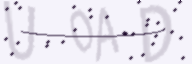

In [13]:
model.eval()
do = True
while do or decode_target(target) == decode(output_argmax[0]):
    do = False
    image, target, input_length, label_length = dataset[0]
    print('true:', decode_target(target))

    output = model(image.unsqueeze(0).cuda())
    output_argmax = output.      detach().permute(1, 0, 2).argmax(dim=-1)
    print('pred:', decode(output_argmax[0]))
to_pil_image(image)

In [14]:
torch.save(model, 'ctc.pth')

/home/ypw/anaconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
